In [54]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch-scatter 2.1.0+pt113cu116
Uninstalling torch-scatter-2.1.0+pt113cu116:
  Successfully uninstalled torch-scatter-2.1.0+pt113cu116
Found existing installation: torch-sparse 0.6.16+pt113cu116
Uninstalling torch-sparse-0.6.16+pt113cu116:
  Successfully uninstalled torch-sparse-0.6.16+pt113cu116
Found existing installation: torch-geometric 2.3.0
Uninstalling torch-geometric-2.3.0:
  Successfully uninstalled torch-geometric-2.3.0
Found existing installation: torch-cluster 1.6.0+pt113cu116
Uninstalling torch-cluster-1.6.0+pt113cu116:
  Successfully uninstalled torch-cluster-1.6.0+pt113cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_scatter-2.1.0%2Bpt113cu116-cp38-cp38-linux_x86_64.whl (9.4 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_sparse-0.6.16%2Bpt113cu116-cp38-cp38-linux_x86_64.whl (4.5 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_cluster-1.6.0%2Bpt113cu116-cp38-cp38-linux_x86_64.whl (3.2 MB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-u2mx2z9q
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-u2mx2z9q
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 0c8f35fa9458bc4eb8ce43c3694ba35481623dde
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=843149 sha256=d479b0d6dc1499b68df772107f778f7795992f02ab628dc872b7dc633ed0782d
  Stored in directory: /tmp/pip-ephem-wheel-cache-yaiol73u/wheels/ba/e1/8e/28297c3201c884d3ea8c47ba71a9e71e547e556c0caa9cf5a2
Successfully built torch-geometric


In [55]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import numpy as np
import pandas as pd
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU, CrossEntropyLoss
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils import from_smiles
from tqdm import tqdm

from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")


In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
# Prepate data from csv to work
def convert_csv_to_graph(path, smiles, sol):
  df = pd.read_csv(path, sep=',')
  df.head()

  data = []

  for index, row in df.iterrows():
    sample = from_smiles(row[smiles])
    sample.y = torch.tensor([[row[sol]]])
    data.append(sample)
  print("Dataset sample: ", data[0])
  print("Sample  nodes: ", data[0].num_nodes)
  print("Sample  edges: ", data[0].num_edges) 
  return data

In [59]:
# Get datasets from github
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv #AQSOL
!wget https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv 

--2023-01-30 18:10:33--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/curated-solubility-dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3750208 (3.6M) [text/plain]
Saving to: ‘curated-solubility-dataset.csv.1’

curated-solubility- 100%[===================>]   3.58M  --.-KB/s    in 0.02s   

2023-01-30 18:10:33 (225 MB/s) - ‘curated-solubility-dataset.csv.1’ saved [3750208/3750208]

--2023-01-30 18:10:33--  https://raw.githubusercontent.com/AngryFennec/drug-gnn/master/data/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP requ

In [60]:
#data = convert_csv_to_graph('delaney-processed.csv', 'smiles', 'ESOL predicted log solubility in mols per litre')
data = convert_csv_to_graph('curated-solubility-dataset.csv', 'SMILES', 'Solubility')

Dataset sample:  Data(x=[23, 9], edge_index=[2, 42], edge_attr=[42, 3], smiles='[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C', y=[1, 1])
Sample  nodes:  23
Sample  edges:  42


In [61]:
hidden_channels = 64
num_features = len(data[0].x[0])
batch_size = 128


class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.out = Linear(hidden_channels*2, 1)

    def forward(self, x, edge_index, batch_index):
        hidden = F.leaky_relu(self.conv1(x, edge_index))
        hidden = F.leaky_relu(self.conv2(hidden, edge_index))
        hidden = F.leaky_relu(self.conv3(hidden, edge_index))

        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        out = self.out(hidden)
        return out, hidden

In [62]:
model = GCN(num_features=num_features, hidden_channels=hidden_channels)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [63]:
data_size = len(data)
loader = DataLoader(data[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
print(data_size)

9982


In [64]:
def train(data):
    for batch in loader:
      batch.to(device)  
      optimizer.zero_grad() 
      prediction, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
      loss = torch.sqrt(loss_fn(prediction, batch.y))       
      loss.backward()  
      optimizer.step()   
    return loss, embedding

In [65]:
epochs = 3000
losses = []
for epoch in tqdm(range(epochs)):
    loss, h = train(data)
    losses.append(loss)
    print(f"Epoch {epoch} | Train Loss {loss}")

  0%|          | 1/3000 [00:02<1:51:14,  2.23s/it]

Epoch 0 | Train Loss 2.698723554611206


  0%|          | 2/3000 [00:04<1:39:28,  1.99s/it]

Epoch 1 | Train Loss 2.3926808834075928


  0%|          | 3/3000 [00:06<1:59:19,  2.39s/it]

Epoch 2 | Train Loss 2.2792105674743652


  0%|          | 4/3000 [00:09<2:12:15,  2.65s/it]

Epoch 3 | Train Loss 2.097510576248169


  0%|          | 5/3000 [00:13<2:20:44,  2.82s/it]

Epoch 4 | Train Loss 2.5093111991882324


  0%|          | 6/3000 [00:16<2:29:03,  2.99s/it]

Epoch 5 | Train Loss 2.145444393157959


  0%|          | 7/3000 [00:19<2:33:28,  3.08s/it]

Epoch 6 | Train Loss 1.6595332622528076


  0%|          | 8/3000 [00:23<2:39:20,  3.20s/it]

Epoch 7 | Train Loss 1.9024301767349243


  0%|          | 9/3000 [00:25<2:21:42,  2.84s/it]

Epoch 8 | Train Loss 1.7126449346542358


  0%|          | 10/3000 [00:26<2:03:31,  2.48s/it]

Epoch 9 | Train Loss 2.3998947143554688


  0%|          | 11/3000 [00:28<1:51:08,  2.23s/it]

Epoch 10 | Train Loss 1.9434386491775513


  0%|          | 12/3000 [00:30<1:42:50,  2.06s/it]

Epoch 11 | Train Loss 1.6859157085418701


  0%|          | 13/3000 [00:31<1:36:29,  1.94s/it]

Epoch 12 | Train Loss 1.8910313844680786


  0%|          | 14/3000 [00:33<1:32:59,  1.87s/it]

Epoch 13 | Train Loss 1.8966721296310425


  0%|          | 15/3000 [00:35<1:29:43,  1.80s/it]

Epoch 14 | Train Loss 1.7342374324798584


  1%|          | 16/3000 [00:36<1:27:05,  1.75s/it]

Epoch 15 | Train Loss 1.903891921043396


  1%|          | 17/3000 [00:38<1:25:29,  1.72s/it]

Epoch 16 | Train Loss 1.888156533241272


  1%|          | 18/3000 [00:40<1:24:09,  1.69s/it]

Epoch 17 | Train Loss 1.805934190750122


  1%|          | 19/3000 [00:41<1:23:51,  1.69s/it]

Epoch 18 | Train Loss 1.5563510656356812


  1%|          | 20/3000 [00:43<1:23:28,  1.68s/it]

Epoch 19 | Train Loss 1.7834250926971436


  1%|          | 21/3000 [00:45<1:23:16,  1.68s/it]

Epoch 20 | Train Loss 1.7807365655899048


  1%|          | 22/3000 [00:46<1:22:50,  1.67s/it]

Epoch 21 | Train Loss 1.2182185649871826


  1%|          | 23/3000 [00:48<1:22:42,  1.67s/it]

Epoch 22 | Train Loss 1.9772857427597046


  1%|          | 24/3000 [00:50<1:22:21,  1.66s/it]

Epoch 23 | Train Loss 1.5707286596298218


  1%|          | 25/3000 [00:51<1:22:51,  1.67s/it]

Epoch 24 | Train Loss 1.6774052381515503


  1%|          | 26/3000 [00:53<1:23:05,  1.68s/it]

Epoch 25 | Train Loss 1.5204260349273682


  1%|          | 27/3000 [00:55<1:22:38,  1.67s/it]

Epoch 26 | Train Loss 1.6640349626541138


  1%|          | 28/3000 [00:56<1:22:32,  1.67s/it]

Epoch 27 | Train Loss 1.5596400499343872


  1%|          | 29/3000 [00:58<1:22:37,  1.67s/it]

Epoch 28 | Train Loss 1.7428656816482544


  1%|          | 30/3000 [01:00<1:22:53,  1.67s/it]

Epoch 29 | Train Loss 1.8928409814834595


  1%|          | 31/3000 [01:01<1:23:25,  1.69s/it]

Epoch 30 | Train Loss 1.6536973714828491


  1%|          | 32/3000 [01:03<1:23:20,  1.68s/it]

Epoch 31 | Train Loss 1.464138150215149


  1%|          | 33/3000 [01:05<1:23:05,  1.68s/it]

Epoch 32 | Train Loss 1.7876027822494507


  1%|          | 34/3000 [01:06<1:22:46,  1.67s/it]

Epoch 33 | Train Loss 1.7137545347213745


  1%|          | 35/3000 [01:08<1:23:38,  1.69s/it]

Epoch 34 | Train Loss 1.591027855873108


  1%|          | 36/3000 [01:10<1:23:45,  1.70s/it]

Epoch 35 | Train Loss 2.026919364929199


  1%|          | 37/3000 [01:12<1:24:10,  1.70s/it]

Epoch 36 | Train Loss 1.8093239068984985


  1%|▏         | 38/3000 [01:13<1:23:31,  1.69s/it]

Epoch 37 | Train Loss 1.5648905038833618


  1%|▏         | 39/3000 [01:15<1:23:31,  1.69s/it]

Epoch 38 | Train Loss 1.8061491250991821


  1%|▏         | 40/3000 [01:17<1:23:44,  1.70s/it]

Epoch 39 | Train Loss 1.7154691219329834


  1%|▏         | 41/3000 [01:18<1:24:31,  1.71s/it]

Epoch 40 | Train Loss 1.279154896736145


  1%|▏         | 42/3000 [01:20<1:23:58,  1.70s/it]

Epoch 41 | Train Loss 1.7197742462158203


  1%|▏         | 43/3000 [01:22<1:23:09,  1.69s/it]

Epoch 42 | Train Loss 1.9286195039749146


  1%|▏         | 44/3000 [01:23<1:23:06,  1.69s/it]

Epoch 43 | Train Loss 1.8790470361709595


  2%|▏         | 45/3000 [01:25<1:22:36,  1.68s/it]

Epoch 44 | Train Loss 1.5594323873519897


  2%|▏         | 46/3000 [01:27<1:22:40,  1.68s/it]

Epoch 45 | Train Loss 2.0009725093841553


  2%|▏         | 47/3000 [01:28<1:22:48,  1.68s/it]

Epoch 46 | Train Loss 1.0463955402374268


  2%|▏         | 48/3000 [01:30<1:23:10,  1.69s/it]

Epoch 47 | Train Loss 1.6910555362701416


  2%|▏         | 49/3000 [01:32<1:22:41,  1.68s/it]

Epoch 48 | Train Loss 1.9634119272232056


  2%|▏         | 50/3000 [01:33<1:23:12,  1.69s/it]

Epoch 49 | Train Loss 1.4745259284973145


  2%|▏         | 51/3000 [01:35<1:23:11,  1.69s/it]

Epoch 50 | Train Loss 1.4009857177734375


  2%|▏         | 52/3000 [01:37<1:29:50,  1.83s/it]

Epoch 51 | Train Loss 1.4313117265701294


  2%|▏         | 53/3000 [01:40<1:42:32,  2.09s/it]

Epoch 52 | Train Loss 1.6499685049057007


  2%|▏         | 54/3000 [01:42<1:36:46,  1.97s/it]

Epoch 53 | Train Loss 1.3952109813690186


  2%|▏         | 55/3000 [01:43<1:32:25,  1.88s/it]

Epoch 54 | Train Loss 1.6955647468566895


  2%|▏         | 56/3000 [01:45<1:29:51,  1.83s/it]

Epoch 55 | Train Loss 1.4196168184280396


  2%|▏         | 57/3000 [01:47<1:28:15,  1.80s/it]

Epoch 56 | Train Loss 1.6244430541992188


  2%|▏         | 58/3000 [01:48<1:26:29,  1.76s/it]

Epoch 57 | Train Loss 1.4570577144622803


  2%|▏         | 59/3000 [01:50<1:25:04,  1.74s/it]

Epoch 58 | Train Loss 1.5122497081756592


  2%|▏         | 60/3000 [01:52<1:24:30,  1.72s/it]

Epoch 59 | Train Loss 1.175873041152954


  2%|▏         | 61/3000 [01:54<1:24:38,  1.73s/it]

Epoch 60 | Train Loss 1.602051019668579


  2%|▏         | 62/3000 [01:55<1:24:29,  1.73s/it]

Epoch 61 | Train Loss 1.3212305307388306


  2%|▏         | 63/3000 [01:57<1:23:49,  1.71s/it]

Epoch 62 | Train Loss 1.623294472694397


  2%|▏         | 64/3000 [01:59<1:23:28,  1.71s/it]

Epoch 63 | Train Loss 1.4223439693450928


  2%|▏         | 65/3000 [02:00<1:22:47,  1.69s/it]

Epoch 64 | Train Loss 1.5516551733016968


  2%|▏         | 66/3000 [02:02<1:22:23,  1.68s/it]

Epoch 65 | Train Loss 2.0438907146453857


  2%|▏         | 67/3000 [02:04<1:22:32,  1.69s/it]

Epoch 66 | Train Loss 1.128119707107544


  2%|▏         | 68/3000 [02:05<1:22:26,  1.69s/it]

Epoch 67 | Train Loss 1.3464001417160034


  2%|▏         | 69/3000 [02:07<1:22:07,  1.68s/it]

Epoch 68 | Train Loss 1.6067062616348267


  2%|▏         | 70/3000 [02:09<1:21:57,  1.68s/it]

Epoch 69 | Train Loss 1.439391851425171


  2%|▏         | 71/3000 [02:10<1:22:12,  1.68s/it]

Epoch 70 | Train Loss 1.743587613105774


  2%|▏         | 72/3000 [02:12<1:21:42,  1.67s/it]

Epoch 71 | Train Loss 1.2207978963851929


  2%|▏         | 73/3000 [02:14<1:22:20,  1.69s/it]

Epoch 72 | Train Loss 1.3372794389724731


  2%|▏         | 74/3000 [02:16<1:22:41,  1.70s/it]

Epoch 73 | Train Loss 1.5392570495605469


  2%|▎         | 75/3000 [02:17<1:22:36,  1.69s/it]

Epoch 74 | Train Loss 1.2684600353240967


  3%|▎         | 76/3000 [02:19<1:22:23,  1.69s/it]

Epoch 75 | Train Loss 1.38797128200531


  3%|▎         | 77/3000 [02:21<1:22:22,  1.69s/it]

Epoch 76 | Train Loss 1.5364346504211426


  3%|▎         | 78/3000 [02:22<1:22:01,  1.68s/it]

Epoch 77 | Train Loss 1.3210909366607666


  3%|▎         | 79/3000 [02:24<1:21:49,  1.68s/it]

Epoch 78 | Train Loss 1.1431901454925537


  3%|▎         | 80/3000 [02:26<1:22:00,  1.69s/it]

Epoch 79 | Train Loss 1.2278552055358887


  3%|▎         | 81/3000 [02:27<1:21:53,  1.68s/it]

Epoch 80 | Train Loss 1.2583616971969604


  3%|▎         | 82/3000 [02:29<1:21:49,  1.68s/it]

Epoch 81 | Train Loss 1.5787533521652222


  3%|▎         | 83/3000 [02:31<1:21:46,  1.68s/it]

Epoch 82 | Train Loss 1.6372159719467163


  3%|▎         | 84/3000 [02:32<1:21:27,  1.68s/it]

Epoch 83 | Train Loss 1.181943655014038


  3%|▎         | 85/3000 [02:34<1:21:40,  1.68s/it]

Epoch 84 | Train Loss 1.223858118057251


  3%|▎         | 86/3000 [02:36<1:22:09,  1.69s/it]

Epoch 85 | Train Loss 1.0957988500595093


  3%|▎         | 87/3000 [02:37<1:21:46,  1.68s/it]

Epoch 86 | Train Loss 1.5028252601623535


  3%|▎         | 88/3000 [02:39<1:21:31,  1.68s/it]

Epoch 87 | Train Loss 1.5896645784378052


  3%|▎         | 89/3000 [02:41<1:21:14,  1.67s/it]

Epoch 88 | Train Loss 1.3241220712661743


  3%|▎         | 90/3000 [02:42<1:21:09,  1.67s/it]

Epoch 89 | Train Loss 1.2476269006729126


  3%|▎         | 91/3000 [02:44<1:21:17,  1.68s/it]

Epoch 90 | Train Loss 1.3135887384414673


  3%|▎         | 92/3000 [02:46<1:21:36,  1.68s/it]

Epoch 91 | Train Loss 1.4753270149230957


  3%|▎         | 93/3000 [02:47<1:21:54,  1.69s/it]

Epoch 92 | Train Loss 1.424959659576416


  3%|▎         | 94/3000 [02:49<1:22:05,  1.69s/it]

Epoch 93 | Train Loss 1.6083194017410278


  3%|▎         | 95/3000 [02:52<1:32:03,  1.90s/it]

Epoch 94 | Train Loss 1.3472776412963867


  3%|▎         | 96/3000 [02:53<1:31:15,  1.89s/it]

Epoch 95 | Train Loss 1.6331666707992554


  3%|▎         | 97/3000 [02:55<1:28:25,  1.83s/it]

Epoch 96 | Train Loss 1.421507477760315


  3%|▎         | 98/3000 [02:57<1:26:20,  1.79s/it]

Epoch 97 | Train Loss 1.6024651527404785


  3%|▎         | 99/3000 [02:59<1:25:05,  1.76s/it]

Epoch 98 | Train Loss 1.312333106994629


  3%|▎         | 100/3000 [03:00<1:24:13,  1.74s/it]

Epoch 99 | Train Loss 1.4898033142089844


  3%|▎         | 101/3000 [03:02<1:23:27,  1.73s/it]

Epoch 100 | Train Loss 1.3348852396011353


  3%|▎         | 102/3000 [03:04<1:22:53,  1.72s/it]

Epoch 101 | Train Loss 1.300878643989563


  3%|▎         | 103/3000 [03:05<1:22:32,  1.71s/it]

Epoch 102 | Train Loss 1.2098149061203003


  3%|▎         | 104/3000 [03:07<1:22:24,  1.71s/it]

Epoch 103 | Train Loss 1.5312230587005615


  4%|▎         | 105/3000 [03:09<1:22:06,  1.70s/it]

Epoch 104 | Train Loss 1.4234918355941772


  4%|▎         | 106/3000 [03:10<1:21:50,  1.70s/it]

Epoch 105 | Train Loss 1.5515894889831543


  4%|▎         | 107/3000 [03:12<1:22:08,  1.70s/it]

Epoch 106 | Train Loss 1.6225591897964478


  4%|▎         | 108/3000 [03:14<1:21:59,  1.70s/it]

Epoch 107 | Train Loss 1.5618914365768433


  4%|▎         | 109/3000 [03:15<1:21:49,  1.70s/it]

Epoch 108 | Train Loss 1.5986896753311157


  4%|▎         | 110/3000 [03:17<1:21:57,  1.70s/it]

Epoch 109 | Train Loss 1.7174584865570068


  4%|▎         | 111/3000 [03:19<1:21:52,  1.70s/it]

Epoch 110 | Train Loss 1.247326374053955


  4%|▎         | 112/3000 [03:21<1:21:50,  1.70s/it]

Epoch 111 | Train Loss 1.289879560470581


  4%|▍         | 113/3000 [03:22<1:21:51,  1.70s/it]

Epoch 112 | Train Loss 1.8379052877426147


  4%|▍         | 114/3000 [03:24<1:22:00,  1.71s/it]

Epoch 113 | Train Loss 1.4189989566802979


  4%|▍         | 115/3000 [03:26<1:22:09,  1.71s/it]

Epoch 114 | Train Loss 1.4885796308517456


  4%|▍         | 116/3000 [03:27<1:22:42,  1.72s/it]

Epoch 115 | Train Loss 1.302714228630066


  4%|▍         | 117/3000 [03:29<1:22:08,  1.71s/it]

Epoch 116 | Train Loss 1.4036474227905273


  4%|▍         | 118/3000 [03:31<1:21:45,  1.70s/it]

Epoch 117 | Train Loss 1.412563681602478


  4%|▍         | 119/3000 [03:33<1:21:30,  1.70s/it]

Epoch 118 | Train Loss 1.4728052616119385


  4%|▍         | 120/3000 [03:34<1:21:40,  1.70s/it]

Epoch 119 | Train Loss 1.2981681823730469


  4%|▍         | 121/3000 [03:36<1:21:33,  1.70s/it]

Epoch 120 | Train Loss 1.8955025672912598


  4%|▍         | 122/3000 [03:38<1:21:37,  1.70s/it]

Epoch 121 | Train Loss 1.4261943101882935


  4%|▍         | 123/3000 [03:39<1:21:45,  1.70s/it]

Epoch 122 | Train Loss 1.9653639793395996


  4%|▍         | 124/3000 [03:41<1:21:35,  1.70s/it]

Epoch 123 | Train Loss 1.5502580404281616


  4%|▍         | 125/3000 [03:43<1:21:16,  1.70s/it]

Epoch 124 | Train Loss 1.3006199598312378


  4%|▍         | 126/3000 [03:44<1:21:15,  1.70s/it]

Epoch 125 | Train Loss 1.2165805101394653


  4%|▍         | 127/3000 [03:46<1:21:19,  1.70s/it]

Epoch 126 | Train Loss 1.3041950464248657


  4%|▍         | 128/3000 [03:48<1:21:04,  1.69s/it]

Epoch 127 | Train Loss 1.278065800666809


  4%|▍         | 129/3000 [03:50<1:21:15,  1.70s/it]

Epoch 128 | Train Loss 1.269117832183838


  4%|▍         | 130/3000 [03:51<1:20:56,  1.69s/it]

Epoch 129 | Train Loss 1.2387109994888306


  4%|▍         | 131/3000 [03:53<1:20:53,  1.69s/it]

Epoch 130 | Train Loss 1.0243557691574097


  4%|▍         | 132/3000 [03:55<1:20:42,  1.69s/it]

Epoch 131 | Train Loss 1.0449093580245972


  4%|▍         | 133/3000 [03:56<1:21:11,  1.70s/it]

Epoch 132 | Train Loss 1.3522088527679443


  4%|▍         | 134/3000 [03:58<1:20:51,  1.69s/it]

Epoch 133 | Train Loss 1.547946572303772


  4%|▍         | 135/3000 [04:00<1:21:06,  1.70s/it]

Epoch 134 | Train Loss 1.18478262424469


  5%|▍         | 136/3000 [04:01<1:20:58,  1.70s/it]

Epoch 135 | Train Loss 1.3285173177719116


  5%|▍         | 137/3000 [04:03<1:20:58,  1.70s/it]

Epoch 136 | Train Loss 1.4035218954086304


  5%|▍         | 138/3000 [04:05<1:20:44,  1.69s/it]

Epoch 137 | Train Loss 1.402945876121521


  5%|▍         | 139/3000 [04:06<1:20:39,  1.69s/it]

Epoch 138 | Train Loss 1.4169094562530518


  5%|▍         | 140/3000 [04:08<1:20:55,  1.70s/it]

Epoch 139 | Train Loss 1.4967942237854004


  5%|▍         | 141/3000 [04:10<1:20:40,  1.69s/it]

Epoch 140 | Train Loss 1.0875544548034668


  5%|▍         | 142/3000 [04:12<1:20:57,  1.70s/it]

Epoch 141 | Train Loss 1.299315333366394


  5%|▍         | 143/3000 [04:13<1:20:56,  1.70s/it]

Epoch 142 | Train Loss 1.4582782983779907


  5%|▍         | 144/3000 [04:15<1:20:41,  1.70s/it]

Epoch 143 | Train Loss 1.6056621074676514


  5%|▍         | 145/3000 [04:17<1:20:26,  1.69s/it]

Epoch 144 | Train Loss 1.4275848865509033


  5%|▍         | 146/3000 [04:18<1:20:21,  1.69s/it]

Epoch 145 | Train Loss 1.4540568590164185


  5%|▍         | 147/3000 [04:20<1:20:09,  1.69s/it]

Epoch 146 | Train Loss 1.1490013599395752


  5%|▍         | 148/3000 [04:22<1:20:08,  1.69s/it]

Epoch 147 | Train Loss 1.5368202924728394


  5%|▍         | 149/3000 [04:23<1:19:59,  1.68s/it]

Epoch 148 | Train Loss 1.4170681238174438


  5%|▌         | 150/3000 [04:25<1:20:09,  1.69s/it]

Epoch 149 | Train Loss 1.3524749279022217


  5%|▌         | 151/3000 [04:27<1:20:03,  1.69s/it]

Epoch 150 | Train Loss 1.0818947553634644


  5%|▌         | 152/3000 [04:28<1:19:37,  1.68s/it]

Epoch 151 | Train Loss 1.1495572328567505


  5%|▌         | 153/3000 [04:30<1:19:42,  1.68s/it]

Epoch 152 | Train Loss 1.375830054283142


  5%|▌         | 154/3000 [04:32<1:19:38,  1.68s/it]

Epoch 153 | Train Loss 1.221617341041565


  5%|▌         | 155/3000 [04:33<1:19:50,  1.68s/it]

Epoch 154 | Train Loss 1.3117698431015015


  5%|▌         | 156/3000 [04:35<1:19:52,  1.69s/it]

Epoch 155 | Train Loss 1.3293830156326294


  5%|▌         | 157/3000 [04:37<1:19:36,  1.68s/it]

Epoch 156 | Train Loss 1.1670153141021729


  5%|▌         | 158/3000 [04:38<1:19:09,  1.67s/it]

Epoch 157 | Train Loss 1.4276843070983887


  5%|▌         | 159/3000 [04:40<1:20:01,  1.69s/it]

Epoch 158 | Train Loss 1.3899762630462646


  5%|▌         | 160/3000 [04:42<1:19:54,  1.69s/it]

Epoch 159 | Train Loss 1.0493600368499756


  5%|▌         | 161/3000 [04:44<1:19:26,  1.68s/it]

Epoch 160 | Train Loss 1.4777697324752808


  5%|▌         | 162/3000 [04:45<1:19:10,  1.67s/it]

Epoch 161 | Train Loss 1.5402705669403076


  5%|▌         | 163/3000 [04:47<1:19:05,  1.67s/it]

Epoch 162 | Train Loss 1.538741946220398


  5%|▌         | 164/3000 [04:49<1:19:16,  1.68s/it]

Epoch 163 | Train Loss 1.5701899528503418


  6%|▌         | 165/3000 [04:50<1:19:34,  1.68s/it]

Epoch 164 | Train Loss 1.2669529914855957


  6%|▌         | 166/3000 [04:52<1:19:11,  1.68s/it]

Epoch 165 | Train Loss 1.2191065549850464


  6%|▌         | 167/3000 [04:54<1:19:17,  1.68s/it]

Epoch 166 | Train Loss 1.2188576459884644


  6%|▌         | 168/3000 [04:55<1:19:05,  1.68s/it]

Epoch 167 | Train Loss 1.4292819499969482


  6%|▌         | 169/3000 [04:57<1:19:31,  1.69s/it]

Epoch 168 | Train Loss 1.0840262174606323


  6%|▌         | 170/3000 [04:59<1:19:40,  1.69s/it]

Epoch 169 | Train Loss 0.9709615707397461


  6%|▌         | 171/3000 [05:00<1:19:43,  1.69s/it]

Epoch 170 | Train Loss 1.5705472230911255


  6%|▌         | 172/3000 [05:02<1:19:57,  1.70s/it]

Epoch 171 | Train Loss 1.1166682243347168


  6%|▌         | 173/3000 [05:04<1:19:40,  1.69s/it]

Epoch 172 | Train Loss 1.0421741008758545


  6%|▌         | 174/3000 [05:05<1:20:04,  1.70s/it]

Epoch 173 | Train Loss 1.5341078042984009


  6%|▌         | 175/3000 [05:07<1:19:54,  1.70s/it]

Epoch 174 | Train Loss 1.3245519399642944


  6%|▌         | 176/3000 [05:09<1:19:10,  1.68s/it]

Epoch 175 | Train Loss 1.2446024417877197


  6%|▌         | 177/3000 [05:10<1:18:35,  1.67s/it]

Epoch 176 | Train Loss 1.286301612854004


  6%|▌         | 178/3000 [05:12<1:18:49,  1.68s/it]

Epoch 177 | Train Loss 1.3356809616088867


  6%|▌         | 179/3000 [05:14<1:18:58,  1.68s/it]

Epoch 178 | Train Loss 1.2709070444107056


  6%|▌         | 180/3000 [05:15<1:18:49,  1.68s/it]

Epoch 179 | Train Loss 1.4371402263641357


  6%|▌         | 181/3000 [05:17<1:18:48,  1.68s/it]

Epoch 180 | Train Loss 1.2733269929885864


  6%|▌         | 182/3000 [05:19<1:18:31,  1.67s/it]

Epoch 181 | Train Loss 2.0166971683502197


  6%|▌         | 183/3000 [05:20<1:18:26,  1.67s/it]

Epoch 182 | Train Loss 1.230686902999878


  6%|▌         | 184/3000 [05:22<1:18:31,  1.67s/it]

Epoch 183 | Train Loss 1.5401502847671509


  6%|▌         | 185/3000 [05:24<1:18:10,  1.67s/it]

Epoch 184 | Train Loss 1.1907391548156738


  6%|▌         | 186/3000 [05:25<1:17:32,  1.65s/it]

Epoch 185 | Train Loss 1.4933334589004517


  6%|▌         | 187/3000 [05:27<1:17:49,  1.66s/it]

Epoch 186 | Train Loss 1.5328385829925537


  6%|▋         | 188/3000 [05:29<1:18:12,  1.67s/it]

Epoch 187 | Train Loss 1.0787111520767212


  6%|▋         | 189/3000 [05:30<1:18:25,  1.67s/it]

Epoch 188 | Train Loss 1.2705307006835938


  6%|▋         | 190/3000 [05:32<1:18:41,  1.68s/it]

Epoch 189 | Train Loss 1.3307102918624878


  6%|▋         | 191/3000 [05:34<1:18:34,  1.68s/it]

Epoch 190 | Train Loss 1.5354315042495728


  6%|▋         | 192/3000 [05:36<1:18:38,  1.68s/it]

Epoch 191 | Train Loss 1.294267177581787


  6%|▋         | 193/3000 [05:37<1:18:05,  1.67s/it]

Epoch 192 | Train Loss 1.1735483407974243


  6%|▋         | 194/3000 [05:39<1:17:52,  1.67s/it]

Epoch 193 | Train Loss 1.2230969667434692


  6%|▋         | 195/3000 [05:41<1:17:50,  1.66s/it]

Epoch 194 | Train Loss 1.5094842910766602


  7%|▋         | 196/3000 [05:42<1:17:40,  1.66s/it]

Epoch 195 | Train Loss 1.2988617420196533


  7%|▋         | 197/3000 [05:44<1:18:00,  1.67s/it]

Epoch 196 | Train Loss 1.2086796760559082


  7%|▋         | 198/3000 [05:46<1:17:59,  1.67s/it]

Epoch 197 | Train Loss 1.1847811937332153


  7%|▋         | 199/3000 [05:47<1:17:57,  1.67s/it]

Epoch 198 | Train Loss 0.9808436036109924


  7%|▋         | 200/3000 [05:49<1:17:46,  1.67s/it]

Epoch 199 | Train Loss 1.678074598312378


  7%|▋         | 201/3000 [05:51<1:17:46,  1.67s/it]

Epoch 200 | Train Loss 1.270094871520996


  7%|▋         | 202/3000 [05:52<1:17:43,  1.67s/it]

Epoch 201 | Train Loss 1.1299086809158325


  7%|▋         | 203/3000 [05:54<1:18:02,  1.67s/it]

Epoch 202 | Train Loss 1.391536831855774


  7%|▋         | 204/3000 [05:56<1:18:13,  1.68s/it]

Epoch 203 | Train Loss 1.251788854598999


  7%|▋         | 205/3000 [05:57<1:18:24,  1.68s/it]

Epoch 204 | Train Loss 0.8833722472190857


  7%|▋         | 206/3000 [05:59<1:18:17,  1.68s/it]

Epoch 205 | Train Loss 0.9630722999572754


  7%|▋         | 207/3000 [06:01<1:18:06,  1.68s/it]

Epoch 206 | Train Loss 1.2474186420440674


  7%|▋         | 208/3000 [06:02<1:18:02,  1.68s/it]

Epoch 207 | Train Loss 1.2768590450286865


  7%|▋         | 209/3000 [06:04<1:18:30,  1.69s/it]

Epoch 208 | Train Loss 0.9410325884819031


  7%|▋         | 210/3000 [06:06<1:17:54,  1.68s/it]

Epoch 209 | Train Loss 1.4433320760726929


  7%|▋         | 211/3000 [06:07<1:18:02,  1.68s/it]

Epoch 210 | Train Loss 1.0249121189117432


  7%|▋         | 212/3000 [06:09<1:17:38,  1.67s/it]

Epoch 211 | Train Loss 1.2252144813537598


  7%|▋         | 213/3000 [06:11<1:17:33,  1.67s/it]

Epoch 212 | Train Loss 1.2922370433807373


  7%|▋         | 214/3000 [06:12<1:17:45,  1.67s/it]

Epoch 213 | Train Loss 1.32664155960083


  7%|▋         | 215/3000 [06:14<1:17:46,  1.68s/it]

Epoch 214 | Train Loss 1.3898652791976929


  7%|▋         | 216/3000 [06:16<1:17:55,  1.68s/it]

Epoch 215 | Train Loss 1.0620867013931274


  7%|▋         | 217/3000 [06:17<1:17:30,  1.67s/it]

Epoch 216 | Train Loss 1.2111313343048096


  7%|▋         | 218/3000 [06:19<1:17:52,  1.68s/it]

Epoch 217 | Train Loss 1.488523244857788


  7%|▋         | 219/3000 [06:21<1:18:02,  1.68s/it]

Epoch 218 | Train Loss 1.0937860012054443


  7%|▋         | 220/3000 [06:22<1:17:52,  1.68s/it]

Epoch 219 | Train Loss 1.0504873991012573


  7%|▋         | 221/3000 [06:24<1:17:56,  1.68s/it]

Epoch 220 | Train Loss 1.4384411573410034


  7%|▋         | 222/3000 [06:26<1:17:57,  1.68s/it]

Epoch 221 | Train Loss 1.2623220682144165


  7%|▋         | 223/3000 [06:28<1:18:32,  1.70s/it]

Epoch 222 | Train Loss 1.3693351745605469


  7%|▋         | 224/3000 [06:29<1:19:12,  1.71s/it]

Epoch 223 | Train Loss 1.5449751615524292


  8%|▊         | 225/3000 [06:31<1:19:44,  1.72s/it]

Epoch 224 | Train Loss 0.9981070160865784


  8%|▊         | 226/3000 [06:33<1:19:16,  1.71s/it]

Epoch 225 | Train Loss 1.3244789838790894


  8%|▊         | 227/3000 [06:34<1:19:52,  1.73s/it]

Epoch 226 | Train Loss 1.416175127029419


  8%|▊         | 228/3000 [06:37<1:24:31,  1.83s/it]

Epoch 227 | Train Loss 0.9890719652175903


  8%|▊         | 229/3000 [06:39<1:29:56,  1.95s/it]

Epoch 228 | Train Loss 1.3919674158096313


  8%|▊         | 230/3000 [06:40<1:26:11,  1.87s/it]

Epoch 229 | Train Loss 1.128340482711792


  8%|▊         | 231/3000 [06:42<1:23:47,  1.82s/it]

Epoch 230 | Train Loss 1.6355940103530884


  8%|▊         | 232/3000 [06:44<1:21:54,  1.78s/it]

Epoch 231 | Train Loss 1.440068244934082


  8%|▊         | 233/3000 [06:46<1:28:13,  1.91s/it]

Epoch 232 | Train Loss 1.3001494407653809


  8%|▊         | 234/3000 [06:48<1:24:58,  1.84s/it]

Epoch 233 | Train Loss 1.2527673244476318


  8%|▊         | 235/3000 [06:49<1:22:18,  1.79s/it]

Epoch 234 | Train Loss 1.0796810388565063


  8%|▊         | 236/3000 [06:51<1:20:33,  1.75s/it]

Epoch 235 | Train Loss 1.2447971105575562


  8%|▊         | 237/3000 [06:53<1:19:42,  1.73s/it]

Epoch 236 | Train Loss 1.3404567241668701


  8%|▊         | 238/3000 [06:54<1:19:00,  1.72s/it]

Epoch 237 | Train Loss 1.0774606466293335


  8%|▊         | 239/3000 [06:56<1:18:06,  1.70s/it]

Epoch 238 | Train Loss 1.5682531595230103


  8%|▊         | 240/3000 [06:58<1:17:49,  1.69s/it]

Epoch 239 | Train Loss 1.0731732845306396


  8%|▊         | 241/3000 [06:59<1:17:08,  1.68s/it]

Epoch 240 | Train Loss 1.3363136053085327


  8%|▊         | 242/3000 [07:01<1:17:29,  1.69s/it]

Epoch 241 | Train Loss 1.3752362728118896


  8%|▊         | 243/3000 [07:03<1:17:41,  1.69s/it]

Epoch 242 | Train Loss 1.0344839096069336


  8%|▊         | 244/3000 [07:04<1:17:29,  1.69s/it]

Epoch 243 | Train Loss 1.6979488134384155


  8%|▊         | 245/3000 [07:06<1:16:59,  1.68s/it]

Epoch 244 | Train Loss 1.0290600061416626


  8%|▊         | 246/3000 [07:08<1:16:54,  1.68s/it]

Epoch 245 | Train Loss 1.220053791999817


  8%|▊         | 247/3000 [07:09<1:16:47,  1.67s/it]

Epoch 246 | Train Loss 1.2081882953643799


  8%|▊         | 248/3000 [07:11<1:17:25,  1.69s/it]

Epoch 247 | Train Loss 1.2785918712615967


  8%|▊         | 249/3000 [07:13<1:17:35,  1.69s/it]

Epoch 248 | Train Loss 1.274104118347168


  8%|▊         | 250/3000 [07:15<1:17:44,  1.70s/it]

Epoch 249 | Train Loss 1.2939958572387695


  8%|▊         | 251/3000 [07:16<1:17:25,  1.69s/it]

Epoch 250 | Train Loss 1.2016863822937012


  8%|▊         | 252/3000 [07:18<1:17:45,  1.70s/it]

Epoch 251 | Train Loss 1.3720552921295166


  8%|▊         | 253/3000 [07:20<1:17:18,  1.69s/it]

Epoch 252 | Train Loss 1.1217321157455444


  8%|▊         | 254/3000 [07:21<1:17:20,  1.69s/it]

Epoch 253 | Train Loss 1.129970908164978


  8%|▊         | 255/3000 [07:23<1:17:28,  1.69s/it]

Epoch 254 | Train Loss 1.250196099281311


  9%|▊         | 256/3000 [07:25<1:17:00,  1.68s/it]

Epoch 255 | Train Loss 1.110849142074585


  9%|▊         | 257/3000 [07:26<1:17:10,  1.69s/it]

Epoch 256 | Train Loss 1.0709041357040405


  9%|▊         | 258/3000 [07:28<1:17:43,  1.70s/it]

Epoch 257 | Train Loss 1.1986364126205444


  9%|▊         | 259/3000 [07:30<1:17:13,  1.69s/it]

Epoch 258 | Train Loss 1.9359018802642822


  9%|▊         | 260/3000 [07:31<1:17:07,  1.69s/it]

Epoch 259 | Train Loss 1.1445660591125488


  9%|▊         | 261/3000 [07:33<1:17:27,  1.70s/it]

Epoch 260 | Train Loss 1.267509937286377


  9%|▊         | 262/3000 [07:35<1:17:03,  1.69s/it]

Epoch 261 | Train Loss 1.2563024759292603


  9%|▉         | 263/3000 [07:37<1:17:35,  1.70s/it]

Epoch 262 | Train Loss 1.4300564527511597


  9%|▉         | 264/3000 [07:38<1:17:37,  1.70s/it]

Epoch 263 | Train Loss 1.1243712902069092


  9%|▉         | 265/3000 [07:40<1:17:35,  1.70s/it]

Epoch 264 | Train Loss 1.3768861293792725


  9%|▉         | 266/3000 [07:42<1:17:11,  1.69s/it]

Epoch 265 | Train Loss 0.9938408136367798


  9%|▉         | 267/3000 [07:43<1:17:20,  1.70s/it]

Epoch 266 | Train Loss 1.2770875692367554


  9%|▉         | 268/3000 [07:45<1:17:39,  1.71s/it]

Epoch 267 | Train Loss 1.161960244178772


  9%|▉         | 269/3000 [07:47<1:17:21,  1.70s/it]

Epoch 268 | Train Loss 0.9919909238815308


  9%|▉         | 270/3000 [07:49<1:17:26,  1.70s/it]

Epoch 269 | Train Loss 1.1247045993804932


  9%|▉         | 271/3000 [07:50<1:16:58,  1.69s/it]

Epoch 270 | Train Loss 1.006101131439209


  9%|▉         | 272/3000 [07:52<1:17:04,  1.70s/it]

Epoch 271 | Train Loss 1.4483500719070435


  9%|▉         | 273/3000 [07:54<1:17:40,  1.71s/it]

Epoch 272 | Train Loss 1.120263695716858


  9%|▉         | 274/3000 [07:55<1:17:58,  1.72s/it]

Epoch 273 | Train Loss 1.059905767440796


  9%|▉         | 275/3000 [07:57<1:18:01,  1.72s/it]

Epoch 274 | Train Loss 1.2970504760742188


  9%|▉         | 276/3000 [07:59<1:18:08,  1.72s/it]

Epoch 275 | Train Loss 1.4196010828018188


  9%|▉         | 277/3000 [08:01<1:17:58,  1.72s/it]

Epoch 276 | Train Loss 1.2746509313583374


  9%|▉         | 278/3000 [08:02<1:17:54,  1.72s/it]

Epoch 277 | Train Loss 1.2276087999343872


  9%|▉         | 279/3000 [08:04<1:17:44,  1.71s/it]

Epoch 278 | Train Loss 1.420487403869629


  9%|▉         | 280/3000 [08:06<1:17:48,  1.72s/it]

Epoch 279 | Train Loss 1.0587455034255981


  9%|▉         | 281/3000 [08:07<1:17:34,  1.71s/it]

Epoch 280 | Train Loss 1.263421654701233


  9%|▉         | 282/3000 [08:09<1:17:45,  1.72s/it]

Epoch 281 | Train Loss 1.0804589986801147


  9%|▉         | 283/3000 [08:11<1:17:33,  1.71s/it]

Epoch 282 | Train Loss 1.2240374088287354


  9%|▉         | 284/3000 [08:13<1:17:20,  1.71s/it]

Epoch 283 | Train Loss 1.1252025365829468


 10%|▉         | 285/3000 [08:14<1:17:37,  1.72s/it]

Epoch 284 | Train Loss 1.0766665935516357


 10%|▉         | 286/3000 [08:16<1:17:15,  1.71s/it]

Epoch 285 | Train Loss 1.1918295621871948


 10%|▉         | 287/3000 [08:18<1:17:07,  1.71s/it]

Epoch 286 | Train Loss 1.033620834350586


 10%|▉         | 288/3000 [08:19<1:17:05,  1.71s/it]

Epoch 287 | Train Loss 1.5892897844314575


 10%|▉         | 289/3000 [08:21<1:16:34,  1.69s/it]

Epoch 288 | Train Loss 1.1815532445907593


 10%|▉         | 290/3000 [08:23<1:16:33,  1.70s/it]

Epoch 289 | Train Loss 1.1285982131958008


 10%|▉         | 291/3000 [08:24<1:16:35,  1.70s/it]

Epoch 290 | Train Loss 1.1497784852981567


 10%|▉         | 292/3000 [08:26<1:16:47,  1.70s/it]

Epoch 291 | Train Loss 1.1760233640670776


 10%|▉         | 293/3000 [08:28<1:16:57,  1.71s/it]

Epoch 292 | Train Loss 0.9508935213088989


 10%|▉         | 294/3000 [08:30<1:17:34,  1.72s/it]

Epoch 293 | Train Loss 1.0502821207046509


 10%|▉         | 295/3000 [08:31<1:17:49,  1.73s/it]

Epoch 294 | Train Loss 1.5523350238800049


 10%|▉         | 296/3000 [08:33<1:18:00,  1.73s/it]

Epoch 295 | Train Loss 1.055564522743225


 10%|▉         | 297/3000 [08:35<1:17:13,  1.71s/it]

Epoch 296 | Train Loss 1.1818197965621948


 10%|▉         | 298/3000 [08:36<1:17:19,  1.72s/it]

Epoch 297 | Train Loss 1.172040581703186


 10%|▉         | 299/3000 [08:38<1:16:45,  1.71s/it]

Epoch 298 | Train Loss 1.1070332527160645


 10%|█         | 300/3000 [08:40<1:17:17,  1.72s/it]

Epoch 299 | Train Loss 1.088071346282959


 10%|█         | 301/3000 [08:42<1:16:38,  1.70s/it]

Epoch 300 | Train Loss 1.0456287860870361


 10%|█         | 302/3000 [08:43<1:16:35,  1.70s/it]

Epoch 301 | Train Loss 1.1713382005691528


 10%|█         | 303/3000 [08:45<1:16:08,  1.69s/it]

Epoch 302 | Train Loss 1.5160503387451172


 10%|█         | 304/3000 [08:47<1:15:59,  1.69s/it]

Epoch 303 | Train Loss 1.3929221630096436


 10%|█         | 305/3000 [08:48<1:15:41,  1.69s/it]

Epoch 304 | Train Loss 1.090261697769165


 10%|█         | 306/3000 [08:50<1:16:00,  1.69s/it]

Epoch 305 | Train Loss 1.0334893465042114


 10%|█         | 307/3000 [08:52<1:16:29,  1.70s/it]

Epoch 306 | Train Loss 1.355974793434143


 10%|█         | 308/3000 [08:54<1:17:27,  1.73s/it]

Epoch 307 | Train Loss 1.0599365234375


 10%|█         | 309/3000 [08:55<1:17:28,  1.73s/it]

Epoch 308 | Train Loss 1.0571882724761963


 10%|█         | 310/3000 [08:57<1:17:20,  1.73s/it]

Epoch 309 | Train Loss 1.214309573173523


 10%|█         | 311/3000 [08:59<1:16:58,  1.72s/it]

Epoch 310 | Train Loss 1.33722722530365


 10%|█         | 312/3000 [09:00<1:17:39,  1.73s/it]

Epoch 311 | Train Loss 1.0206727981567383


 10%|█         | 313/3000 [09:02<1:17:24,  1.73s/it]

Epoch 312 | Train Loss 1.5678194761276245


 10%|█         | 314/3000 [09:04<1:16:54,  1.72s/it]

Epoch 313 | Train Loss 1.0397579669952393


 10%|█         | 315/3000 [09:06<1:16:21,  1.71s/it]

Epoch 314 | Train Loss 1.3732656240463257


 11%|█         | 316/3000 [09:07<1:16:09,  1.70s/it]

Epoch 315 | Train Loss 1.5957363843917847


 11%|█         | 317/3000 [09:09<1:15:51,  1.70s/it]

Epoch 316 | Train Loss 1.1475900411605835


 11%|█         | 318/3000 [09:11<1:16:07,  1.70s/it]

Epoch 317 | Train Loss 1.0795772075653076


 11%|█         | 319/3000 [09:12<1:16:07,  1.70s/it]

Epoch 318 | Train Loss 1.0352368354797363


 11%|█         | 320/3000 [09:14<1:16:06,  1.70s/it]

Epoch 319 | Train Loss 1.4141225814819336


 11%|█         | 321/3000 [09:16<1:15:55,  1.70s/it]

Epoch 320 | Train Loss 1.0484293699264526


 11%|█         | 322/3000 [09:17<1:15:33,  1.69s/it]

Epoch 321 | Train Loss 1.0079360008239746


 11%|█         | 323/3000 [09:19<1:15:36,  1.69s/it]

Epoch 322 | Train Loss 1.259314775466919


 11%|█         | 324/3000 [09:21<1:15:31,  1.69s/it]

Epoch 323 | Train Loss 1.3995815515518188


 11%|█         | 325/3000 [09:23<1:16:07,  1.71s/it]

Epoch 324 | Train Loss 1.0280611515045166


 11%|█         | 326/3000 [09:24<1:15:41,  1.70s/it]

Epoch 325 | Train Loss 0.9504514336585999


 11%|█         | 327/3000 [09:26<1:15:50,  1.70s/it]

Epoch 326 | Train Loss 1.013921856880188


 11%|█         | 328/3000 [09:28<1:16:10,  1.71s/it]

Epoch 327 | Train Loss 1.1335821151733398


 11%|█         | 329/3000 [09:29<1:16:25,  1.72s/it]

Epoch 328 | Train Loss 1.1475327014923096


 11%|█         | 330/3000 [09:31<1:16:05,  1.71s/it]

Epoch 329 | Train Loss 1.4279377460479736


 11%|█         | 331/3000 [09:33<1:16:14,  1.71s/it]

Epoch 330 | Train Loss 1.2240561246871948


 11%|█         | 332/3000 [09:34<1:15:53,  1.71s/it]

Epoch 331 | Train Loss 0.9698047637939453


 11%|█         | 333/3000 [09:36<1:15:48,  1.71s/it]

Epoch 332 | Train Loss 1.055901288986206


 11%|█         | 334/3000 [09:38<1:16:16,  1.72s/it]

Epoch 333 | Train Loss 0.8527599573135376


 11%|█         | 335/3000 [09:40<1:15:58,  1.71s/it]

Epoch 334 | Train Loss 0.871931791305542


 11%|█         | 336/3000 [09:41<1:15:56,  1.71s/it]

Epoch 335 | Train Loss 0.9366861581802368


 11%|█         | 337/3000 [09:43<1:16:00,  1.71s/it]

Epoch 336 | Train Loss 1.1553162336349487


 11%|█▏        | 338/3000 [09:45<1:16:03,  1.71s/it]

Epoch 337 | Train Loss 1.1129363775253296


 11%|█▏        | 339/3000 [09:46<1:16:00,  1.71s/it]

Epoch 338 | Train Loss 0.9707053899765015


 11%|█▏        | 340/3000 [09:48<1:15:52,  1.71s/it]

Epoch 339 | Train Loss 1.192474365234375


 11%|█▏        | 341/3000 [09:50<1:15:43,  1.71s/it]

Epoch 340 | Train Loss 1.5312758684158325


 11%|█▏        | 342/3000 [09:52<1:15:31,  1.70s/it]

Epoch 341 | Train Loss 1.0683666467666626


 11%|█▏        | 343/3000 [09:53<1:15:45,  1.71s/it]

Epoch 342 | Train Loss 1.1234999895095825


 11%|█▏        | 344/3000 [09:55<1:15:43,  1.71s/it]

Epoch 343 | Train Loss 1.0758029222488403


 12%|█▏        | 345/3000 [09:57<1:15:53,  1.72s/it]

Epoch 344 | Train Loss 0.8923018574714661


 12%|█▏        | 346/3000 [09:58<1:15:44,  1.71s/it]

Epoch 345 | Train Loss 1.6468360424041748


 12%|█▏        | 347/3000 [10:00<1:16:21,  1.73s/it]

Epoch 346 | Train Loss 1.0834531784057617


 12%|█▏        | 348/3000 [10:02<1:16:23,  1.73s/it]

Epoch 347 | Train Loss 1.0544151067733765


 12%|█▏        | 349/3000 [10:04<1:16:51,  1.74s/it]

Epoch 348 | Train Loss 0.9728545546531677


 12%|█▏        | 350/3000 [10:05<1:16:55,  1.74s/it]

Epoch 349 | Train Loss 0.9653674364089966


 12%|█▏        | 351/3000 [10:07<1:16:42,  1.74s/it]

Epoch 350 | Train Loss 1.295751690864563


 12%|█▏        | 352/3000 [10:09<1:16:55,  1.74s/it]

Epoch 351 | Train Loss 1.1096889972686768


 12%|█▏        | 353/3000 [10:11<1:16:59,  1.75s/it]

Epoch 352 | Train Loss 1.1525026559829712


 12%|█▏        | 354/3000 [10:12<1:16:47,  1.74s/it]

Epoch 353 | Train Loss 0.9999261498451233


 12%|█▏        | 355/3000 [10:14<1:16:42,  1.74s/it]

Epoch 354 | Train Loss 1.0975961685180664


 12%|█▏        | 356/3000 [10:16<1:16:16,  1.73s/it]

Epoch 355 | Train Loss 1.1215661764144897


 12%|█▏        | 357/3000 [10:18<1:15:50,  1.72s/it]

Epoch 356 | Train Loss 1.2461771965026855


 12%|█▏        | 358/3000 [10:19<1:15:40,  1.72s/it]

Epoch 357 | Train Loss 1.1596039533615112


 12%|█▏        | 359/3000 [10:21<1:21:33,  1.85s/it]

Epoch 358 | Train Loss 1.0418614149093628


 12%|█▏        | 360/3000 [10:24<1:25:42,  1.95s/it]

Epoch 359 | Train Loss 1.391360878944397


 12%|█▏        | 361/3000 [10:25<1:22:54,  1.88s/it]

Epoch 360 | Train Loss 1.154553771018982


 12%|█▏        | 362/3000 [10:27<1:20:49,  1.84s/it]

Epoch 361 | Train Loss 1.2570174932479858


 12%|█▏        | 363/3000 [10:29<1:19:30,  1.81s/it]

Epoch 362 | Train Loss 0.8733658194541931


 12%|█▏        | 364/3000 [10:31<1:18:07,  1.78s/it]

Epoch 363 | Train Loss 1.3016703128814697


 12%|█▏        | 365/3000 [10:32<1:17:47,  1.77s/it]

Epoch 364 | Train Loss 1.470488429069519


 12%|█▏        | 366/3000 [10:34<1:17:40,  1.77s/it]

Epoch 365 | Train Loss 1.2864487171173096


 12%|█▏        | 367/3000 [10:36<1:16:43,  1.75s/it]

Epoch 366 | Train Loss 1.0542186498641968


 12%|█▏        | 368/3000 [10:37<1:16:43,  1.75s/it]

Epoch 367 | Train Loss 1.2678475379943848


 12%|█▏        | 369/3000 [10:39<1:16:33,  1.75s/it]

Epoch 368 | Train Loss 1.1450344324111938


 12%|█▏        | 370/3000 [10:41<1:16:11,  1.74s/it]

Epoch 369 | Train Loss 1.3840903043746948


 12%|█▏        | 371/3000 [10:43<1:16:15,  1.74s/it]

Epoch 370 | Train Loss 1.2883789539337158


 12%|█▏        | 372/3000 [10:44<1:16:20,  1.74s/it]

Epoch 371 | Train Loss 0.9987977743148804


 12%|█▏        | 373/3000 [10:46<1:15:53,  1.73s/it]

Epoch 372 | Train Loss 0.8580642342567444


 12%|█▏        | 374/3000 [10:48<1:15:20,  1.72s/it]

Epoch 373 | Train Loss 1.0403249263763428


 12%|█▎        | 375/3000 [10:50<1:14:47,  1.71s/it]

Epoch 374 | Train Loss 1.2296465635299683


 13%|█▎        | 376/3000 [10:51<1:14:28,  1.70s/it]

Epoch 375 | Train Loss 1.148868441581726


 13%|█▎        | 377/3000 [10:53<1:14:23,  1.70s/it]

Epoch 376 | Train Loss 1.0534592866897583


 13%|█▎        | 378/3000 [10:55<1:14:11,  1.70s/it]

Epoch 377 | Train Loss 1.2264063358306885


 13%|█▎        | 379/3000 [10:56<1:14:18,  1.70s/it]

Epoch 378 | Train Loss 1.0633927583694458


 13%|█▎        | 380/3000 [10:58<1:14:21,  1.70s/it]

Epoch 379 | Train Loss 1.185085415840149


 13%|█▎        | 381/3000 [11:00<1:14:26,  1.71s/it]

Epoch 380 | Train Loss 0.9906957149505615


 13%|█▎        | 382/3000 [11:01<1:14:29,  1.71s/it]

Epoch 381 | Train Loss 1.1771281957626343


 13%|█▎        | 383/3000 [11:03<1:14:24,  1.71s/it]

Epoch 382 | Train Loss 1.041430115699768


 13%|█▎        | 384/3000 [11:05<1:14:17,  1.70s/it]

Epoch 383 | Train Loss 0.9536322951316833


 13%|█▎        | 385/3000 [11:07<1:14:27,  1.71s/it]

Epoch 384 | Train Loss 1.4895873069763184


 13%|█▎        | 386/3000 [11:08<1:14:50,  1.72s/it]

Epoch 385 | Train Loss 1.1174819469451904


 13%|█▎        | 387/3000 [11:10<1:14:33,  1.71s/it]

Epoch 386 | Train Loss 1.1517609357833862


 13%|█▎        | 388/3000 [11:12<1:14:35,  1.71s/it]

Epoch 387 | Train Loss 1.1127452850341797


 13%|█▎        | 389/3000 [11:13<1:14:40,  1.72s/it]

Epoch 388 | Train Loss 1.0748367309570312


 13%|█▎        | 390/3000 [11:15<1:14:19,  1.71s/it]

Epoch 389 | Train Loss 1.4197211265563965


 13%|█▎        | 391/3000 [11:17<1:14:19,  1.71s/it]

Epoch 390 | Train Loss 1.151163935661316


 13%|█▎        | 392/3000 [11:19<1:14:07,  1.71s/it]

Epoch 391 | Train Loss 1.0153889656066895


 13%|█▎        | 393/3000 [11:20<1:13:53,  1.70s/it]

Epoch 392 | Train Loss 0.9375219345092773


 13%|█▎        | 394/3000 [11:22<1:13:52,  1.70s/it]

Epoch 393 | Train Loss 1.0933594703674316


 13%|█▎        | 395/3000 [11:24<1:14:06,  1.71s/it]

Epoch 394 | Train Loss 1.2200545072555542


 13%|█▎        | 396/3000 [11:25<1:13:55,  1.70s/it]

Epoch 395 | Train Loss 1.0516387224197388


 13%|█▎        | 397/3000 [11:27<1:14:04,  1.71s/it]

Epoch 396 | Train Loss 1.159178376197815


 13%|█▎        | 398/3000 [11:29<1:14:15,  1.71s/it]

Epoch 397 | Train Loss 1.1813353300094604


 13%|█▎        | 399/3000 [11:31<1:14:18,  1.71s/it]

Epoch 398 | Train Loss 1.2153370380401611


 13%|█▎        | 400/3000 [11:32<1:14:15,  1.71s/it]

Epoch 399 | Train Loss 1.0923000574111938


 13%|█▎        | 401/3000 [11:34<1:14:12,  1.71s/it]

Epoch 400 | Train Loss 1.1529731750488281


 13%|█▎        | 402/3000 [11:36<1:14:06,  1.71s/it]

Epoch 401 | Train Loss 1.7449519634246826


 13%|█▎        | 403/3000 [11:37<1:13:55,  1.71s/it]

Epoch 402 | Train Loss 1.0139095783233643


 13%|█▎        | 404/3000 [11:39<1:13:49,  1.71s/it]

Epoch 403 | Train Loss 0.8210864663124084


 14%|█▎        | 405/3000 [11:41<1:13:43,  1.70s/it]

Epoch 404 | Train Loss 1.2244716882705688


 14%|█▎        | 406/3000 [11:42<1:13:33,  1.70s/it]

Epoch 405 | Train Loss 1.4185811281204224


 14%|█▎        | 407/3000 [11:44<1:13:36,  1.70s/it]

Epoch 406 | Train Loss 1.0105524063110352


 14%|█▎        | 408/3000 [11:46<1:13:41,  1.71s/it]

Epoch 407 | Train Loss 0.8415340185165405


 14%|█▎        | 409/3000 [11:48<1:14:10,  1.72s/it]

Epoch 408 | Train Loss 1.0391911268234253


 14%|█▎        | 410/3000 [11:49<1:13:59,  1.71s/it]

Epoch 409 | Train Loss 0.7651659250259399


 14%|█▎        | 411/3000 [11:51<1:14:25,  1.72s/it]

Epoch 410 | Train Loss 0.952021062374115


 14%|█▎        | 412/3000 [11:53<1:14:47,  1.73s/it]

Epoch 411 | Train Loss 1.2070788145065308


 14%|█▍        | 413/3000 [11:55<1:14:44,  1.73s/it]

Epoch 412 | Train Loss 0.9045560359954834


 14%|█▍        | 414/3000 [11:56<1:13:58,  1.72s/it]

Epoch 413 | Train Loss 1.2428086996078491


 14%|█▍        | 415/3000 [11:58<1:14:22,  1.73s/it]

Epoch 414 | Train Loss 0.9183462858200073


 14%|█▍        | 416/3000 [12:00<1:14:23,  1.73s/it]

Epoch 415 | Train Loss 1.2135881185531616


 14%|█▍        | 417/3000 [12:01<1:13:59,  1.72s/it]

Epoch 416 | Train Loss 0.9193776249885559


 14%|█▍        | 418/3000 [12:03<1:14:15,  1.73s/it]

Epoch 417 | Train Loss 1.1383956670761108


 14%|█▍        | 419/3000 [12:05<1:14:11,  1.72s/it]

Epoch 418 | Train Loss 1.0425763130187988


 14%|█▍        | 420/3000 [12:07<1:13:33,  1.71s/it]

Epoch 419 | Train Loss 1.0193339586257935


 14%|█▍        | 421/3000 [12:08<1:13:25,  1.71s/it]

Epoch 420 | Train Loss 1.170066237449646


 14%|█▍        | 422/3000 [12:10<1:13:32,  1.71s/it]

Epoch 421 | Train Loss 1.712478756904602


 14%|█▍        | 423/3000 [12:12<1:13:06,  1.70s/it]

Epoch 422 | Train Loss 1.1534113883972168


 14%|█▍        | 424/3000 [12:13<1:13:10,  1.70s/it]

Epoch 423 | Train Loss 1.1290526390075684


 14%|█▍        | 425/3000 [12:15<1:13:44,  1.72s/it]

Epoch 424 | Train Loss 1.233566403388977


 14%|█▍        | 426/3000 [12:17<1:13:34,  1.72s/it]

Epoch 425 | Train Loss 0.8408389091491699


 14%|█▍        | 427/3000 [12:19<1:13:34,  1.72s/it]

Epoch 426 | Train Loss 1.3566794395446777


 14%|█▍        | 428/3000 [12:20<1:13:29,  1.71s/it]

Epoch 427 | Train Loss 1.5111137628555298


 14%|█▍        | 429/3000 [12:22<1:13:27,  1.71s/it]

Epoch 428 | Train Loss 1.0212308168411255


 14%|█▍        | 430/3000 [12:24<1:13:13,  1.71s/it]

Epoch 429 | Train Loss 1.4277790784835815


 14%|█▍        | 431/3000 [12:25<1:13:43,  1.72s/it]

Epoch 430 | Train Loss 1.0752476453781128


 14%|█▍        | 432/3000 [12:27<1:14:02,  1.73s/it]

Epoch 431 | Train Loss 1.1865508556365967


 14%|█▍        | 433/3000 [12:29<1:14:02,  1.73s/it]

Epoch 432 | Train Loss 0.7544033527374268


 14%|█▍        | 434/3000 [12:31<1:13:53,  1.73s/it]

Epoch 433 | Train Loss 1.0712590217590332


 14%|█▍        | 435/3000 [12:32<1:13:40,  1.72s/it]

Epoch 434 | Train Loss 1.1826623678207397


 15%|█▍        | 436/3000 [12:34<1:14:18,  1.74s/it]

Epoch 435 | Train Loss 1.4862223863601685


 15%|█▍        | 437/3000 [12:36<1:14:00,  1.73s/it]

Epoch 436 | Train Loss 1.442850112915039


 15%|█▍        | 438/3000 [12:38<1:14:01,  1.73s/it]

Epoch 437 | Train Loss 1.016839861869812


 15%|█▍        | 439/3000 [12:39<1:14:08,  1.74s/it]

Epoch 438 | Train Loss 1.1852363348007202


 15%|█▍        | 440/3000 [12:41<1:13:50,  1.73s/it]

Epoch 439 | Train Loss 0.9379441738128662


 15%|█▍        | 441/3000 [12:43<1:13:52,  1.73s/it]

Epoch 440 | Train Loss 1.0742560625076294


 15%|█▍        | 442/3000 [12:44<1:13:45,  1.73s/it]

Epoch 441 | Train Loss 1.1706674098968506


 15%|█▍        | 443/3000 [12:46<1:13:26,  1.72s/it]

Epoch 442 | Train Loss 0.9671856164932251


 15%|█▍        | 444/3000 [12:48<1:13:18,  1.72s/it]

Epoch 443 | Train Loss 1.2622650861740112


 15%|█▍        | 445/3000 [12:50<1:13:38,  1.73s/it]

Epoch 444 | Train Loss 0.9731927514076233


 15%|█▍        | 446/3000 [12:51<1:13:52,  1.74s/it]

Epoch 445 | Train Loss 1.2968710660934448


 15%|█▍        | 447/3000 [12:53<1:13:51,  1.74s/it]

Epoch 446 | Train Loss 1.1964126825332642


 15%|█▍        | 448/3000 [12:55<1:13:37,  1.73s/it]

Epoch 447 | Train Loss 1.2008044719696045


 15%|█▍        | 449/3000 [12:57<1:13:38,  1.73s/it]

Epoch 448 | Train Loss 0.8766561150550842


 15%|█▌        | 450/3000 [12:58<1:13:24,  1.73s/it]

Epoch 449 | Train Loss 1.1050646305084229


 15%|█▌        | 451/3000 [13:00<1:13:45,  1.74s/it]

Epoch 450 | Train Loss 1.3439176082611084


 15%|█▌        | 452/3000 [13:02<1:13:34,  1.73s/it]

Epoch 451 | Train Loss 1.4395358562469482


 15%|█▌        | 453/3000 [13:03<1:13:17,  1.73s/it]

Epoch 452 | Train Loss 1.179093360900879


 15%|█▌        | 454/3000 [13:05<1:13:01,  1.72s/it]

Epoch 453 | Train Loss 1.1594423055648804


 15%|█▌        | 455/3000 [13:07<1:13:11,  1.73s/it]

Epoch 454 | Train Loss 1.113038182258606


 15%|█▌        | 456/3000 [13:09<1:13:17,  1.73s/it]

Epoch 455 | Train Loss 1.3772207498550415


 15%|█▌        | 457/3000 [13:10<1:13:13,  1.73s/it]

Epoch 456 | Train Loss 1.1057912111282349


 15%|█▌        | 458/3000 [13:12<1:13:22,  1.73s/it]

Epoch 457 | Train Loss 0.8520035147666931


 15%|█▌        | 459/3000 [13:14<1:13:41,  1.74s/it]

Epoch 458 | Train Loss 1.0562652349472046


 15%|█▌        | 460/3000 [13:16<1:13:29,  1.74s/it]

Epoch 459 | Train Loss 0.9794319272041321


 15%|█▌        | 461/3000 [13:17<1:13:48,  1.74s/it]

Epoch 460 | Train Loss 1.193938136100769


 15%|█▌        | 462/3000 [13:19<1:13:18,  1.73s/it]

Epoch 461 | Train Loss 1.0104806423187256


 15%|█▌        | 463/3000 [13:21<1:13:21,  1.73s/it]

Epoch 462 | Train Loss 1.1109212636947632


 15%|█▌        | 464/3000 [13:23<1:13:07,  1.73s/it]

Epoch 463 | Train Loss 1.3089170455932617


 16%|█▌        | 465/3000 [13:24<1:13:05,  1.73s/it]

Epoch 464 | Train Loss 1.0489113330841064


 16%|█▌        | 466/3000 [13:26<1:12:52,  1.73s/it]

Epoch 465 | Train Loss 1.0211752653121948


 16%|█▌        | 467/3000 [13:28<1:12:48,  1.72s/it]

Epoch 466 | Train Loss 1.1227449178695679


 16%|█▌        | 468/3000 [13:29<1:12:39,  1.72s/it]

Epoch 467 | Train Loss 0.8181470036506653


 16%|█▌        | 469/3000 [13:31<1:12:38,  1.72s/it]

Epoch 468 | Train Loss 1.0570415258407593


 16%|█▌        | 470/3000 [13:33<1:12:49,  1.73s/it]

Epoch 469 | Train Loss 0.8792320489883423


 16%|█▌        | 471/3000 [13:35<1:12:40,  1.72s/it]

Epoch 470 | Train Loss 1.0746734142303467


 16%|█▌        | 472/3000 [13:36<1:12:32,  1.72s/it]

Epoch 471 | Train Loss 1.0131295919418335


 16%|█▌        | 473/3000 [13:38<1:12:18,  1.72s/it]

Epoch 472 | Train Loss 1.3661259412765503


 16%|█▌        | 474/3000 [13:40<1:12:00,  1.71s/it]

Epoch 473 | Train Loss 0.8519537448883057


 16%|█▌        | 475/3000 [13:41<1:12:04,  1.71s/it]

Epoch 474 | Train Loss 1.0935087203979492


 16%|█▌        | 476/3000 [13:43<1:11:43,  1.71s/it]

Epoch 475 | Train Loss 1.145070195198059


 16%|█▌        | 477/3000 [13:45<1:11:58,  1.71s/it]

Epoch 476 | Train Loss 1.101351022720337


 16%|█▌        | 478/3000 [13:47<1:12:00,  1.71s/it]

Epoch 477 | Train Loss 0.993116021156311


 16%|█▌        | 479/3000 [13:48<1:12:01,  1.71s/it]

Epoch 478 | Train Loss 0.9421753883361816


 16%|█▌        | 480/3000 [13:50<1:11:47,  1.71s/it]

Epoch 479 | Train Loss 0.9310034513473511


 16%|█▌        | 481/3000 [13:52<1:11:45,  1.71s/it]

Epoch 480 | Train Loss 1.0502784252166748


 16%|█▌        | 482/3000 [13:53<1:11:33,  1.71s/it]

Epoch 481 | Train Loss 0.6471350193023682


 16%|█▌        | 483/3000 [13:55<1:11:25,  1.70s/it]

Epoch 482 | Train Loss 1.2886987924575806


 16%|█▌        | 484/3000 [13:57<1:11:26,  1.70s/it]

Epoch 483 | Train Loss 1.7754309177398682


 16%|█▌        | 485/3000 [13:58<1:11:15,  1.70s/it]

Epoch 484 | Train Loss 1.1881887912750244


 16%|█▌        | 486/3000 [14:00<1:11:38,  1.71s/it]

Epoch 485 | Train Loss 0.9757288098335266


 16%|█▌        | 487/3000 [14:02<1:11:32,  1.71s/it]

Epoch 486 | Train Loss 1.3973466157913208


 16%|█▋        | 488/3000 [14:04<1:11:46,  1.71s/it]

Epoch 487 | Train Loss 0.8620162606239319


 16%|█▋        | 489/3000 [14:06<1:13:30,  1.76s/it]

Epoch 488 | Train Loss 0.9689738154411316


 16%|█▋        | 490/3000 [14:08<1:22:17,  1.97s/it]

Epoch 489 | Train Loss 1.0020718574523926


 16%|█▋        | 491/3000 [14:10<1:19:02,  1.89s/it]

Epoch 490 | Train Loss 0.889531672000885


 16%|█▋        | 492/3000 [14:11<1:16:51,  1.84s/it]

Epoch 491 | Train Loss 0.9900516867637634


 16%|█▋        | 493/3000 [14:13<1:15:37,  1.81s/it]

Epoch 492 | Train Loss 1.0345968008041382


 16%|█▋        | 494/3000 [14:15<1:14:20,  1.78s/it]

Epoch 493 | Train Loss 1.0928773880004883


 16%|█▋        | 495/3000 [14:17<1:13:32,  1.76s/it]

Epoch 494 | Train Loss 1.1686441898345947


 17%|█▋        | 496/3000 [14:18<1:13:06,  1.75s/it]

Epoch 495 | Train Loss 0.8519686460494995


 17%|█▋        | 497/3000 [14:20<1:12:37,  1.74s/it]

Epoch 496 | Train Loss 1.0986601114273071


 17%|█▋        | 498/3000 [14:22<1:11:51,  1.72s/it]

Epoch 497 | Train Loss 0.8979439735412598


 17%|█▋        | 499/3000 [14:23<1:12:06,  1.73s/it]

Epoch 498 | Train Loss 1.0605754852294922


 17%|█▋        | 500/3000 [14:25<1:11:28,  1.72s/it]

Epoch 499 | Train Loss 1.0896327495574951


 17%|█▋        | 501/3000 [14:27<1:11:05,  1.71s/it]

Epoch 500 | Train Loss 0.9078662395477295


 17%|█▋        | 502/3000 [14:29<1:10:47,  1.70s/it]

Epoch 501 | Train Loss 1.1339282989501953


 17%|█▋        | 503/3000 [14:30<1:10:29,  1.69s/it]

Epoch 502 | Train Loss 1.2960593700408936


 17%|█▋        | 504/3000 [14:32<1:10:25,  1.69s/it]

Epoch 503 | Train Loss 1.0392917394638062


 17%|█▋        | 505/3000 [14:34<1:11:07,  1.71s/it]

Epoch 504 | Train Loss 0.7786267995834351


 17%|█▋        | 506/3000 [14:35<1:11:06,  1.71s/it]

Epoch 505 | Train Loss 1.1703362464904785


 17%|█▋        | 507/3000 [14:37<1:10:51,  1.71s/it]

Epoch 506 | Train Loss 1.0549148321151733


 17%|█▋        | 508/3000 [14:39<1:11:19,  1.72s/it]

Epoch 507 | Train Loss 1.2105835676193237


 17%|█▋        | 509/3000 [14:40<1:11:27,  1.72s/it]

Epoch 508 | Train Loss 1.0592193603515625


 17%|█▋        | 510/3000 [14:42<1:11:06,  1.71s/it]

Epoch 509 | Train Loss 0.8866404891014099


 17%|█▋        | 511/3000 [14:44<1:11:00,  1.71s/it]

Epoch 510 | Train Loss 1.3128892183303833


 17%|█▋        | 512/3000 [14:46<1:10:27,  1.70s/it]

Epoch 511 | Train Loss 0.9803298115730286


 17%|█▋        | 513/3000 [14:47<1:10:15,  1.70s/it]

Epoch 512 | Train Loss 1.1104434728622437


 17%|█▋        | 514/3000 [14:49<1:10:40,  1.71s/it]

Epoch 513 | Train Loss 1.11713445186615


 17%|█▋        | 515/3000 [14:51<1:10:39,  1.71s/it]

Epoch 514 | Train Loss 1.0566157102584839


 17%|█▋        | 516/3000 [14:52<1:10:33,  1.70s/it]

Epoch 515 | Train Loss 0.9494174718856812


 17%|█▋        | 517/3000 [14:54<1:10:42,  1.71s/it]

Epoch 516 | Train Loss 1.072472095489502


 17%|█▋        | 518/3000 [14:56<1:11:09,  1.72s/it]

Epoch 517 | Train Loss 1.0346952676773071


 17%|█▋        | 519/3000 [14:58<1:10:53,  1.71s/it]

Epoch 518 | Train Loss 1.1493170261383057


 17%|█▋        | 520/3000 [14:59<1:10:55,  1.72s/it]

Epoch 519 | Train Loss 0.9233334064483643


 17%|█▋        | 521/3000 [15:01<1:11:04,  1.72s/it]

Epoch 520 | Train Loss 1.2283915281295776


 17%|█▋        | 522/3000 [15:03<1:10:56,  1.72s/it]

Epoch 521 | Train Loss 0.9800177812576294


 17%|█▋        | 523/3000 [15:04<1:10:46,  1.71s/it]

Epoch 522 | Train Loss 0.9887548685073853


 17%|█▋        | 524/3000 [15:06<1:10:28,  1.71s/it]

Epoch 523 | Train Loss 1.2978352308273315


 18%|█▊        | 525/3000 [15:08<1:10:42,  1.71s/it]

Epoch 524 | Train Loss 1.2063121795654297


 18%|█▊        | 526/3000 [15:10<1:10:34,  1.71s/it]

Epoch 525 | Train Loss 1.1317466497421265


 18%|█▊        | 527/3000 [15:11<1:10:09,  1.70s/it]

Epoch 526 | Train Loss 1.0632141828536987


 18%|█▊        | 528/3000 [15:13<1:09:50,  1.70s/it]

Epoch 527 | Train Loss 1.3027279376983643


 18%|█▊        | 529/3000 [15:15<1:10:05,  1.70s/it]

Epoch 528 | Train Loss 0.9289141297340393


 18%|█▊        | 530/3000 [15:16<1:10:45,  1.72s/it]

Epoch 529 | Train Loss 0.9975588321685791


 18%|█▊        | 531/3000 [15:18<1:10:39,  1.72s/it]

Epoch 530 | Train Loss 1.1047831773757935


 18%|█▊        | 532/3000 [15:20<1:10:25,  1.71s/it]

Epoch 531 | Train Loss 1.0203993320465088


 18%|█▊        | 533/3000 [15:21<1:10:09,  1.71s/it]

Epoch 532 | Train Loss 0.916999101638794


 18%|█▊        | 534/3000 [15:23<1:09:50,  1.70s/it]

Epoch 533 | Train Loss 1.1499093770980835


 18%|█▊        | 535/3000 [15:25<1:09:41,  1.70s/it]

Epoch 534 | Train Loss 1.1437283754348755


 18%|█▊        | 536/3000 [15:27<1:09:55,  1.70s/it]

Epoch 535 | Train Loss 1.1236706972122192


 18%|█▊        | 537/3000 [15:28<1:09:46,  1.70s/it]

Epoch 536 | Train Loss 0.9236724972724915


 18%|█▊        | 538/3000 [15:30<1:10:00,  1.71s/it]

Epoch 537 | Train Loss 1.0652706623077393


 18%|█▊        | 539/3000 [15:32<1:10:22,  1.72s/it]

Epoch 538 | Train Loss 1.515994906425476


 18%|█▊        | 540/3000 [15:33<1:10:21,  1.72s/it]

Epoch 539 | Train Loss 1.0090440511703491


 18%|█▊        | 541/3000 [15:35<1:10:24,  1.72s/it]

Epoch 540 | Train Loss 1.3295111656188965


 18%|█▊        | 542/3000 [15:37<1:10:29,  1.72s/it]

Epoch 541 | Train Loss 1.1314493417739868


 18%|█▊        | 543/3000 [15:39<1:11:01,  1.73s/it]

Epoch 542 | Train Loss 1.0436409711837769


 18%|█▊        | 544/3000 [15:40<1:11:06,  1.74s/it]

Epoch 543 | Train Loss 1.1487776041030884


 18%|█▊        | 545/3000 [15:42<1:11:24,  1.75s/it]

Epoch 544 | Train Loss 1.2111883163452148


 18%|█▊        | 546/3000 [15:44<1:11:20,  1.74s/it]

Epoch 545 | Train Loss 0.8038578033447266


 18%|█▊        | 547/3000 [15:46<1:11:14,  1.74s/it]

Epoch 546 | Train Loss 0.9799008369445801


 18%|█▊        | 548/3000 [15:47<1:11:38,  1.75s/it]

Epoch 547 | Train Loss 1.209571361541748


 18%|█▊        | 549/3000 [15:49<1:11:54,  1.76s/it]

Epoch 548 | Train Loss 1.0542594194412231


 18%|█▊        | 550/3000 [15:51<1:10:57,  1.74s/it]

Epoch 549 | Train Loss 1.1134828329086304


 18%|█▊        | 551/3000 [15:53<1:10:43,  1.73s/it]

Epoch 550 | Train Loss 1.320270299911499


 18%|█▊        | 552/3000 [15:54<1:10:18,  1.72s/it]

Epoch 551 | Train Loss 1.093845248222351


 18%|█▊        | 553/3000 [15:56<1:10:19,  1.72s/it]

Epoch 552 | Train Loss 1.0155588388442993


 18%|█▊        | 554/3000 [15:58<1:10:21,  1.73s/it]

Epoch 553 | Train Loss 1.0898264646530151


 18%|█▊        | 555/3000 [16:00<1:10:15,  1.72s/it]

Epoch 554 | Train Loss 0.9583802223205566


 19%|█▊        | 556/3000 [16:01<1:10:29,  1.73s/it]

Epoch 555 | Train Loss 1.419053077697754


 19%|█▊        | 557/3000 [16:03<1:10:13,  1.72s/it]

Epoch 556 | Train Loss 0.9070992469787598


 19%|█▊        | 558/3000 [16:05<1:09:41,  1.71s/it]

Epoch 557 | Train Loss 0.9149666428565979


 19%|█▊        | 559/3000 [16:06<1:09:15,  1.70s/it]

Epoch 558 | Train Loss 1.0406759977340698


 19%|█▊        | 560/3000 [16:08<1:09:24,  1.71s/it]

Epoch 559 | Train Loss 1.1962387561798096


 19%|█▊        | 561/3000 [16:10<1:08:53,  1.69s/it]

Epoch 560 | Train Loss 1.5611220598220825


 19%|█▊        | 562/3000 [16:11<1:08:49,  1.69s/it]

Epoch 561 | Train Loss 1.1844033002853394


 19%|█▉        | 563/3000 [16:13<1:09:03,  1.70s/it]

Epoch 562 | Train Loss 1.0162588357925415


 19%|█▉        | 564/3000 [16:15<1:08:55,  1.70s/it]

Epoch 563 | Train Loss 1.1419956684112549


 19%|█▉        | 565/3000 [16:16<1:08:30,  1.69s/it]

Epoch 564 | Train Loss 1.0478200912475586


 19%|█▉        | 566/3000 [16:18<1:08:39,  1.69s/it]

Epoch 565 | Train Loss 0.9651616215705872


 19%|█▉        | 567/3000 [16:20<1:08:50,  1.70s/it]

Epoch 566 | Train Loss 1.0928646326065063


 19%|█▉        | 568/3000 [16:22<1:09:04,  1.70s/it]

Epoch 567 | Train Loss 1.5081247091293335


 19%|█▉        | 569/3000 [16:23<1:09:39,  1.72s/it]

Epoch 568 | Train Loss 1.2311517000198364


 19%|█▉        | 570/3000 [16:25<1:09:01,  1.70s/it]

Epoch 569 | Train Loss 1.2091206312179565


 19%|█▉        | 571/3000 [16:27<1:09:12,  1.71s/it]

Epoch 570 | Train Loss 1.1039235591888428


 19%|█▉        | 572/3000 [16:28<1:09:31,  1.72s/it]

Epoch 571 | Train Loss 1.3528403043746948


 19%|█▉        | 573/3000 [16:30<1:08:58,  1.71s/it]

Epoch 572 | Train Loss 0.7912070155143738


 19%|█▉        | 574/3000 [16:32<1:08:38,  1.70s/it]

Epoch 573 | Train Loss 0.9285982847213745


 19%|█▉        | 575/3000 [16:34<1:08:40,  1.70s/it]

Epoch 574 | Train Loss 0.9857162237167358


 19%|█▉        | 576/3000 [16:35<1:08:40,  1.70s/it]

Epoch 575 | Train Loss 1.1470026969909668


 19%|█▉        | 577/3000 [16:37<1:08:38,  1.70s/it]

Epoch 576 | Train Loss 1.1535874605178833


 19%|█▉        | 578/3000 [16:39<1:08:53,  1.71s/it]

Epoch 577 | Train Loss 1.3827179670333862


 19%|█▉        | 579/3000 [16:40<1:08:41,  1.70s/it]

Epoch 578 | Train Loss 1.1937106847763062


 19%|█▉        | 580/3000 [16:42<1:08:46,  1.71s/it]

Epoch 579 | Train Loss 1.128819465637207


 19%|█▉        | 581/3000 [16:44<1:08:25,  1.70s/it]

Epoch 580 | Train Loss 0.8664900064468384


 19%|█▉        | 582/3000 [16:45<1:08:14,  1.69s/it]

Epoch 581 | Train Loss 0.8574451208114624


 19%|█▉        | 583/3000 [16:47<1:08:13,  1.69s/it]

Epoch 582 | Train Loss 0.9125412702560425


 19%|█▉        | 584/3000 [16:49<1:08:10,  1.69s/it]

Epoch 583 | Train Loss 1.0317130088806152


 20%|█▉        | 585/3000 [16:51<1:08:04,  1.69s/it]

Epoch 584 | Train Loss 0.8446746468544006


 20%|█▉        | 586/3000 [16:52<1:08:18,  1.70s/it]

Epoch 585 | Train Loss 0.8168032169342041


 20%|█▉        | 587/3000 [16:54<1:08:22,  1.70s/it]

Epoch 586 | Train Loss 1.0832606554031372


 20%|█▉        | 588/3000 [16:56<1:08:14,  1.70s/it]

Epoch 587 | Train Loss 1.1081920862197876


 20%|█▉        | 589/3000 [16:57<1:08:14,  1.70s/it]

Epoch 588 | Train Loss 1.1310533285140991


 20%|█▉        | 590/3000 [16:59<1:07:54,  1.69s/it]

Epoch 589 | Train Loss 1.1695786714553833


 20%|█▉        | 591/3000 [17:01<1:08:05,  1.70s/it]

Epoch 590 | Train Loss 1.207007884979248


 20%|█▉        | 592/3000 [17:02<1:08:22,  1.70s/it]

Epoch 591 | Train Loss 0.9863022565841675


 20%|█▉        | 593/3000 [17:04<1:08:28,  1.71s/it]

Epoch 592 | Train Loss 1.000429391860962


 20%|█▉        | 594/3000 [17:06<1:08:35,  1.71s/it]

Epoch 593 | Train Loss 1.0287147760391235


 20%|█▉        | 595/3000 [17:08<1:08:32,  1.71s/it]

Epoch 594 | Train Loss 0.8169485330581665


 20%|█▉        | 596/3000 [17:09<1:08:03,  1.70s/it]

Epoch 595 | Train Loss 1.0240916013717651


 20%|█▉        | 597/3000 [17:11<1:07:59,  1.70s/it]

Epoch 596 | Train Loss 0.8209671974182129


 20%|█▉        | 598/3000 [17:13<1:07:46,  1.69s/it]

Epoch 597 | Train Loss 1.0844887495040894


 20%|█▉        | 599/3000 [17:14<1:07:53,  1.70s/it]

Epoch 598 | Train Loss 1.0572328567504883


 20%|██        | 600/3000 [17:16<1:08:19,  1.71s/it]

Epoch 599 | Train Loss 1.0781997442245483


 20%|██        | 601/3000 [17:18<1:07:52,  1.70s/it]

Epoch 600 | Train Loss 0.975431501865387


 20%|██        | 602/3000 [17:19<1:07:49,  1.70s/it]

Epoch 601 | Train Loss 1.0129119157791138


 20%|██        | 603/3000 [17:21<1:08:03,  1.70s/it]

Epoch 602 | Train Loss 1.0414643287658691


 20%|██        | 604/3000 [17:23<1:07:56,  1.70s/it]

Epoch 603 | Train Loss 1.2526203393936157


 20%|██        | 605/3000 [17:25<1:08:09,  1.71s/it]

Epoch 604 | Train Loss 1.307281732559204


 20%|██        | 606/3000 [17:26<1:07:49,  1.70s/it]

Epoch 605 | Train Loss 0.9097108840942383


 20%|██        | 607/3000 [17:28<1:07:15,  1.69s/it]

Epoch 606 | Train Loss 0.896446943283081


 20%|██        | 608/3000 [17:30<1:06:49,  1.68s/it]

Epoch 607 | Train Loss 1.1201927661895752


 20%|██        | 609/3000 [17:31<1:07:10,  1.69s/it]

Epoch 608 | Train Loss 1.0966838598251343


 20%|██        | 610/3000 [17:33<1:07:03,  1.68s/it]

Epoch 609 | Train Loss 1.1311430931091309


 20%|██        | 611/3000 [17:35<1:07:38,  1.70s/it]

Epoch 610 | Train Loss 0.8488724231719971


 20%|██        | 612/3000 [17:36<1:07:22,  1.69s/it]

Epoch 611 | Train Loss 1.3267704248428345


 20%|██        | 613/3000 [17:38<1:07:21,  1.69s/it]

Epoch 612 | Train Loss 0.831115186214447


 20%|██        | 614/3000 [17:40<1:07:44,  1.70s/it]

Epoch 613 | Train Loss 0.7051158547401428


 20%|██        | 615/3000 [17:41<1:07:55,  1.71s/it]

Epoch 614 | Train Loss 0.9226716756820679


 21%|██        | 616/3000 [17:43<1:07:49,  1.71s/it]

Epoch 615 | Train Loss 0.8338017463684082


 21%|██        | 617/3000 [17:45<1:08:00,  1.71s/it]

Epoch 616 | Train Loss 1.1185568571090698


 21%|██        | 618/3000 [17:47<1:08:05,  1.72s/it]

Epoch 617 | Train Loss 1.1948422193527222


 21%|██        | 619/3000 [17:49<1:10:30,  1.78s/it]

Epoch 618 | Train Loss 0.9626631736755371


 21%|██        | 620/3000 [17:51<1:16:48,  1.94s/it]

Epoch 619 | Train Loss 0.7769044637680054


 21%|██        | 621/3000 [17:53<1:14:04,  1.87s/it]

Epoch 620 | Train Loss 0.8680524826049805


 21%|██        | 622/3000 [17:54<1:12:06,  1.82s/it]

Epoch 621 | Train Loss 1.0692437887191772


 21%|██        | 623/3000 [17:56<1:10:55,  1.79s/it]

Epoch 622 | Train Loss 0.8993181586265564


 21%|██        | 624/3000 [17:58<1:09:27,  1.75s/it]

Epoch 623 | Train Loss 1.0397099256515503


 21%|██        | 625/3000 [17:59<1:08:45,  1.74s/it]

Epoch 624 | Train Loss 1.0662002563476562


 21%|██        | 626/3000 [18:01<1:07:55,  1.72s/it]

Epoch 625 | Train Loss 1.0255954265594482


 21%|██        | 627/3000 [18:03<1:07:48,  1.71s/it]

Epoch 626 | Train Loss 0.864166796207428


 21%|██        | 628/3000 [18:04<1:07:24,  1.70s/it]

Epoch 627 | Train Loss 1.0899832248687744


 21%|██        | 629/3000 [18:06<1:06:51,  1.69s/it]

Epoch 628 | Train Loss 0.9639295339584351


 21%|██        | 630/3000 [18:08<1:06:25,  1.68s/it]

Epoch 629 | Train Loss 0.926407516002655


 21%|██        | 631/3000 [18:09<1:06:40,  1.69s/it]

Epoch 630 | Train Loss 0.9702332615852356


 21%|██        | 632/3000 [18:11<1:06:56,  1.70s/it]

Epoch 631 | Train Loss 1.1613587141036987


 21%|██        | 633/3000 [18:13<1:06:37,  1.69s/it]

Epoch 632 | Train Loss 0.9674369692802429


 21%|██        | 634/3000 [18:15<1:06:53,  1.70s/it]

Epoch 633 | Train Loss 1.0663336515426636


 21%|██        | 635/3000 [18:16<1:07:02,  1.70s/it]

Epoch 634 | Train Loss 0.9418492317199707


 21%|██        | 636/3000 [18:18<1:06:47,  1.70s/it]

Epoch 635 | Train Loss 1.0223489999771118


 21%|██        | 637/3000 [18:20<1:06:41,  1.69s/it]

Epoch 636 | Train Loss 1.171492099761963


 21%|██▏       | 638/3000 [18:21<1:06:34,  1.69s/it]

Epoch 637 | Train Loss 1.1441378593444824


 21%|██▏       | 639/3000 [18:23<1:06:36,  1.69s/it]

Epoch 638 | Train Loss 1.0004260540008545


 21%|██▏       | 640/3000 [18:25<1:06:59,  1.70s/it]

Epoch 639 | Train Loss 0.9634296298027039


 21%|██▏       | 641/3000 [18:26<1:07:12,  1.71s/it]

Epoch 640 | Train Loss 1.2146388292312622


 21%|██▏       | 642/3000 [18:28<1:07:24,  1.72s/it]

Epoch 641 | Train Loss 1.1814472675323486


 21%|██▏       | 643/3000 [18:30<1:07:55,  1.73s/it]

Epoch 642 | Train Loss 1.1179986000061035


 21%|██▏       | 644/3000 [18:32<1:08:01,  1.73s/it]

Epoch 643 | Train Loss 1.0793124437332153


 22%|██▏       | 645/3000 [18:33<1:07:39,  1.72s/it]

Epoch 644 | Train Loss 0.6360993981361389


 22%|██▏       | 646/3000 [18:35<1:07:47,  1.73s/it]

Epoch 645 | Train Loss 0.9456877112388611


 22%|██▏       | 647/3000 [18:37<1:07:19,  1.72s/it]

Epoch 646 | Train Loss 0.8057143688201904


 22%|██▏       | 648/3000 [18:39<1:06:48,  1.70s/it]

Epoch 647 | Train Loss 1.1467167139053345


 22%|██▏       | 649/3000 [18:40<1:06:36,  1.70s/it]

Epoch 648 | Train Loss 1.1737242937088013


 22%|██▏       | 650/3000 [18:42<1:06:37,  1.70s/it]

Epoch 649 | Train Loss 0.9483906030654907


 22%|██▏       | 651/3000 [18:44<1:06:10,  1.69s/it]

Epoch 650 | Train Loss 1.3164966106414795


 22%|██▏       | 652/3000 [18:45<1:06:13,  1.69s/it]

Epoch 651 | Train Loss 0.9906264543533325


 22%|██▏       | 653/3000 [18:47<1:06:07,  1.69s/it]

Epoch 652 | Train Loss 0.9516488909721375


 22%|██▏       | 654/3000 [18:49<1:06:34,  1.70s/it]

Epoch 653 | Train Loss 0.8300102949142456


 22%|██▏       | 655/3000 [18:50<1:06:21,  1.70s/it]

Epoch 654 | Train Loss 1.2412843704223633


 22%|██▏       | 656/3000 [18:52<1:06:49,  1.71s/it]

Epoch 655 | Train Loss 1.0107245445251465


 22%|██▏       | 657/3000 [18:54<1:07:28,  1.73s/it]

Epoch 656 | Train Loss 1.1003743410110474


 22%|██▏       | 658/3000 [18:56<1:07:03,  1.72s/it]

Epoch 657 | Train Loss 1.270053505897522


 22%|██▏       | 659/3000 [18:57<1:06:58,  1.72s/it]

Epoch 658 | Train Loss 1.1892647743225098


 22%|██▏       | 660/3000 [18:59<1:06:42,  1.71s/it]

Epoch 659 | Train Loss 0.9022251963615417


 22%|██▏       | 661/3000 [19:01<1:06:30,  1.71s/it]

Epoch 660 | Train Loss 1.1691761016845703


 22%|██▏       | 662/3000 [19:02<1:06:45,  1.71s/it]

Epoch 661 | Train Loss 1.0115374326705933


 22%|██▏       | 663/3000 [19:04<1:06:22,  1.70s/it]

Epoch 662 | Train Loss 1.1929420232772827


 22%|██▏       | 664/3000 [19:06<1:05:45,  1.69s/it]

Epoch 663 | Train Loss 0.8932104706764221


 22%|██▏       | 665/3000 [19:07<1:05:53,  1.69s/it]

Epoch 664 | Train Loss 1.2470756769180298


 22%|██▏       | 666/3000 [19:09<1:06:00,  1.70s/it]

Epoch 665 | Train Loss 1.1223129034042358


 22%|██▏       | 667/3000 [19:11<1:06:07,  1.70s/it]

Epoch 666 | Train Loss 0.8831958770751953


 22%|██▏       | 668/3000 [19:13<1:05:59,  1.70s/it]

Epoch 667 | Train Loss 0.8770133256912231


 22%|██▏       | 669/3000 [19:14<1:06:08,  1.70s/it]

Epoch 668 | Train Loss 1.0581382513046265


 22%|██▏       | 670/3000 [19:16<1:06:11,  1.70s/it]

Epoch 669 | Train Loss 0.9643998742103577


 22%|██▏       | 671/3000 [19:18<1:05:57,  1.70s/it]

Epoch 670 | Train Loss 1.0838574171066284


 22%|██▏       | 672/3000 [19:19<1:06:01,  1.70s/it]

Epoch 671 | Train Loss 0.9172627329826355


 22%|██▏       | 673/3000 [19:21<1:05:51,  1.70s/it]

Epoch 672 | Train Loss 1.2079110145568848


 22%|██▏       | 674/3000 [19:23<1:05:46,  1.70s/it]

Epoch 673 | Train Loss 1.0665761232376099


 22%|██▎       | 675/3000 [19:24<1:05:46,  1.70s/it]

Epoch 674 | Train Loss 1.1598892211914062


 23%|██▎       | 676/3000 [19:26<1:05:55,  1.70s/it]

Epoch 675 | Train Loss 1.271578073501587


 23%|██▎       | 677/3000 [19:28<1:05:47,  1.70s/it]

Epoch 676 | Train Loss 0.9765914082527161


 23%|██▎       | 678/3000 [19:30<1:05:52,  1.70s/it]

Epoch 677 | Train Loss 1.1509265899658203


 23%|██▎       | 679/3000 [19:31<1:05:47,  1.70s/it]

Epoch 678 | Train Loss 0.8878133296966553


 23%|██▎       | 680/3000 [19:33<1:05:49,  1.70s/it]

Epoch 679 | Train Loss 1.2397353649139404


 23%|██▎       | 681/3000 [19:35<1:05:40,  1.70s/it]

Epoch 680 | Train Loss 0.8451312780380249


 23%|██▎       | 682/3000 [19:36<1:05:51,  1.70s/it]

Epoch 681 | Train Loss 1.1481153964996338


 23%|██▎       | 683/3000 [19:38<1:05:48,  1.70s/it]

Epoch 682 | Train Loss 1.163812279701233


 23%|██▎       | 684/3000 [19:40<1:06:07,  1.71s/it]

Epoch 683 | Train Loss 0.8960539698600769


 23%|██▎       | 685/3000 [19:42<1:06:16,  1.72s/it]

Epoch 684 | Train Loss 1.1591435670852661


 23%|██▎       | 686/3000 [19:43<1:06:23,  1.72s/it]

Epoch 685 | Train Loss 1.1905826330184937


 23%|██▎       | 687/3000 [19:45<1:06:04,  1.71s/it]

Epoch 686 | Train Loss 1.0687859058380127


 23%|██▎       | 688/3000 [19:47<1:05:52,  1.71s/it]

Epoch 687 | Train Loss 1.1804862022399902


 23%|██▎       | 689/3000 [19:48<1:05:40,  1.70s/it]

Epoch 688 | Train Loss 1.135196328163147


 23%|██▎       | 690/3000 [19:50<1:05:24,  1.70s/it]

Epoch 689 | Train Loss 0.9026842713356018


 23%|██▎       | 691/3000 [19:52<1:05:26,  1.70s/it]

Epoch 690 | Train Loss 0.9506263136863708


 23%|██▎       | 692/3000 [19:53<1:05:05,  1.69s/it]

Epoch 691 | Train Loss 1.0324944257736206


 23%|██▎       | 693/3000 [19:55<1:04:44,  1.68s/it]

Epoch 692 | Train Loss 0.9788288474082947


 23%|██▎       | 694/3000 [19:57<1:04:37,  1.68s/it]

Epoch 693 | Train Loss 0.9894472360610962


 23%|██▎       | 695/3000 [19:58<1:04:46,  1.69s/it]

Epoch 694 | Train Loss 1.1323466300964355


 23%|██▎       | 696/3000 [20:00<1:05:02,  1.69s/it]

Epoch 695 | Train Loss 1.3551216125488281


 23%|██▎       | 697/3000 [20:02<1:05:04,  1.70s/it]

Epoch 696 | Train Loss 0.9191015958786011


 23%|██▎       | 698/3000 [20:04<1:05:20,  1.70s/it]

Epoch 697 | Train Loss 1.240618109703064


 23%|██▎       | 699/3000 [20:05<1:05:17,  1.70s/it]

Epoch 698 | Train Loss 0.986175537109375


 23%|██▎       | 700/3000 [20:07<1:05:14,  1.70s/it]

Epoch 699 | Train Loss 1.0649075508117676


 23%|██▎       | 701/3000 [20:09<1:05:33,  1.71s/it]

Epoch 700 | Train Loss 0.8113526701927185


 23%|██▎       | 702/3000 [20:10<1:05:26,  1.71s/it]

Epoch 701 | Train Loss 0.8724666833877563


 23%|██▎       | 703/3000 [20:12<1:05:21,  1.71s/it]

Epoch 702 | Train Loss 1.0803866386413574


 23%|██▎       | 704/3000 [20:14<1:05:16,  1.71s/it]

Epoch 703 | Train Loss 0.7756112217903137


 24%|██▎       | 705/3000 [20:16<1:05:05,  1.70s/it]

Epoch 704 | Train Loss 1.0540858507156372


 24%|██▎       | 706/3000 [20:17<1:04:46,  1.69s/it]

Epoch 705 | Train Loss 1.161831021308899


 24%|██▎       | 707/3000 [20:19<1:04:48,  1.70s/it]

Epoch 706 | Train Loss 0.8448718190193176


 24%|██▎       | 708/3000 [20:21<1:04:30,  1.69s/it]

Epoch 707 | Train Loss 0.935163676738739


 24%|██▎       | 709/3000 [20:22<1:04:03,  1.68s/it]

Epoch 708 | Train Loss 0.9752679467201233


 24%|██▎       | 710/3000 [20:24<1:04:04,  1.68s/it]

Epoch 709 | Train Loss 0.8650557994842529


 24%|██▎       | 711/3000 [20:26<1:04:08,  1.68s/it]

Epoch 710 | Train Loss 0.9877816438674927


 24%|██▎       | 712/3000 [20:27<1:04:27,  1.69s/it]

Epoch 711 | Train Loss 0.8975862860679626


 24%|██▍       | 713/3000 [20:29<1:04:41,  1.70s/it]

Epoch 712 | Train Loss 1.0524870157241821


 24%|██▍       | 714/3000 [20:31<1:04:33,  1.69s/it]

Epoch 713 | Train Loss 0.9525424838066101


 24%|██▍       | 715/3000 [20:32<1:04:17,  1.69s/it]

Epoch 714 | Train Loss 0.8772492408752441


 24%|██▍       | 716/3000 [20:34<1:04:28,  1.69s/it]

Epoch 715 | Train Loss 1.2613677978515625


 24%|██▍       | 717/3000 [20:36<1:04:12,  1.69s/it]

Epoch 716 | Train Loss 0.8137558698654175


 24%|██▍       | 718/3000 [20:37<1:04:08,  1.69s/it]

Epoch 717 | Train Loss 0.79142165184021


 24%|██▍       | 719/3000 [20:39<1:04:16,  1.69s/it]

Epoch 718 | Train Loss 1.1836645603179932


 24%|██▍       | 720/3000 [20:41<1:04:12,  1.69s/it]

Epoch 719 | Train Loss 1.115822672843933


 24%|██▍       | 721/3000 [20:43<1:04:21,  1.69s/it]

Epoch 720 | Train Loss 0.9799705147743225


 24%|██▍       | 722/3000 [20:44<1:04:32,  1.70s/it]

Epoch 721 | Train Loss 0.9799978733062744


 24%|██▍       | 723/3000 [20:46<1:04:16,  1.69s/it]

Epoch 722 | Train Loss 1.0164194107055664


 24%|██▍       | 724/3000 [20:48<1:04:06,  1.69s/it]

Epoch 723 | Train Loss 1.2021725177764893


 24%|██▍       | 725/3000 [20:49<1:03:51,  1.68s/it]

Epoch 724 | Train Loss 1.4868078231811523


 24%|██▍       | 726/3000 [20:51<1:03:42,  1.68s/it]

Epoch 725 | Train Loss 1.1027297973632812


 24%|██▍       | 727/3000 [20:53<1:03:54,  1.69s/it]

Epoch 726 | Train Loss 0.7704213857650757


 24%|██▍       | 728/3000 [20:54<1:04:22,  1.70s/it]

Epoch 727 | Train Loss 0.6505860686302185


 24%|██▍       | 729/3000 [20:56<1:04:23,  1.70s/it]

Epoch 728 | Train Loss 1.03708815574646


 24%|██▍       | 730/3000 [20:58<1:03:56,  1.69s/it]

Epoch 729 | Train Loss 1.5580741167068481


 24%|██▍       | 731/3000 [20:59<1:03:59,  1.69s/it]

Epoch 730 | Train Loss 0.9564698338508606


 24%|██▍       | 732/3000 [21:01<1:04:07,  1.70s/it]

Epoch 731 | Train Loss 0.9686948657035828


 24%|██▍       | 733/3000 [21:03<1:04:03,  1.70s/it]

Epoch 732 | Train Loss 1.1359846591949463


 24%|██▍       | 734/3000 [21:05<1:03:58,  1.69s/it]

Epoch 733 | Train Loss 0.9831631779670715


 24%|██▍       | 735/3000 [21:06<1:03:51,  1.69s/it]

Epoch 734 | Train Loss 0.9647601246833801


 25%|██▍       | 736/3000 [21:08<1:04:03,  1.70s/it]

Epoch 735 | Train Loss 0.9574782252311707


 25%|██▍       | 737/3000 [21:10<1:04:16,  1.70s/it]

Epoch 736 | Train Loss 0.8727006316184998


 25%|██▍       | 738/3000 [21:11<1:04:35,  1.71s/it]

Epoch 737 | Train Loss 1.094934344291687


 25%|██▍       | 739/3000 [21:13<1:04:27,  1.71s/it]

Epoch 738 | Train Loss 1.1647052764892578


 25%|██▍       | 740/3000 [21:15<1:04:56,  1.72s/it]

Epoch 739 | Train Loss 0.9455512166023254


 25%|██▍       | 741/3000 [21:17<1:05:31,  1.74s/it]

Epoch 740 | Train Loss 0.9159830212593079


 25%|██▍       | 742/3000 [21:18<1:05:21,  1.74s/it]

Epoch 741 | Train Loss 0.8365866541862488


 25%|██▍       | 743/3000 [21:20<1:05:10,  1.73s/it]

Epoch 742 | Train Loss 1.0172879695892334


 25%|██▍       | 744/3000 [21:22<1:05:18,  1.74s/it]

Epoch 743 | Train Loss 0.8243805766105652


 25%|██▍       | 745/3000 [21:24<1:05:01,  1.73s/it]

Epoch 744 | Train Loss 0.8931107521057129


 25%|██▍       | 746/3000 [21:25<1:04:47,  1.72s/it]

Epoch 745 | Train Loss 0.8763105869293213


 25%|██▍       | 747/3000 [21:27<1:04:52,  1.73s/it]

Epoch 746 | Train Loss 0.8520626425743103


 25%|██▍       | 748/3000 [21:29<1:04:39,  1.72s/it]

Epoch 747 | Train Loss 0.8606709837913513


 25%|██▍       | 749/3000 [21:30<1:04:32,  1.72s/it]

Epoch 748 | Train Loss 0.9819376468658447


 25%|██▌       | 750/3000 [21:32<1:06:05,  1.76s/it]

Epoch 749 | Train Loss 1.1731191873550415


 25%|██▌       | 751/3000 [21:35<1:13:46,  1.97s/it]

Epoch 750 | Train Loss 0.9535015821456909


 25%|██▌       | 752/3000 [21:36<1:10:26,  1.88s/it]

Epoch 751 | Train Loss 1.1514909267425537


 25%|██▌       | 753/3000 [21:38<1:08:17,  1.82s/it]

Epoch 752 | Train Loss 0.7849077582359314


 25%|██▌       | 754/3000 [21:40<1:06:53,  1.79s/it]

Epoch 753 | Train Loss 0.9195332527160645


 25%|██▌       | 755/3000 [21:42<1:06:01,  1.76s/it]

Epoch 754 | Train Loss 1.0750551223754883


 25%|██▌       | 756/3000 [21:43<1:05:34,  1.75s/it]

Epoch 755 | Train Loss 0.7369654774665833


 25%|██▌       | 757/3000 [21:45<1:05:06,  1.74s/it]

Epoch 756 | Train Loss 1.056620717048645


 25%|██▌       | 758/3000 [21:47<1:04:34,  1.73s/it]

Epoch 757 | Train Loss 1.0778411626815796


 25%|██▌       | 759/3000 [21:48<1:04:23,  1.72s/it]

Epoch 758 | Train Loss 0.8706458210945129


 25%|██▌       | 760/3000 [21:50<1:04:01,  1.72s/it]

Epoch 759 | Train Loss 1.0020793676376343


 25%|██▌       | 761/3000 [21:52<1:03:57,  1.71s/it]

Epoch 760 | Train Loss 0.9048957228660583


 25%|██▌       | 762/3000 [21:53<1:03:55,  1.71s/it]

Epoch 761 | Train Loss 0.9464408159255981


 25%|██▌       | 763/3000 [21:55<1:03:54,  1.71s/it]

Epoch 762 | Train Loss 1.015740156173706


 25%|██▌       | 764/3000 [21:57<1:03:57,  1.72s/it]

Epoch 763 | Train Loss 1.105667233467102


 26%|██▌       | 765/3000 [21:59<1:04:01,  1.72s/it]

Epoch 764 | Train Loss 0.8399667739868164


 26%|██▌       | 766/3000 [22:00<1:04:12,  1.72s/it]

Epoch 765 | Train Loss 0.8932377696037292


 26%|██▌       | 767/3000 [22:02<1:03:56,  1.72s/it]

Epoch 766 | Train Loss 0.9430543184280396


 26%|██▌       | 768/3000 [22:04<1:03:57,  1.72s/it]

Epoch 767 | Train Loss 1.2065354585647583


 26%|██▌       | 769/3000 [22:06<1:03:50,  1.72s/it]

Epoch 768 | Train Loss 1.0248230695724487


 26%|██▌       | 770/3000 [22:07<1:03:29,  1.71s/it]

Epoch 769 | Train Loss 0.8320878744125366


 26%|██▌       | 771/3000 [22:09<1:04:06,  1.73s/it]

Epoch 770 | Train Loss 0.9083778262138367


 26%|██▌       | 772/3000 [22:11<1:03:58,  1.72s/it]

Epoch 771 | Train Loss 0.8049489259719849


 26%|██▌       | 773/3000 [22:12<1:03:59,  1.72s/it]

Epoch 772 | Train Loss 0.8140232563018799


 26%|██▌       | 774/3000 [22:14<1:04:16,  1.73s/it]

Epoch 773 | Train Loss 0.9834908246994019


 26%|██▌       | 775/3000 [22:16<1:04:15,  1.73s/it]

Epoch 774 | Train Loss 1.1050854921340942


 26%|██▌       | 776/3000 [22:18<1:04:28,  1.74s/it]

Epoch 775 | Train Loss 0.7185431122779846


 26%|██▌       | 777/3000 [22:19<1:04:22,  1.74s/it]

Epoch 776 | Train Loss 1.205482840538025


 26%|██▌       | 778/3000 [22:21<1:03:56,  1.73s/it]

Epoch 777 | Train Loss 1.018824815750122


 26%|██▌       | 779/3000 [22:23<1:03:47,  1.72s/it]

Epoch 778 | Train Loss 0.9046053290367126


 26%|██▌       | 780/3000 [22:25<1:04:07,  1.73s/it]

Epoch 779 | Train Loss 1.0745011568069458


 26%|██▌       | 781/3000 [22:26<1:04:30,  1.74s/it]

Epoch 780 | Train Loss 0.9954376220703125


 26%|██▌       | 782/3000 [22:28<1:04:23,  1.74s/it]

Epoch 781 | Train Loss 1.0569955110549927


 26%|██▌       | 783/3000 [22:30<1:04:23,  1.74s/it]

Epoch 782 | Train Loss 1.0748941898345947


 26%|██▌       | 784/3000 [22:32<1:03:58,  1.73s/it]

Epoch 783 | Train Loss 1.1660114526748657


 26%|██▌       | 785/3000 [22:33<1:04:11,  1.74s/it]

Epoch 784 | Train Loss 0.8190823793411255


 26%|██▌       | 786/3000 [22:35<1:04:17,  1.74s/it]

Epoch 785 | Train Loss 1.0907340049743652


 26%|██▌       | 787/3000 [22:37<1:04:23,  1.75s/it]

Epoch 786 | Train Loss 1.0548279285430908


 26%|██▋       | 788/3000 [22:39<1:04:39,  1.75s/it]

Epoch 787 | Train Loss 0.9747777581214905


 26%|██▋       | 789/3000 [22:40<1:04:18,  1.75s/it]

Epoch 788 | Train Loss 0.861609935760498


 26%|██▋       | 790/3000 [22:42<1:04:02,  1.74s/it]

Epoch 789 | Train Loss 0.8957945108413696


 26%|██▋       | 791/3000 [22:44<1:03:40,  1.73s/it]

Epoch 790 | Train Loss 0.9869418740272522


 26%|██▋       | 792/3000 [22:46<1:04:37,  1.76s/it]

Epoch 791 | Train Loss 1.0018316507339478


 26%|██▋       | 793/3000 [22:47<1:04:12,  1.75s/it]

Epoch 792 | Train Loss 0.6957370042800903


 26%|██▋       | 794/3000 [22:49<1:03:28,  1.73s/it]

Epoch 793 | Train Loss 0.7734005451202393


 26%|██▋       | 795/3000 [22:51<1:03:34,  1.73s/it]

Epoch 794 | Train Loss 1.191444754600525


 27%|██▋       | 796/3000 [22:52<1:03:29,  1.73s/it]

Epoch 795 | Train Loss 0.9680174589157104


 27%|██▋       | 797/3000 [22:54<1:03:07,  1.72s/it]

Epoch 796 | Train Loss 1.2215906381607056


 27%|██▋       | 798/3000 [22:56<1:03:18,  1.72s/it]

Epoch 797 | Train Loss 0.9647579193115234


 27%|██▋       | 799/3000 [22:58<1:03:13,  1.72s/it]

Epoch 798 | Train Loss 0.9711716771125793


 27%|██▋       | 800/3000 [22:59<1:03:15,  1.73s/it]

Epoch 799 | Train Loss 1.2524837255477905


 27%|██▋       | 801/3000 [23:01<1:02:49,  1.71s/it]

Epoch 800 | Train Loss 0.747355043888092


 27%|██▋       | 802/3000 [23:03<1:03:04,  1.72s/it]

Epoch 801 | Train Loss 0.9589527249336243


 27%|██▋       | 803/3000 [23:04<1:02:59,  1.72s/it]

Epoch 802 | Train Loss 1.1343978643417358


 27%|██▋       | 804/3000 [23:06<1:02:53,  1.72s/it]

Epoch 803 | Train Loss 0.8799091577529907


 27%|██▋       | 805/3000 [23:08<1:02:34,  1.71s/it]

Epoch 804 | Train Loss 0.931990385055542


 27%|██▋       | 806/3000 [23:10<1:02:47,  1.72s/it]

Epoch 805 | Train Loss 0.9982439875602722


 27%|██▋       | 807/3000 [23:11<1:02:36,  1.71s/it]

Epoch 806 | Train Loss 1.0595853328704834


 27%|██▋       | 808/3000 [23:13<1:02:28,  1.71s/it]

Epoch 807 | Train Loss 0.9458713531494141


 27%|██▋       | 809/3000 [23:15<1:03:26,  1.74s/it]

Epoch 808 | Train Loss 1.0497242212295532


 27%|██▋       | 810/3000 [23:16<1:03:03,  1.73s/it]

Epoch 809 | Train Loss 1.1279394626617432


 27%|██▋       | 811/3000 [23:18<1:02:52,  1.72s/it]

Epoch 810 | Train Loss 0.822454571723938


 27%|██▋       | 812/3000 [23:20<1:02:42,  1.72s/it]

Epoch 811 | Train Loss 0.8479408025741577


 27%|██▋       | 813/3000 [23:22<1:02:39,  1.72s/it]

Epoch 812 | Train Loss 0.832580029964447


 27%|██▋       | 814/3000 [23:23<1:02:23,  1.71s/it]

Epoch 813 | Train Loss 1.0813639163970947


 27%|██▋       | 815/3000 [23:25<1:02:13,  1.71s/it]

Epoch 814 | Train Loss 1.00603449344635


 27%|██▋       | 816/3000 [23:27<1:02:18,  1.71s/it]

Epoch 815 | Train Loss 0.9794723391532898


 27%|██▋       | 817/3000 [23:28<1:02:09,  1.71s/it]

Epoch 816 | Train Loss 0.7097366452217102


 27%|██▋       | 818/3000 [23:30<1:01:56,  1.70s/it]

Epoch 817 | Train Loss 1.1263816356658936


 27%|██▋       | 819/3000 [23:32<1:02:10,  1.71s/it]

Epoch 818 | Train Loss 0.9349463582038879


 27%|██▋       | 820/3000 [23:34<1:01:33,  1.69s/it]

Epoch 819 | Train Loss 1.010819435119629


 27%|██▋       | 821/3000 [23:35<1:02:02,  1.71s/it]

Epoch 820 | Train Loss 1.0045161247253418


 27%|██▋       | 822/3000 [23:37<1:02:33,  1.72s/it]

Epoch 821 | Train Loss 0.8898011445999146


 27%|██▋       | 823/3000 [23:39<1:02:28,  1.72s/it]

Epoch 822 | Train Loss 1.223893165588379


 27%|██▋       | 824/3000 [23:40<1:02:16,  1.72s/it]

Epoch 823 | Train Loss 0.8381960988044739


 28%|██▊       | 825/3000 [23:42<1:02:17,  1.72s/it]

Epoch 824 | Train Loss 0.910580039024353


 28%|██▊       | 826/3000 [23:44<1:02:06,  1.71s/it]

Epoch 825 | Train Loss 1.08547043800354


 28%|██▊       | 827/3000 [23:46<1:02:16,  1.72s/it]

Epoch 826 | Train Loss 0.8653901815414429


 28%|██▊       | 828/3000 [23:47<1:01:59,  1.71s/it]

Epoch 827 | Train Loss 0.9987245798110962


 28%|██▊       | 829/3000 [23:49<1:02:07,  1.72s/it]

Epoch 828 | Train Loss 0.8471192717552185


 28%|██▊       | 830/3000 [23:51<1:01:54,  1.71s/it]

Epoch 829 | Train Loss 0.9173509478569031


 28%|██▊       | 831/3000 [23:52<1:01:34,  1.70s/it]

Epoch 830 | Train Loss 0.8721237778663635


 28%|██▊       | 832/3000 [23:54<1:01:36,  1.70s/it]

Epoch 831 | Train Loss 1.1548213958740234


 28%|██▊       | 833/3000 [23:56<1:08:36,  1.90s/it]

Epoch 832 | Train Loss 0.8905515670776367


 28%|██▊       | 834/3000 [23:59<1:20:51,  2.24s/it]

Epoch 833 | Train Loss 0.6546058058738708


 28%|██▊       | 835/3000 [24:02<1:21:40,  2.26s/it]

Epoch 834 | Train Loss 0.8535245656967163


 28%|██▊       | 836/3000 [24:04<1:15:51,  2.10s/it]

Epoch 835 | Train Loss 0.8024704456329346


 28%|██▊       | 837/3000 [24:05<1:11:21,  1.98s/it]

Epoch 836 | Train Loss 0.9287222027778625


 28%|██▊       | 838/3000 [24:07<1:08:23,  1.90s/it]

Epoch 837 | Train Loss 1.089641809463501


 28%|██▊       | 839/3000 [24:09<1:06:12,  1.84s/it]

Epoch 838 | Train Loss 0.9879955649375916


 28%|██▊       | 840/3000 [24:10<1:04:28,  1.79s/it]

Epoch 839 | Train Loss 0.7093338370323181


 28%|██▊       | 841/3000 [24:12<1:03:32,  1.77s/it]

Epoch 840 | Train Loss 0.7417091727256775


 28%|██▊       | 842/3000 [24:14<1:02:45,  1.75s/it]

Epoch 841 | Train Loss 1.1170122623443604


 28%|██▊       | 843/3000 [24:15<1:02:29,  1.74s/it]

Epoch 842 | Train Loss 1.1593029499053955


 28%|██▊       | 844/3000 [24:17<1:01:56,  1.72s/it]

Epoch 843 | Train Loss 1.1166187524795532


 28%|██▊       | 845/3000 [24:19<1:01:50,  1.72s/it]

Epoch 844 | Train Loss 1.4405046701431274


 28%|██▊       | 846/3000 [24:21<1:01:35,  1.72s/it]

Epoch 845 | Train Loss 0.9716572165489197


 28%|██▊       | 847/3000 [24:22<1:01:30,  1.71s/it]

Epoch 846 | Train Loss 1.072135329246521


 28%|██▊       | 848/3000 [24:24<1:01:38,  1.72s/it]

Epoch 847 | Train Loss 0.9324572086334229


 28%|██▊       | 849/3000 [24:26<1:01:29,  1.72s/it]

Epoch 848 | Train Loss 1.1127252578735352


 28%|██▊       | 850/3000 [24:27<1:01:10,  1.71s/it]

Epoch 849 | Train Loss 1.0672458410263062


 28%|██▊       | 851/3000 [24:29<1:01:18,  1.71s/it]

Epoch 850 | Train Loss 1.002534031867981


 28%|██▊       | 852/3000 [24:31<1:01:14,  1.71s/it]

Epoch 851 | Train Loss 0.9284282326698303


 28%|██▊       | 853/3000 [24:33<1:01:03,  1.71s/it]

Epoch 852 | Train Loss 0.7445709109306335


 28%|██▊       | 854/3000 [24:34<1:01:32,  1.72s/it]

Epoch 853 | Train Loss 0.9393283128738403


 28%|██▊       | 855/3000 [24:36<1:01:28,  1.72s/it]

Epoch 854 | Train Loss 0.8901962041854858


 29%|██▊       | 856/3000 [24:38<1:01:13,  1.71s/it]

Epoch 855 | Train Loss 0.9337257146835327


 29%|██▊       | 857/3000 [24:39<1:01:13,  1.71s/it]

Epoch 856 | Train Loss 0.8573926091194153


 29%|██▊       | 858/3000 [24:41<1:01:06,  1.71s/it]

Epoch 857 | Train Loss 0.8229926228523254


 29%|██▊       | 859/3000 [24:43<1:01:02,  1.71s/it]

Epoch 858 | Train Loss 1.1254057884216309


 29%|██▊       | 860/3000 [24:45<1:01:06,  1.71s/it]

Epoch 859 | Train Loss 1.080912709236145


 29%|██▊       | 861/3000 [24:46<1:01:19,  1.72s/it]

Epoch 860 | Train Loss 0.7585660219192505


 29%|██▊       | 862/3000 [24:48<1:01:13,  1.72s/it]

Epoch 861 | Train Loss 0.7828198075294495


 29%|██▉       | 863/3000 [24:50<1:01:18,  1.72s/it]

Epoch 862 | Train Loss 0.9748221635818481


 29%|██▉       | 864/3000 [24:51<1:01:04,  1.72s/it]

Epoch 863 | Train Loss 1.1402995586395264


 29%|██▉       | 865/3000 [24:53<1:00:47,  1.71s/it]

Epoch 864 | Train Loss 1.113135576248169


 29%|██▉       | 866/3000 [24:55<1:00:58,  1.71s/it]

Epoch 865 | Train Loss 0.9129387140274048


 29%|██▉       | 867/3000 [24:57<1:01:16,  1.72s/it]

Epoch 866 | Train Loss 0.9846757054328918


 29%|██▉       | 868/3000 [24:58<1:00:43,  1.71s/it]

Epoch 867 | Train Loss 1.2475676536560059


 29%|██▉       | 869/3000 [25:00<1:00:56,  1.72s/it]

Epoch 868 | Train Loss 0.8282573819160461


 29%|██▉       | 870/3000 [25:02<1:01:00,  1.72s/it]

Epoch 869 | Train Loss 0.9524186253547668


 29%|██▉       | 871/3000 [25:03<1:01:11,  1.72s/it]

Epoch 870 | Train Loss 1.0487974882125854


 29%|██▉       | 872/3000 [25:05<1:00:48,  1.71s/it]

Epoch 871 | Train Loss 0.6413353085517883


 29%|██▉       | 873/3000 [25:07<1:01:03,  1.72s/it]

Epoch 872 | Train Loss 1.0407615900039673


 29%|██▉       | 874/3000 [25:09<1:00:51,  1.72s/it]

Epoch 873 | Train Loss 1.1947335004806519


 29%|██▉       | 875/3000 [25:10<1:00:49,  1.72s/it]

Epoch 874 | Train Loss 0.7849876880645752


 29%|██▉       | 876/3000 [25:12<1:00:19,  1.70s/it]

Epoch 875 | Train Loss 0.9981096386909485


 29%|██▉       | 877/3000 [25:14<1:08:36,  1.94s/it]

Epoch 876 | Train Loss 1.118229627609253


 29%|██▉       | 878/3000 [25:17<1:11:35,  2.02s/it]

Epoch 877 | Train Loss 0.9155543446540833


 29%|██▉       | 879/3000 [25:18<1:07:55,  1.92s/it]

Epoch 878 | Train Loss 1.1571582555770874


 29%|██▉       | 880/3000 [25:20<1:05:36,  1.86s/it]

Epoch 879 | Train Loss 0.8512949347496033


 29%|██▉       | 881/3000 [25:22<1:04:09,  1.82s/it]

Epoch 880 | Train Loss 0.8889061212539673


 29%|██▉       | 882/3000 [25:24<1:03:01,  1.79s/it]

Epoch 881 | Train Loss 0.9673060774803162


 29%|██▉       | 883/3000 [25:25<1:02:12,  1.76s/it]

Epoch 882 | Train Loss 0.8796306848526001


 29%|██▉       | 884/3000 [25:27<1:01:43,  1.75s/it]

Epoch 883 | Train Loss 1.2171434164047241


 30%|██▉       | 885/3000 [25:29<1:01:22,  1.74s/it]

Epoch 884 | Train Loss 1.1390091180801392


 30%|██▉       | 886/3000 [25:30<1:00:48,  1.73s/it]

Epoch 885 | Train Loss 1.0277436971664429


 30%|██▉       | 887/3000 [25:32<1:00:52,  1.73s/it]

Epoch 886 | Train Loss 1.1051137447357178


 30%|██▉       | 888/3000 [25:34<1:00:34,  1.72s/it]

Epoch 887 | Train Loss 0.970442533493042


 30%|██▉       | 889/3000 [25:35<1:00:18,  1.71s/it]

Epoch 888 | Train Loss 0.935579240322113


 30%|██▉       | 890/3000 [25:37<1:00:10,  1.71s/it]

Epoch 889 | Train Loss 0.7320931553840637


 30%|██▉       | 891/3000 [25:39<1:00:16,  1.71s/it]

Epoch 890 | Train Loss 0.9566459655761719


 30%|██▉       | 892/3000 [25:41<1:00:11,  1.71s/it]

Epoch 891 | Train Loss 1.0179404020309448


 30%|██▉       | 893/3000 [25:42<1:00:23,  1.72s/it]

Epoch 892 | Train Loss 0.9565629363059998


 30%|██▉       | 894/3000 [25:44<1:00:09,  1.71s/it]

Epoch 893 | Train Loss 0.8128765821456909


 30%|██▉       | 895/3000 [25:46<1:00:15,  1.72s/it]

Epoch 894 | Train Loss 0.9109549522399902


 30%|██▉       | 896/3000 [25:48<1:00:09,  1.72s/it]

Epoch 895 | Train Loss 0.7594456076622009


 30%|██▉       | 897/3000 [25:49<1:00:06,  1.72s/it]

Epoch 896 | Train Loss 1.1656160354614258


 30%|██▉       | 898/3000 [25:51<59:38,  1.70s/it]  

Epoch 897 | Train Loss 0.9625656008720398


 30%|██▉       | 899/3000 [25:53<1:00:03,  1.71s/it]

Epoch 898 | Train Loss 1.0269759893417358


 30%|███       | 900/3000 [25:54<59:56,  1.71s/it]  

Epoch 899 | Train Loss 0.9269663691520691


 30%|███       | 901/3000 [25:56<59:46,  1.71s/it]

Epoch 900 | Train Loss 1.1174365282058716


 30%|███       | 902/3000 [25:58<59:46,  1.71s/it]

Epoch 901 | Train Loss 0.7769927382469177


 30%|███       | 903/3000 [26:00<1:00:10,  1.72s/it]

Epoch 902 | Train Loss 0.7453807592391968


 30%|███       | 904/3000 [26:01<59:56,  1.72s/it]  

Epoch 903 | Train Loss 0.6923277974128723


 30%|███       | 905/3000 [26:03<1:00:07,  1.72s/it]

Epoch 904 | Train Loss 0.9667591452598572


 30%|███       | 906/3000 [26:05<59:53,  1.72s/it]  

Epoch 905 | Train Loss 0.8011811375617981


 30%|███       | 907/3000 [26:06<59:36,  1.71s/it]

Epoch 906 | Train Loss 0.8451007008552551


 30%|███       | 908/3000 [26:08<59:11,  1.70s/it]

Epoch 907 | Train Loss 0.8283767700195312


 30%|███       | 909/3000 [26:10<59:06,  1.70s/it]

Epoch 908 | Train Loss 0.9553634524345398


 30%|███       | 910/3000 [26:11<59:25,  1.71s/it]

Epoch 909 | Train Loss 0.8900812268257141


 30%|███       | 911/3000 [26:13<59:38,  1.71s/it]

Epoch 910 | Train Loss 0.8358383774757385


 30%|███       | 912/3000 [26:15<59:17,  1.70s/it]

Epoch 911 | Train Loss 0.9782007932662964


 30%|███       | 913/3000 [26:17<59:25,  1.71s/it]

Epoch 912 | Train Loss 0.782164454460144


 30%|███       | 914/3000 [26:18<59:36,  1.71s/it]

Epoch 913 | Train Loss 1.1966519355773926


 30%|███       | 915/3000 [26:20<59:10,  1.70s/it]

Epoch 914 | Train Loss 1.0202991962432861


 31%|███       | 916/3000 [26:22<59:01,  1.70s/it]

Epoch 915 | Train Loss 0.6579768061637878


 31%|███       | 917/3000 [26:23<59:29,  1.71s/it]

Epoch 916 | Train Loss 1.03285813331604


 31%|███       | 918/3000 [26:25<59:22,  1.71s/it]

Epoch 917 | Train Loss 1.0429012775421143


 31%|███       | 919/3000 [26:27<59:09,  1.71s/it]

Epoch 918 | Train Loss 0.9768717885017395


 31%|███       | 920/3000 [26:29<59:21,  1.71s/it]

Epoch 919 | Train Loss 1.1186503171920776


 31%|███       | 921/3000 [26:30<59:27,  1.72s/it]

Epoch 920 | Train Loss 0.975803017616272


 31%|███       | 922/3000 [26:32<59:08,  1.71s/it]

Epoch 921 | Train Loss 1.1040409803390503


 31%|███       | 923/3000 [26:34<59:22,  1.72s/it]

Epoch 922 | Train Loss 0.9188368916511536


 31%|███       | 924/3000 [26:35<59:29,  1.72s/it]

Epoch 923 | Train Loss 1.0211782455444336


 31%|███       | 925/3000 [26:37<59:30,  1.72s/it]

Epoch 924 | Train Loss 0.8528283834457397


 31%|███       | 926/3000 [26:39<59:31,  1.72s/it]

Epoch 925 | Train Loss 1.0811395645141602


 31%|███       | 927/3000 [26:41<59:28,  1.72s/it]

Epoch 926 | Train Loss 0.7936996817588806


 31%|███       | 928/3000 [26:42<59:23,  1.72s/it]

Epoch 927 | Train Loss 1.0477837324142456


 31%|███       | 929/3000 [26:44<59:30,  1.72s/it]

Epoch 928 | Train Loss 1.013999104499817


 31%|███       | 930/3000 [26:46<59:24,  1.72s/it]

Epoch 929 | Train Loss 0.9545565247535706


 31%|███       | 931/3000 [26:47<59:19,  1.72s/it]

Epoch 930 | Train Loss 0.950779139995575


 31%|███       | 932/3000 [26:49<59:00,  1.71s/it]

Epoch 931 | Train Loss 1.0384001731872559


 31%|███       | 933/3000 [26:51<59:00,  1.71s/it]

Epoch 932 | Train Loss 0.9261540770530701


 31%|███       | 934/3000 [26:53<59:11,  1.72s/it]

Epoch 933 | Train Loss 0.9666313529014587


 31%|███       | 935/3000 [26:54<59:03,  1.72s/it]

Epoch 934 | Train Loss 0.8393377661705017


 31%|███       | 936/3000 [26:56<58:54,  1.71s/it]

Epoch 935 | Train Loss 0.8217520713806152


 31%|███       | 937/3000 [26:58<58:38,  1.71s/it]

Epoch 936 | Train Loss 0.6645594239234924


 31%|███▏      | 938/3000 [26:59<58:29,  1.70s/it]

Epoch 937 | Train Loss 1.27629816532135


 31%|███▏      | 939/3000 [27:01<58:32,  1.70s/it]

Epoch 938 | Train Loss 0.9789769053459167


 31%|███▏      | 940/3000 [27:03<58:31,  1.70s/it]

Epoch 939 | Train Loss 0.9178418517112732


 31%|███▏      | 941/3000 [27:05<58:51,  1.72s/it]

Epoch 940 | Train Loss 0.9659610986709595


 31%|███▏      | 942/3000 [27:06<58:40,  1.71s/it]

Epoch 941 | Train Loss 0.9869731664657593


 31%|███▏      | 943/3000 [27:08<58:44,  1.71s/it]

Epoch 942 | Train Loss 0.8671919703483582


 31%|███▏      | 944/3000 [27:10<58:44,  1.71s/it]

Epoch 943 | Train Loss 1.0052815675735474


 32%|███▏      | 945/3000 [27:11<58:17,  1.70s/it]

Epoch 944 | Train Loss 0.9628140926361084


 32%|███▏      | 946/3000 [27:13<58:25,  1.71s/it]

Epoch 945 | Train Loss 0.8977519273757935


 32%|███▏      | 947/3000 [27:15<58:37,  1.71s/it]

Epoch 946 | Train Loss 1.1091172695159912


 32%|███▏      | 948/3000 [27:16<58:21,  1.71s/it]

Epoch 947 | Train Loss 0.9240877628326416


 32%|███▏      | 949/3000 [27:18<58:34,  1.71s/it]

Epoch 948 | Train Loss 1.0072053670883179


 32%|███▏      | 950/3000 [27:20<58:36,  1.72s/it]

Epoch 949 | Train Loss 0.9073593020439148


 32%|███▏      | 951/3000 [27:22<59:01,  1.73s/it]

Epoch 950 | Train Loss 1.0825856924057007


 32%|███▏      | 952/3000 [27:23<58:41,  1.72s/it]

Epoch 951 | Train Loss 0.8874788880348206


 32%|███▏      | 953/3000 [27:25<58:18,  1.71s/it]

Epoch 952 | Train Loss 1.0265790224075317


 32%|███▏      | 954/3000 [27:27<58:08,  1.70s/it]

Epoch 953 | Train Loss 0.7186006307601929


 32%|███▏      | 955/3000 [27:28<57:52,  1.70s/it]

Epoch 954 | Train Loss 1.1663284301757812


 32%|███▏      | 956/3000 [27:30<57:48,  1.70s/it]

Epoch 955 | Train Loss 0.6861304640769958


 32%|███▏      | 957/3000 [27:32<57:57,  1.70s/it]

Epoch 956 | Train Loss 1.2438066005706787


 32%|███▏      | 958/3000 [27:34<58:03,  1.71s/it]

Epoch 957 | Train Loss 0.7846136689186096


 32%|███▏      | 959/3000 [27:35<58:31,  1.72s/it]

Epoch 958 | Train Loss 1.0020558834075928


 32%|███▏      | 960/3000 [27:37<58:20,  1.72s/it]

Epoch 959 | Train Loss 0.7417150139808655


 32%|███▏      | 961/3000 [27:39<58:29,  1.72s/it]

Epoch 960 | Train Loss 0.7521890997886658


 32%|███▏      | 962/3000 [27:40<58:15,  1.72s/it]

Epoch 961 | Train Loss 0.963314414024353


 32%|███▏      | 963/3000 [27:42<58:00,  1.71s/it]

Epoch 962 | Train Loss 0.9787922501564026


 32%|███▏      | 964/3000 [27:44<57:40,  1.70s/it]

Epoch 963 | Train Loss 1.240748643875122


 32%|███▏      | 965/3000 [27:46<57:55,  1.71s/it]

Epoch 964 | Train Loss 1.029342770576477


 32%|███▏      | 966/3000 [27:47<58:05,  1.71s/it]

Epoch 965 | Train Loss 1.1525084972381592


 32%|███▏      | 967/3000 [27:49<58:05,  1.71s/it]

Epoch 966 | Train Loss 0.9219115376472473


 32%|███▏      | 968/3000 [27:51<58:18,  1.72s/it]

Epoch 967 | Train Loss 0.9946522116661072


 32%|███▏      | 969/3000 [27:52<58:07,  1.72s/it]

Epoch 968 | Train Loss 0.9066411256790161


 32%|███▏      | 970/3000 [27:54<58:14,  1.72s/it]

Epoch 969 | Train Loss 0.8316019177436829


 32%|███▏      | 971/3000 [27:56<58:43,  1.74s/it]

Epoch 970 | Train Loss 0.8979290723800659


 32%|███▏      | 972/3000 [27:58<58:29,  1.73s/it]

Epoch 971 | Train Loss 0.9301647543907166


 32%|███▏      | 973/3000 [27:59<58:09,  1.72s/it]

Epoch 972 | Train Loss 0.7812082767486572


 32%|███▏      | 974/3000 [28:01<58:06,  1.72s/it]

Epoch 973 | Train Loss 0.8948541879653931


 32%|███▎      | 975/3000 [28:03<57:55,  1.72s/it]

Epoch 974 | Train Loss 0.9998473525047302


 33%|███▎      | 976/3000 [28:05<57:53,  1.72s/it]

Epoch 975 | Train Loss 0.9595136046409607


 33%|███▎      | 977/3000 [28:06<57:56,  1.72s/it]

Epoch 976 | Train Loss 1.060214877128601


 33%|███▎      | 978/3000 [28:08<57:46,  1.71s/it]

Epoch 977 | Train Loss 1.0389072895050049


 33%|███▎      | 979/3000 [28:10<57:35,  1.71s/it]

Epoch 978 | Train Loss 1.1433521509170532


 33%|███▎      | 980/3000 [28:11<57:20,  1.70s/it]

Epoch 979 | Train Loss 0.9798247814178467


 33%|███▎      | 981/3000 [28:13<57:28,  1.71s/it]

Epoch 980 | Train Loss 0.9800537824630737


 33%|███▎      | 982/3000 [28:15<57:28,  1.71s/it]

Epoch 981 | Train Loss 1.644502878189087


 33%|███▎      | 983/3000 [28:16<57:31,  1.71s/it]

Epoch 982 | Train Loss 0.9632303714752197


 33%|███▎      | 984/3000 [28:18<57:24,  1.71s/it]

Epoch 983 | Train Loss 1.1849796772003174


 33%|███▎      | 985/3000 [28:20<57:01,  1.70s/it]

Epoch 984 | Train Loss 1.0330923795700073


 33%|███▎      | 986/3000 [28:22<56:39,  1.69s/it]

Epoch 985 | Train Loss 0.872199535369873


 33%|███▎      | 987/3000 [28:23<56:47,  1.69s/it]

Epoch 986 | Train Loss 0.8320209980010986


 33%|███▎      | 988/3000 [28:25<56:49,  1.69s/it]

Epoch 987 | Train Loss 0.8150976300239563


 33%|███▎      | 989/3000 [28:27<56:53,  1.70s/it]

Epoch 988 | Train Loss 0.9037060141563416


 33%|███▎      | 990/3000 [28:28<56:41,  1.69s/it]

Epoch 989 | Train Loss 1.0910663604736328


 33%|███▎      | 991/3000 [28:30<56:47,  1.70s/it]

Epoch 990 | Train Loss 0.9969114065170288


 33%|███▎      | 992/3000 [28:32<56:45,  1.70s/it]

Epoch 991 | Train Loss 1.1629958152770996


 33%|███▎      | 993/3000 [28:33<56:59,  1.70s/it]

Epoch 992 | Train Loss 0.9820073246955872


 33%|███▎      | 994/3000 [28:35<56:50,  1.70s/it]

Epoch 993 | Train Loss 1.082349181175232


 33%|███▎      | 995/3000 [28:37<56:44,  1.70s/it]

Epoch 994 | Train Loss 0.8304697275161743


 33%|███▎      | 996/3000 [28:39<56:59,  1.71s/it]

Epoch 995 | Train Loss 1.0564385652542114


 33%|███▎      | 997/3000 [28:40<56:41,  1.70s/it]

Epoch 996 | Train Loss 0.6910069584846497


 33%|███▎      | 998/3000 [28:42<56:13,  1.69s/it]

Epoch 997 | Train Loss 0.977706253528595


 33%|███▎      | 999/3000 [28:44<56:28,  1.69s/it]

Epoch 998 | Train Loss 1.335486888885498


 33%|███▎      | 1000/3000 [28:45<56:57,  1.71s/it]

Epoch 999 | Train Loss 0.9634209275245667


 33%|███▎      | 1001/3000 [28:47<57:07,  1.71s/it]

Epoch 1000 | Train Loss 0.8297017812728882


 33%|███▎      | 1002/3000 [28:49<57:05,  1.71s/it]

Epoch 1001 | Train Loss 0.8709222674369812


 33%|███▎      | 1003/3000 [28:50<56:50,  1.71s/it]

Epoch 1002 | Train Loss 0.9188341498374939


 33%|███▎      | 1004/3000 [28:52<56:41,  1.70s/it]

Epoch 1003 | Train Loss 0.988538920879364


 34%|███▎      | 1005/3000 [28:54<1:00:57,  1.83s/it]

Epoch 1004 | Train Loss 1.1934963464736938


 34%|███▎      | 1006/3000 [28:56<1:04:02,  1.93s/it]

Epoch 1005 | Train Loss 0.846834123134613


 34%|███▎      | 1007/3000 [28:58<1:02:18,  1.88s/it]

Epoch 1006 | Train Loss 0.9553073644638062


 34%|███▎      | 1008/3000 [29:00<1:01:01,  1.84s/it]

Epoch 1007 | Train Loss 1.205152988433838


 34%|███▎      | 1009/3000 [29:02<59:30,  1.79s/it]  

Epoch 1008 | Train Loss 0.865445077419281


 34%|███▎      | 1010/3000 [29:03<58:34,  1.77s/it]

Epoch 1009 | Train Loss 0.9484913349151611


 34%|███▎      | 1011/3000 [29:05<58:07,  1.75s/it]

Epoch 1010 | Train Loss 1.1174200773239136


 34%|███▎      | 1012/3000 [29:07<57:54,  1.75s/it]

Epoch 1011 | Train Loss 0.8044895529747009


 34%|███▍      | 1013/3000 [29:09<57:56,  1.75s/it]

Epoch 1012 | Train Loss 0.9062076807022095


 34%|███▍      | 1014/3000 [29:10<57:25,  1.73s/it]

Epoch 1013 | Train Loss 0.9320451021194458


 34%|███▍      | 1015/3000 [29:12<57:03,  1.72s/it]

Epoch 1014 | Train Loss 0.9394149780273438


 34%|███▍      | 1016/3000 [29:14<57:01,  1.72s/it]

Epoch 1015 | Train Loss 0.9624578952789307


 34%|███▍      | 1017/3000 [29:15<56:52,  1.72s/it]

Epoch 1016 | Train Loss 0.9322023987770081


 34%|███▍      | 1018/3000 [29:17<56:39,  1.72s/it]

Epoch 1017 | Train Loss 1.120068073272705


 34%|███▍      | 1019/3000 [29:19<56:26,  1.71s/it]

Epoch 1018 | Train Loss 0.6825814843177795


 34%|███▍      | 1020/3000 [29:21<56:19,  1.71s/it]

Epoch 1019 | Train Loss 0.7169089913368225


 34%|███▍      | 1021/3000 [29:22<56:09,  1.70s/it]

Epoch 1020 | Train Loss 0.9806799292564392


 34%|███▍      | 1022/3000 [29:24<56:06,  1.70s/it]

Epoch 1021 | Train Loss 0.8694247007369995


 34%|███▍      | 1023/3000 [29:26<56:08,  1.70s/it]

Epoch 1022 | Train Loss 0.9204419851303101


 34%|███▍      | 1024/3000 [29:27<56:19,  1.71s/it]

Epoch 1023 | Train Loss 0.7170589566230774


 34%|███▍      | 1025/3000 [29:29<56:24,  1.71s/it]

Epoch 1024 | Train Loss 1.1571153402328491


 34%|███▍      | 1026/3000 [29:31<56:41,  1.72s/it]

Epoch 1025 | Train Loss 1.0089441537857056


 34%|███▍      | 1027/3000 [29:33<56:30,  1.72s/it]

Epoch 1026 | Train Loss 1.0941269397735596


 34%|███▍      | 1028/3000 [29:34<56:42,  1.73s/it]

Epoch 1027 | Train Loss 0.8581507802009583


 34%|███▍      | 1029/3000 [29:36<56:25,  1.72s/it]

Epoch 1028 | Train Loss 1.0482337474822998


 34%|███▍      | 1030/3000 [29:38<56:18,  1.72s/it]

Epoch 1029 | Train Loss 0.9199044704437256


 34%|███▍      | 1031/3000 [29:39<55:55,  1.70s/it]

Epoch 1030 | Train Loss 0.9767654538154602


 34%|███▍      | 1032/3000 [29:41<56:03,  1.71s/it]

Epoch 1031 | Train Loss 0.831375241279602


 34%|███▍      | 1033/3000 [29:43<56:09,  1.71s/it]

Epoch 1032 | Train Loss 1.3227295875549316


 34%|███▍      | 1034/3000 [29:44<55:38,  1.70s/it]

Epoch 1033 | Train Loss 0.8763713836669922


 34%|███▍      | 1035/3000 [29:46<55:53,  1.71s/it]

Epoch 1034 | Train Loss 0.7501037120819092


 35%|███▍      | 1036/3000 [29:48<55:53,  1.71s/it]

Epoch 1035 | Train Loss 0.8948628902435303


 35%|███▍      | 1037/3000 [29:50<55:46,  1.70s/it]

Epoch 1036 | Train Loss 0.9485405683517456


 35%|███▍      | 1038/3000 [29:51<55:56,  1.71s/it]

Epoch 1037 | Train Loss 0.9091646075248718


 35%|███▍      | 1039/3000 [29:53<55:17,  1.69s/it]

Epoch 1038 | Train Loss 0.8307003378868103


 35%|███▍      | 1040/3000 [29:55<55:27,  1.70s/it]

Epoch 1039 | Train Loss 1.0180364847183228


 35%|███▍      | 1041/3000 [29:56<55:39,  1.70s/it]

Epoch 1040 | Train Loss 0.9777919054031372


 35%|███▍      | 1042/3000 [29:58<55:33,  1.70s/it]

Epoch 1041 | Train Loss 0.9803606867790222


 35%|███▍      | 1043/3000 [30:00<55:44,  1.71s/it]

Epoch 1042 | Train Loss 0.8683323860168457


 35%|███▍      | 1044/3000 [30:02<55:52,  1.71s/it]

Epoch 1043 | Train Loss 0.953731119632721


 35%|███▍      | 1045/3000 [30:03<56:02,  1.72s/it]

Epoch 1044 | Train Loss 1.2095423936843872


 35%|███▍      | 1046/3000 [30:05<56:19,  1.73s/it]

Epoch 1045 | Train Loss 0.8771421909332275


 35%|███▍      | 1047/3000 [30:07<56:08,  1.72s/it]

Epoch 1046 | Train Loss 0.8912127614021301


 35%|███▍      | 1048/3000 [30:08<56:03,  1.72s/it]

Epoch 1047 | Train Loss 1.010008454322815


 35%|███▍      | 1049/3000 [30:10<56:08,  1.73s/it]

Epoch 1048 | Train Loss 0.787762463092804


 35%|███▌      | 1050/3000 [30:12<56:18,  1.73s/it]

Epoch 1049 | Train Loss 1.0835061073303223


 35%|███▌      | 1051/3000 [30:14<56:09,  1.73s/it]

Epoch 1050 | Train Loss 0.7809836864471436


 35%|███▌      | 1052/3000 [30:15<55:49,  1.72s/it]

Epoch 1051 | Train Loss 0.8940215706825256


 35%|███▌      | 1053/3000 [30:17<55:39,  1.72s/it]

Epoch 1052 | Train Loss 0.9613927006721497


 35%|███▌      | 1054/3000 [30:19<55:09,  1.70s/it]

Epoch 1053 | Train Loss 0.694706916809082


 35%|███▌      | 1055/3000 [30:20<55:03,  1.70s/it]

Epoch 1054 | Train Loss 0.617569625377655


 35%|███▌      | 1056/3000 [30:22<55:11,  1.70s/it]

Epoch 1055 | Train Loss 1.1458476781845093


 35%|███▌      | 1057/3000 [30:24<55:13,  1.71s/it]

Epoch 1056 | Train Loss 1.0210455656051636


 35%|███▌      | 1058/3000 [30:26<55:25,  1.71s/it]

Epoch 1057 | Train Loss 0.8989952802658081


 35%|███▌      | 1059/3000 [30:27<55:16,  1.71s/it]

Epoch 1058 | Train Loss 0.8248715400695801


 35%|███▌      | 1060/3000 [30:29<54:49,  1.70s/it]

Epoch 1059 | Train Loss 0.8598302602767944


 35%|███▌      | 1061/3000 [30:31<54:58,  1.70s/it]

Epoch 1060 | Train Loss 0.9194204211235046


 35%|███▌      | 1062/3000 [30:32<55:01,  1.70s/it]

Epoch 1061 | Train Loss 0.8447432518005371


 35%|███▌      | 1063/3000 [30:34<55:10,  1.71s/it]

Epoch 1062 | Train Loss 0.9975969195365906


 35%|███▌      | 1064/3000 [30:36<55:09,  1.71s/it]

Epoch 1063 | Train Loss 0.839262068271637


 36%|███▌      | 1065/3000 [30:37<54:58,  1.70s/it]

Epoch 1064 | Train Loss 0.8008835911750793


 36%|███▌      | 1066/3000 [30:39<55:06,  1.71s/it]

Epoch 1065 | Train Loss 0.7720692753791809


 36%|███▌      | 1067/3000 [30:41<55:05,  1.71s/it]

Epoch 1066 | Train Loss 1.1740998029708862


 36%|███▌      | 1068/3000 [30:43<55:22,  1.72s/it]

Epoch 1067 | Train Loss 1.1201896667480469


 36%|███▌      | 1069/3000 [30:44<55:14,  1.72s/it]

Epoch 1068 | Train Loss 0.9520446062088013


 36%|███▌      | 1070/3000 [30:46<55:12,  1.72s/it]

Epoch 1069 | Train Loss 0.8312709927558899


 36%|███▌      | 1071/3000 [30:48<55:11,  1.72s/it]

Epoch 1070 | Train Loss 1.051061987876892


 36%|███▌      | 1072/3000 [30:49<54:51,  1.71s/it]

Epoch 1071 | Train Loss 0.8220893144607544


 36%|███▌      | 1073/3000 [30:51<54:49,  1.71s/it]

Epoch 1072 | Train Loss 0.6522915363311768


 36%|███▌      | 1074/3000 [30:53<55:24,  1.73s/it]

Epoch 1073 | Train Loss 0.7425644993782043


 36%|███▌      | 1075/3000 [30:55<55:10,  1.72s/it]

Epoch 1074 | Train Loss 1.078235387802124


 36%|███▌      | 1076/3000 [30:56<54:44,  1.71s/it]

Epoch 1075 | Train Loss 1.0049008131027222


 36%|███▌      | 1077/3000 [30:58<54:39,  1.71s/it]

Epoch 1076 | Train Loss 0.9390427470207214


 36%|███▌      | 1078/3000 [31:00<54:39,  1.71s/it]

Epoch 1077 | Train Loss 0.8226827383041382


 36%|███▌      | 1079/3000 [31:01<54:27,  1.70s/it]

Epoch 1078 | Train Loss 0.7248689532279968


 36%|███▌      | 1080/3000 [31:03<54:27,  1.70s/it]

Epoch 1079 | Train Loss 1.2926651239395142


 36%|███▌      | 1081/3000 [31:05<54:07,  1.69s/it]

Epoch 1080 | Train Loss 1.1717429161071777


 36%|███▌      | 1082/3000 [31:07<54:06,  1.69s/it]

Epoch 1081 | Train Loss 0.9509372115135193


 36%|███▌      | 1083/3000 [31:08<54:00,  1.69s/it]

Epoch 1082 | Train Loss 0.9428192973136902


 36%|███▌      | 1084/3000 [31:10<54:16,  1.70s/it]

Epoch 1083 | Train Loss 0.8811354041099548


 36%|███▌      | 1085/3000 [31:12<54:29,  1.71s/it]

Epoch 1084 | Train Loss 0.6600271463394165


 36%|███▌      | 1086/3000 [31:13<54:40,  1.71s/it]

Epoch 1085 | Train Loss 0.8263556957244873


 36%|███▌      | 1087/3000 [31:15<55:13,  1.73s/it]

Epoch 1086 | Train Loss 1.049250602722168


 36%|███▋      | 1088/3000 [31:17<55:31,  1.74s/it]

Epoch 1087 | Train Loss 0.7370482087135315


 36%|███▋      | 1089/3000 [31:19<55:29,  1.74s/it]

Epoch 1088 | Train Loss 0.8053351640701294


 36%|███▋      | 1090/3000 [31:20<55:13,  1.73s/it]

Epoch 1089 | Train Loss 0.6685149669647217


 36%|███▋      | 1091/3000 [31:22<55:05,  1.73s/it]

Epoch 1090 | Train Loss 0.7668873071670532


 36%|███▋      | 1092/3000 [31:24<54:58,  1.73s/it]

Epoch 1091 | Train Loss 0.7500074505805969


 36%|███▋      | 1093/3000 [31:26<55:31,  1.75s/it]

Epoch 1092 | Train Loss 0.757567286491394


 36%|███▋      | 1094/3000 [31:27<55:11,  1.74s/it]

Epoch 1093 | Train Loss 0.9397258162498474


 36%|███▋      | 1095/3000 [31:29<54:50,  1.73s/it]

Epoch 1094 | Train Loss 1.0175831317901611


 37%|███▋      | 1096/3000 [31:31<54:28,  1.72s/it]

Epoch 1095 | Train Loss 1.044796109199524


 37%|███▋      | 1097/3000 [31:32<54:41,  1.72s/it]

Epoch 1096 | Train Loss 1.31119966506958


 37%|███▋      | 1098/3000 [31:34<54:36,  1.72s/it]

Epoch 1097 | Train Loss 1.073030710220337


 37%|███▋      | 1099/3000 [31:36<54:35,  1.72s/it]

Epoch 1098 | Train Loss 0.9777534604072571


 37%|███▋      | 1100/3000 [31:38<54:24,  1.72s/it]

Epoch 1099 | Train Loss 0.7355976104736328


 37%|███▋      | 1101/3000 [31:39<54:24,  1.72s/it]

Epoch 1100 | Train Loss 0.8401852250099182


 37%|███▋      | 1102/3000 [31:41<54:09,  1.71s/it]

Epoch 1101 | Train Loss 1.0290156602859497


 37%|███▋      | 1103/3000 [31:43<53:56,  1.71s/it]

Epoch 1102 | Train Loss 0.7816709280014038


 37%|███▋      | 1104/3000 [31:44<53:58,  1.71s/it]

Epoch 1103 | Train Loss 1.0354169607162476


 37%|███▋      | 1105/3000 [31:46<54:22,  1.72s/it]

Epoch 1104 | Train Loss 0.7163649797439575


 37%|███▋      | 1106/3000 [31:48<53:59,  1.71s/it]

Epoch 1105 | Train Loss 0.8776687979698181


 37%|███▋      | 1107/3000 [31:50<53:53,  1.71s/it]

Epoch 1106 | Train Loss 0.7686469554901123


 37%|███▋      | 1108/3000 [31:51<53:33,  1.70s/it]

Epoch 1107 | Train Loss 0.9018619656562805


 37%|███▋      | 1109/3000 [31:53<53:41,  1.70s/it]

Epoch 1108 | Train Loss 0.7404064536094666


 37%|███▋      | 1110/3000 [31:55<53:25,  1.70s/it]

Epoch 1109 | Train Loss 0.9212843775749207


 37%|███▋      | 1111/3000 [31:56<53:22,  1.70s/it]

Epoch 1110 | Train Loss 0.9029498100280762


 37%|███▋      | 1112/3000 [31:58<53:12,  1.69s/it]

Epoch 1111 | Train Loss 0.8507537245750427


 37%|███▋      | 1113/3000 [32:00<53:05,  1.69s/it]

Epoch 1112 | Train Loss 0.8661950826644897


 37%|███▋      | 1114/3000 [32:01<53:09,  1.69s/it]

Epoch 1113 | Train Loss 0.8929141163825989


 37%|███▋      | 1115/3000 [32:03<53:39,  1.71s/it]

Epoch 1114 | Train Loss 0.9022054672241211


 37%|███▋      | 1116/3000 [32:05<53:26,  1.70s/it]

Epoch 1115 | Train Loss 0.8212260007858276


 37%|███▋      | 1117/3000 [32:07<53:48,  1.71s/it]

Epoch 1116 | Train Loss 1.0059696435928345


 37%|███▋      | 1118/3000 [32:08<54:11,  1.73s/it]

Epoch 1117 | Train Loss 1.0090864896774292


 37%|███▋      | 1119/3000 [32:10<53:52,  1.72s/it]

Epoch 1118 | Train Loss 1.03879976272583


 37%|███▋      | 1120/3000 [32:12<53:36,  1.71s/it]

Epoch 1119 | Train Loss 1.3212264776229858


 37%|███▋      | 1121/3000 [32:13<53:20,  1.70s/it]

Epoch 1120 | Train Loss 0.8974782228469849


 37%|███▋      | 1122/3000 [32:15<53:10,  1.70s/it]

Epoch 1121 | Train Loss 0.9883148074150085


 37%|███▋      | 1123/3000 [32:17<53:17,  1.70s/it]

Epoch 1122 | Train Loss 0.9562809467315674


 37%|███▋      | 1124/3000 [32:19<53:24,  1.71s/it]

Epoch 1123 | Train Loss 0.8347907066345215


 38%|███▊      | 1125/3000 [32:20<53:00,  1.70s/it]

Epoch 1124 | Train Loss 1.018791675567627


 38%|███▊      | 1126/3000 [32:22<52:54,  1.69s/it]

Epoch 1125 | Train Loss 0.7802788615226746


 38%|███▊      | 1127/3000 [32:24<53:05,  1.70s/it]

Epoch 1126 | Train Loss 1.0124064683914185


 38%|███▊      | 1128/3000 [32:25<52:47,  1.69s/it]

Epoch 1127 | Train Loss 0.7691462635993958


 38%|███▊      | 1129/3000 [32:27<53:03,  1.70s/it]

Epoch 1128 | Train Loss 0.9284689426422119


 38%|███▊      | 1130/3000 [32:29<52:56,  1.70s/it]

Epoch 1129 | Train Loss 0.7272636294364929


 38%|███▊      | 1131/3000 [32:30<52:51,  1.70s/it]

Epoch 1130 | Train Loss 0.8292086720466614


 38%|███▊      | 1132/3000 [32:32<53:00,  1.70s/it]

Epoch 1131 | Train Loss 0.7902843952178955


 38%|███▊      | 1133/3000 [32:34<58:23,  1.88s/it]

Epoch 1132 | Train Loss 0.9266340732574463


 38%|███▊      | 1134/3000 [32:36<59:36,  1.92s/it]

Epoch 1133 | Train Loss 0.9158620834350586


 38%|███▊      | 1135/3000 [32:38<57:50,  1.86s/it]

Epoch 1134 | Train Loss 0.7992361187934875


 38%|███▊      | 1136/3000 [32:40<56:23,  1.82s/it]

Epoch 1135 | Train Loss 0.902271568775177


 38%|███▊      | 1137/3000 [32:42<55:28,  1.79s/it]

Epoch 1136 | Train Loss 0.9164512753486633


 38%|███▊      | 1138/3000 [32:43<54:46,  1.76s/it]

Epoch 1137 | Train Loss 0.7795625329017639


 38%|███▊      | 1139/3000 [32:45<54:24,  1.75s/it]

Epoch 1138 | Train Loss 1.0688047409057617


 38%|███▊      | 1140/3000 [32:47<53:59,  1.74s/it]

Epoch 1139 | Train Loss 0.91087406873703


 38%|███▊      | 1141/3000 [32:48<53:33,  1.73s/it]

Epoch 1140 | Train Loss 0.7454031705856323


 38%|███▊      | 1142/3000 [32:50<53:29,  1.73s/it]

Epoch 1141 | Train Loss 0.9392138719558716


 38%|███▊      | 1143/3000 [32:52<53:02,  1.71s/it]

Epoch 1142 | Train Loss 0.9373309016227722


 38%|███▊      | 1144/3000 [32:54<53:04,  1.72s/it]

Epoch 1143 | Train Loss 0.8984207510948181


 38%|███▊      | 1145/3000 [32:55<52:50,  1.71s/it]

Epoch 1144 | Train Loss 1.1733781099319458


 38%|███▊      | 1146/3000 [32:57<52:53,  1.71s/it]

Epoch 1145 | Train Loss 1.0866270065307617


 38%|███▊      | 1147/3000 [32:59<52:48,  1.71s/it]

Epoch 1146 | Train Loss 1.0460901260375977


 38%|███▊      | 1148/3000 [33:00<52:48,  1.71s/it]

Epoch 1147 | Train Loss 1.0794919729232788


 38%|███▊      | 1149/3000 [33:02<53:10,  1.72s/it]

Epoch 1148 | Train Loss 0.8333280086517334


 38%|███▊      | 1150/3000 [33:04<52:51,  1.71s/it]

Epoch 1149 | Train Loss 0.8337911367416382


 38%|███▊      | 1151/3000 [33:05<52:40,  1.71s/it]

Epoch 1150 | Train Loss 0.853579580783844


 38%|███▊      | 1152/3000 [33:07<52:47,  1.71s/it]

Epoch 1151 | Train Loss 1.085381031036377


 38%|███▊      | 1153/3000 [33:09<53:02,  1.72s/it]

Epoch 1152 | Train Loss 0.8153868317604065


 38%|███▊      | 1154/3000 [33:11<52:55,  1.72s/it]

Epoch 1153 | Train Loss 0.9188717007637024


 38%|███▊      | 1155/3000 [33:12<52:42,  1.71s/it]

Epoch 1154 | Train Loss 0.8603844046592712


 39%|███▊      | 1156/3000 [33:14<52:50,  1.72s/it]

Epoch 1155 | Train Loss 1.0509066581726074


 39%|███▊      | 1157/3000 [33:16<52:49,  1.72s/it]

Epoch 1156 | Train Loss 1.0323044061660767


 39%|███▊      | 1158/3000 [33:18<53:08,  1.73s/it]

Epoch 1157 | Train Loss 0.7094026207923889


 39%|███▊      | 1159/3000 [33:19<53:11,  1.73s/it]

Epoch 1158 | Train Loss 0.7264606356620789


 39%|███▊      | 1160/3000 [33:21<52:47,  1.72s/it]

Epoch 1159 | Train Loss 1.005419135093689


 39%|███▊      | 1161/3000 [33:23<52:40,  1.72s/it]

Epoch 1160 | Train Loss 0.7339358329772949


 39%|███▊      | 1162/3000 [33:24<52:41,  1.72s/it]

Epoch 1161 | Train Loss 0.9519101977348328


 39%|███▉      | 1163/3000 [33:26<52:46,  1.72s/it]

Epoch 1162 | Train Loss 1.1037616729736328


 39%|███▉      | 1164/3000 [33:28<52:45,  1.72s/it]

Epoch 1163 | Train Loss 1.1456513404846191


 39%|███▉      | 1165/3000 [33:30<52:54,  1.73s/it]

Epoch 1164 | Train Loss 0.8275869488716125


 39%|███▉      | 1166/3000 [33:31<52:15,  1.71s/it]

Epoch 1165 | Train Loss 0.7756629586219788


 39%|███▉      | 1167/3000 [33:33<52:08,  1.71s/it]

Epoch 1166 | Train Loss 0.9210852384567261


 39%|███▉      | 1168/3000 [33:35<52:15,  1.71s/it]

Epoch 1167 | Train Loss 0.8298623561859131


 39%|███▉      | 1169/3000 [33:36<52:08,  1.71s/it]

Epoch 1168 | Train Loss 0.9020500183105469


 39%|███▉      | 1170/3000 [33:38<51:51,  1.70s/it]

Epoch 1169 | Train Loss 0.7741647362709045


 39%|███▉      | 1171/3000 [33:40<52:03,  1.71s/it]

Epoch 1170 | Train Loss 0.8301832675933838


 39%|███▉      | 1172/3000 [33:42<51:53,  1.70s/it]

Epoch 1171 | Train Loss 0.9531678557395935


 39%|███▉      | 1173/3000 [33:43<51:25,  1.69s/it]

Epoch 1172 | Train Loss 1.0153288841247559


 39%|███▉      | 1174/3000 [33:45<51:33,  1.69s/it]

Epoch 1173 | Train Loss 0.7314512729644775


 39%|███▉      | 1175/3000 [33:47<51:39,  1.70s/it]

Epoch 1174 | Train Loss 1.010217308998108


 39%|███▉      | 1176/3000 [33:48<51:19,  1.69s/it]

Epoch 1175 | Train Loss 0.8365005254745483


 39%|███▉      | 1177/3000 [33:50<51:54,  1.71s/it]

Epoch 1176 | Train Loss 0.7973505854606628


 39%|███▉      | 1178/3000 [33:52<51:42,  1.70s/it]

Epoch 1177 | Train Loss 1.201442003250122


 39%|███▉      | 1179/3000 [33:53<51:38,  1.70s/it]

Epoch 1178 | Train Loss 0.8934741616249084


 39%|███▉      | 1180/3000 [33:55<51:31,  1.70s/it]

Epoch 1179 | Train Loss 0.8513988852500916


 39%|███▉      | 1181/3000 [33:57<51:29,  1.70s/it]

Epoch 1180 | Train Loss 0.808876097202301


 39%|███▉      | 1182/3000 [33:59<51:37,  1.70s/it]

Epoch 1181 | Train Loss 1.0972440242767334


 39%|███▉      | 1183/3000 [34:00<51:43,  1.71s/it]

Epoch 1182 | Train Loss 0.9962270259857178


 39%|███▉      | 1184/3000 [34:02<51:38,  1.71s/it]

Epoch 1183 | Train Loss 0.9517866373062134


 40%|███▉      | 1185/3000 [34:04<51:52,  1.71s/it]

Epoch 1184 | Train Loss 1.1637659072875977


 40%|███▉      | 1186/3000 [34:05<51:30,  1.70s/it]

Epoch 1185 | Train Loss 0.9726894497871399


 40%|███▉      | 1187/3000 [34:07<51:35,  1.71s/it]

Epoch 1186 | Train Loss 0.9199139475822449


 40%|███▉      | 1188/3000 [34:09<51:29,  1.71s/it]

Epoch 1187 | Train Loss 1.0454210042953491


 40%|███▉      | 1189/3000 [34:10<51:24,  1.70s/it]

Epoch 1188 | Train Loss 0.9232139587402344


 40%|███▉      | 1190/3000 [34:12<51:28,  1.71s/it]

Epoch 1189 | Train Loss 0.8057491779327393


 40%|███▉      | 1191/3000 [34:14<51:33,  1.71s/it]

Epoch 1190 | Train Loss 0.9073566794395447


 40%|███▉      | 1192/3000 [34:16<51:30,  1.71s/it]

Epoch 1191 | Train Loss 0.6989296078681946


 40%|███▉      | 1193/3000 [34:17<51:25,  1.71s/it]

Epoch 1192 | Train Loss 0.8786219358444214


 40%|███▉      | 1194/3000 [34:19<51:20,  1.71s/it]

Epoch 1193 | Train Loss 1.035251498222351


 40%|███▉      | 1195/3000 [34:21<51:24,  1.71s/it]

Epoch 1194 | Train Loss 0.7752959728240967


 40%|███▉      | 1196/3000 [34:22<51:22,  1.71s/it]

Epoch 1195 | Train Loss 0.9576335549354553


 40%|███▉      | 1197/3000 [34:24<51:13,  1.70s/it]

Epoch 1196 | Train Loss 0.8795687556266785


 40%|███▉      | 1198/3000 [34:26<50:59,  1.70s/it]

Epoch 1197 | Train Loss 0.8069694638252258


 40%|███▉      | 1199/3000 [34:28<50:59,  1.70s/it]

Epoch 1198 | Train Loss 0.9175669550895691


 40%|████      | 1200/3000 [34:29<50:54,  1.70s/it]

Epoch 1199 | Train Loss 1.0505439043045044


 40%|████      | 1201/3000 [34:31<51:16,  1.71s/it]

Epoch 1200 | Train Loss 0.9355381727218628


 40%|████      | 1202/3000 [34:33<51:18,  1.71s/it]

Epoch 1201 | Train Loss 0.8713754415512085


 40%|████      | 1203/3000 [34:34<51:20,  1.71s/it]

Epoch 1202 | Train Loss 0.745570719242096


 40%|████      | 1204/3000 [34:36<51:13,  1.71s/it]

Epoch 1203 | Train Loss 0.7604373693466187


 40%|████      | 1205/3000 [34:38<51:27,  1.72s/it]

Epoch 1204 | Train Loss 0.9132943749427795


 40%|████      | 1206/3000 [34:40<51:28,  1.72s/it]

Epoch 1205 | Train Loss 0.8845736980438232


 40%|████      | 1207/3000 [34:41<51:16,  1.72s/it]

Epoch 1206 | Train Loss 0.814808189868927


 40%|████      | 1208/3000 [34:43<51:13,  1.72s/it]

Epoch 1207 | Train Loss 0.8136755228042603


 40%|████      | 1209/3000 [34:45<51:07,  1.71s/it]

Epoch 1208 | Train Loss 0.8402762413024902


 40%|████      | 1210/3000 [34:46<51:05,  1.71s/it]

Epoch 1209 | Train Loss 0.9951370358467102


 40%|████      | 1211/3000 [34:48<51:11,  1.72s/it]

Epoch 1210 | Train Loss 0.7865999937057495


 40%|████      | 1212/3000 [34:50<51:05,  1.71s/it]

Epoch 1211 | Train Loss 1.0300065279006958


 40%|████      | 1213/3000 [34:52<51:21,  1.72s/it]

Epoch 1212 | Train Loss 0.7899775505065918


 40%|████      | 1214/3000 [34:53<51:19,  1.72s/it]

Epoch 1213 | Train Loss 0.816635012626648


 40%|████      | 1215/3000 [34:55<51:15,  1.72s/it]

Epoch 1214 | Train Loss 0.6252652406692505


 41%|████      | 1216/3000 [34:57<51:25,  1.73s/it]

Epoch 1215 | Train Loss 1.235019326210022


 41%|████      | 1217/3000 [34:59<51:24,  1.73s/it]

Epoch 1216 | Train Loss 0.9607926607131958


 41%|████      | 1218/3000 [35:00<51:17,  1.73s/it]

Epoch 1217 | Train Loss 0.8336814045906067


 41%|████      | 1219/3000 [35:02<51:10,  1.72s/it]

Epoch 1218 | Train Loss 0.8936929106712341


 41%|████      | 1220/3000 [35:04<50:52,  1.72s/it]

Epoch 1219 | Train Loss 0.8229355812072754


 41%|████      | 1221/3000 [35:05<50:38,  1.71s/it]

Epoch 1220 | Train Loss 0.8642228841781616


 41%|████      | 1222/3000 [35:07<50:26,  1.70s/it]

Epoch 1221 | Train Loss 0.8820710182189941


 41%|████      | 1223/3000 [35:09<50:31,  1.71s/it]

Epoch 1222 | Train Loss 1.000432014465332


 41%|████      | 1224/3000 [35:10<50:15,  1.70s/it]

Epoch 1223 | Train Loss 0.6478601098060608


 41%|████      | 1225/3000 [35:12<49:58,  1.69s/it]

Epoch 1224 | Train Loss 0.7822553515434265


 41%|████      | 1226/3000 [35:14<50:06,  1.69s/it]

Epoch 1225 | Train Loss 0.9157131314277649


 41%|████      | 1227/3000 [35:15<50:05,  1.70s/it]

Epoch 1226 | Train Loss 1.40068781375885


 41%|████      | 1228/3000 [35:17<50:11,  1.70s/it]

Epoch 1227 | Train Loss 0.8523743152618408


 41%|████      | 1229/3000 [35:19<49:52,  1.69s/it]

Epoch 1228 | Train Loss 0.6658470034599304


 41%|████      | 1230/3000 [35:21<49:45,  1.69s/it]

Epoch 1229 | Train Loss 0.80166095495224


 41%|████      | 1231/3000 [35:22<49:36,  1.68s/it]

Epoch 1230 | Train Loss 0.904950737953186


 41%|████      | 1232/3000 [35:24<49:38,  1.68s/it]

Epoch 1231 | Train Loss 0.8893144130706787


 41%|████      | 1233/3000 [35:26<50:01,  1.70s/it]

Epoch 1232 | Train Loss 0.9574235677719116


 41%|████      | 1234/3000 [35:27<50:09,  1.70s/it]

Epoch 1233 | Train Loss 1.0480719804763794


 41%|████      | 1235/3000 [35:29<50:05,  1.70s/it]

Epoch 1234 | Train Loss 1.1016976833343506


 41%|████      | 1236/3000 [35:31<49:48,  1.69s/it]

Epoch 1235 | Train Loss 0.8641586303710938


 41%|████      | 1237/3000 [35:32<49:46,  1.69s/it]

Epoch 1236 | Train Loss 0.9908226728439331


 41%|████▏     | 1238/3000 [35:34<49:44,  1.69s/it]

Epoch 1237 | Train Loss 0.6934252381324768


 41%|████▏     | 1239/3000 [35:36<50:22,  1.72s/it]

Epoch 1238 | Train Loss 0.6845893859863281


 41%|████▏     | 1240/3000 [35:38<50:05,  1.71s/it]

Epoch 1239 | Train Loss 0.9151419997215271


 41%|████▏     | 1241/3000 [35:39<50:02,  1.71s/it]

Epoch 1240 | Train Loss 0.8816494941711426


 41%|████▏     | 1242/3000 [35:41<49:59,  1.71s/it]

Epoch 1241 | Train Loss 0.7727006673812866


 41%|████▏     | 1243/3000 [35:43<49:56,  1.71s/it]

Epoch 1242 | Train Loss 0.8176670074462891


 41%|████▏     | 1244/3000 [35:44<49:51,  1.70s/it]

Epoch 1243 | Train Loss 0.8446025252342224


 42%|████▏     | 1245/3000 [35:46<49:49,  1.70s/it]

Epoch 1244 | Train Loss 1.0186622142791748


 42%|████▏     | 1246/3000 [35:48<49:39,  1.70s/it]

Epoch 1245 | Train Loss 0.9861990809440613


 42%|████▏     | 1247/3000 [35:49<49:17,  1.69s/it]

Epoch 1246 | Train Loss 0.7613537311553955


 42%|████▏     | 1248/3000 [35:51<49:14,  1.69s/it]

Epoch 1247 | Train Loss 0.861129879951477


 42%|████▏     | 1249/3000 [35:53<49:11,  1.69s/it]

Epoch 1248 | Train Loss 0.8243193030357361


 42%|████▏     | 1250/3000 [35:55<49:27,  1.70s/it]

Epoch 1249 | Train Loss 0.8865801095962524


 42%|████▏     | 1251/3000 [35:56<49:38,  1.70s/it]

Epoch 1250 | Train Loss 1.0669212341308594


 42%|████▏     | 1252/3000 [35:58<49:37,  1.70s/it]

Epoch 1251 | Train Loss 0.8347973823547363


 42%|████▏     | 1253/3000 [36:00<49:15,  1.69s/it]

Epoch 1252 | Train Loss 0.7719094157218933


 42%|████▏     | 1254/3000 [36:01<49:05,  1.69s/it]

Epoch 1253 | Train Loss 0.9463908672332764


 42%|████▏     | 1255/3000 [36:03<49:09,  1.69s/it]

Epoch 1254 | Train Loss 1.022152066230774


 42%|████▏     | 1256/3000 [36:05<48:57,  1.68s/it]

Epoch 1255 | Train Loss 1.1679353713989258


 42%|████▏     | 1257/3000 [36:06<49:08,  1.69s/it]

Epoch 1256 | Train Loss 0.9198707342147827


 42%|████▏     | 1258/3000 [36:08<49:17,  1.70s/it]

Epoch 1257 | Train Loss 0.9847685694694519


 42%|████▏     | 1259/3000 [36:10<49:08,  1.69s/it]

Epoch 1258 | Train Loss 0.6635098457336426


 42%|████▏     | 1260/3000 [36:11<49:13,  1.70s/it]

Epoch 1259 | Train Loss 0.9941657781600952


 42%|████▏     | 1261/3000 [36:13<51:20,  1.77s/it]

Epoch 1260 | Train Loss 1.049353003501892


 42%|████▏     | 1262/3000 [36:16<56:11,  1.94s/it]

Epoch 1261 | Train Loss 0.7552366852760315


 42%|████▏     | 1263/3000 [36:17<54:14,  1.87s/it]

Epoch 1262 | Train Loss 1.0402984619140625


 42%|████▏     | 1264/3000 [36:19<52:48,  1.82s/it]

Epoch 1263 | Train Loss 0.7739251255989075


 42%|████▏     | 1265/3000 [36:21<51:54,  1.79s/it]

Epoch 1264 | Train Loss 0.7859664559364319


 42%|████▏     | 1266/3000 [36:23<51:07,  1.77s/it]

Epoch 1265 | Train Loss 0.7742171287536621


 42%|████▏     | 1267/3000 [36:24<50:31,  1.75s/it]

Epoch 1266 | Train Loss 1.007365345954895


 42%|████▏     | 1268/3000 [36:26<50:13,  1.74s/it]

Epoch 1267 | Train Loss 0.8561398983001709


 42%|████▏     | 1269/3000 [36:28<50:02,  1.73s/it]

Epoch 1268 | Train Loss 0.9059628844261169


 42%|████▏     | 1270/3000 [36:29<49:48,  1.73s/it]

Epoch 1269 | Train Loss 0.9042051434516907


 42%|████▏     | 1271/3000 [36:31<49:21,  1.71s/it]

Epoch 1270 | Train Loss 0.6641306281089783


 42%|████▏     | 1272/3000 [36:33<49:15,  1.71s/it]

Epoch 1271 | Train Loss 0.6573275327682495


 42%|████▏     | 1273/3000 [36:35<49:21,  1.71s/it]

Epoch 1272 | Train Loss 0.8165715932846069


 42%|████▏     | 1274/3000 [36:36<49:03,  1.71s/it]

Epoch 1273 | Train Loss 0.8972954154014587


 42%|████▎     | 1275/3000 [36:38<48:50,  1.70s/it]

Epoch 1274 | Train Loss 0.9520155787467957


 43%|████▎     | 1276/3000 [36:40<48:45,  1.70s/it]

Epoch 1275 | Train Loss 0.9746060371398926


 43%|████▎     | 1277/3000 [36:41<48:48,  1.70s/it]

Epoch 1276 | Train Loss 0.9536322951316833


 43%|████▎     | 1278/3000 [36:43<48:43,  1.70s/it]

Epoch 1277 | Train Loss 0.9813061952590942


 43%|████▎     | 1279/3000 [36:45<48:43,  1.70s/it]

Epoch 1278 | Train Loss 0.9031432867050171


 43%|████▎     | 1280/3000 [36:46<48:49,  1.70s/it]

Epoch 1279 | Train Loss 0.7825478315353394


 43%|████▎     | 1281/3000 [36:48<48:30,  1.69s/it]

Epoch 1280 | Train Loss 1.0063241720199585


 43%|████▎     | 1282/3000 [36:50<48:32,  1.70s/it]

Epoch 1281 | Train Loss 0.8691198229789734


 43%|████▎     | 1283/3000 [36:52<48:34,  1.70s/it]

Epoch 1282 | Train Loss 0.7221058011054993


 43%|████▎     | 1284/3000 [36:53<48:29,  1.70s/it]

Epoch 1283 | Train Loss 0.6955464482307434


 43%|████▎     | 1285/3000 [36:55<48:27,  1.70s/it]

Epoch 1284 | Train Loss 0.8647372722625732


 43%|████▎     | 1286/3000 [36:57<48:30,  1.70s/it]

Epoch 1285 | Train Loss 0.936366081237793


 43%|████▎     | 1287/3000 [36:58<48:24,  1.70s/it]

Epoch 1286 | Train Loss 1.1007039546966553


 43%|████▎     | 1288/3000 [37:00<48:03,  1.68s/it]

Epoch 1287 | Train Loss 1.088888168334961


 43%|████▎     | 1289/3000 [37:02<47:49,  1.68s/it]

Epoch 1288 | Train Loss 1.0040026903152466


 43%|████▎     | 1290/3000 [37:03<48:00,  1.68s/it]

Epoch 1289 | Train Loss 0.9311976432800293


 43%|████▎     | 1291/3000 [37:05<47:54,  1.68s/it]

Epoch 1290 | Train Loss 0.65142422914505


 43%|████▎     | 1292/3000 [37:07<47:52,  1.68s/it]

Epoch 1291 | Train Loss 0.7412025928497314


 43%|████▎     | 1293/3000 [37:08<48:04,  1.69s/it]

Epoch 1292 | Train Loss 0.911309003829956


 43%|████▎     | 1294/3000 [37:10<48:04,  1.69s/it]

Epoch 1293 | Train Loss 1.0153802633285522


 43%|████▎     | 1295/3000 [37:12<48:08,  1.69s/it]

Epoch 1294 | Train Loss 0.8517243266105652


 43%|████▎     | 1296/3000 [37:13<48:09,  1.70s/it]

Epoch 1295 | Train Loss 0.7663811445236206


 43%|████▎     | 1297/3000 [37:15<48:00,  1.69s/it]

Epoch 1296 | Train Loss 0.9603874683380127


 43%|████▎     | 1298/3000 [37:17<47:59,  1.69s/it]

Epoch 1297 | Train Loss 0.9894025921821594


 43%|████▎     | 1299/3000 [37:19<48:00,  1.69s/it]

Epoch 1298 | Train Loss 0.8611806631088257


 43%|████▎     | 1300/3000 [37:20<47:39,  1.68s/it]

Epoch 1299 | Train Loss 0.8305516242980957


 43%|████▎     | 1301/3000 [37:22<47:29,  1.68s/it]

Epoch 1300 | Train Loss 1.0749627351760864


 43%|████▎     | 1302/3000 [37:24<47:29,  1.68s/it]

Epoch 1301 | Train Loss 0.8632158041000366


 43%|████▎     | 1303/3000 [37:25<47:42,  1.69s/it]

Epoch 1302 | Train Loss 0.8815028071403503


 43%|████▎     | 1304/3000 [37:27<47:43,  1.69s/it]

Epoch 1303 | Train Loss 0.7340796589851379


 44%|████▎     | 1305/3000 [37:29<47:36,  1.69s/it]

Epoch 1304 | Train Loss 0.7915167212486267


 44%|████▎     | 1306/3000 [37:30<47:42,  1.69s/it]

Epoch 1305 | Train Loss 0.9526979923248291


 44%|████▎     | 1307/3000 [37:32<47:39,  1.69s/it]

Epoch 1306 | Train Loss 1.117182970046997


 44%|████▎     | 1308/3000 [37:34<47:28,  1.68s/it]

Epoch 1307 | Train Loss 0.9088265895843506


 44%|████▎     | 1309/3000 [37:35<47:30,  1.69s/it]

Epoch 1308 | Train Loss 0.9131224751472473


 44%|████▎     | 1310/3000 [37:37<47:26,  1.68s/it]

Epoch 1309 | Train Loss 0.713201642036438


 44%|████▎     | 1311/3000 [37:39<47:36,  1.69s/it]

Epoch 1310 | Train Loss 0.894232451915741


 44%|████▎     | 1312/3000 [37:40<47:39,  1.69s/it]

Epoch 1311 | Train Loss 0.8801875710487366


 44%|████▍     | 1313/3000 [37:42<47:49,  1.70s/it]

Epoch 1312 | Train Loss 0.6961666345596313


 44%|████▍     | 1314/3000 [37:44<47:56,  1.71s/it]

Epoch 1313 | Train Loss 0.8561094403266907


 44%|████▍     | 1315/3000 [37:46<47:31,  1.69s/it]

Epoch 1314 | Train Loss 0.8589869141578674


 44%|████▍     | 1316/3000 [37:47<47:33,  1.69s/it]

Epoch 1315 | Train Loss 1.3603651523590088


 44%|████▍     | 1317/3000 [37:49<47:39,  1.70s/it]

Epoch 1316 | Train Loss 0.9332948923110962


 44%|████▍     | 1318/3000 [37:51<47:38,  1.70s/it]

Epoch 1317 | Train Loss 0.8608437776565552


 44%|████▍     | 1319/3000 [37:52<47:47,  1.71s/it]

Epoch 1318 | Train Loss 0.7582647204399109


 44%|████▍     | 1320/3000 [37:54<47:36,  1.70s/it]

Epoch 1319 | Train Loss 0.8936444520950317


 44%|████▍     | 1321/3000 [37:56<47:28,  1.70s/it]

Epoch 1320 | Train Loss 1.0794601440429688


 44%|████▍     | 1322/3000 [37:57<47:17,  1.69s/it]

Epoch 1321 | Train Loss 0.825993001461029


 44%|████▍     | 1323/3000 [37:59<47:30,  1.70s/it]

Epoch 1322 | Train Loss 0.7967629432678223


 44%|████▍     | 1324/3000 [38:01<47:11,  1.69s/it]

Epoch 1323 | Train Loss 0.9110922813415527


 44%|████▍     | 1325/3000 [38:03<47:19,  1.70s/it]

Epoch 1324 | Train Loss 0.7211236357688904


 44%|████▍     | 1326/3000 [38:04<47:21,  1.70s/it]

Epoch 1325 | Train Loss 0.7295820116996765


 44%|████▍     | 1327/3000 [38:06<47:24,  1.70s/it]

Epoch 1326 | Train Loss 0.6672580242156982


 44%|████▍     | 1328/3000 [38:08<48:00,  1.72s/it]

Epoch 1327 | Train Loss 0.6320154666900635


 44%|████▍     | 1329/3000 [38:09<47:58,  1.72s/it]

Epoch 1328 | Train Loss 0.7001062035560608


 44%|████▍     | 1330/3000 [38:11<47:47,  1.72s/it]

Epoch 1329 | Train Loss 0.9049431681632996


 44%|████▍     | 1331/3000 [38:13<47:55,  1.72s/it]

Epoch 1330 | Train Loss 0.9188442230224609


 44%|████▍     | 1332/3000 [38:15<47:47,  1.72s/it]

Epoch 1331 | Train Loss 0.7426708340644836


 44%|████▍     | 1333/3000 [38:16<47:41,  1.72s/it]

Epoch 1332 | Train Loss 1.026449203491211


 44%|████▍     | 1334/3000 [38:18<47:36,  1.71s/it]

Epoch 1333 | Train Loss 0.9838783740997314


 44%|████▍     | 1335/3000 [38:20<47:22,  1.71s/it]

Epoch 1334 | Train Loss 0.6988213062286377


 45%|████▍     | 1336/3000 [38:21<47:15,  1.70s/it]

Epoch 1335 | Train Loss 0.9090245962142944


 45%|████▍     | 1337/3000 [38:23<47:26,  1.71s/it]

Epoch 1336 | Train Loss 1.0441005229949951


 45%|████▍     | 1338/3000 [38:25<47:20,  1.71s/it]

Epoch 1337 | Train Loss 1.0634398460388184


 45%|████▍     | 1339/3000 [38:27<47:17,  1.71s/it]

Epoch 1338 | Train Loss 0.9302408695220947


 45%|████▍     | 1340/3000 [38:28<47:26,  1.71s/it]

Epoch 1339 | Train Loss 0.9608149528503418


 45%|████▍     | 1341/3000 [38:30<47:37,  1.72s/it]

Epoch 1340 | Train Loss 0.8129020929336548


 45%|████▍     | 1342/3000 [38:32<47:33,  1.72s/it]

Epoch 1341 | Train Loss 0.9773743152618408


 45%|████▍     | 1343/3000 [38:33<47:19,  1.71s/it]

Epoch 1342 | Train Loss 0.8864472508430481


 45%|████▍     | 1344/3000 [38:35<47:20,  1.72s/it]

Epoch 1343 | Train Loss 0.8002963066101074


 45%|████▍     | 1345/3000 [38:37<47:18,  1.72s/it]

Epoch 1344 | Train Loss 0.8143026232719421


 45%|████▍     | 1346/3000 [38:39<47:01,  1.71s/it]

Epoch 1345 | Train Loss 0.9095616340637207


 45%|████▍     | 1347/3000 [38:40<46:50,  1.70s/it]

Epoch 1346 | Train Loss 0.9472152590751648


 45%|████▍     | 1348/3000 [38:42<47:01,  1.71s/it]

Epoch 1347 | Train Loss 0.7808354496955872


 45%|████▍     | 1349/3000 [38:44<47:08,  1.71s/it]

Epoch 1348 | Train Loss 1.021620273590088


 45%|████▌     | 1350/3000 [38:45<47:07,  1.71s/it]

Epoch 1349 | Train Loss 0.526492714881897


 45%|████▌     | 1351/3000 [38:47<47:15,  1.72s/it]

Epoch 1350 | Train Loss 1.1212018728256226


 45%|████▌     | 1352/3000 [38:49<47:11,  1.72s/it]

Epoch 1351 | Train Loss 0.7018829584121704


 45%|████▌     | 1353/3000 [38:51<47:13,  1.72s/it]

Epoch 1352 | Train Loss 0.8125891089439392


 45%|████▌     | 1354/3000 [38:52<47:23,  1.73s/it]

Epoch 1353 | Train Loss 0.6704918146133423


 45%|████▌     | 1355/3000 [38:54<47:14,  1.72s/it]

Epoch 1354 | Train Loss 0.9804027080535889


 45%|████▌     | 1356/3000 [38:56<46:57,  1.71s/it]

Epoch 1355 | Train Loss 0.7956660985946655


 45%|████▌     | 1357/3000 [38:57<46:56,  1.71s/it]

Epoch 1356 | Train Loss 1.0763853788375854


 45%|████▌     | 1358/3000 [38:59<47:10,  1.72s/it]

Epoch 1357 | Train Loss 0.9438113570213318


 45%|████▌     | 1359/3000 [39:01<46:44,  1.71s/it]

Epoch 1358 | Train Loss 1.007066249847412


 45%|████▌     | 1360/3000 [39:03<46:43,  1.71s/it]

Epoch 1359 | Train Loss 1.0042078495025635


 45%|████▌     | 1361/3000 [39:04<46:47,  1.71s/it]

Epoch 1360 | Train Loss 1.013519048690796


 45%|████▌     | 1362/3000 [39:06<46:33,  1.71s/it]

Epoch 1361 | Train Loss 0.685359001159668


 45%|████▌     | 1363/3000 [39:08<46:24,  1.70s/it]

Epoch 1362 | Train Loss 0.8811948895454407


 45%|████▌     | 1364/3000 [39:09<46:32,  1.71s/it]

Epoch 1363 | Train Loss 0.8626714944839478


 46%|████▌     | 1365/3000 [39:11<46:20,  1.70s/it]

Epoch 1364 | Train Loss 0.8599463701248169


 46%|████▌     | 1366/3000 [39:13<46:02,  1.69s/it]

Epoch 1365 | Train Loss 1.0287420749664307


 46%|████▌     | 1367/3000 [39:14<46:06,  1.69s/it]

Epoch 1366 | Train Loss 1.1614322662353516


 46%|████▌     | 1368/3000 [39:16<46:03,  1.69s/it]

Epoch 1367 | Train Loss 0.881567120552063


 46%|████▌     | 1369/3000 [39:18<46:02,  1.69s/it]

Epoch 1368 | Train Loss 0.9961188435554504


 46%|████▌     | 1370/3000 [39:20<45:59,  1.69s/it]

Epoch 1369 | Train Loss 0.8628957867622375


 46%|████▌     | 1371/3000 [39:21<46:19,  1.71s/it]

Epoch 1370 | Train Loss 0.8296372890472412


 46%|████▌     | 1372/3000 [39:23<46:39,  1.72s/it]

Epoch 1371 | Train Loss 0.8421928286552429


 46%|████▌     | 1373/3000 [39:25<46:32,  1.72s/it]

Epoch 1372 | Train Loss 0.9255774021148682


 46%|████▌     | 1374/3000 [39:26<46:27,  1.71s/it]

Epoch 1373 | Train Loss 0.7847238183021545


 46%|████▌     | 1375/3000 [39:28<46:15,  1.71s/it]

Epoch 1374 | Train Loss 0.7810708284378052


 46%|████▌     | 1376/3000 [39:30<46:12,  1.71s/it]

Epoch 1375 | Train Loss 1.3548197746276855


 46%|████▌     | 1377/3000 [39:31<45:51,  1.70s/it]

Epoch 1376 | Train Loss 0.9924298524856567


 46%|████▌     | 1378/3000 [39:33<45:58,  1.70s/it]

Epoch 1377 | Train Loss 0.812929630279541


 46%|████▌     | 1379/3000 [39:35<46:08,  1.71s/it]

Epoch 1378 | Train Loss 1.0416556596755981


 46%|████▌     | 1380/3000 [39:37<47:25,  1.76s/it]

Epoch 1379 | Train Loss 0.8108398914337158


 46%|████▌     | 1381/3000 [39:39<47:07,  1.75s/it]

Epoch 1380 | Train Loss 0.6536496877670288


 46%|████▌     | 1382/3000 [39:40<46:45,  1.73s/it]

Epoch 1381 | Train Loss 0.774874210357666


 46%|████▌     | 1383/3000 [39:42<46:41,  1.73s/it]

Epoch 1382 | Train Loss 0.9490553140640259


 46%|████▌     | 1384/3000 [39:44<46:31,  1.73s/it]

Epoch 1383 | Train Loss 0.7923195362091064


 46%|████▌     | 1385/3000 [39:45<46:25,  1.72s/it]

Epoch 1384 | Train Loss 0.9081786274909973


 46%|████▌     | 1386/3000 [39:47<46:11,  1.72s/it]

Epoch 1385 | Train Loss 0.6822060942649841


 46%|████▌     | 1387/3000 [39:49<45:57,  1.71s/it]

Epoch 1386 | Train Loss 0.7539483308792114


 46%|████▋     | 1388/3000 [39:50<45:48,  1.70s/it]

Epoch 1387 | Train Loss 0.9414157271385193


 46%|████▋     | 1389/3000 [39:52<45:43,  1.70s/it]

Epoch 1388 | Train Loss 0.8867366313934326


 46%|████▋     | 1390/3000 [39:54<45:49,  1.71s/it]

Epoch 1389 | Train Loss 0.9012115001678467


 46%|████▋     | 1391/3000 [39:56<51:43,  1.93s/it]

Epoch 1390 | Train Loss 0.8412624001502991


 46%|████▋     | 1392/3000 [39:58<50:30,  1.88s/it]

Epoch 1391 | Train Loss 0.8423985838890076


 46%|████▋     | 1393/3000 [40:00<49:12,  1.84s/it]

Epoch 1392 | Train Loss 0.9578723311424255


 46%|████▋     | 1394/3000 [40:02<48:25,  1.81s/it]

Epoch 1393 | Train Loss 0.7692486643791199


 46%|████▋     | 1395/3000 [40:03<47:34,  1.78s/it]

Epoch 1394 | Train Loss 0.7578173279762268


 47%|████▋     | 1396/3000 [40:05<46:48,  1.75s/it]

Epoch 1395 | Train Loss 0.8110648989677429


 47%|████▋     | 1397/3000 [40:07<46:33,  1.74s/it]

Epoch 1396 | Train Loss 1.1294257640838623


 47%|████▋     | 1398/3000 [40:08<46:10,  1.73s/it]

Epoch 1397 | Train Loss 0.8303672671318054


 47%|████▋     | 1399/3000 [40:10<45:58,  1.72s/it]

Epoch 1398 | Train Loss 0.73512864112854


 47%|████▋     | 1400/3000 [40:12<45:52,  1.72s/it]

Epoch 1399 | Train Loss 0.8730924725532532


 47%|████▋     | 1401/3000 [40:14<45:42,  1.71s/it]

Epoch 1400 | Train Loss 0.8097265958786011


 47%|████▋     | 1402/3000 [40:15<45:28,  1.71s/it]

Epoch 1401 | Train Loss 0.8269378542900085


 47%|████▋     | 1403/3000 [40:17<45:19,  1.70s/it]

Epoch 1402 | Train Loss 0.7496672868728638


 47%|████▋     | 1404/3000 [40:19<45:24,  1.71s/it]

Epoch 1403 | Train Loss 0.9663211107254028


 47%|████▋     | 1405/3000 [40:20<45:13,  1.70s/it]

Epoch 1404 | Train Loss 0.8712031245231628


 47%|████▋     | 1406/3000 [40:22<45:13,  1.70s/it]

Epoch 1405 | Train Loss 1.0191380977630615


 47%|████▋     | 1407/3000 [40:24<45:01,  1.70s/it]

Epoch 1406 | Train Loss 0.9180800914764404


 47%|████▋     | 1408/3000 [40:25<44:48,  1.69s/it]

Epoch 1407 | Train Loss 0.9404295682907104


 47%|████▋     | 1409/3000 [40:27<44:43,  1.69s/it]

Epoch 1408 | Train Loss 0.9340770244598389


 47%|████▋     | 1410/3000 [40:29<44:37,  1.68s/it]

Epoch 1409 | Train Loss 0.8513830304145813


 47%|████▋     | 1411/3000 [40:30<44:34,  1.68s/it]

Epoch 1410 | Train Loss 0.7835802435874939


 47%|████▋     | 1412/3000 [40:32<44:25,  1.68s/it]

Epoch 1411 | Train Loss 0.7647666931152344


 47%|████▋     | 1413/3000 [40:34<44:29,  1.68s/it]

Epoch 1412 | Train Loss 0.8630327582359314


 47%|████▋     | 1414/3000 [40:35<44:34,  1.69s/it]

Epoch 1413 | Train Loss 0.9498537182807922


 47%|████▋     | 1415/3000 [40:37<44:23,  1.68s/it]

Epoch 1414 | Train Loss 0.8845691084861755


 47%|████▋     | 1416/3000 [40:39<44:24,  1.68s/it]

Epoch 1415 | Train Loss 1.0169692039489746


 47%|████▋     | 1417/3000 [40:41<44:45,  1.70s/it]

Epoch 1416 | Train Loss 0.9527740478515625


 47%|████▋     | 1418/3000 [40:42<44:53,  1.70s/it]

Epoch 1417 | Train Loss 0.9998590350151062


 47%|████▋     | 1419/3000 [40:44<44:35,  1.69s/it]

Epoch 1418 | Train Loss 1.0101248025894165


 47%|████▋     | 1420/3000 [40:46<44:32,  1.69s/it]

Epoch 1419 | Train Loss 0.7602671384811401


 47%|████▋     | 1421/3000 [40:47<44:18,  1.68s/it]

Epoch 1420 | Train Loss 0.8077413439750671


 47%|████▋     | 1422/3000 [40:49<44:20,  1.69s/it]

Epoch 1421 | Train Loss 0.8122697472572327


 47%|████▋     | 1423/3000 [40:51<44:34,  1.70s/it]

Epoch 1422 | Train Loss 0.9466853141784668


 47%|████▋     | 1424/3000 [40:52<44:49,  1.71s/it]

Epoch 1423 | Train Loss 0.8668371438980103


 48%|████▊     | 1425/3000 [40:54<44:51,  1.71s/it]

Epoch 1424 | Train Loss 0.7568138241767883


 48%|████▊     | 1426/3000 [40:56<45:04,  1.72s/it]

Epoch 1425 | Train Loss 1.0194768905639648


 48%|████▊     | 1427/3000 [40:58<44:49,  1.71s/it]

Epoch 1426 | Train Loss 0.7162717580795288


 48%|████▊     | 1428/3000 [40:59<44:56,  1.72s/it]

Epoch 1427 | Train Loss 0.7105838656425476


 48%|████▊     | 1429/3000 [41:01<44:56,  1.72s/it]

Epoch 1428 | Train Loss 0.9953914284706116


 48%|████▊     | 1430/3000 [41:03<44:53,  1.72s/it]

Epoch 1429 | Train Loss 0.8165260553359985


 48%|████▊     | 1431/3000 [41:04<45:05,  1.72s/it]

Epoch 1430 | Train Loss 0.876876175403595


 48%|████▊     | 1432/3000 [41:06<44:55,  1.72s/it]

Epoch 1431 | Train Loss 0.7360730171203613


 48%|████▊     | 1433/3000 [41:08<44:31,  1.70s/it]

Epoch 1432 | Train Loss 0.9718028903007507


 48%|████▊     | 1434/3000 [41:10<44:27,  1.70s/it]

Epoch 1433 | Train Loss 0.72740638256073


 48%|████▊     | 1435/3000 [41:11<44:37,  1.71s/it]

Epoch 1434 | Train Loss 0.7681719064712524


 48%|████▊     | 1436/3000 [41:13<44:27,  1.71s/it]

Epoch 1435 | Train Loss 1.016981601715088


 48%|████▊     | 1437/3000 [41:15<44:20,  1.70s/it]

Epoch 1436 | Train Loss 0.8772225379943848


 48%|████▊     | 1438/3000 [41:16<43:56,  1.69s/it]

Epoch 1437 | Train Loss 0.9640737771987915


 48%|████▊     | 1439/3000 [41:18<43:56,  1.69s/it]

Epoch 1438 | Train Loss 0.7988643050193787


 48%|████▊     | 1440/3000 [41:20<43:57,  1.69s/it]

Epoch 1439 | Train Loss 0.8820415735244751


 48%|████▊     | 1441/3000 [41:21<44:01,  1.69s/it]

Epoch 1440 | Train Loss 0.7862052917480469


 48%|████▊     | 1442/3000 [41:23<43:51,  1.69s/it]

Epoch 1441 | Train Loss 0.7328260540962219


 48%|████▊     | 1443/3000 [41:25<43:56,  1.69s/it]

Epoch 1442 | Train Loss 0.9257753491401672


 48%|████▊     | 1444/3000 [41:26<43:53,  1.69s/it]

Epoch 1443 | Train Loss 0.7931580543518066


 48%|████▊     | 1445/3000 [41:28<44:01,  1.70s/it]

Epoch 1444 | Train Loss 0.9113257527351379


 48%|████▊     | 1446/3000 [41:30<43:59,  1.70s/it]

Epoch 1445 | Train Loss 0.9290251731872559


 48%|████▊     | 1447/3000 [41:32<44:01,  1.70s/it]

Epoch 1446 | Train Loss 0.8119575381278992


 48%|████▊     | 1448/3000 [41:33<43:59,  1.70s/it]

Epoch 1447 | Train Loss 0.7748131155967712


 48%|████▊     | 1449/3000 [41:35<43:52,  1.70s/it]

Epoch 1448 | Train Loss 0.7491763234138489


 48%|████▊     | 1450/3000 [41:37<43:55,  1.70s/it]

Epoch 1449 | Train Loss 0.902689516544342


 48%|████▊     | 1451/3000 [41:38<44:01,  1.71s/it]

Epoch 1450 | Train Loss 0.924035370349884


 48%|████▊     | 1452/3000 [41:40<43:55,  1.70s/it]

Epoch 1451 | Train Loss 0.8252044916152954


 48%|████▊     | 1453/3000 [41:42<43:59,  1.71s/it]

Epoch 1452 | Train Loss 0.8579289317131042


 48%|████▊     | 1454/3000 [41:44<43:54,  1.70s/it]

Epoch 1453 | Train Loss 0.6897051334381104


 48%|████▊     | 1455/3000 [41:45<43:55,  1.71s/it]

Epoch 1454 | Train Loss 0.8698168396949768


 49%|████▊     | 1456/3000 [41:47<43:40,  1.70s/it]

Epoch 1455 | Train Loss 1.2658636569976807


 49%|████▊     | 1457/3000 [41:49<43:41,  1.70s/it]

Epoch 1456 | Train Loss 0.7190372347831726


 49%|████▊     | 1458/3000 [41:50<43:36,  1.70s/it]

Epoch 1457 | Train Loss 0.7631078958511353


 49%|████▊     | 1459/3000 [41:52<43:45,  1.70s/it]

Epoch 1458 | Train Loss 1.3513858318328857


 49%|████▊     | 1460/3000 [41:54<43:28,  1.69s/it]

Epoch 1459 | Train Loss 0.7424626350402832


 49%|████▊     | 1461/3000 [41:55<43:32,  1.70s/it]

Epoch 1460 | Train Loss 0.8010600805282593


 49%|████▊     | 1462/3000 [41:57<43:18,  1.69s/it]

Epoch 1461 | Train Loss 0.7103502750396729


 49%|████▉     | 1463/3000 [41:59<43:18,  1.69s/it]

Epoch 1462 | Train Loss 0.7276349067687988


 49%|████▉     | 1464/3000 [42:00<43:17,  1.69s/it]

Epoch 1463 | Train Loss 0.870829164981842


 49%|████▉     | 1465/3000 [42:02<43:06,  1.68s/it]

Epoch 1464 | Train Loss 0.8416159152984619


 49%|████▉     | 1466/3000 [42:04<43:00,  1.68s/it]

Epoch 1465 | Train Loss 1.0061314105987549


 49%|████▉     | 1467/3000 [42:06<43:15,  1.69s/it]

Epoch 1466 | Train Loss 0.7982834577560425


 49%|████▉     | 1468/3000 [42:07<43:09,  1.69s/it]

Epoch 1467 | Train Loss 0.7664268016815186


 49%|████▉     | 1469/3000 [42:09<43:09,  1.69s/it]

Epoch 1468 | Train Loss 0.8470088839530945


 49%|████▉     | 1470/3000 [42:11<42:55,  1.68s/it]

Epoch 1469 | Train Loss 0.8372504711151123


 49%|████▉     | 1471/3000 [42:12<43:06,  1.69s/it]

Epoch 1470 | Train Loss 0.7901581525802612


 49%|████▉     | 1472/3000 [42:14<42:53,  1.68s/it]

Epoch 1471 | Train Loss 0.9454024434089661


 49%|████▉     | 1473/3000 [42:16<42:42,  1.68s/it]

Epoch 1472 | Train Loss 0.7025662064552307


 49%|████▉     | 1474/3000 [42:17<42:47,  1.68s/it]

Epoch 1473 | Train Loss 0.6484711766242981


 49%|████▉     | 1475/3000 [42:19<42:46,  1.68s/it]

Epoch 1474 | Train Loss 0.9746116399765015


 49%|████▉     | 1476/3000 [42:21<42:56,  1.69s/it]

Epoch 1475 | Train Loss 0.8368026614189148


 49%|████▉     | 1477/3000 [42:22<43:02,  1.70s/it]

Epoch 1476 | Train Loss 0.7995654344558716


 49%|████▉     | 1478/3000 [42:24<42:54,  1.69s/it]

Epoch 1477 | Train Loss 0.6294000148773193


 49%|████▉     | 1479/3000 [42:26<42:39,  1.68s/it]

Epoch 1478 | Train Loss 0.7386245727539062


 49%|████▉     | 1480/3000 [42:27<42:45,  1.69s/it]

Epoch 1479 | Train Loss 0.9251985549926758


 49%|████▉     | 1481/3000 [42:29<42:54,  1.69s/it]

Epoch 1480 | Train Loss 0.8028869032859802


 49%|████▉     | 1482/3000 [42:31<42:45,  1.69s/it]

Epoch 1481 | Train Loss 0.7783249616622925


 49%|████▉     | 1483/3000 [42:33<42:42,  1.69s/it]

Epoch 1482 | Train Loss 0.8293198347091675


 49%|████▉     | 1484/3000 [42:34<42:28,  1.68s/it]

Epoch 1483 | Train Loss 1.4406790733337402


 50%|████▉     | 1485/3000 [42:36<42:20,  1.68s/it]

Epoch 1484 | Train Loss 0.912604570388794


 50%|████▉     | 1486/3000 [42:38<42:30,  1.68s/it]

Epoch 1485 | Train Loss 0.7310377359390259


 50%|████▉     | 1487/3000 [42:39<42:14,  1.68s/it]

Epoch 1486 | Train Loss 1.0903140306472778


 50%|████▉     | 1488/3000 [42:41<42:20,  1.68s/it]

Epoch 1487 | Train Loss 0.7405116558074951


 50%|████▉     | 1489/3000 [42:43<42:23,  1.68s/it]

Epoch 1488 | Train Loss 0.7434870600700378


 50%|████▉     | 1490/3000 [42:44<42:22,  1.68s/it]

Epoch 1489 | Train Loss 0.9255812764167786


 50%|████▉     | 1491/3000 [42:46<42:12,  1.68s/it]

Epoch 1490 | Train Loss 0.8613954186439514


 50%|████▉     | 1492/3000 [42:48<42:11,  1.68s/it]

Epoch 1491 | Train Loss 0.9004212021827698


 50%|████▉     | 1493/3000 [42:49<42:18,  1.68s/it]

Epoch 1492 | Train Loss 0.9323215484619141


 50%|████▉     | 1494/3000 [42:51<41:58,  1.67s/it]

Epoch 1493 | Train Loss 0.9857463240623474


 50%|████▉     | 1495/3000 [42:53<42:06,  1.68s/it]

Epoch 1494 | Train Loss 0.7051605582237244


 50%|████▉     | 1496/3000 [42:54<41:57,  1.67s/it]

Epoch 1495 | Train Loss 0.843477189540863


 50%|████▉     | 1497/3000 [42:56<41:58,  1.68s/it]

Epoch 1496 | Train Loss 0.7371607422828674


 50%|████▉     | 1498/3000 [42:58<41:59,  1.68s/it]

Epoch 1497 | Train Loss 0.8802222609519958


 50%|████▉     | 1499/3000 [42:59<42:01,  1.68s/it]

Epoch 1498 | Train Loss 0.6504886746406555


 50%|█████     | 1500/3000 [43:01<42:05,  1.68s/it]

Epoch 1499 | Train Loss 0.7913436889648438


 50%|█████     | 1501/3000 [43:03<41:51,  1.68s/it]

Epoch 1500 | Train Loss 0.7921301126480103


 50%|█████     | 1502/3000 [43:04<41:51,  1.68s/it]

Epoch 1501 | Train Loss 1.2638999223709106


 50%|█████     | 1503/3000 [43:06<41:57,  1.68s/it]

Epoch 1502 | Train Loss 0.8446640372276306


 50%|█████     | 1504/3000 [43:08<41:50,  1.68s/it]

Epoch 1503 | Train Loss 1.0275696516036987


 50%|█████     | 1505/3000 [43:09<42:07,  1.69s/it]

Epoch 1504 | Train Loss 0.7507145404815674


 50%|█████     | 1506/3000 [43:11<42:10,  1.69s/it]

Epoch 1505 | Train Loss 0.6453916430473328


 50%|█████     | 1507/3000 [43:13<42:10,  1.69s/it]

Epoch 1506 | Train Loss 0.7616382241249084


 50%|█████     | 1508/3000 [43:15<42:28,  1.71s/it]

Epoch 1507 | Train Loss 0.805072546005249


 50%|█████     | 1509/3000 [43:16<42:12,  1.70s/it]

Epoch 1508 | Train Loss 1.0325490236282349


 50%|█████     | 1510/3000 [43:18<42:08,  1.70s/it]

Epoch 1509 | Train Loss 0.695715606212616


 50%|█████     | 1511/3000 [43:20<41:48,  1.68s/it]

Epoch 1510 | Train Loss 1.1063138246536255


 50%|█████     | 1512/3000 [43:21<41:40,  1.68s/it]

Epoch 1511 | Train Loss 0.9094669222831726


 50%|█████     | 1513/3000 [43:23<41:41,  1.68s/it]

Epoch 1512 | Train Loss 0.7505171298980713


 50%|█████     | 1514/3000 [43:25<41:43,  1.68s/it]

Epoch 1513 | Train Loss 0.7283418774604797


 50%|█████     | 1515/3000 [43:26<41:50,  1.69s/it]

Epoch 1514 | Train Loss 1.1759727001190186


 51%|█████     | 1516/3000 [43:28<41:48,  1.69s/it]

Epoch 1515 | Train Loss 0.7644417881965637


 51%|█████     | 1517/3000 [43:30<43:47,  1.77s/it]

Epoch 1516 | Train Loss 0.752764105796814


 51%|█████     | 1518/3000 [43:32<47:35,  1.93s/it]

Epoch 1517 | Train Loss 1.1131384372711182


 51%|█████     | 1519/3000 [43:34<45:40,  1.85s/it]

Epoch 1518 | Train Loss 0.8524208068847656


 51%|█████     | 1520/3000 [43:36<44:25,  1.80s/it]

Epoch 1519 | Train Loss 0.855738639831543


 51%|█████     | 1521/3000 [43:38<45:07,  1.83s/it]

Epoch 1520 | Train Loss 1.0380258560180664


 51%|█████     | 1522/3000 [43:39<44:03,  1.79s/it]

Epoch 1521 | Train Loss 0.7284544110298157


 51%|█████     | 1523/3000 [43:41<43:08,  1.75s/it]

Epoch 1522 | Train Loss 0.8953852653503418


 51%|█████     | 1524/3000 [43:43<43:06,  1.75s/it]

Epoch 1523 | Train Loss 0.7433521747589111


 51%|█████     | 1525/3000 [43:44<42:41,  1.74s/it]

Epoch 1524 | Train Loss 1.1089446544647217


 51%|█████     | 1526/3000 [43:46<42:20,  1.72s/it]

Epoch 1525 | Train Loss 0.6504034399986267


 51%|█████     | 1527/3000 [43:48<42:00,  1.71s/it]

Epoch 1526 | Train Loss 0.9298376441001892


 51%|█████     | 1528/3000 [43:49<41:46,  1.70s/it]

Epoch 1527 | Train Loss 0.71883624792099


 51%|█████     | 1529/3000 [43:51<41:21,  1.69s/it]

Epoch 1528 | Train Loss 0.7561019659042358


 51%|█████     | 1530/3000 [43:53<41:30,  1.69s/it]

Epoch 1529 | Train Loss 0.6922890543937683


 51%|█████     | 1531/3000 [43:55<41:22,  1.69s/it]

Epoch 1530 | Train Loss 0.7705092430114746


 51%|█████     | 1532/3000 [43:56<41:13,  1.69s/it]

Epoch 1531 | Train Loss 0.8615961670875549


 51%|█████     | 1533/3000 [43:58<41:15,  1.69s/it]

Epoch 1532 | Train Loss 0.842965841293335


 51%|█████     | 1534/3000 [44:00<41:28,  1.70s/it]

Epoch 1533 | Train Loss 0.8457654118537903


 51%|█████     | 1535/3000 [44:01<41:20,  1.69s/it]

Epoch 1534 | Train Loss 0.8617355823516846


 51%|█████     | 1536/3000 [44:03<41:25,  1.70s/it]

Epoch 1535 | Train Loss 0.8151434659957886


 51%|█████     | 1537/3000 [44:05<41:48,  1.71s/it]

Epoch 1536 | Train Loss 0.6697708368301392


 51%|█████▏    | 1538/3000 [44:06<41:43,  1.71s/it]

Epoch 1537 | Train Loss 0.8143088817596436


 51%|█████▏    | 1539/3000 [44:08<41:47,  1.72s/it]

Epoch 1538 | Train Loss 0.7803491353988647


 51%|█████▏    | 1540/3000 [44:10<41:51,  1.72s/it]

Epoch 1539 | Train Loss 0.9622697234153748


 51%|█████▏    | 1541/3000 [44:12<41:38,  1.71s/it]

Epoch 1540 | Train Loss 0.7959375381469727


 51%|█████▏    | 1542/3000 [44:13<41:47,  1.72s/it]

Epoch 1541 | Train Loss 0.8578984141349792


 51%|█████▏    | 1543/3000 [44:15<41:50,  1.72s/it]

Epoch 1542 | Train Loss 0.7674521803855896


 51%|█████▏    | 1544/3000 [44:17<41:37,  1.72s/it]

Epoch 1543 | Train Loss 0.6657024025917053


 52%|█████▏    | 1545/3000 [44:18<41:30,  1.71s/it]

Epoch 1544 | Train Loss 0.7666583061218262


 52%|█████▏    | 1546/3000 [44:20<41:08,  1.70s/it]

Epoch 1545 | Train Loss 0.8083085417747498


 52%|█████▏    | 1547/3000 [44:22<41:11,  1.70s/it]

Epoch 1546 | Train Loss 0.6373671293258667


 52%|█████▏    | 1548/3000 [44:24<41:26,  1.71s/it]

Epoch 1547 | Train Loss 0.8765403628349304


 52%|█████▏    | 1549/3000 [44:25<41:18,  1.71s/it]

Epoch 1548 | Train Loss 0.821803092956543


 52%|█████▏    | 1550/3000 [44:27<41:33,  1.72s/it]

Epoch 1549 | Train Loss 0.883135199546814


 52%|█████▏    | 1551/3000 [44:29<41:22,  1.71s/it]

Epoch 1550 | Train Loss 1.099160075187683


 52%|█████▏    | 1552/3000 [44:30<41:06,  1.70s/it]

Epoch 1551 | Train Loss 0.782184362411499


 52%|█████▏    | 1553/3000 [44:32<40:54,  1.70s/it]

Epoch 1552 | Train Loss 0.7269040942192078


 52%|█████▏    | 1554/3000 [44:34<40:44,  1.69s/it]

Epoch 1553 | Train Loss 0.7284166812896729


 52%|█████▏    | 1555/3000 [44:35<40:42,  1.69s/it]

Epoch 1554 | Train Loss 0.822831392288208


 52%|█████▏    | 1556/3000 [44:37<40:28,  1.68s/it]

Epoch 1555 | Train Loss 0.858034610748291


 52%|█████▏    | 1557/3000 [44:39<40:18,  1.68s/it]

Epoch 1556 | Train Loss 0.7118932008743286


 52%|█████▏    | 1558/3000 [44:40<40:25,  1.68s/it]

Epoch 1557 | Train Loss 0.7712903022766113


 52%|█████▏    | 1559/3000 [44:42<40:23,  1.68s/it]

Epoch 1558 | Train Loss 0.7744696736335754


 52%|█████▏    | 1560/3000 [44:44<40:16,  1.68s/it]

Epoch 1559 | Train Loss 1.067487359046936


 52%|█████▏    | 1561/3000 [44:46<40:27,  1.69s/it]

Epoch 1560 | Train Loss 0.8802419304847717


 52%|█████▏    | 1562/3000 [44:47<40:28,  1.69s/it]

Epoch 1561 | Train Loss 0.6934570074081421


 52%|█████▏    | 1563/3000 [44:49<40:22,  1.69s/it]

Epoch 1562 | Train Loss 1.0373152494430542


 52%|█████▏    | 1564/3000 [44:51<40:16,  1.68s/it]

Epoch 1563 | Train Loss 1.055312991142273


 52%|█████▏    | 1565/3000 [44:52<40:26,  1.69s/it]

Epoch 1564 | Train Loss 0.8517711162567139


 52%|█████▏    | 1566/3000 [44:54<40:21,  1.69s/it]

Epoch 1565 | Train Loss 0.9080862402915955


 52%|█████▏    | 1567/3000 [44:56<40:16,  1.69s/it]

Epoch 1566 | Train Loss 1.0765553712844849


 52%|█████▏    | 1568/3000 [44:57<40:32,  1.70s/it]

Epoch 1567 | Train Loss 0.8175671696662903


 52%|█████▏    | 1569/3000 [44:59<40:28,  1.70s/it]

Epoch 1568 | Train Loss 0.8277963399887085


 52%|█████▏    | 1570/3000 [45:01<40:48,  1.71s/it]

Epoch 1569 | Train Loss 0.902402937412262


 52%|█████▏    | 1571/3000 [45:02<40:34,  1.70s/it]

Epoch 1570 | Train Loss 1.0297555923461914


 52%|█████▏    | 1572/3000 [45:04<40:23,  1.70s/it]

Epoch 1571 | Train Loss 0.9053853750228882


 52%|█████▏    | 1573/3000 [45:06<40:04,  1.69s/it]

Epoch 1572 | Train Loss 0.9420180916786194


 52%|█████▏    | 1574/3000 [45:08<40:13,  1.69s/it]

Epoch 1573 | Train Loss 0.7808107733726501


 52%|█████▎    | 1575/3000 [45:09<40:10,  1.69s/it]

Epoch 1574 | Train Loss 0.832404613494873


 53%|█████▎    | 1576/3000 [45:11<40:07,  1.69s/it]

Epoch 1575 | Train Loss 0.8384029865264893


 53%|█████▎    | 1577/3000 [45:13<40:10,  1.69s/it]

Epoch 1576 | Train Loss 0.7923014760017395


 53%|█████▎    | 1578/3000 [45:14<40:25,  1.71s/it]

Epoch 1577 | Train Loss 0.6985796093940735


 53%|█████▎    | 1579/3000 [45:16<40:25,  1.71s/it]

Epoch 1578 | Train Loss 0.6880956888198853


 53%|█████▎    | 1580/3000 [45:18<40:19,  1.70s/it]

Epoch 1579 | Train Loss 1.181771159172058


 53%|█████▎    | 1581/3000 [45:19<40:04,  1.69s/it]

Epoch 1580 | Train Loss 0.8735044002532959


 53%|█████▎    | 1582/3000 [45:21<39:57,  1.69s/it]

Epoch 1581 | Train Loss 0.7913904190063477


 53%|█████▎    | 1583/3000 [45:23<39:51,  1.69s/it]

Epoch 1582 | Train Loss 0.8844658136367798


 53%|█████▎    | 1584/3000 [45:25<39:55,  1.69s/it]

Epoch 1583 | Train Loss 0.7910439968109131


 53%|█████▎    | 1585/3000 [45:26<40:02,  1.70s/it]

Epoch 1584 | Train Loss 0.9124053716659546


 53%|█████▎    | 1586/3000 [45:28<39:58,  1.70s/it]

Epoch 1585 | Train Loss 0.8084842562675476


 53%|█████▎    | 1587/3000 [45:30<39:50,  1.69s/it]

Epoch 1586 | Train Loss 0.939370334148407


 53%|█████▎    | 1588/3000 [45:31<39:32,  1.68s/it]

Epoch 1587 | Train Loss 0.8987342715263367


 53%|█████▎    | 1589/3000 [45:33<39:47,  1.69s/it]

Epoch 1588 | Train Loss 0.8236597776412964


 53%|█████▎    | 1590/3000 [45:35<39:46,  1.69s/it]

Epoch 1589 | Train Loss 0.8835799098014832


 53%|█████▎    | 1591/3000 [45:36<39:34,  1.68s/it]

Epoch 1590 | Train Loss 0.9200078248977661


 53%|█████▎    | 1592/3000 [45:38<39:29,  1.68s/it]

Epoch 1591 | Train Loss 0.8955061435699463


 53%|█████▎    | 1593/3000 [45:40<39:42,  1.69s/it]

Epoch 1592 | Train Loss 0.7577208876609802


 53%|█████▎    | 1594/3000 [45:41<39:26,  1.68s/it]

Epoch 1593 | Train Loss 0.9565592408180237


 53%|█████▎    | 1595/3000 [45:43<39:22,  1.68s/it]

Epoch 1594 | Train Loss 0.8395667672157288


 53%|█████▎    | 1596/3000 [45:45<39:22,  1.68s/it]

Epoch 1595 | Train Loss 0.758951723575592


 53%|█████▎    | 1597/3000 [45:46<39:25,  1.69s/it]

Epoch 1596 | Train Loss 0.5791966915130615


 53%|█████▎    | 1598/3000 [45:48<39:01,  1.67s/it]

Epoch 1597 | Train Loss 0.8076249361038208


 53%|█████▎    | 1599/3000 [45:50<39:18,  1.68s/it]

Epoch 1598 | Train Loss 0.760496199131012


 53%|█████▎    | 1600/3000 [45:51<39:29,  1.69s/it]

Epoch 1599 | Train Loss 0.989358127117157


 53%|█████▎    | 1601/3000 [45:53<39:26,  1.69s/it]

Epoch 1600 | Train Loss 0.6571635007858276


 53%|█████▎    | 1602/3000 [45:55<39:17,  1.69s/it]

Epoch 1601 | Train Loss 0.7107310891151428


 53%|█████▎    | 1603/3000 [45:57<39:37,  1.70s/it]

Epoch 1602 | Train Loss 0.5695621371269226


 53%|█████▎    | 1604/3000 [45:58<39:45,  1.71s/it]

Epoch 1603 | Train Loss 0.8350396156311035


 54%|█████▎    | 1605/3000 [46:00<39:34,  1.70s/it]

Epoch 1604 | Train Loss 0.7587091326713562


 54%|█████▎    | 1606/3000 [46:02<39:35,  1.70s/it]

Epoch 1605 | Train Loss 0.8506993651390076


 54%|█████▎    | 1607/3000 [46:03<39:14,  1.69s/it]

Epoch 1606 | Train Loss 0.6443737149238586


 54%|█████▎    | 1608/3000 [46:05<39:09,  1.69s/it]

Epoch 1607 | Train Loss 0.8932652473449707


 54%|█████▎    | 1609/3000 [46:07<39:05,  1.69s/it]

Epoch 1608 | Train Loss 0.8799031376838684


 54%|█████▎    | 1610/3000 [46:08<39:03,  1.69s/it]

Epoch 1609 | Train Loss 0.9364401698112488


 54%|█████▎    | 1611/3000 [46:10<38:59,  1.68s/it]

Epoch 1610 | Train Loss 0.8637968301773071


 54%|█████▎    | 1612/3000 [46:12<38:54,  1.68s/it]

Epoch 1611 | Train Loss 0.6395425796508789


 54%|█████▍    | 1613/3000 [46:13<38:43,  1.68s/it]

Epoch 1612 | Train Loss 0.6956250667572021


 54%|█████▍    | 1614/3000 [46:15<38:41,  1.68s/it]

Epoch 1613 | Train Loss 0.7749670147895813


 54%|█████▍    | 1615/3000 [46:17<38:37,  1.67s/it]

Epoch 1614 | Train Loss 0.8861850500106812


 54%|█████▍    | 1616/3000 [46:19<38:54,  1.69s/it]

Epoch 1615 | Train Loss 0.6064305901527405


 54%|█████▍    | 1617/3000 [46:20<39:12,  1.70s/it]

Epoch 1616 | Train Loss 0.6223148107528687


 54%|█████▍    | 1618/3000 [46:22<39:11,  1.70s/it]

Epoch 1617 | Train Loss 0.7506908178329468


 54%|█████▍    | 1619/3000 [46:24<39:09,  1.70s/it]

Epoch 1618 | Train Loss 1.0911273956298828


 54%|█████▍    | 1620/3000 [46:25<39:13,  1.71s/it]

Epoch 1619 | Train Loss 0.7226508855819702


 54%|█████▍    | 1621/3000 [46:27<39:12,  1.71s/it]

Epoch 1620 | Train Loss 0.7167311906814575


 54%|█████▍    | 1622/3000 [46:29<39:05,  1.70s/it]

Epoch 1621 | Train Loss 0.9331634640693665


 54%|█████▍    | 1623/3000 [46:30<39:05,  1.70s/it]

Epoch 1622 | Train Loss 0.7252287268638611


 54%|█████▍    | 1624/3000 [46:32<39:05,  1.70s/it]

Epoch 1623 | Train Loss 0.7827416062355042


 54%|█████▍    | 1625/3000 [46:34<38:59,  1.70s/it]

Epoch 1624 | Train Loss 0.8140075206756592


 54%|█████▍    | 1626/3000 [46:36<39:06,  1.71s/it]

Epoch 1625 | Train Loss 0.8558148741722107


 54%|█████▍    | 1627/3000 [46:37<39:29,  1.73s/it]

Epoch 1626 | Train Loss 0.6078882217407227


 54%|█████▍    | 1628/3000 [46:39<39:33,  1.73s/it]

Epoch 1627 | Train Loss 0.9888720512390137


 54%|█████▍    | 1629/3000 [46:41<39:30,  1.73s/it]

Epoch 1628 | Train Loss 0.719601571559906


 54%|█████▍    | 1630/3000 [46:43<39:45,  1.74s/it]

Epoch 1629 | Train Loss 0.7885305881500244


 54%|█████▍    | 1631/3000 [46:44<39:29,  1.73s/it]

Epoch 1630 | Train Loss 0.9647537469863892


 54%|█████▍    | 1632/3000 [46:46<39:18,  1.72s/it]

Epoch 1631 | Train Loss 0.6722312569618225


 54%|█████▍    | 1633/3000 [46:48<39:05,  1.72s/it]

Epoch 1632 | Train Loss 0.8930345177650452


 54%|█████▍    | 1634/3000 [46:49<38:58,  1.71s/it]

Epoch 1633 | Train Loss 0.9126933813095093


 55%|█████▍    | 1635/3000 [46:51<38:35,  1.70s/it]

Epoch 1634 | Train Loss 0.8417212963104248


 55%|█████▍    | 1636/3000 [46:53<38:51,  1.71s/it]

Epoch 1635 | Train Loss 0.6855193376541138


 55%|█████▍    | 1637/3000 [46:55<38:44,  1.71s/it]

Epoch 1636 | Train Loss 0.8648524880409241


 55%|█████▍    | 1638/3000 [46:56<38:28,  1.70s/it]

Epoch 1637 | Train Loss 0.8810403347015381


 55%|█████▍    | 1639/3000 [46:58<38:35,  1.70s/it]

Epoch 1638 | Train Loss 0.7321462035179138


 55%|█████▍    | 1640/3000 [47:00<38:34,  1.70s/it]

Epoch 1639 | Train Loss 0.7390528917312622


 55%|█████▍    | 1641/3000 [47:01<38:24,  1.70s/it]

Epoch 1640 | Train Loss 0.8924058079719543


 55%|█████▍    | 1642/3000 [47:03<38:19,  1.69s/it]

Epoch 1641 | Train Loss 0.7854296565055847


 55%|█████▍    | 1643/3000 [47:05<40:19,  1.78s/it]

Epoch 1642 | Train Loss 0.8119752407073975


 55%|█████▍    | 1644/3000 [47:07<43:26,  1.92s/it]

Epoch 1643 | Train Loss 0.8582747578620911


 55%|█████▍    | 1645/3000 [47:09<41:45,  1.85s/it]

Epoch 1644 | Train Loss 0.9827755093574524


 55%|█████▍    | 1646/3000 [47:11<40:34,  1.80s/it]

Epoch 1645 | Train Loss 0.9123169183731079


 55%|█████▍    | 1647/3000 [47:12<39:51,  1.77s/it]

Epoch 1646 | Train Loss 0.7360026836395264


 55%|█████▍    | 1648/3000 [47:14<39:25,  1.75s/it]

Epoch 1647 | Train Loss 0.8981638550758362


 55%|█████▍    | 1649/3000 [47:16<38:59,  1.73s/it]

Epoch 1648 | Train Loss 0.8916674852371216


 55%|█████▌    | 1650/3000 [47:17<38:43,  1.72s/it]

Epoch 1649 | Train Loss 0.8951249718666077


 55%|█████▌    | 1651/3000 [47:19<38:27,  1.71s/it]

Epoch 1650 | Train Loss 0.8814148902893066


 55%|█████▌    | 1652/3000 [47:21<38:09,  1.70s/it]

Epoch 1651 | Train Loss 0.8202712535858154


 55%|█████▌    | 1653/3000 [47:22<38:00,  1.69s/it]

Epoch 1652 | Train Loss 0.8918443322181702


 55%|█████▌    | 1654/3000 [47:24<37:55,  1.69s/it]

Epoch 1653 | Train Loss 0.8823745250701904


 55%|█████▌    | 1655/3000 [47:26<37:42,  1.68s/it]

Epoch 1654 | Train Loss 0.9888356328010559


 55%|█████▌    | 1656/3000 [47:27<37:53,  1.69s/it]

Epoch 1655 | Train Loss 0.9142985343933105


 55%|█████▌    | 1657/3000 [47:29<38:02,  1.70s/it]

Epoch 1656 | Train Loss 0.7916713356971741


 55%|█████▌    | 1658/3000 [47:31<37:55,  1.70s/it]

Epoch 1657 | Train Loss 0.7132285237312317


 55%|█████▌    | 1659/3000 [47:33<38:07,  1.71s/it]

Epoch 1658 | Train Loss 0.695159912109375


 55%|█████▌    | 1660/3000 [47:34<38:12,  1.71s/it]

Epoch 1659 | Train Loss 0.752334713935852


 55%|█████▌    | 1661/3000 [47:36<38:12,  1.71s/it]

Epoch 1660 | Train Loss 0.943267822265625


 55%|█████▌    | 1662/3000 [47:38<38:14,  1.71s/it]

Epoch 1661 | Train Loss 0.8406334519386292


 55%|█████▌    | 1663/3000 [47:39<38:09,  1.71s/it]

Epoch 1662 | Train Loss 0.847137987613678


 55%|█████▌    | 1664/3000 [47:41<38:05,  1.71s/it]

Epoch 1663 | Train Loss 0.7505836486816406


 56%|█████▌    | 1665/3000 [47:43<37:56,  1.71s/it]

Epoch 1664 | Train Loss 0.7632694244384766


 56%|█████▌    | 1666/3000 [47:45<37:57,  1.71s/it]

Epoch 1665 | Train Loss 0.6221692562103271


 56%|█████▌    | 1667/3000 [47:46<37:47,  1.70s/it]

Epoch 1666 | Train Loss 0.7381080389022827


 56%|█████▌    | 1668/3000 [47:48<37:37,  1.69s/it]

Epoch 1667 | Train Loss 0.5971875786781311


 56%|█████▌    | 1669/3000 [47:50<37:50,  1.71s/it]

Epoch 1668 | Train Loss 0.8208466172218323


 56%|█████▌    | 1670/3000 [47:51<37:42,  1.70s/it]

Epoch 1669 | Train Loss 0.7331457734107971


 56%|█████▌    | 1671/3000 [47:53<37:37,  1.70s/it]

Epoch 1670 | Train Loss 0.6964348554611206


 56%|█████▌    | 1672/3000 [47:55<37:36,  1.70s/it]

Epoch 1671 | Train Loss 0.889668345451355


 56%|█████▌    | 1673/3000 [47:56<37:17,  1.69s/it]

Epoch 1672 | Train Loss 0.8616729378700256


 56%|█████▌    | 1674/3000 [47:58<37:17,  1.69s/it]

Epoch 1673 | Train Loss 0.9087586998939514


 56%|█████▌    | 1675/3000 [48:00<37:17,  1.69s/it]

Epoch 1674 | Train Loss 0.8773019313812256


 56%|█████▌    | 1676/3000 [48:01<37:18,  1.69s/it]

Epoch 1675 | Train Loss 0.7307600975036621


 56%|█████▌    | 1677/3000 [48:03<37:15,  1.69s/it]

Epoch 1676 | Train Loss 1.0883667469024658


 56%|█████▌    | 1678/3000 [48:05<37:10,  1.69s/it]

Epoch 1677 | Train Loss 0.6540632247924805


 56%|█████▌    | 1679/3000 [48:07<37:09,  1.69s/it]

Epoch 1678 | Train Loss 0.7824442982673645


 56%|█████▌    | 1680/3000 [48:08<36:59,  1.68s/it]

Epoch 1679 | Train Loss 0.9474477171897888


 56%|█████▌    | 1681/3000 [48:10<37:04,  1.69s/it]

Epoch 1680 | Train Loss 0.7810403108596802


 56%|█████▌    | 1682/3000 [48:12<36:43,  1.67s/it]

Epoch 1681 | Train Loss 0.5729434490203857


 56%|█████▌    | 1683/3000 [48:13<36:48,  1.68s/it]

Epoch 1682 | Train Loss 0.7147063612937927


 56%|█████▌    | 1684/3000 [48:15<37:05,  1.69s/it]

Epoch 1683 | Train Loss 0.7309090495109558


 56%|█████▌    | 1685/3000 [48:17<37:01,  1.69s/it]

Epoch 1684 | Train Loss 0.6722382307052612


 56%|█████▌    | 1686/3000 [48:18<37:06,  1.69s/it]

Epoch 1685 | Train Loss 1.008031964302063


 56%|█████▌    | 1687/3000 [48:20<37:32,  1.72s/it]

Epoch 1686 | Train Loss 0.7712936997413635


 56%|█████▋    | 1688/3000 [48:22<37:21,  1.71s/it]

Epoch 1687 | Train Loss 0.8769025206565857


 56%|█████▋    | 1689/3000 [48:24<37:25,  1.71s/it]

Epoch 1688 | Train Loss 0.9393178820610046


 56%|█████▋    | 1690/3000 [48:25<37:27,  1.72s/it]

Epoch 1689 | Train Loss 0.6270118355751038


 56%|█████▋    | 1691/3000 [48:27<37:15,  1.71s/it]

Epoch 1690 | Train Loss 0.6242117881774902


 56%|█████▋    | 1692/3000 [48:29<37:19,  1.71s/it]

Epoch 1691 | Train Loss 0.7700566649436951


 56%|█████▋    | 1693/3000 [48:30<37:09,  1.71s/it]

Epoch 1692 | Train Loss 0.8426277041435242


 56%|█████▋    | 1694/3000 [48:32<37:07,  1.71s/it]

Epoch 1693 | Train Loss 0.7410155534744263


 56%|█████▋    | 1695/3000 [48:34<37:12,  1.71s/it]

Epoch 1694 | Train Loss 0.8169441819190979


 57%|█████▋    | 1696/3000 [48:35<37:10,  1.71s/it]

Epoch 1695 | Train Loss 0.6977352499961853


 57%|█████▋    | 1697/3000 [48:37<37:01,  1.70s/it]

Epoch 1696 | Train Loss 0.829491376876831


 57%|█████▋    | 1698/3000 [48:39<36:54,  1.70s/it]

Epoch 1697 | Train Loss 0.9461908936500549


 57%|█████▋    | 1699/3000 [48:41<37:03,  1.71s/it]

Epoch 1698 | Train Loss 0.8038871884346008


 57%|█████▋    | 1700/3000 [48:42<37:01,  1.71s/it]

Epoch 1699 | Train Loss 0.6876291036605835


 57%|█████▋    | 1701/3000 [48:44<37:00,  1.71s/it]

Epoch 1700 | Train Loss 0.8400208950042725


 57%|█████▋    | 1702/3000 [48:46<36:53,  1.70s/it]

Epoch 1701 | Train Loss 0.8591844439506531


 57%|█████▋    | 1703/3000 [48:47<36:43,  1.70s/it]

Epoch 1702 | Train Loss 0.7638058066368103


 57%|█████▋    | 1704/3000 [48:49<36:24,  1.69s/it]

Epoch 1703 | Train Loss 0.7963783740997314


 57%|█████▋    | 1705/3000 [48:51<36:18,  1.68s/it]

Epoch 1704 | Train Loss 0.7157099843025208


 57%|█████▋    | 1706/3000 [48:52<36:32,  1.69s/it]

Epoch 1705 | Train Loss 0.9793113470077515


 57%|█████▋    | 1707/3000 [48:54<36:28,  1.69s/it]

Epoch 1706 | Train Loss 0.6928669810295105


 57%|█████▋    | 1708/3000 [48:56<36:17,  1.69s/it]

Epoch 1707 | Train Loss 0.8432389497756958


 57%|█████▋    | 1709/3000 [48:57<36:11,  1.68s/it]

Epoch 1708 | Train Loss 0.8254200220108032


 57%|█████▋    | 1710/3000 [48:59<36:32,  1.70s/it]

Epoch 1709 | Train Loss 0.777864933013916


 57%|█████▋    | 1711/3000 [49:01<36:37,  1.70s/it]

Epoch 1710 | Train Loss 0.6218500137329102


 57%|█████▋    | 1712/3000 [49:03<36:45,  1.71s/it]

Epoch 1711 | Train Loss 0.7592071890830994


 57%|█████▋    | 1713/3000 [49:04<36:54,  1.72s/it]

Epoch 1712 | Train Loss 0.9765246510505676


 57%|█████▋    | 1714/3000 [49:06<36:40,  1.71s/it]

Epoch 1713 | Train Loss 1.065637469291687


 57%|█████▋    | 1715/3000 [49:08<36:25,  1.70s/it]

Epoch 1714 | Train Loss 0.8115554451942444


 57%|█████▋    | 1716/3000 [49:09<36:26,  1.70s/it]

Epoch 1715 | Train Loss 0.9468971490859985


 57%|█████▋    | 1717/3000 [49:11<36:19,  1.70s/it]

Epoch 1716 | Train Loss 0.7828022241592407


 57%|█████▋    | 1718/3000 [49:13<36:17,  1.70s/it]

Epoch 1717 | Train Loss 0.8615257740020752


 57%|█████▋    | 1719/3000 [49:15<36:12,  1.70s/it]

Epoch 1718 | Train Loss 0.8436562418937683


 57%|█████▋    | 1720/3000 [49:16<36:10,  1.70s/it]

Epoch 1719 | Train Loss 0.8872289061546326


 57%|█████▋    | 1721/3000 [49:18<35:57,  1.69s/it]

Epoch 1720 | Train Loss 0.8075509071350098


 57%|█████▋    | 1722/3000 [49:20<35:51,  1.68s/it]

Epoch 1721 | Train Loss 0.9636557102203369


 57%|█████▋    | 1723/3000 [49:21<35:59,  1.69s/it]

Epoch 1722 | Train Loss 1.1699719429016113


 57%|█████▋    | 1724/3000 [49:23<35:51,  1.69s/it]

Epoch 1723 | Train Loss 0.6572073101997375


 57%|█████▊    | 1725/3000 [49:25<35:44,  1.68s/it]

Epoch 1724 | Train Loss 0.8222399950027466


 58%|█████▊    | 1726/3000 [49:26<36:06,  1.70s/it]

Epoch 1725 | Train Loss 0.7084217667579651


 58%|█████▊    | 1727/3000 [49:28<36:12,  1.71s/it]

Epoch 1726 | Train Loss 0.8059598207473755


 58%|█████▊    | 1728/3000 [49:30<35:57,  1.70s/it]

Epoch 1727 | Train Loss 0.6295772790908813


 58%|█████▊    | 1729/3000 [49:31<35:58,  1.70s/it]

Epoch 1728 | Train Loss 0.8298152685165405


 58%|█████▊    | 1730/3000 [49:33<35:59,  1.70s/it]

Epoch 1729 | Train Loss 0.8452793955802917


 58%|█████▊    | 1731/3000 [49:35<36:16,  1.72s/it]

Epoch 1730 | Train Loss 0.867723822593689


 58%|█████▊    | 1732/3000 [49:37<36:15,  1.72s/it]

Epoch 1731 | Train Loss 0.992586076259613


 58%|█████▊    | 1733/3000 [49:38<36:31,  1.73s/it]

Epoch 1732 | Train Loss 0.8395066261291504


 58%|█████▊    | 1734/3000 [49:40<36:16,  1.72s/it]

Epoch 1733 | Train Loss 0.8433520793914795


 58%|█████▊    | 1735/3000 [49:42<36:14,  1.72s/it]

Epoch 1734 | Train Loss 1.0182280540466309


 58%|█████▊    | 1736/3000 [49:44<36:16,  1.72s/it]

Epoch 1735 | Train Loss 0.7884965538978577


 58%|█████▊    | 1737/3000 [49:45<36:07,  1.72s/it]

Epoch 1736 | Train Loss 0.7906433343887329


 58%|█████▊    | 1738/3000 [49:47<36:17,  1.73s/it]

Epoch 1737 | Train Loss 0.6982168555259705


 58%|█████▊    | 1739/3000 [49:49<36:14,  1.72s/it]

Epoch 1738 | Train Loss 0.8160034418106079


 58%|█████▊    | 1740/3000 [49:50<35:54,  1.71s/it]

Epoch 1739 | Train Loss 0.953527569770813


 58%|█████▊    | 1741/3000 [49:52<35:39,  1.70s/it]

Epoch 1740 | Train Loss 0.7753583192825317


 58%|█████▊    | 1742/3000 [49:54<35:46,  1.71s/it]

Epoch 1741 | Train Loss 0.6918599009513855


 58%|█████▊    | 1743/3000 [49:56<35:44,  1.71s/it]

Epoch 1742 | Train Loss 0.8806421160697937


 58%|█████▊    | 1744/3000 [49:57<35:51,  1.71s/it]

Epoch 1743 | Train Loss 1.0604804754257202


 58%|█████▊    | 1745/3000 [49:59<36:02,  1.72s/it]

Epoch 1744 | Train Loss 0.6027540564537048


 58%|█████▊    | 1746/3000 [50:01<35:56,  1.72s/it]

Epoch 1745 | Train Loss 0.8307542204856873


 58%|█████▊    | 1747/3000 [50:02<36:12,  1.73s/it]

Epoch 1746 | Train Loss 0.7945806384086609


 58%|█████▊    | 1748/3000 [50:04<36:05,  1.73s/it]

Epoch 1747 | Train Loss 0.9857057929039001


 58%|█████▊    | 1749/3000 [50:06<35:47,  1.72s/it]

Epoch 1748 | Train Loss 0.730889081954956


 58%|█████▊    | 1750/3000 [50:08<35:49,  1.72s/it]

Epoch 1749 | Train Loss 0.8238564133644104


 58%|█████▊    | 1751/3000 [50:09<35:49,  1.72s/it]

Epoch 1750 | Train Loss 0.8077386617660522


 58%|█████▊    | 1752/3000 [50:11<35:40,  1.72s/it]

Epoch 1751 | Train Loss 0.6908705234527588


 58%|█████▊    | 1753/3000 [50:13<35:43,  1.72s/it]

Epoch 1752 | Train Loss 0.806494414806366


 58%|█████▊    | 1754/3000 [50:14<35:39,  1.72s/it]

Epoch 1753 | Train Loss 0.8132385015487671


 58%|█████▊    | 1755/3000 [50:16<35:38,  1.72s/it]

Epoch 1754 | Train Loss 0.6706995964050293


 59%|█████▊    | 1756/3000 [50:18<35:35,  1.72s/it]

Epoch 1755 | Train Loss 0.7242591977119446


 59%|█████▊    | 1757/3000 [50:20<35:32,  1.72s/it]

Epoch 1756 | Train Loss 0.6935375928878784


 59%|█████▊    | 1758/3000 [50:21<35:18,  1.71s/it]

Epoch 1757 | Train Loss 0.9255732893943787


 59%|█████▊    | 1759/3000 [50:23<35:07,  1.70s/it]

Epoch 1758 | Train Loss 0.6616623401641846


 59%|█████▊    | 1760/3000 [50:25<35:17,  1.71s/it]

Epoch 1759 | Train Loss 0.8733425140380859


 59%|█████▊    | 1761/3000 [50:26<35:19,  1.71s/it]

Epoch 1760 | Train Loss 0.8595749735832214


 59%|█████▊    | 1762/3000 [50:28<35:19,  1.71s/it]

Epoch 1761 | Train Loss 0.6594200730323792


 59%|█████▉    | 1763/3000 [50:30<35:16,  1.71s/it]

Epoch 1762 | Train Loss 0.8211382627487183


 59%|█████▉    | 1764/3000 [50:32<35:13,  1.71s/it]

Epoch 1763 | Train Loss 0.8482422828674316


 59%|█████▉    | 1765/3000 [50:33<35:13,  1.71s/it]

Epoch 1764 | Train Loss 0.7269893884658813


 59%|█████▉    | 1766/3000 [50:35<35:02,  1.70s/it]

Epoch 1765 | Train Loss 0.7631863951683044


 59%|█████▉    | 1767/3000 [50:37<35:01,  1.70s/it]

Epoch 1766 | Train Loss 0.6601763963699341


 59%|█████▉    | 1768/3000 [50:39<37:24,  1.82s/it]

Epoch 1767 | Train Loss 0.8109782934188843


 59%|█████▉    | 1769/3000 [50:41<39:21,  1.92s/it]

Epoch 1768 | Train Loss 0.6982454061508179


 59%|█████▉    | 1770/3000 [50:43<37:48,  1.84s/it]

Epoch 1769 | Train Loss 0.8815526962280273


 59%|█████▉    | 1771/3000 [50:44<36:56,  1.80s/it]

Epoch 1770 | Train Loss 0.7531479597091675


 59%|█████▉    | 1772/3000 [50:46<36:13,  1.77s/it]

Epoch 1771 | Train Loss 0.8730082511901855


 59%|█████▉    | 1773/3000 [50:48<35:49,  1.75s/it]

Epoch 1772 | Train Loss 1.0224157571792603


 59%|█████▉    | 1774/3000 [50:49<35:15,  1.73s/it]

Epoch 1773 | Train Loss 0.8567293882369995


 59%|█████▉    | 1775/3000 [50:51<34:56,  1.71s/it]

Epoch 1774 | Train Loss 1.005367398262024


 59%|█████▉    | 1776/3000 [50:53<34:48,  1.71s/it]

Epoch 1775 | Train Loss 0.6984134316444397


 59%|█████▉    | 1777/3000 [50:54<34:32,  1.69s/it]

Epoch 1776 | Train Loss 0.7607375383377075


 59%|█████▉    | 1778/3000 [50:56<34:22,  1.69s/it]

Epoch 1777 | Train Loss 0.7813131809234619


 59%|█████▉    | 1779/3000 [50:58<34:18,  1.69s/it]

Epoch 1778 | Train Loss 0.8169053196907043


 59%|█████▉    | 1780/3000 [50:59<34:24,  1.69s/it]

Epoch 1779 | Train Loss 0.8189015984535217


 59%|█████▉    | 1781/3000 [51:01<34:21,  1.69s/it]

Epoch 1780 | Train Loss 0.9320676326751709


 59%|█████▉    | 1782/3000 [51:03<34:36,  1.70s/it]

Epoch 1781 | Train Loss 0.846836268901825


 59%|█████▉    | 1783/3000 [51:05<34:25,  1.70s/it]

Epoch 1782 | Train Loss 0.8870510458946228


 59%|█████▉    | 1784/3000 [51:06<34:23,  1.70s/it]

Epoch 1783 | Train Loss 0.7162750959396362


 60%|█████▉    | 1785/3000 [51:08<34:15,  1.69s/it]

Epoch 1784 | Train Loss 0.8485161066055298


 60%|█████▉    | 1786/3000 [51:10<34:18,  1.70s/it]

Epoch 1785 | Train Loss 0.7442717552185059


 60%|█████▉    | 1787/3000 [51:11<34:28,  1.70s/it]

Epoch 1786 | Train Loss 1.4756139516830444


 60%|█████▉    | 1788/3000 [51:13<34:25,  1.70s/it]

Epoch 1787 | Train Loss 0.6772047281265259


 60%|█████▉    | 1789/3000 [51:15<34:31,  1.71s/it]

Epoch 1788 | Train Loss 0.7857710719108582


 60%|█████▉    | 1790/3000 [51:17<34:53,  1.73s/it]

Epoch 1789 | Train Loss 0.9040833711624146


 60%|█████▉    | 1791/3000 [51:18<34:46,  1.73s/it]

Epoch 1790 | Train Loss 0.6664139628410339


 60%|█████▉    | 1792/3000 [51:20<34:35,  1.72s/it]

Epoch 1791 | Train Loss 0.7197337746620178


 60%|█████▉    | 1793/3000 [51:22<34:29,  1.71s/it]

Epoch 1792 | Train Loss 0.7237055897712708


 60%|█████▉    | 1794/3000 [51:23<34:29,  1.72s/it]

Epoch 1793 | Train Loss 0.6720108985900879


 60%|█████▉    | 1795/3000 [51:25<34:11,  1.70s/it]

Epoch 1794 | Train Loss 0.7085871696472168


 60%|█████▉    | 1796/3000 [51:27<34:20,  1.71s/it]

Epoch 1795 | Train Loss 0.7528239488601685


 60%|█████▉    | 1797/3000 [51:28<34:03,  1.70s/it]

Epoch 1796 | Train Loss 0.9073591828346252


 60%|█████▉    | 1798/3000 [51:30<34:16,  1.71s/it]

Epoch 1797 | Train Loss 1.039671778678894


 60%|█████▉    | 1799/3000 [51:32<34:05,  1.70s/it]

Epoch 1798 | Train Loss 0.7360094785690308


 60%|██████    | 1800/3000 [51:34<34:10,  1.71s/it]

Epoch 1799 | Train Loss 0.6245778799057007


 60%|██████    | 1801/3000 [51:35<34:22,  1.72s/it]

Epoch 1800 | Train Loss 0.741289496421814


 60%|██████    | 1802/3000 [51:37<34:30,  1.73s/it]

Epoch 1801 | Train Loss 0.8550164103507996


 60%|██████    | 1803/3000 [51:39<34:36,  1.73s/it]

Epoch 1802 | Train Loss 0.7587283253669739


 60%|██████    | 1804/3000 [51:41<34:39,  1.74s/it]

Epoch 1803 | Train Loss 0.9589083790779114


 60%|██████    | 1805/3000 [51:42<34:35,  1.74s/it]

Epoch 1804 | Train Loss 0.7795446515083313


 60%|██████    | 1806/3000 [51:44<34:34,  1.74s/it]

Epoch 1805 | Train Loss 0.6266164183616638


 60%|██████    | 1807/3000 [51:46<34:50,  1.75s/it]

Epoch 1806 | Train Loss 0.8165910840034485


 60%|██████    | 1808/3000 [51:48<35:07,  1.77s/it]

Epoch 1807 | Train Loss 0.8834424018859863


 60%|██████    | 1809/3000 [51:49<34:41,  1.75s/it]

Epoch 1808 | Train Loss 1.123176097869873


 60%|██████    | 1810/3000 [51:51<34:37,  1.75s/it]

Epoch 1809 | Train Loss 0.6745556592941284


 60%|██████    | 1811/3000 [51:53<34:31,  1.74s/it]

Epoch 1810 | Train Loss 0.7303389310836792


 60%|██████    | 1812/3000 [51:55<34:32,  1.74s/it]

Epoch 1811 | Train Loss 0.7342350482940674


 60%|██████    | 1813/3000 [51:56<34:26,  1.74s/it]

Epoch 1812 | Train Loss 0.7939283847808838


 60%|██████    | 1814/3000 [51:58<34:18,  1.74s/it]

Epoch 1813 | Train Loss 0.8640458583831787


 60%|██████    | 1815/3000 [52:00<34:07,  1.73s/it]

Epoch 1814 | Train Loss 0.6680490970611572


 61%|██████    | 1816/3000 [52:01<34:02,  1.73s/it]

Epoch 1815 | Train Loss 0.7558086514472961


 61%|██████    | 1817/3000 [52:03<33:54,  1.72s/it]

Epoch 1816 | Train Loss 0.79954993724823


 61%|██████    | 1818/3000 [52:05<33:45,  1.71s/it]

Epoch 1817 | Train Loss 0.7366886734962463


 61%|██████    | 1819/3000 [52:07<33:46,  1.72s/it]

Epoch 1818 | Train Loss 0.7628939747810364


 61%|██████    | 1820/3000 [52:08<33:48,  1.72s/it]

Epoch 1819 | Train Loss 0.7156496644020081


 61%|██████    | 1821/3000 [52:10<33:35,  1.71s/it]

Epoch 1820 | Train Loss 0.5520733594894409


 61%|██████    | 1822/3000 [52:12<33:34,  1.71s/it]

Epoch 1821 | Train Loss 0.7437867522239685


 61%|██████    | 1823/3000 [52:13<33:42,  1.72s/it]

Epoch 1822 | Train Loss 0.666082501411438


 61%|██████    | 1824/3000 [52:15<33:53,  1.73s/it]

Epoch 1823 | Train Loss 0.8585635423660278


 61%|██████    | 1825/3000 [52:17<33:41,  1.72s/it]

Epoch 1824 | Train Loss 0.6774083971977234


 61%|██████    | 1826/3000 [52:19<33:56,  1.73s/it]

Epoch 1825 | Train Loss 0.6565574407577515


 61%|██████    | 1827/3000 [52:20<33:52,  1.73s/it]

Epoch 1826 | Train Loss 0.9218457937240601


 61%|██████    | 1828/3000 [52:22<33:40,  1.72s/it]

Epoch 1827 | Train Loss 0.6748263835906982


 61%|██████    | 1829/3000 [52:24<33:25,  1.71s/it]

Epoch 1828 | Train Loss 0.916462242603302


 61%|██████    | 1830/3000 [52:26<33:27,  1.72s/it]

Epoch 1829 | Train Loss 0.7744714021682739


 61%|██████    | 1831/3000 [52:27<33:31,  1.72s/it]

Epoch 1830 | Train Loss 0.7487555742263794


 61%|██████    | 1832/3000 [52:29<33:39,  1.73s/it]

Epoch 1831 | Train Loss 0.6933286786079407


 61%|██████    | 1833/3000 [52:31<33:25,  1.72s/it]

Epoch 1832 | Train Loss 0.8762399554252625


 61%|██████    | 1834/3000 [52:32<33:25,  1.72s/it]

Epoch 1833 | Train Loss 0.734174370765686


 61%|██████    | 1835/3000 [52:34<33:26,  1.72s/it]

Epoch 1834 | Train Loss 1.4590872526168823


 61%|██████    | 1836/3000 [52:36<33:26,  1.72s/it]

Epoch 1835 | Train Loss 0.7685166001319885


 61%|██████    | 1837/3000 [52:38<33:18,  1.72s/it]

Epoch 1836 | Train Loss 0.950363278388977


 61%|██████▏   | 1838/3000 [52:39<33:26,  1.73s/it]

Epoch 1837 | Train Loss 0.8374062180519104


 61%|██████▏   | 1839/3000 [52:41<33:23,  1.73s/it]

Epoch 1838 | Train Loss 0.6980584859848022


 61%|██████▏   | 1840/3000 [52:43<33:15,  1.72s/it]

Epoch 1839 | Train Loss 0.8291115760803223


 61%|██████▏   | 1841/3000 [52:44<33:10,  1.72s/it]

Epoch 1840 | Train Loss 0.5901666283607483


 61%|██████▏   | 1842/3000 [52:46<33:11,  1.72s/it]

Epoch 1841 | Train Loss 0.791409432888031


 61%|██████▏   | 1843/3000 [52:48<33:09,  1.72s/it]

Epoch 1842 | Train Loss 0.9952946901321411


 61%|██████▏   | 1844/3000 [52:50<32:58,  1.71s/it]

Epoch 1843 | Train Loss 1.0499482154846191


 62%|██████▏   | 1845/3000 [52:51<33:00,  1.71s/it]

Epoch 1844 | Train Loss 0.885244607925415


 62%|██████▏   | 1846/3000 [52:53<33:00,  1.72s/it]

Epoch 1845 | Train Loss 0.7271642088890076


 62%|██████▏   | 1847/3000 [52:55<32:50,  1.71s/it]

Epoch 1846 | Train Loss 0.7581152319908142


 62%|██████▏   | 1848/3000 [52:56<32:45,  1.71s/it]

Epoch 1847 | Train Loss 0.7218760848045349


 62%|██████▏   | 1849/3000 [52:58<32:53,  1.71s/it]

Epoch 1848 | Train Loss 0.75


 62%|██████▏   | 1850/3000 [53:00<32:49,  1.71s/it]

Epoch 1849 | Train Loss 0.7242509722709656


 62%|██████▏   | 1851/3000 [53:02<32:49,  1.71s/it]

Epoch 1850 | Train Loss 1.0370078086853027


 62%|██████▏   | 1852/3000 [53:03<32:45,  1.71s/it]

Epoch 1851 | Train Loss 0.7217074632644653


 62%|██████▏   | 1853/3000 [53:05<32:40,  1.71s/it]

Epoch 1852 | Train Loss 0.6741002202033997


 62%|██████▏   | 1854/3000 [53:07<32:43,  1.71s/it]

Epoch 1853 | Train Loss 0.7449616193771362


 62%|██████▏   | 1855/3000 [53:08<32:49,  1.72s/it]

Epoch 1854 | Train Loss 0.8907427787780762


 62%|██████▏   | 1856/3000 [53:10<32:43,  1.72s/it]

Epoch 1855 | Train Loss 0.733638346195221


 62%|██████▏   | 1857/3000 [53:12<32:37,  1.71s/it]

Epoch 1856 | Train Loss 0.8648321032524109


 62%|██████▏   | 1858/3000 [53:14<32:42,  1.72s/it]

Epoch 1857 | Train Loss 0.6451605558395386


 62%|██████▏   | 1859/3000 [53:15<32:44,  1.72s/it]

Epoch 1858 | Train Loss 1.0963468551635742


 62%|██████▏   | 1860/3000 [53:17<32:43,  1.72s/it]

Epoch 1859 | Train Loss 0.8493564128875732


 62%|██████▏   | 1861/3000 [53:19<32:44,  1.72s/it]

Epoch 1860 | Train Loss 0.7772493362426758


 62%|██████▏   | 1862/3000 [53:21<32:45,  1.73s/it]

Epoch 1861 | Train Loss 0.8814631700515747


 62%|██████▏   | 1863/3000 [53:22<32:48,  1.73s/it]

Epoch 1862 | Train Loss 0.8464992046356201


 62%|██████▏   | 1864/3000 [53:24<32:57,  1.74s/it]

Epoch 1863 | Train Loss 0.7289689183235168


 62%|██████▏   | 1865/3000 [53:26<32:58,  1.74s/it]

Epoch 1864 | Train Loss 0.874241828918457


 62%|██████▏   | 1866/3000 [53:28<32:55,  1.74s/it]

Epoch 1865 | Train Loss 0.9856306910514832


 62%|██████▏   | 1867/3000 [53:29<32:41,  1.73s/it]

Epoch 1866 | Train Loss 0.8288043141365051


 62%|██████▏   | 1868/3000 [53:31<32:49,  1.74s/it]

Epoch 1867 | Train Loss 0.6383330225944519


 62%|██████▏   | 1869/3000 [53:33<32:48,  1.74s/it]

Epoch 1868 | Train Loss 0.7656474113464355


 62%|██████▏   | 1870/3000 [53:34<32:36,  1.73s/it]

Epoch 1869 | Train Loss 0.8268728256225586


 62%|██████▏   | 1871/3000 [53:36<32:35,  1.73s/it]

Epoch 1870 | Train Loss 0.6349814534187317


 62%|██████▏   | 1872/3000 [53:38<32:20,  1.72s/it]

Epoch 1871 | Train Loss 0.7063601613044739


 62%|██████▏   | 1873/3000 [53:40<32:24,  1.73s/it]

Epoch 1872 | Train Loss 0.7850943207740784


 62%|██████▏   | 1874/3000 [53:41<32:23,  1.73s/it]

Epoch 1873 | Train Loss 1.2068874835968018


 62%|██████▎   | 1875/3000 [53:43<32:21,  1.73s/it]

Epoch 1874 | Train Loss 0.6712102293968201


 63%|██████▎   | 1876/3000 [53:45<32:19,  1.73s/it]

Epoch 1875 | Train Loss 0.8807655572891235


 63%|██████▎   | 1877/3000 [53:47<32:12,  1.72s/it]

Epoch 1876 | Train Loss 0.8127956390380859


 63%|██████▎   | 1878/3000 [53:48<32:15,  1.73s/it]

Epoch 1877 | Train Loss 1.0360441207885742


 63%|██████▎   | 1879/3000 [53:50<32:23,  1.73s/it]

Epoch 1878 | Train Loss 0.8763288259506226


 63%|██████▎   | 1880/3000 [53:52<32:18,  1.73s/it]

Epoch 1879 | Train Loss 0.8031026124954224


 63%|██████▎   | 1881/3000 [53:53<32:00,  1.72s/it]

Epoch 1880 | Train Loss 0.653589129447937


 63%|██████▎   | 1882/3000 [53:55<31:44,  1.70s/it]

Epoch 1881 | Train Loss 0.7304737567901611


 63%|██████▎   | 1883/3000 [53:57<31:46,  1.71s/it]

Epoch 1882 | Train Loss 0.7222453355789185


 63%|██████▎   | 1884/3000 [53:59<31:51,  1.71s/it]

Epoch 1883 | Train Loss 0.7550939917564392


 63%|██████▎   | 1885/3000 [54:00<31:58,  1.72s/it]

Epoch 1884 | Train Loss 0.6739087104797363


 63%|██████▎   | 1886/3000 [54:02<32:08,  1.73s/it]

Epoch 1885 | Train Loss 0.6998450756072998


 63%|██████▎   | 1887/3000 [54:04<32:03,  1.73s/it]

Epoch 1886 | Train Loss 0.7704867720603943


 63%|██████▎   | 1888/3000 [54:05<31:49,  1.72s/it]

Epoch 1887 | Train Loss 0.75691157579422


 63%|██████▎   | 1889/3000 [54:07<31:36,  1.71s/it]

Epoch 1888 | Train Loss 0.7889499068260193


 63%|██████▎   | 1890/3000 [54:09<31:43,  1.71s/it]

Epoch 1889 | Train Loss 0.7794825434684753


 63%|██████▎   | 1891/3000 [54:11<33:13,  1.80s/it]

Epoch 1890 | Train Loss 0.7927036881446838


 63%|██████▎   | 1892/3000 [54:13<35:50,  1.94s/it]

Epoch 1891 | Train Loss 0.6647339463233948


 63%|██████▎   | 1893/3000 [54:15<34:41,  1.88s/it]

Epoch 1892 | Train Loss 0.9192944169044495


 63%|██████▎   | 1894/3000 [54:17<33:38,  1.83s/it]

Epoch 1893 | Train Loss 0.7836953997612


 63%|██████▎   | 1895/3000 [54:18<32:55,  1.79s/it]

Epoch 1894 | Train Loss 0.8136368989944458


 63%|██████▎   | 1896/3000 [54:20<32:31,  1.77s/it]

Epoch 1895 | Train Loss 0.9278610944747925


 63%|██████▎   | 1897/3000 [54:22<32:22,  1.76s/it]

Epoch 1896 | Train Loss 0.617129921913147


 63%|██████▎   | 1898/3000 [54:23<32:21,  1.76s/it]

Epoch 1897 | Train Loss 1.1086219549179077


 63%|██████▎   | 1899/3000 [54:25<32:05,  1.75s/it]

Epoch 1898 | Train Loss 0.6566778421401978


 63%|██████▎   | 1900/3000 [54:27<31:54,  1.74s/it]

Epoch 1899 | Train Loss 0.8128640055656433


 63%|██████▎   | 1901/3000 [54:29<31:40,  1.73s/it]

Epoch 1900 | Train Loss 0.940525233745575


 63%|██████▎   | 1902/3000 [54:30<31:35,  1.73s/it]

Epoch 1901 | Train Loss 0.789992094039917


 63%|██████▎   | 1903/3000 [54:32<31:27,  1.72s/it]

Epoch 1902 | Train Loss 0.7593429684638977


 63%|██████▎   | 1904/3000 [54:34<31:19,  1.71s/it]

Epoch 1903 | Train Loss 0.8874059319496155


 64%|██████▎   | 1905/3000 [54:35<31:22,  1.72s/it]

Epoch 1904 | Train Loss 0.7825620770454407


 64%|██████▎   | 1906/3000 [54:37<31:18,  1.72s/it]

Epoch 1905 | Train Loss 0.6462833285331726


 64%|██████▎   | 1907/3000 [54:39<31:16,  1.72s/it]

Epoch 1906 | Train Loss 0.8826683759689331


 64%|██████▎   | 1908/3000 [54:41<31:22,  1.72s/it]

Epoch 1907 | Train Loss 0.8563590049743652


 64%|██████▎   | 1909/3000 [54:42<31:16,  1.72s/it]

Epoch 1908 | Train Loss 0.8146443963050842


 64%|██████▎   | 1910/3000 [54:44<31:31,  1.74s/it]

Epoch 1909 | Train Loss 0.6248254776000977


 64%|██████▎   | 1911/3000 [54:46<31:36,  1.74s/it]

Epoch 1910 | Train Loss 0.7842835187911987


 64%|██████▎   | 1912/3000 [54:48<31:31,  1.74s/it]

Epoch 1911 | Train Loss 0.7404795289039612


 64%|██████▍   | 1913/3000 [54:49<31:38,  1.75s/it]

Epoch 1912 | Train Loss 0.6584128737449646


 64%|██████▍   | 1914/3000 [54:51<31:25,  1.74s/it]

Epoch 1913 | Train Loss 0.9855812788009644


 64%|██████▍   | 1915/3000 [54:53<31:26,  1.74s/it]

Epoch 1914 | Train Loss 0.5294705033302307


 64%|██████▍   | 1916/3000 [54:55<31:12,  1.73s/it]

Epoch 1915 | Train Loss 0.7393409609794617


 64%|██████▍   | 1917/3000 [54:56<31:01,  1.72s/it]

Epoch 1916 | Train Loss 0.7981239557266235


 64%|██████▍   | 1918/3000 [54:58<31:02,  1.72s/it]

Epoch 1917 | Train Loss 0.8245652914047241


 64%|██████▍   | 1919/3000 [55:00<30:57,  1.72s/it]

Epoch 1918 | Train Loss 0.656402587890625


 64%|██████▍   | 1920/3000 [55:01<31:12,  1.73s/it]

Epoch 1919 | Train Loss 0.7247796654701233


 64%|██████▍   | 1921/3000 [55:03<31:10,  1.73s/it]

Epoch 1920 | Train Loss 0.7923874855041504


 64%|██████▍   | 1922/3000 [55:05<31:17,  1.74s/it]

Epoch 1921 | Train Loss 0.6672932505607605


 64%|██████▍   | 1923/3000 [55:07<31:24,  1.75s/it]

Epoch 1922 | Train Loss 0.8010731935501099


 64%|██████▍   | 1924/3000 [55:08<31:17,  1.74s/it]

Epoch 1923 | Train Loss 0.7373477816581726


 64%|██████▍   | 1925/3000 [55:10<31:09,  1.74s/it]

Epoch 1924 | Train Loss 0.9359362125396729


 64%|██████▍   | 1926/3000 [55:12<31:10,  1.74s/it]

Epoch 1925 | Train Loss 0.6895186901092529


 64%|██████▍   | 1927/3000 [55:14<31:15,  1.75s/it]

Epoch 1926 | Train Loss 0.6674373149871826


 64%|██████▍   | 1928/3000 [55:15<31:19,  1.75s/it]

Epoch 1927 | Train Loss 0.8100205659866333


 64%|██████▍   | 1929/3000 [55:17<31:04,  1.74s/it]

Epoch 1928 | Train Loss 0.8466612696647644


 64%|██████▍   | 1930/3000 [55:19<30:59,  1.74s/it]

Epoch 1929 | Train Loss 0.6907346248626709


 64%|██████▍   | 1931/3000 [55:21<31:02,  1.74s/it]

Epoch 1930 | Train Loss 0.7969321012496948


 64%|██████▍   | 1932/3000 [55:22<31:02,  1.74s/it]

Epoch 1931 | Train Loss 0.6764028668403625


 64%|██████▍   | 1933/3000 [55:24<31:00,  1.74s/it]

Epoch 1932 | Train Loss 0.6403600573539734


 64%|██████▍   | 1934/3000 [55:26<30:57,  1.74s/it]

Epoch 1933 | Train Loss 0.4427200257778168


 64%|██████▍   | 1935/3000 [55:28<30:49,  1.74s/it]

Epoch 1934 | Train Loss 0.8792365193367004


 65%|██████▍   | 1936/3000 [55:29<30:48,  1.74s/it]

Epoch 1935 | Train Loss 0.8411004543304443


 65%|██████▍   | 1937/3000 [55:31<30:47,  1.74s/it]

Epoch 1936 | Train Loss 0.7869079113006592


 65%|██████▍   | 1938/3000 [55:33<30:34,  1.73s/it]

Epoch 1937 | Train Loss 0.6455942988395691


 65%|██████▍   | 1939/3000 [55:34<30:18,  1.71s/it]

Epoch 1938 | Train Loss 0.5755711197853088


 65%|██████▍   | 1940/3000 [55:36<30:18,  1.72s/it]

Epoch 1939 | Train Loss 0.7590699791908264


 65%|██████▍   | 1941/3000 [55:38<30:16,  1.71s/it]

Epoch 1940 | Train Loss 0.7842076420783997


 65%|██████▍   | 1942/3000 [55:40<30:08,  1.71s/it]

Epoch 1941 | Train Loss 0.8110770583152771


 65%|██████▍   | 1943/3000 [55:41<30:07,  1.71s/it]

Epoch 1942 | Train Loss 0.679682195186615


 65%|██████▍   | 1944/3000 [55:43<29:58,  1.70s/it]

Epoch 1943 | Train Loss 0.7983279228210449


 65%|██████▍   | 1945/3000 [55:45<30:00,  1.71s/it]

Epoch 1944 | Train Loss 0.8955291509628296


 65%|██████▍   | 1946/3000 [55:46<30:07,  1.72s/it]

Epoch 1945 | Train Loss 0.7230832576751709


 65%|██████▍   | 1947/3000 [55:48<30:00,  1.71s/it]

Epoch 1946 | Train Loss 0.6618874669075012


 65%|██████▍   | 1948/3000 [55:50<29:54,  1.71s/it]

Epoch 1947 | Train Loss 0.8332433104515076


 65%|██████▍   | 1949/3000 [55:51<29:41,  1.70s/it]

Epoch 1948 | Train Loss 0.8816586136817932


 65%|██████▌   | 1950/3000 [55:53<29:39,  1.69s/it]

Epoch 1949 | Train Loss 1.0211557149887085


 65%|██████▌   | 1951/3000 [55:55<29:37,  1.69s/it]

Epoch 1950 | Train Loss 0.7965412139892578


 65%|██████▌   | 1952/3000 [55:57<29:42,  1.70s/it]

Epoch 1951 | Train Loss 0.5710393786430359


 65%|██████▌   | 1953/3000 [55:58<29:34,  1.70s/it]

Epoch 1952 | Train Loss 0.84254390001297


 65%|██████▌   | 1954/3000 [56:00<29:31,  1.69s/it]

Epoch 1953 | Train Loss 0.7125727534294128


 65%|██████▌   | 1955/3000 [56:02<29:42,  1.71s/it]

Epoch 1954 | Train Loss 0.8497430682182312


 65%|██████▌   | 1956/3000 [56:03<29:47,  1.71s/it]

Epoch 1955 | Train Loss 0.8510048985481262


 65%|██████▌   | 1957/3000 [56:05<29:57,  1.72s/it]

Epoch 1956 | Train Loss 0.6123781204223633


 65%|██████▌   | 1958/3000 [56:07<29:56,  1.72s/it]

Epoch 1957 | Train Loss 0.7075905203819275


 65%|██████▌   | 1959/3000 [56:09<30:04,  1.73s/it]

Epoch 1958 | Train Loss 0.7495319843292236


 65%|██████▌   | 1960/3000 [56:10<30:05,  1.74s/it]

Epoch 1959 | Train Loss 0.749086320400238


 65%|██████▌   | 1961/3000 [56:12<29:57,  1.73s/it]

Epoch 1960 | Train Loss 0.8588301539421082


 65%|██████▌   | 1962/3000 [56:14<30:03,  1.74s/it]

Epoch 1961 | Train Loss 0.5851250290870667


 65%|██████▌   | 1963/3000 [56:16<29:59,  1.73s/it]

Epoch 1962 | Train Loss 0.695057213306427


 65%|██████▌   | 1964/3000 [56:17<29:51,  1.73s/it]

Epoch 1963 | Train Loss 0.595266580581665


 66%|██████▌   | 1965/3000 [56:19<29:39,  1.72s/it]

Epoch 1964 | Train Loss 0.8994019031524658


 66%|██████▌   | 1966/3000 [56:21<29:41,  1.72s/it]

Epoch 1965 | Train Loss 0.6638702154159546


 66%|██████▌   | 1967/3000 [56:22<29:40,  1.72s/it]

Epoch 1966 | Train Loss 0.711800217628479


 66%|██████▌   | 1968/3000 [56:24<29:42,  1.73s/it]

Epoch 1967 | Train Loss 0.9052987098693848


 66%|██████▌   | 1969/3000 [56:26<29:42,  1.73s/it]

Epoch 1968 | Train Loss 0.7380677461624146


 66%|██████▌   | 1970/3000 [56:28<29:40,  1.73s/it]

Epoch 1969 | Train Loss 0.8468155264854431


 66%|██████▌   | 1971/3000 [56:29<29:20,  1.71s/it]

Epoch 1970 | Train Loss 0.8776494860649109


 66%|██████▌   | 1972/3000 [56:31<29:07,  1.70s/it]

Epoch 1971 | Train Loss 0.7525441646575928


 66%|██████▌   | 1973/3000 [56:33<29:06,  1.70s/it]

Epoch 1972 | Train Loss 0.879773736000061


 66%|██████▌   | 1974/3000 [56:34<29:10,  1.71s/it]

Epoch 1973 | Train Loss 0.6669600009918213


 66%|██████▌   | 1975/3000 [56:36<29:09,  1.71s/it]

Epoch 1974 | Train Loss 0.7269995212554932


 66%|██████▌   | 1976/3000 [56:38<29:14,  1.71s/it]

Epoch 1975 | Train Loss 0.6593776941299438


 66%|██████▌   | 1977/3000 [56:40<29:09,  1.71s/it]

Epoch 1976 | Train Loss 0.6885542273521423


 66%|██████▌   | 1978/3000 [56:41<29:11,  1.71s/it]

Epoch 1977 | Train Loss 0.6400840878486633


 66%|██████▌   | 1979/3000 [56:43<29:00,  1.70s/it]

Epoch 1978 | Train Loss 0.8054309487342834


 66%|██████▌   | 1980/3000 [56:45<29:02,  1.71s/it]

Epoch 1979 | Train Loss 0.6942477822303772


 66%|██████▌   | 1981/3000 [56:46<29:22,  1.73s/it]

Epoch 1980 | Train Loss 0.7053911685943604


 66%|██████▌   | 1982/3000 [56:48<29:18,  1.73s/it]

Epoch 1981 | Train Loss 0.805754542350769


 66%|██████▌   | 1983/3000 [56:50<29:07,  1.72s/it]

Epoch 1982 | Train Loss 0.8187552094459534


 66%|██████▌   | 1984/3000 [56:52<29:11,  1.72s/it]

Epoch 1983 | Train Loss 0.7482896447181702


 66%|██████▌   | 1985/3000 [56:53<29:07,  1.72s/it]

Epoch 1984 | Train Loss 0.7607204914093018


 66%|██████▌   | 1986/3000 [56:55<29:00,  1.72s/it]

Epoch 1985 | Train Loss 0.9016780853271484


 66%|██████▌   | 1987/3000 [56:57<28:58,  1.72s/it]

Epoch 1986 | Train Loss 0.8644227981567383


 66%|██████▋   | 1988/3000 [56:59<29:10,  1.73s/it]

Epoch 1987 | Train Loss 0.6943561434745789


 66%|██████▋   | 1989/3000 [57:00<28:59,  1.72s/it]

Epoch 1988 | Train Loss 0.7354893088340759


 66%|██████▋   | 1990/3000 [57:02<28:50,  1.71s/it]

Epoch 1989 | Train Loss 0.658073902130127


 66%|██████▋   | 1991/3000 [57:04<28:52,  1.72s/it]

Epoch 1990 | Train Loss 0.7405380010604858


 66%|██████▋   | 1992/3000 [57:05<28:49,  1.72s/it]

Epoch 1991 | Train Loss 0.7636780738830566


 66%|██████▋   | 1993/3000 [57:07<28:36,  1.70s/it]

Epoch 1992 | Train Loss 0.594514787197113


 66%|██████▋   | 1994/3000 [57:09<28:34,  1.70s/it]

Epoch 1993 | Train Loss 0.6387810707092285


 66%|██████▋   | 1995/3000 [57:10<28:35,  1.71s/it]

Epoch 1994 | Train Loss 0.8357685208320618


 67%|██████▋   | 1996/3000 [57:12<28:33,  1.71s/it]

Epoch 1995 | Train Loss 0.7837439775466919


 67%|██████▋   | 1997/3000 [57:14<28:37,  1.71s/it]

Epoch 1996 | Train Loss 0.6776764988899231


 67%|██████▋   | 1998/3000 [57:16<28:32,  1.71s/it]

Epoch 1997 | Train Loss 0.7745605111122131


 67%|██████▋   | 1999/3000 [57:17<28:23,  1.70s/it]

Epoch 1998 | Train Loss 0.6687536239624023


 67%|██████▋   | 2000/3000 [57:19<28:19,  1.70s/it]

Epoch 1999 | Train Loss 1.0208799839019775


 67%|██████▋   | 2001/3000 [57:21<28:24,  1.71s/it]

Epoch 2000 | Train Loss 0.6204357147216797


 67%|██████▋   | 2002/3000 [57:22<28:16,  1.70s/it]

Epoch 2001 | Train Loss 0.7804467082023621


 67%|██████▋   | 2003/3000 [57:24<28:11,  1.70s/it]

Epoch 2002 | Train Loss 0.6245225071907043


 67%|██████▋   | 2004/3000 [57:26<28:20,  1.71s/it]

Epoch 2003 | Train Loss 0.73477703332901


 67%|██████▋   | 2005/3000 [57:27<28:08,  1.70s/it]

Epoch 2004 | Train Loss 0.7480579018592834


 67%|██████▋   | 2006/3000 [57:29<28:10,  1.70s/it]

Epoch 2005 | Train Loss 0.6967894434928894


 67%|██████▋   | 2007/3000 [57:31<28:13,  1.71s/it]

Epoch 2006 | Train Loss 0.6284452080726624


 67%|██████▋   | 2008/3000 [57:33<28:08,  1.70s/it]

Epoch 2007 | Train Loss 0.8088745474815369


 67%|██████▋   | 2009/3000 [57:34<28:00,  1.70s/it]

Epoch 2008 | Train Loss 0.7528233528137207


 67%|██████▋   | 2010/3000 [57:36<28:02,  1.70s/it]

Epoch 2009 | Train Loss 0.7106749415397644


 67%|██████▋   | 2011/3000 [57:38<28:06,  1.71s/it]

Epoch 2010 | Train Loss 0.7379597425460815


 67%|██████▋   | 2012/3000 [57:39<28:05,  1.71s/it]

Epoch 2011 | Train Loss 0.757061779499054


 67%|██████▋   | 2013/3000 [57:41<28:01,  1.70s/it]

Epoch 2012 | Train Loss 0.8041232228279114


 67%|██████▋   | 2014/3000 [57:43<30:01,  1.83s/it]

Epoch 2013 | Train Loss 0.7708938717842102


 67%|██████▋   | 2015/3000 [57:45<31:19,  1.91s/it]

Epoch 2014 | Train Loss 0.734946072101593


 67%|██████▋   | 2016/3000 [57:47<30:18,  1.85s/it]

Epoch 2015 | Train Loss 0.830859363079071


 67%|██████▋   | 2017/3000 [57:49<29:29,  1.80s/it]

Epoch 2016 | Train Loss 0.701055109500885


 67%|██████▋   | 2018/3000 [57:50<29:07,  1.78s/it]

Epoch 2017 | Train Loss 0.7604785561561584


 67%|██████▋   | 2019/3000 [57:52<28:30,  1.74s/it]

Epoch 2018 | Train Loss 0.9116719961166382


 67%|██████▋   | 2020/3000 [57:54<28:07,  1.72s/it]

Epoch 2019 | Train Loss 0.6929112076759338


 67%|██████▋   | 2021/3000 [57:55<28:07,  1.72s/it]

Epoch 2020 | Train Loss 0.8210964798927307


 67%|██████▋   | 2022/3000 [57:57<28:08,  1.73s/it]

Epoch 2021 | Train Loss 0.6526634693145752


 67%|██████▋   | 2023/3000 [57:59<28:03,  1.72s/it]

Epoch 2022 | Train Loss 0.9353599548339844


 67%|██████▋   | 2024/3000 [58:01<28:07,  1.73s/it]

Epoch 2023 | Train Loss 0.689403235912323


 68%|██████▊   | 2025/3000 [58:02<28:07,  1.73s/it]

Epoch 2024 | Train Loss 0.6325435042381287


 68%|██████▊   | 2026/3000 [58:04<28:03,  1.73s/it]

Epoch 2025 | Train Loss 0.7853228449821472


 68%|██████▊   | 2027/3000 [58:06<27:46,  1.71s/it]

Epoch 2026 | Train Loss 0.6688796281814575


 68%|██████▊   | 2028/3000 [58:08<27:36,  1.70s/it]

Epoch 2027 | Train Loss 0.7308976054191589


 68%|██████▊   | 2029/3000 [58:09<27:36,  1.71s/it]

Epoch 2028 | Train Loss 0.9718604683876038


 68%|██████▊   | 2030/3000 [58:11<27:27,  1.70s/it]

Epoch 2029 | Train Loss 0.6996927261352539


 68%|██████▊   | 2031/3000 [58:13<27:34,  1.71s/it]

Epoch 2030 | Train Loss 0.8053399920463562


 68%|██████▊   | 2032/3000 [58:14<27:24,  1.70s/it]

Epoch 2031 | Train Loss 0.8088106513023376


 68%|██████▊   | 2033/3000 [58:16<27:26,  1.70s/it]

Epoch 2032 | Train Loss 0.7967966794967651


 68%|██████▊   | 2034/3000 [58:18<27:21,  1.70s/it]

Epoch 2033 | Train Loss 0.724382758140564


 68%|██████▊   | 2035/3000 [58:19<27:17,  1.70s/it]

Epoch 2034 | Train Loss 0.8376723527908325


 68%|██████▊   | 2036/3000 [58:21<27:21,  1.70s/it]

Epoch 2035 | Train Loss 0.9598302841186523


 68%|██████▊   | 2037/3000 [58:23<27:24,  1.71s/it]

Epoch 2036 | Train Loss 0.8067651987075806


 68%|██████▊   | 2038/3000 [58:25<27:34,  1.72s/it]

Epoch 2037 | Train Loss 0.6340219974517822


 68%|██████▊   | 2039/3000 [58:26<27:27,  1.71s/it]

Epoch 2038 | Train Loss 0.6761236190795898


 68%|██████▊   | 2040/3000 [58:28<27:33,  1.72s/it]

Epoch 2039 | Train Loss 0.6550483703613281


 68%|██████▊   | 2041/3000 [58:30<27:22,  1.71s/it]

Epoch 2040 | Train Loss 0.7003870010375977


 68%|██████▊   | 2042/3000 [58:31<27:23,  1.72s/it]

Epoch 2041 | Train Loss 1.4446609020233154


 68%|██████▊   | 2043/3000 [58:33<27:37,  1.73s/it]

Epoch 2042 | Train Loss 0.6473102569580078


 68%|██████▊   | 2044/3000 [58:35<27:23,  1.72s/it]

Epoch 2043 | Train Loss 0.8357095718383789


 68%|██████▊   | 2045/3000 [58:37<27:26,  1.72s/it]

Epoch 2044 | Train Loss 0.85684734582901


 68%|██████▊   | 2046/3000 [58:38<27:05,  1.70s/it]

Epoch 2045 | Train Loss 0.9364399313926697


 68%|██████▊   | 2047/3000 [58:40<26:57,  1.70s/it]

Epoch 2046 | Train Loss 0.8215454816818237


 68%|██████▊   | 2048/3000 [58:42<26:47,  1.69s/it]

Epoch 2047 | Train Loss 0.7557308673858643


 68%|██████▊   | 2049/3000 [58:43<26:46,  1.69s/it]

Epoch 2048 | Train Loss 0.7401658296585083


 68%|██████▊   | 2050/3000 [58:45<26:41,  1.69s/it]

Epoch 2049 | Train Loss 0.5506734848022461


 68%|██████▊   | 2051/3000 [58:47<26:57,  1.70s/it]

Epoch 2050 | Train Loss 0.719075620174408


 68%|██████▊   | 2052/3000 [58:48<26:47,  1.70s/it]

Epoch 2051 | Train Loss 0.8141312003135681


 68%|██████▊   | 2053/3000 [58:50<26:42,  1.69s/it]

Epoch 2052 | Train Loss 0.605896532535553


 68%|██████▊   | 2054/3000 [58:52<26:35,  1.69s/it]

Epoch 2053 | Train Loss 0.7698981761932373


 68%|██████▊   | 2055/3000 [58:53<26:33,  1.69s/it]

Epoch 2054 | Train Loss 0.7420365810394287


 69%|██████▊   | 2056/3000 [58:55<26:41,  1.70s/it]

Epoch 2055 | Train Loss 0.7927517294883728


 69%|██████▊   | 2057/3000 [58:57<26:53,  1.71s/it]

Epoch 2056 | Train Loss 0.883557915687561


 69%|██████▊   | 2058/3000 [58:59<26:48,  1.71s/it]

Epoch 2057 | Train Loss 0.7904661893844604


 69%|██████▊   | 2059/3000 [59:00<26:42,  1.70s/it]

Epoch 2058 | Train Loss 0.7327436208724976


 69%|██████▊   | 2060/3000 [59:02<26:38,  1.70s/it]

Epoch 2059 | Train Loss 0.7757587432861328


 69%|██████▊   | 2061/3000 [59:04<26:35,  1.70s/it]

Epoch 2060 | Train Loss 0.7683098912239075


 69%|██████▊   | 2062/3000 [59:05<26:32,  1.70s/it]

Epoch 2061 | Train Loss 0.7454566359519958


 69%|██████▉   | 2063/3000 [59:07<26:35,  1.70s/it]

Epoch 2062 | Train Loss 0.5633001923561096


 69%|██████▉   | 2064/3000 [59:09<26:40,  1.71s/it]

Epoch 2063 | Train Loss 0.7112280130386353


 69%|██████▉   | 2065/3000 [59:11<26:53,  1.73s/it]

Epoch 2064 | Train Loss 0.8729771971702576


 69%|██████▉   | 2066/3000 [59:12<26:43,  1.72s/it]

Epoch 2065 | Train Loss 0.6926110982894897


 69%|██████▉   | 2067/3000 [59:14<26:33,  1.71s/it]

Epoch 2066 | Train Loss 0.8076722621917725


 69%|██████▉   | 2068/3000 [59:16<26:26,  1.70s/it]

Epoch 2067 | Train Loss 1.1388373374938965


 69%|██████▉   | 2069/3000 [59:17<26:28,  1.71s/it]

Epoch 2068 | Train Loss 0.8317819833755493


 69%|██████▉   | 2070/3000 [59:19<26:26,  1.71s/it]

Epoch 2069 | Train Loss 0.8586347103118896


 69%|██████▉   | 2071/3000 [59:21<26:31,  1.71s/it]

Epoch 2070 | Train Loss 0.824022650718689


 69%|██████▉   | 2072/3000 [59:23<26:32,  1.72s/it]

Epoch 2071 | Train Loss 0.7215933799743652


 69%|██████▉   | 2073/3000 [59:24<26:35,  1.72s/it]

Epoch 2072 | Train Loss 0.6167862415313721


 69%|██████▉   | 2074/3000 [59:26<26:31,  1.72s/it]

Epoch 2073 | Train Loss 0.6482062339782715


 69%|██████▉   | 2075/3000 [59:28<26:38,  1.73s/it]

Epoch 2074 | Train Loss 0.7229734063148499


 69%|██████▉   | 2076/3000 [59:29<26:37,  1.73s/it]

Epoch 2075 | Train Loss 0.8756989240646362


 69%|██████▉   | 2077/3000 [59:31<26:41,  1.74s/it]

Epoch 2076 | Train Loss 1.0921417474746704


 69%|██████▉   | 2078/3000 [59:33<26:36,  1.73s/it]

Epoch 2077 | Train Loss 0.7406946420669556


 69%|██████▉   | 2079/3000 [59:35<26:29,  1.73s/it]

Epoch 2078 | Train Loss 0.7236984372138977


 69%|██████▉   | 2080/3000 [59:36<26:20,  1.72s/it]

Epoch 2079 | Train Loss 0.5474382042884827


 69%|██████▉   | 2081/3000 [59:38<26:21,  1.72s/it]

Epoch 2080 | Train Loss 0.887598991394043


 69%|██████▉   | 2082/3000 [59:40<26:23,  1.73s/it]

Epoch 2081 | Train Loss 0.7363494038581848


 69%|██████▉   | 2083/3000 [59:42<26:17,  1.72s/it]

Epoch 2082 | Train Loss 0.6436458826065063


 69%|██████▉   | 2084/3000 [59:43<26:15,  1.72s/it]

Epoch 2083 | Train Loss 0.7397019267082214


 70%|██████▉   | 2085/3000 [59:45<26:12,  1.72s/it]

Epoch 2084 | Train Loss 0.772365152835846


 70%|██████▉   | 2086/3000 [59:47<26:09,  1.72s/it]

Epoch 2085 | Train Loss 0.898125171661377


 70%|██████▉   | 2087/3000 [59:48<26:00,  1.71s/it]

Epoch 2086 | Train Loss 0.6346524953842163


 70%|██████▉   | 2088/3000 [59:50<26:03,  1.71s/it]

Epoch 2087 | Train Loss 0.756361186504364


 70%|██████▉   | 2089/3000 [59:52<25:56,  1.71s/it]

Epoch 2088 | Train Loss 0.8800123333930969


 70%|██████▉   | 2090/3000 [59:53<25:48,  1.70s/it]

Epoch 2089 | Train Loss 0.5900151133537292


 70%|██████▉   | 2091/3000 [59:55<25:41,  1.70s/it]

Epoch 2090 | Train Loss 0.7245363593101501


 70%|██████▉   | 2092/3000 [59:57<25:41,  1.70s/it]

Epoch 2091 | Train Loss 0.7829408645629883


 70%|██████▉   | 2093/3000 [59:59<25:38,  1.70s/it]

Epoch 2092 | Train Loss 0.7599733471870422


 70%|██████▉   | 2094/3000 [1:00:00<25:49,  1.71s/it]

Epoch 2093 | Train Loss 1.0151660442352295


 70%|██████▉   | 2095/3000 [1:00:02<26:01,  1.73s/it]

Epoch 2094 | Train Loss 0.6104184985160828


 70%|██████▉   | 2096/3000 [1:00:04<25:54,  1.72s/it]

Epoch 2095 | Train Loss 0.7288251519203186


 70%|██████▉   | 2097/3000 [1:00:05<25:41,  1.71s/it]

Epoch 2096 | Train Loss 0.7016986012458801


 70%|██████▉   | 2098/3000 [1:00:07<25:36,  1.70s/it]

Epoch 2097 | Train Loss 0.6702290773391724


 70%|██████▉   | 2099/3000 [1:00:09<25:36,  1.71s/it]

Epoch 2098 | Train Loss 0.850489616394043


 70%|███████   | 2100/3000 [1:00:11<25:45,  1.72s/it]

Epoch 2099 | Train Loss 0.7264420986175537


 70%|███████   | 2101/3000 [1:00:12<25:50,  1.73s/it]

Epoch 2100 | Train Loss 0.806850790977478


 70%|███████   | 2102/3000 [1:00:14<26:10,  1.75s/it]

Epoch 2101 | Train Loss 0.9624704718589783


 70%|███████   | 2103/3000 [1:00:16<26:06,  1.75s/it]

Epoch 2102 | Train Loss 0.8912963271141052


 70%|███████   | 2104/3000 [1:00:18<25:53,  1.73s/it]

Epoch 2103 | Train Loss 0.7413827776908875


 70%|███████   | 2105/3000 [1:00:19<25:38,  1.72s/it]

Epoch 2104 | Train Loss 0.9192203283309937


 70%|███████   | 2106/3000 [1:00:21<25:31,  1.71s/it]

Epoch 2105 | Train Loss 0.5492490530014038


 70%|███████   | 2107/3000 [1:00:23<25:33,  1.72s/it]

Epoch 2106 | Train Loss 0.6510457396507263


 70%|███████   | 2108/3000 [1:00:24<25:33,  1.72s/it]

Epoch 2107 | Train Loss 0.6892551183700562


 70%|███████   | 2109/3000 [1:00:26<25:30,  1.72s/it]

Epoch 2108 | Train Loss 0.8635656237602234


 70%|███████   | 2110/3000 [1:00:28<25:18,  1.71s/it]

Epoch 2109 | Train Loss 0.7748791575431824


 70%|███████   | 2111/3000 [1:00:30<25:14,  1.70s/it]

Epoch 2110 | Train Loss 0.6420534253120422


 70%|███████   | 2112/3000 [1:00:31<25:20,  1.71s/it]

Epoch 2111 | Train Loss 0.7372953295707703


 70%|███████   | 2113/3000 [1:00:33<25:10,  1.70s/it]

Epoch 2112 | Train Loss 0.8856632709503174


 70%|███████   | 2114/3000 [1:00:35<25:08,  1.70s/it]

Epoch 2113 | Train Loss 0.702617347240448


 70%|███████   | 2115/3000 [1:00:36<25:02,  1.70s/it]

Epoch 2114 | Train Loss 0.6551589965820312


 71%|███████   | 2116/3000 [1:00:38<25:03,  1.70s/it]

Epoch 2115 | Train Loss 0.7467578649520874


 71%|███████   | 2117/3000 [1:00:40<25:02,  1.70s/it]

Epoch 2116 | Train Loss 0.7312354445457458


 71%|███████   | 2118/3000 [1:00:41<25:05,  1.71s/it]

Epoch 2117 | Train Loss 0.887664794921875


 71%|███████   | 2119/3000 [1:00:43<25:10,  1.71s/it]

Epoch 2118 | Train Loss 0.9168081283569336


 71%|███████   | 2120/3000 [1:00:45<25:07,  1.71s/it]

Epoch 2119 | Train Loss 0.8312221169471741


 71%|███████   | 2121/3000 [1:00:47<25:02,  1.71s/it]

Epoch 2120 | Train Loss 0.6046121120452881


 71%|███████   | 2122/3000 [1:00:48<24:57,  1.71s/it]

Epoch 2121 | Train Loss 0.9691289067268372


 71%|███████   | 2123/3000 [1:00:50<24:52,  1.70s/it]

Epoch 2122 | Train Loss 0.7678456902503967


 71%|███████   | 2124/3000 [1:00:52<24:50,  1.70s/it]

Epoch 2123 | Train Loss 0.7404031753540039


 71%|███████   | 2125/3000 [1:00:53<24:49,  1.70s/it]

Epoch 2124 | Train Loss 0.6763535737991333


 71%|███████   | 2126/3000 [1:00:55<24:46,  1.70s/it]

Epoch 2125 | Train Loss 0.6488662958145142


 71%|███████   | 2127/3000 [1:00:57<24:44,  1.70s/it]

Epoch 2126 | Train Loss 0.6455289125442505


 71%|███████   | 2128/3000 [1:00:59<24:47,  1.71s/it]

Epoch 2127 | Train Loss 0.8575318455696106


 71%|███████   | 2129/3000 [1:01:00<24:46,  1.71s/it]

Epoch 2128 | Train Loss 0.8620572686195374


 71%|███████   | 2130/3000 [1:01:02<24:52,  1.72s/it]

Epoch 2129 | Train Loss 0.6360316872596741


 71%|███████   | 2131/3000 [1:01:04<24:49,  1.71s/it]

Epoch 2130 | Train Loss 0.6866276264190674


 71%|███████   | 2132/3000 [1:01:05<24:46,  1.71s/it]

Epoch 2131 | Train Loss 0.7641782164573669


 71%|███████   | 2133/3000 [1:01:07<24:50,  1.72s/it]

Epoch 2132 | Train Loss 0.8264949917793274


 71%|███████   | 2134/3000 [1:01:09<24:44,  1.71s/it]

Epoch 2133 | Train Loss 0.7231044173240662


 71%|███████   | 2135/3000 [1:01:11<24:42,  1.71s/it]

Epoch 2134 | Train Loss 0.5664355158805847


 71%|███████   | 2136/3000 [1:01:12<25:01,  1.74s/it]

Epoch 2135 | Train Loss 0.5915879011154175


 71%|███████   | 2137/3000 [1:01:15<28:10,  1.96s/it]

Epoch 2136 | Train Loss 0.8757361769676208


 71%|███████▏  | 2138/3000 [1:01:17<27:10,  1.89s/it]

Epoch 2137 | Train Loss 0.6573626399040222


 71%|███████▏  | 2139/3000 [1:01:18<26:17,  1.83s/it]

Epoch 2138 | Train Loss 0.7888092994689941


 71%|███████▏  | 2140/3000 [1:01:20<25:36,  1.79s/it]

Epoch 2139 | Train Loss 0.5690561532974243


 71%|███████▏  | 2141/3000 [1:01:22<25:23,  1.77s/it]

Epoch 2140 | Train Loss 0.7617403864860535


 71%|███████▏  | 2142/3000 [1:01:23<25:07,  1.76s/it]

Epoch 2141 | Train Loss 0.799842894077301


 71%|███████▏  | 2143/3000 [1:01:25<24:59,  1.75s/it]

Epoch 2142 | Train Loss 0.6591086387634277


 71%|███████▏  | 2144/3000 [1:01:27<24:54,  1.75s/it]

Epoch 2143 | Train Loss 0.9118649363517761


 72%|███████▏  | 2145/3000 [1:01:29<24:50,  1.74s/it]

Epoch 2144 | Train Loss 0.899625301361084


 72%|███████▏  | 2146/3000 [1:01:30<24:41,  1.74s/it]

Epoch 2145 | Train Loss 0.7098930478096008


 72%|███████▏  | 2147/3000 [1:01:32<24:28,  1.72s/it]

Epoch 2146 | Train Loss 0.7123426795005798


 72%|███████▏  | 2148/3000 [1:01:34<24:24,  1.72s/it]

Epoch 2147 | Train Loss 0.6962417960166931


 72%|███████▏  | 2149/3000 [1:01:35<24:20,  1.72s/it]

Epoch 2148 | Train Loss 0.78150874376297


 72%|███████▏  | 2150/3000 [1:01:37<24:15,  1.71s/it]

Epoch 2149 | Train Loss 0.6877527236938477


 72%|███████▏  | 2151/3000 [1:01:39<24:15,  1.71s/it]

Epoch 2150 | Train Loss 0.6480668783187866


 72%|███████▏  | 2152/3000 [1:01:41<24:16,  1.72s/it]

Epoch 2151 | Train Loss 0.5857844352722168


 72%|███████▏  | 2153/3000 [1:01:42<24:13,  1.72s/it]

Epoch 2152 | Train Loss 0.939452588558197


 72%|███████▏  | 2154/3000 [1:01:44<24:16,  1.72s/it]

Epoch 2153 | Train Loss 0.7958124279975891


 72%|███████▏  | 2155/3000 [1:01:46<24:13,  1.72s/it]

Epoch 2154 | Train Loss 0.8001088500022888


 72%|███████▏  | 2156/3000 [1:01:47<24:10,  1.72s/it]

Epoch 2155 | Train Loss 0.8441988229751587


 72%|███████▏  | 2157/3000 [1:01:49<23:52,  1.70s/it]

Epoch 2156 | Train Loss 0.7326480746269226


 72%|███████▏  | 2158/3000 [1:01:51<23:50,  1.70s/it]

Epoch 2157 | Train Loss 0.6935473680496216


 72%|███████▏  | 2159/3000 [1:01:52<23:49,  1.70s/it]

Epoch 2158 | Train Loss 0.7076096534729004


 72%|███████▏  | 2160/3000 [1:01:54<23:47,  1.70s/it]

Epoch 2159 | Train Loss 0.8700233101844788


 72%|███████▏  | 2161/3000 [1:01:56<23:49,  1.70s/it]

Epoch 2160 | Train Loss 0.7760596871376038


 72%|███████▏  | 2162/3000 [1:01:58<24:06,  1.73s/it]

Epoch 2161 | Train Loss 0.6679187417030334


 72%|███████▏  | 2163/3000 [1:01:59<24:06,  1.73s/it]

Epoch 2162 | Train Loss 0.6813753843307495


 72%|███████▏  | 2164/3000 [1:02:01<23:57,  1.72s/it]

Epoch 2163 | Train Loss 0.6417821645736694


 72%|███████▏  | 2165/3000 [1:02:03<23:47,  1.71s/it]

Epoch 2164 | Train Loss 0.6480919718742371


 72%|███████▏  | 2166/3000 [1:02:05<23:46,  1.71s/it]

Epoch 2165 | Train Loss 0.5627560615539551


 72%|███████▏  | 2167/3000 [1:02:06<23:46,  1.71s/it]

Epoch 2166 | Train Loss 1.0343915224075317


 72%|███████▏  | 2168/3000 [1:02:08<23:39,  1.71s/it]

Epoch 2167 | Train Loss 0.677531361579895


 72%|███████▏  | 2169/3000 [1:02:10<23:34,  1.70s/it]

Epoch 2168 | Train Loss 0.6634665727615356


 72%|███████▏  | 2170/3000 [1:02:11<23:30,  1.70s/it]

Epoch 2169 | Train Loss 0.9157629609107971


 72%|███████▏  | 2171/3000 [1:02:13<23:34,  1.71s/it]

Epoch 2170 | Train Loss 0.7409816384315491


 72%|███████▏  | 2172/3000 [1:02:15<23:28,  1.70s/it]

Epoch 2171 | Train Loss 0.8385395407676697


 72%|███████▏  | 2173/3000 [1:02:16<23:28,  1.70s/it]

Epoch 2172 | Train Loss 0.6313059329986572


 72%|███████▏  | 2174/3000 [1:02:18<23:32,  1.71s/it]

Epoch 2173 | Train Loss 0.6815037131309509


 72%|███████▎  | 2175/3000 [1:02:20<23:26,  1.71s/it]

Epoch 2174 | Train Loss 0.9068655371665955


 73%|███████▎  | 2176/3000 [1:02:22<23:18,  1.70s/it]

Epoch 2175 | Train Loss 0.760033130645752


 73%|███████▎  | 2177/3000 [1:02:23<23:15,  1.70s/it]

Epoch 2176 | Train Loss 0.8311852812767029


 73%|███████▎  | 2178/3000 [1:02:25<23:19,  1.70s/it]

Epoch 2177 | Train Loss 1.0242180824279785


 73%|███████▎  | 2179/3000 [1:02:27<23:11,  1.70s/it]

Epoch 2178 | Train Loss 0.6362144947052002


 73%|███████▎  | 2180/3000 [1:02:28<23:20,  1.71s/it]

Epoch 2179 | Train Loss 0.5677679181098938


 73%|███████▎  | 2181/3000 [1:02:30<23:17,  1.71s/it]

Epoch 2180 | Train Loss 0.765641987323761


 73%|███████▎  | 2182/3000 [1:02:32<23:05,  1.69s/it]

Epoch 2181 | Train Loss 0.6287685036659241


 73%|███████▎  | 2183/3000 [1:02:33<23:05,  1.70s/it]

Epoch 2182 | Train Loss 0.7812137007713318


 73%|███████▎  | 2184/3000 [1:02:35<23:08,  1.70s/it]

Epoch 2183 | Train Loss 0.7923024892807007


 73%|███████▎  | 2185/3000 [1:02:37<23:05,  1.70s/it]

Epoch 2184 | Train Loss 0.7737679481506348


 73%|███████▎  | 2186/3000 [1:02:39<23:10,  1.71s/it]

Epoch 2185 | Train Loss 0.6967463493347168


 73%|███████▎  | 2187/3000 [1:02:40<23:00,  1.70s/it]

Epoch 2186 | Train Loss 1.0239702463150024


 73%|███████▎  | 2188/3000 [1:02:42<22:57,  1.70s/it]

Epoch 2187 | Train Loss 0.6283898949623108


 73%|███████▎  | 2189/3000 [1:02:44<23:02,  1.70s/it]

Epoch 2188 | Train Loss 0.7524355053901672


 73%|███████▎  | 2190/3000 [1:02:45<22:47,  1.69s/it]

Epoch 2189 | Train Loss 0.6604462265968323


 73%|███████▎  | 2191/3000 [1:02:47<22:45,  1.69s/it]

Epoch 2190 | Train Loss 1.0985543727874756


 73%|███████▎  | 2192/3000 [1:02:49<22:50,  1.70s/it]

Epoch 2191 | Train Loss 0.679510235786438


 73%|███████▎  | 2193/3000 [1:02:50<22:37,  1.68s/it]

Epoch 2192 | Train Loss 0.6396191716194153


 73%|███████▎  | 2194/3000 [1:02:52<22:49,  1.70s/it]

Epoch 2193 | Train Loss 0.7764424681663513


 73%|███████▎  | 2195/3000 [1:02:54<22:45,  1.70s/it]

Epoch 2194 | Train Loss 0.8381620645523071


 73%|███████▎  | 2196/3000 [1:02:55<22:40,  1.69s/it]

Epoch 2195 | Train Loss 0.5673904418945312


 73%|███████▎  | 2197/3000 [1:02:57<22:41,  1.70s/it]

Epoch 2196 | Train Loss 0.6911638379096985


 73%|███████▎  | 2198/3000 [1:02:59<22:42,  1.70s/it]

Epoch 2197 | Train Loss 0.7923996448516846


 73%|███████▎  | 2199/3000 [1:03:01<22:37,  1.70s/it]

Epoch 2198 | Train Loss 1.0192687511444092


 73%|███████▎  | 2200/3000 [1:03:02<22:37,  1.70s/it]

Epoch 2199 | Train Loss 0.6850551962852478


 73%|███████▎  | 2201/3000 [1:03:04<22:38,  1.70s/it]

Epoch 2200 | Train Loss 0.7612730860710144


 73%|███████▎  | 2202/3000 [1:03:06<22:36,  1.70s/it]

Epoch 2201 | Train Loss 1.010594367980957


 73%|███████▎  | 2203/3000 [1:03:07<22:37,  1.70s/it]

Epoch 2202 | Train Loss 0.8067028522491455


 73%|███████▎  | 2204/3000 [1:03:09<22:46,  1.72s/it]

Epoch 2203 | Train Loss 0.7102000117301941


 74%|███████▎  | 2205/3000 [1:03:11<22:37,  1.71s/it]

Epoch 2204 | Train Loss 0.8807737231254578


 74%|███████▎  | 2206/3000 [1:03:13<22:34,  1.71s/it]

Epoch 2205 | Train Loss 0.812204122543335


 74%|███████▎  | 2207/3000 [1:03:14<22:27,  1.70s/it]

Epoch 2206 | Train Loss 0.7580481767654419


 74%|███████▎  | 2208/3000 [1:03:16<22:31,  1.71s/it]

Epoch 2207 | Train Loss 0.8651795983314514


 74%|███████▎  | 2209/3000 [1:03:18<22:33,  1.71s/it]

Epoch 2208 | Train Loss 0.7146816253662109


 74%|███████▎  | 2210/3000 [1:03:19<22:36,  1.72s/it]

Epoch 2209 | Train Loss 0.7518960237503052


 74%|███████▎  | 2211/3000 [1:03:21<22:31,  1.71s/it]

Epoch 2210 | Train Loss 0.7351499199867249


 74%|███████▎  | 2212/3000 [1:03:23<22:26,  1.71s/it]

Epoch 2211 | Train Loss 0.7524636387825012


 74%|███████▍  | 2213/3000 [1:03:24<22:28,  1.71s/it]

Epoch 2212 | Train Loss 1.03615403175354


 74%|███████▍  | 2214/3000 [1:03:26<22:30,  1.72s/it]

Epoch 2213 | Train Loss 0.6468983292579651


 74%|███████▍  | 2215/3000 [1:03:28<22:26,  1.71s/it]

Epoch 2214 | Train Loss 0.6433579921722412


 74%|███████▍  | 2216/3000 [1:03:30<22:22,  1.71s/it]

Epoch 2215 | Train Loss 0.8879809379577637


 74%|███████▍  | 2217/3000 [1:03:31<22:25,  1.72s/it]

Epoch 2216 | Train Loss 0.5656047463417053


 74%|███████▍  | 2218/3000 [1:03:33<22:27,  1.72s/it]

Epoch 2217 | Train Loss 0.663605272769928


 74%|███████▍  | 2219/3000 [1:03:35<22:25,  1.72s/it]

Epoch 2218 | Train Loss 0.6999594569206238


 74%|███████▍  | 2220/3000 [1:03:37<22:30,  1.73s/it]

Epoch 2219 | Train Loss 0.7822158932685852


 74%|███████▍  | 2221/3000 [1:03:38<22:34,  1.74s/it]

Epoch 2220 | Train Loss 0.6910963654518127


 74%|███████▍  | 2222/3000 [1:03:40<22:27,  1.73s/it]

Epoch 2221 | Train Loss 0.716605007648468


 74%|███████▍  | 2223/3000 [1:03:42<22:12,  1.72s/it]

Epoch 2222 | Train Loss 0.8796413540840149


 74%|███████▍  | 2224/3000 [1:03:43<22:08,  1.71s/it]

Epoch 2223 | Train Loss 0.757780909538269


 74%|███████▍  | 2225/3000 [1:03:45<22:04,  1.71s/it]

Epoch 2224 | Train Loss 0.656187891960144


 74%|███████▍  | 2226/3000 [1:03:47<22:05,  1.71s/it]

Epoch 2225 | Train Loss 0.8107047080993652


 74%|███████▍  | 2227/3000 [1:03:49<22:00,  1.71s/it]

Epoch 2226 | Train Loss 0.8010866045951843


 74%|███████▍  | 2228/3000 [1:03:50<22:01,  1.71s/it]

Epoch 2227 | Train Loss 0.5022732615470886


 74%|███████▍  | 2229/3000 [1:03:52<21:59,  1.71s/it]

Epoch 2228 | Train Loss 0.7849949598312378


 74%|███████▍  | 2230/3000 [1:03:54<21:56,  1.71s/it]

Epoch 2229 | Train Loss 0.7226586937904358


 74%|███████▍  | 2231/3000 [1:03:55<21:51,  1.71s/it]

Epoch 2230 | Train Loss 0.628557026386261


 74%|███████▍  | 2232/3000 [1:03:57<21:47,  1.70s/it]

Epoch 2231 | Train Loss 0.5139713287353516


 74%|███████▍  | 2233/3000 [1:03:59<21:43,  1.70s/it]

Epoch 2232 | Train Loss 0.676764726638794


 74%|███████▍  | 2234/3000 [1:04:01<21:52,  1.71s/it]

Epoch 2233 | Train Loss 1.0435389280319214


 74%|███████▍  | 2235/3000 [1:04:02<21:47,  1.71s/it]

Epoch 2234 | Train Loss 0.9047523736953735


 75%|███████▍  | 2236/3000 [1:04:04<21:50,  1.71s/it]

Epoch 2235 | Train Loss 0.5392829775810242


 75%|███████▍  | 2237/3000 [1:04:06<21:45,  1.71s/it]

Epoch 2236 | Train Loss 0.688618004322052


 75%|███████▍  | 2238/3000 [1:04:07<21:49,  1.72s/it]

Epoch 2237 | Train Loss 0.5833256840705872


 75%|███████▍  | 2239/3000 [1:04:09<21:46,  1.72s/it]

Epoch 2238 | Train Loss 0.9880177974700928


 75%|███████▍  | 2240/3000 [1:04:11<21:32,  1.70s/it]

Epoch 2239 | Train Loss 0.8481383323669434


 75%|███████▍  | 2241/3000 [1:04:12<21:31,  1.70s/it]

Epoch 2240 | Train Loss 0.691636323928833


 75%|███████▍  | 2242/3000 [1:04:14<21:28,  1.70s/it]

Epoch 2241 | Train Loss 0.680185079574585


 75%|███████▍  | 2243/3000 [1:04:16<22:00,  1.74s/it]

Epoch 2242 | Train Loss 0.8359736800193787


 75%|███████▍  | 2244/3000 [1:04:18<21:49,  1.73s/it]

Epoch 2243 | Train Loss 0.594531774520874


 75%|███████▍  | 2245/3000 [1:04:19<21:42,  1.72s/it]

Epoch 2244 | Train Loss 1.1958277225494385


 75%|███████▍  | 2246/3000 [1:04:21<21:31,  1.71s/it]

Epoch 2245 | Train Loss 0.7830445170402527


 75%|███████▍  | 2247/3000 [1:04:23<21:31,  1.72s/it]

Epoch 2246 | Train Loss 0.6794095635414124


 75%|███████▍  | 2248/3000 [1:04:25<21:26,  1.71s/it]

Epoch 2247 | Train Loss 0.7590454816818237


 75%|███████▍  | 2249/3000 [1:04:26<21:26,  1.71s/it]

Epoch 2248 | Train Loss 0.9055793285369873


 75%|███████▌  | 2250/3000 [1:04:28<21:25,  1.71s/it]

Epoch 2249 | Train Loss 0.7049638628959656


 75%|███████▌  | 2251/3000 [1:04:30<21:23,  1.71s/it]

Epoch 2250 | Train Loss 0.7029427289962769


 75%|███████▌  | 2252/3000 [1:04:31<21:20,  1.71s/it]

Epoch 2251 | Train Loss 0.8979300856590271


 75%|███████▌  | 2253/3000 [1:04:33<21:18,  1.71s/it]

Epoch 2252 | Train Loss 0.8657848834991455


 75%|███████▌  | 2254/3000 [1:04:35<21:12,  1.71s/it]

Epoch 2253 | Train Loss 0.8307688236236572


 75%|███████▌  | 2255/3000 [1:04:36<21:06,  1.70s/it]

Epoch 2254 | Train Loss 0.5714057683944702


 75%|███████▌  | 2256/3000 [1:04:38<21:05,  1.70s/it]

Epoch 2255 | Train Loss 0.9436404705047607


 75%|███████▌  | 2257/3000 [1:04:40<21:19,  1.72s/it]

Epoch 2256 | Train Loss 0.7375611662864685


 75%|███████▌  | 2258/3000 [1:04:42<23:52,  1.93s/it]

Epoch 2257 | Train Loss 0.6604731678962708


 75%|███████▌  | 2259/3000 [1:04:44<23:07,  1.87s/it]

Epoch 2258 | Train Loss 0.7004106044769287


 75%|███████▌  | 2260/3000 [1:04:46<22:26,  1.82s/it]

Epoch 2259 | Train Loss 0.6916443705558777


 75%|███████▌  | 2261/3000 [1:04:47<21:55,  1.78s/it]

Epoch 2260 | Train Loss 0.9359896779060364


 75%|███████▌  | 2262/3000 [1:04:49<21:32,  1.75s/it]

Epoch 2261 | Train Loss 0.7873781323432922


 75%|███████▌  | 2263/3000 [1:04:51<21:10,  1.72s/it]

Epoch 2262 | Train Loss 0.5997656583786011


 75%|███████▌  | 2264/3000 [1:04:53<21:09,  1.72s/it]

Epoch 2263 | Train Loss 0.7200509905815125


 76%|███████▌  | 2265/3000 [1:04:54<21:06,  1.72s/it]

Epoch 2264 | Train Loss 0.7306801080703735


 76%|███████▌  | 2266/3000 [1:04:56<20:59,  1.72s/it]

Epoch 2265 | Train Loss 0.776462733745575


 76%|███████▌  | 2267/3000 [1:04:58<20:56,  1.71s/it]

Epoch 2266 | Train Loss 0.8289051651954651


 76%|███████▌  | 2268/3000 [1:04:59<20:54,  1.71s/it]

Epoch 2267 | Train Loss 0.723209798336029


 76%|███████▌  | 2269/3000 [1:05:01<20:56,  1.72s/it]

Epoch 2268 | Train Loss 0.7739606499671936


 76%|███████▌  | 2270/3000 [1:05:03<20:46,  1.71s/it]

Epoch 2269 | Train Loss 0.6431884169578552


 76%|███████▌  | 2271/3000 [1:05:05<20:47,  1.71s/it]

Epoch 2270 | Train Loss 0.9394472241401672


 76%|███████▌  | 2272/3000 [1:05:06<20:43,  1.71s/it]

Epoch 2271 | Train Loss 0.6214101910591125


 76%|███████▌  | 2273/3000 [1:05:08<20:35,  1.70s/it]

Epoch 2272 | Train Loss 0.6676923036575317


 76%|███████▌  | 2274/3000 [1:05:10<20:37,  1.70s/it]

Epoch 2273 | Train Loss 0.6673614978790283


 76%|███████▌  | 2275/3000 [1:05:11<20:31,  1.70s/it]

Epoch 2274 | Train Loss 0.8373897671699524


 76%|███████▌  | 2276/3000 [1:05:13<20:25,  1.69s/it]

Epoch 2275 | Train Loss 0.6362461447715759


 76%|███████▌  | 2277/3000 [1:05:15<20:31,  1.70s/it]

Epoch 2276 | Train Loss 0.7429477572441101


 76%|███████▌  | 2278/3000 [1:05:16<20:35,  1.71s/it]

Epoch 2277 | Train Loss 0.6669464111328125


 76%|███████▌  | 2279/3000 [1:05:18<20:26,  1.70s/it]

Epoch 2278 | Train Loss 0.624001681804657


 76%|███████▌  | 2280/3000 [1:05:20<20:21,  1.70s/it]

Epoch 2279 | Train Loss 0.9398951530456543


 76%|███████▌  | 2281/3000 [1:05:22<20:22,  1.70s/it]

Epoch 2280 | Train Loss 0.6743713617324829


 76%|███████▌  | 2282/3000 [1:05:23<20:27,  1.71s/it]

Epoch 2281 | Train Loss 0.9838244318962097


 76%|███████▌  | 2283/3000 [1:05:25<20:26,  1.71s/it]

Epoch 2282 | Train Loss 1.1837666034698486


 76%|███████▌  | 2284/3000 [1:05:27<20:19,  1.70s/it]

Epoch 2283 | Train Loss 0.7425876259803772


 76%|███████▌  | 2285/3000 [1:05:28<20:15,  1.70s/it]

Epoch 2284 | Train Loss 0.8505728244781494


 76%|███████▌  | 2286/3000 [1:05:30<20:14,  1.70s/it]

Epoch 2285 | Train Loss 0.9241320490837097


 76%|███████▌  | 2287/3000 [1:05:32<20:15,  1.71s/it]

Epoch 2286 | Train Loss 0.899901807308197


 76%|███████▋  | 2288/3000 [1:05:34<20:23,  1.72s/it]

Epoch 2287 | Train Loss 0.7489898800849915


 76%|███████▋  | 2289/3000 [1:05:35<20:28,  1.73s/it]

Epoch 2288 | Train Loss 0.9031602740287781


 76%|███████▋  | 2290/3000 [1:05:37<20:26,  1.73s/it]

Epoch 2289 | Train Loss 0.6958908438682556


 76%|███████▋  | 2291/3000 [1:05:39<20:21,  1.72s/it]

Epoch 2290 | Train Loss 1.0204315185546875


 76%|███████▋  | 2292/3000 [1:05:40<20:14,  1.72s/it]

Epoch 2291 | Train Loss 0.7047942280769348


 76%|███████▋  | 2293/3000 [1:05:42<20:12,  1.72s/it]

Epoch 2292 | Train Loss 0.7058141231536865


 76%|███████▋  | 2294/3000 [1:05:44<20:02,  1.70s/it]

Epoch 2293 | Train Loss 0.7945201992988586


 76%|███████▋  | 2295/3000 [1:05:46<20:06,  1.71s/it]

Epoch 2294 | Train Loss 0.7046033143997192


 77%|███████▋  | 2296/3000 [1:05:47<19:56,  1.70s/it]

Epoch 2295 | Train Loss 0.6007604598999023


 77%|███████▋  | 2297/3000 [1:05:49<19:57,  1.70s/it]

Epoch 2296 | Train Loss 0.7171053886413574


 77%|███████▋  | 2298/3000 [1:05:51<19:51,  1.70s/it]

Epoch 2297 | Train Loss 0.7458038926124573


 77%|███████▋  | 2299/3000 [1:05:52<19:41,  1.68s/it]

Epoch 2298 | Train Loss 0.7611708045005798


 77%|███████▋  | 2300/3000 [1:05:54<19:36,  1.68s/it]

Epoch 2299 | Train Loss 0.822023332118988


 77%|███████▋  | 2301/3000 [1:05:56<19:36,  1.68s/it]

Epoch 2300 | Train Loss 0.8268609046936035


 77%|███████▋  | 2302/3000 [1:05:57<19:37,  1.69s/it]

Epoch 2301 | Train Loss 0.7509801387786865


 77%|███████▋  | 2303/3000 [1:05:59<19:35,  1.69s/it]

Epoch 2302 | Train Loss 0.8987318277359009


 77%|███████▋  | 2304/3000 [1:06:01<19:38,  1.69s/it]

Epoch 2303 | Train Loss 1.0985478162765503


 77%|███████▋  | 2305/3000 [1:06:02<19:36,  1.69s/it]

Epoch 2304 | Train Loss 0.6399067044258118


 77%|███████▋  | 2306/3000 [1:06:04<19:37,  1.70s/it]

Epoch 2305 | Train Loss 0.5966482162475586


 77%|███████▋  | 2307/3000 [1:06:06<19:38,  1.70s/it]

Epoch 2306 | Train Loss 0.6053520441055298


 77%|███████▋  | 2308/3000 [1:06:08<19:39,  1.70s/it]

Epoch 2307 | Train Loss 0.9440240859985352


 77%|███████▋  | 2309/3000 [1:06:09<19:21,  1.68s/it]

Epoch 2308 | Train Loss 0.942821204662323


 77%|███████▋  | 2310/3000 [1:06:11<19:13,  1.67s/it]

Epoch 2309 | Train Loss 0.6695350408554077


 77%|███████▋  | 2311/3000 [1:06:12<19:13,  1.67s/it]

Epoch 2310 | Train Loss 0.8649017214775085


 77%|███████▋  | 2312/3000 [1:06:14<19:20,  1.69s/it]

Epoch 2311 | Train Loss 0.6943444609642029


 77%|███████▋  | 2313/3000 [1:06:16<19:15,  1.68s/it]

Epoch 2312 | Train Loss 0.7310503721237183


 77%|███████▋  | 2314/3000 [1:06:18<19:22,  1.69s/it]

Epoch 2313 | Train Loss 0.5916019678115845


 77%|███████▋  | 2315/3000 [1:06:19<19:21,  1.70s/it]

Epoch 2314 | Train Loss 0.6456998586654663


 77%|███████▋  | 2316/3000 [1:06:21<19:11,  1.68s/it]

Epoch 2315 | Train Loss 0.8022144436836243


 77%|███████▋  | 2317/3000 [1:06:23<19:12,  1.69s/it]

Epoch 2316 | Train Loss 0.6960604190826416


 77%|███████▋  | 2318/3000 [1:06:24<19:07,  1.68s/it]

Epoch 2317 | Train Loss 0.703470766544342


 77%|███████▋  | 2319/3000 [1:06:26<19:09,  1.69s/it]

Epoch 2318 | Train Loss 0.5842781662940979


 77%|███████▋  | 2320/3000 [1:06:28<19:15,  1.70s/it]

Epoch 2319 | Train Loss 0.7141783833503723


 77%|███████▋  | 2321/3000 [1:06:29<19:08,  1.69s/it]

Epoch 2320 | Train Loss 0.8294641375541687


 77%|███████▋  | 2322/3000 [1:06:31<19:01,  1.68s/it]

Epoch 2321 | Train Loss 0.8328515291213989


 77%|███████▋  | 2323/3000 [1:06:33<18:55,  1.68s/it]

Epoch 2322 | Train Loss 0.5203747153282166


 77%|███████▋  | 2324/3000 [1:06:34<18:59,  1.69s/it]

Epoch 2323 | Train Loss 0.7769483327865601


 78%|███████▊  | 2325/3000 [1:06:36<19:01,  1.69s/it]

Epoch 2324 | Train Loss 0.7359111905097961


 78%|███████▊  | 2326/3000 [1:06:38<19:13,  1.71s/it]

Epoch 2325 | Train Loss 0.6558899879455566


 78%|███████▊  | 2327/3000 [1:06:40<19:13,  1.71s/it]

Epoch 2326 | Train Loss 0.6305947303771973


 78%|███████▊  | 2328/3000 [1:06:41<19:05,  1.70s/it]

Epoch 2327 | Train Loss 0.6661362648010254


 78%|███████▊  | 2329/3000 [1:06:43<19:02,  1.70s/it]

Epoch 2328 | Train Loss 0.8903565406799316


 78%|███████▊  | 2330/3000 [1:06:45<18:59,  1.70s/it]

Epoch 2329 | Train Loss 0.7340255379676819


 78%|███████▊  | 2331/3000 [1:06:46<18:51,  1.69s/it]

Epoch 2330 | Train Loss 0.4833437204360962


 78%|███████▊  | 2332/3000 [1:06:48<18:52,  1.70s/it]

Epoch 2331 | Train Loss 0.6293802857398987


 78%|███████▊  | 2333/3000 [1:06:50<18:51,  1.70s/it]

Epoch 2332 | Train Loss 0.7052516341209412


 78%|███████▊  | 2334/3000 [1:06:51<18:47,  1.69s/it]

Epoch 2333 | Train Loss 0.6902994513511658


 78%|███████▊  | 2335/3000 [1:06:53<18:45,  1.69s/it]

Epoch 2334 | Train Loss 0.6262463927268982


 78%|███████▊  | 2336/3000 [1:06:55<18:46,  1.70s/it]

Epoch 2335 | Train Loss 0.7022669315338135


 78%|███████▊  | 2337/3000 [1:06:57<18:42,  1.69s/it]

Epoch 2336 | Train Loss 0.728601336479187


 78%|███████▊  | 2338/3000 [1:06:58<18:45,  1.70s/it]

Epoch 2337 | Train Loss 0.6462662220001221


 78%|███████▊  | 2339/3000 [1:07:00<18:40,  1.70s/it]

Epoch 2338 | Train Loss 0.7135929465293884


 78%|███████▊  | 2340/3000 [1:07:02<18:35,  1.69s/it]

Epoch 2339 | Train Loss 0.7262110710144043


 78%|███████▊  | 2341/3000 [1:07:03<18:33,  1.69s/it]

Epoch 2340 | Train Loss 0.8469246625900269


 78%|███████▊  | 2342/3000 [1:07:05<18:30,  1.69s/it]

Epoch 2341 | Train Loss 0.7190602421760559


 78%|███████▊  | 2343/3000 [1:07:07<18:27,  1.69s/it]

Epoch 2342 | Train Loss 0.8033620119094849


 78%|███████▊  | 2344/3000 [1:07:08<18:33,  1.70s/it]

Epoch 2343 | Train Loss 0.855422854423523


 78%|███████▊  | 2345/3000 [1:07:10<18:37,  1.71s/it]

Epoch 2344 | Train Loss 0.6411211490631104


 78%|███████▊  | 2346/3000 [1:07:12<18:39,  1.71s/it]

Epoch 2345 | Train Loss 0.6620149612426758


 78%|███████▊  | 2347/3000 [1:07:14<18:43,  1.72s/it]

Epoch 2346 | Train Loss 0.5776039361953735


 78%|███████▊  | 2348/3000 [1:07:15<18:33,  1.71s/it]

Epoch 2347 | Train Loss 0.6888229250907898


 78%|███████▊  | 2349/3000 [1:07:17<18:27,  1.70s/it]

Epoch 2348 | Train Loss 0.6521405577659607


 78%|███████▊  | 2350/3000 [1:07:19<18:35,  1.72s/it]

Epoch 2349 | Train Loss 0.7098079323768616


 78%|███████▊  | 2351/3000 [1:07:20<18:22,  1.70s/it]

Epoch 2350 | Train Loss 0.9381566047668457


 78%|███████▊  | 2352/3000 [1:07:22<18:21,  1.70s/it]

Epoch 2351 | Train Loss 0.8056451082229614


 78%|███████▊  | 2353/3000 [1:07:24<18:26,  1.71s/it]

Epoch 2352 | Train Loss 0.756209135055542


 78%|███████▊  | 2354/3000 [1:07:25<18:19,  1.70s/it]

Epoch 2353 | Train Loss 0.5392992496490479


 78%|███████▊  | 2355/3000 [1:07:27<18:16,  1.70s/it]

Epoch 2354 | Train Loss 0.762488842010498


 79%|███████▊  | 2356/3000 [1:07:29<18:18,  1.71s/it]

Epoch 2355 | Train Loss 0.887935996055603


 79%|███████▊  | 2357/3000 [1:07:31<18:13,  1.70s/it]

Epoch 2356 | Train Loss 0.9925050139427185


 79%|███████▊  | 2358/3000 [1:07:32<18:13,  1.70s/it]

Epoch 2357 | Train Loss 0.7359739542007446


 79%|███████▊  | 2359/3000 [1:07:34<18:16,  1.71s/it]

Epoch 2358 | Train Loss 0.669058620929718


 79%|███████▊  | 2360/3000 [1:07:36<18:10,  1.70s/it]

Epoch 2359 | Train Loss 0.8068650364875793


 79%|███████▊  | 2361/3000 [1:07:37<18:07,  1.70s/it]

Epoch 2360 | Train Loss 0.599330484867096


 79%|███████▊  | 2362/3000 [1:07:39<18:03,  1.70s/it]

Epoch 2361 | Train Loss 0.6222774982452393


 79%|███████▉  | 2363/3000 [1:07:41<18:01,  1.70s/it]

Epoch 2362 | Train Loss 0.7797218561172485


 79%|███████▉  | 2364/3000 [1:07:42<18:02,  1.70s/it]

Epoch 2363 | Train Loss 0.6697293519973755


 79%|███████▉  | 2365/3000 [1:07:44<17:59,  1.70s/it]

Epoch 2364 | Train Loss 0.6935810446739197


 79%|███████▉  | 2366/3000 [1:07:46<17:57,  1.70s/it]

Epoch 2365 | Train Loss 0.7770183086395264


 79%|███████▉  | 2367/3000 [1:07:48<17:46,  1.69s/it]

Epoch 2366 | Train Loss 0.6191748380661011


 79%|███████▉  | 2368/3000 [1:07:49<17:43,  1.68s/it]

Epoch 2367 | Train Loss 0.6544797420501709


 79%|███████▉  | 2369/3000 [1:07:51<17:52,  1.70s/it]

Epoch 2368 | Train Loss 0.6867824792861938


 79%|███████▉  | 2370/3000 [1:07:53<17:45,  1.69s/it]

Epoch 2369 | Train Loss 0.7473674416542053


 79%|███████▉  | 2371/3000 [1:07:54<17:56,  1.71s/it]

Epoch 2370 | Train Loss 0.7883090376853943


 79%|███████▉  | 2372/3000 [1:07:56<17:55,  1.71s/it]

Epoch 2371 | Train Loss 0.768135666847229


 79%|███████▉  | 2373/3000 [1:07:58<17:49,  1.71s/it]

Epoch 2372 | Train Loss 0.9690189361572266


 79%|███████▉  | 2374/3000 [1:07:59<17:46,  1.70s/it]

Epoch 2373 | Train Loss 0.4958512485027313


 79%|███████▉  | 2375/3000 [1:08:01<17:50,  1.71s/it]

Epoch 2374 | Train Loss 0.6052244305610657


 79%|███████▉  | 2376/3000 [1:08:03<17:39,  1.70s/it]

Epoch 2375 | Train Loss 0.8259592652320862


 79%|███████▉  | 2377/3000 [1:08:05<17:39,  1.70s/it]

Epoch 2376 | Train Loss 0.6803706884384155


 79%|███████▉  | 2378/3000 [1:08:06<17:37,  1.70s/it]

Epoch 2377 | Train Loss 0.9642508625984192


 79%|███████▉  | 2379/3000 [1:08:08<17:37,  1.70s/it]

Epoch 2378 | Train Loss 0.6308589577674866


 79%|███████▉  | 2380/3000 [1:08:10<19:27,  1.88s/it]

Epoch 2379 | Train Loss 0.728482186794281


 79%|███████▉  | 2381/3000 [1:08:12<19:42,  1.91s/it]

Epoch 2380 | Train Loss 0.6306502223014832


 79%|███████▉  | 2382/3000 [1:08:14<19:00,  1.85s/it]

Epoch 2381 | Train Loss 0.8368557691574097


 79%|███████▉  | 2383/3000 [1:08:16<18:31,  1.80s/it]

Epoch 2382 | Train Loss 0.6427115201950073


 79%|███████▉  | 2384/3000 [1:08:18<18:40,  1.82s/it]

Epoch 2383 | Train Loss 0.741738498210907


 80%|███████▉  | 2385/3000 [1:08:19<18:17,  1.78s/it]

Epoch 2384 | Train Loss 0.7866853475570679


 80%|███████▉  | 2386/3000 [1:08:21<17:57,  1.76s/it]

Epoch 2385 | Train Loss 0.8482563495635986


 80%|███████▉  | 2387/3000 [1:08:23<17:50,  1.75s/it]

Epoch 2386 | Train Loss 0.7562936544418335


 80%|███████▉  | 2388/3000 [1:08:24<17:34,  1.72s/it]

Epoch 2387 | Train Loss 0.8717547655105591


 80%|███████▉  | 2389/3000 [1:08:26<17:29,  1.72s/it]

Epoch 2388 | Train Loss 0.6384468078613281


 80%|███████▉  | 2390/3000 [1:08:28<17:23,  1.71s/it]

Epoch 2389 | Train Loss 0.588379979133606


 80%|███████▉  | 2391/3000 [1:08:29<17:26,  1.72s/it]

Epoch 2390 | Train Loss 0.767568051815033


 80%|███████▉  | 2392/3000 [1:08:31<17:18,  1.71s/it]

Epoch 2391 | Train Loss 0.655694305896759


 80%|███████▉  | 2393/3000 [1:08:33<17:14,  1.70s/it]

Epoch 2392 | Train Loss 0.8701717257499695


 80%|███████▉  | 2394/3000 [1:08:35<17:24,  1.72s/it]

Epoch 2393 | Train Loss 0.8696122169494629


 80%|███████▉  | 2395/3000 [1:08:36<17:22,  1.72s/it]

Epoch 2394 | Train Loss 0.7213255763053894


 80%|███████▉  | 2396/3000 [1:08:38<17:18,  1.72s/it]

Epoch 2395 | Train Loss 0.741969108581543


 80%|███████▉  | 2397/3000 [1:08:40<17:13,  1.71s/it]

Epoch 2396 | Train Loss 0.701350212097168


 80%|███████▉  | 2398/3000 [1:08:41<17:14,  1.72s/it]

Epoch 2397 | Train Loss 0.6781333684921265


 80%|███████▉  | 2399/3000 [1:08:43<17:13,  1.72s/it]

Epoch 2398 | Train Loss 0.753250777721405


 80%|████████  | 2400/3000 [1:08:45<17:14,  1.72s/it]

Epoch 2399 | Train Loss 0.7299367785453796


 80%|████████  | 2401/3000 [1:08:47<17:06,  1.71s/it]

Epoch 2400 | Train Loss 0.668493390083313


 80%|████████  | 2402/3000 [1:08:48<16:58,  1.70s/it]

Epoch 2401 | Train Loss 0.6820979118347168


 80%|████████  | 2403/3000 [1:08:50<16:54,  1.70s/it]

Epoch 2402 | Train Loss 0.6944265365600586


 80%|████████  | 2404/3000 [1:08:52<16:48,  1.69s/it]

Epoch 2403 | Train Loss 0.6174306869506836


 80%|████████  | 2405/3000 [1:08:53<16:48,  1.70s/it]

Epoch 2404 | Train Loss 0.6345379948616028


 80%|████████  | 2406/3000 [1:08:55<16:47,  1.70s/it]

Epoch 2405 | Train Loss 0.942326545715332


 80%|████████  | 2407/3000 [1:08:57<16:48,  1.70s/it]

Epoch 2406 | Train Loss 0.7605470418930054


 80%|████████  | 2408/3000 [1:08:58<16:50,  1.71s/it]

Epoch 2407 | Train Loss 0.7680807113647461


 80%|████████  | 2409/3000 [1:09:00<16:58,  1.72s/it]

Epoch 2408 | Train Loss 1.0822862386703491


 80%|████████  | 2410/3000 [1:09:02<16:55,  1.72s/it]

Epoch 2409 | Train Loss 0.7922006249427795


 80%|████████  | 2411/3000 [1:09:04<16:55,  1.72s/it]

Epoch 2410 | Train Loss 0.7520135045051575


 80%|████████  | 2412/3000 [1:09:05<16:54,  1.73s/it]

Epoch 2411 | Train Loss 1.246097445487976


 80%|████████  | 2413/3000 [1:09:07<16:42,  1.71s/it]

Epoch 2412 | Train Loss 0.8276364803314209


 80%|████████  | 2414/3000 [1:09:09<16:38,  1.70s/it]

Epoch 2413 | Train Loss 0.8292872905731201


 80%|████████  | 2415/3000 [1:09:11<16:40,  1.71s/it]

Epoch 2414 | Train Loss 0.8330327868461609


 81%|████████  | 2416/3000 [1:09:12<16:32,  1.70s/it]

Epoch 2415 | Train Loss 0.7155687808990479


 81%|████████  | 2417/3000 [1:09:14<16:33,  1.70s/it]

Epoch 2416 | Train Loss 0.7237023115158081


 81%|████████  | 2418/3000 [1:09:16<16:38,  1.72s/it]

Epoch 2417 | Train Loss 0.6521189212799072


 81%|████████  | 2419/3000 [1:09:17<16:36,  1.72s/it]

Epoch 2418 | Train Loss 0.8413101434707642


 81%|████████  | 2420/3000 [1:09:19<16:36,  1.72s/it]

Epoch 2419 | Train Loss 0.6169800758361816


 81%|████████  | 2421/3000 [1:09:21<16:32,  1.71s/it]

Epoch 2420 | Train Loss 0.7831783890724182


 81%|████████  | 2422/3000 [1:09:23<16:30,  1.71s/it]

Epoch 2421 | Train Loss 0.5829981565475464


 81%|████████  | 2423/3000 [1:09:24<16:27,  1.71s/it]

Epoch 2422 | Train Loss 0.6816887259483337


 81%|████████  | 2424/3000 [1:09:26<16:26,  1.71s/it]

Epoch 2423 | Train Loss 0.5909703373908997


 81%|████████  | 2425/3000 [1:09:28<16:24,  1.71s/it]

Epoch 2424 | Train Loss 1.1226143836975098


 81%|████████  | 2426/3000 [1:09:29<16:23,  1.71s/it]

Epoch 2425 | Train Loss 0.7757264375686646


 81%|████████  | 2427/3000 [1:09:31<16:19,  1.71s/it]

Epoch 2426 | Train Loss 0.7140566110610962


 81%|████████  | 2428/3000 [1:09:33<16:17,  1.71s/it]

Epoch 2427 | Train Loss 0.7773491144180298


 81%|████████  | 2429/3000 [1:09:34<16:15,  1.71s/it]

Epoch 2428 | Train Loss 0.744452178478241


 81%|████████  | 2430/3000 [1:09:36<16:14,  1.71s/it]

Epoch 2429 | Train Loss 0.9501025676727295


 81%|████████  | 2431/3000 [1:09:38<16:07,  1.70s/it]

Epoch 2430 | Train Loss 0.9096351265907288


 81%|████████  | 2432/3000 [1:09:40<16:05,  1.70s/it]

Epoch 2431 | Train Loss 0.8417214155197144


 81%|████████  | 2433/3000 [1:09:41<16:05,  1.70s/it]

Epoch 2432 | Train Loss 0.7070343494415283


 81%|████████  | 2434/3000 [1:09:43<15:57,  1.69s/it]

Epoch 2433 | Train Loss 1.1804178953170776


 81%|████████  | 2435/3000 [1:09:45<16:01,  1.70s/it]

Epoch 2434 | Train Loss 0.9370678663253784


 81%|████████  | 2436/3000 [1:09:46<16:00,  1.70s/it]

Epoch 2435 | Train Loss 0.8512540459632874


 81%|████████  | 2437/3000 [1:09:48<15:56,  1.70s/it]

Epoch 2436 | Train Loss 1.4504209756851196


 81%|████████▏ | 2438/3000 [1:09:50<15:52,  1.69s/it]

Epoch 2437 | Train Loss 0.9016280174255371


 81%|████████▏ | 2439/3000 [1:09:51<15:51,  1.70s/it]

Epoch 2438 | Train Loss 0.7605591416358948


 81%|████████▏ | 2440/3000 [1:09:53<15:45,  1.69s/it]

Epoch 2439 | Train Loss 0.8021939992904663


 81%|████████▏ | 2441/3000 [1:09:55<15:46,  1.69s/it]

Epoch 2440 | Train Loss 0.6271713376045227


 81%|████████▏ | 2442/3000 [1:09:56<15:42,  1.69s/it]

Epoch 2441 | Train Loss 0.9096601009368896


 81%|████████▏ | 2443/3000 [1:09:58<15:41,  1.69s/it]

Epoch 2442 | Train Loss 0.6082327961921692


 81%|████████▏ | 2444/3000 [1:10:00<15:37,  1.69s/it]

Epoch 2443 | Train Loss 0.8356074094772339


 82%|████████▏ | 2445/3000 [1:10:02<15:37,  1.69s/it]

Epoch 2444 | Train Loss 0.8087893724441528


 82%|████████▏ | 2446/3000 [1:10:03<15:36,  1.69s/it]

Epoch 2445 | Train Loss 0.6824347376823425


 82%|████████▏ | 2447/3000 [1:10:05<15:37,  1.70s/it]

Epoch 2446 | Train Loss 0.66951584815979


 82%|████████▏ | 2448/3000 [1:10:07<15:30,  1.69s/it]

Epoch 2447 | Train Loss 0.779323160648346


 82%|████████▏ | 2449/3000 [1:10:08<15:33,  1.69s/it]

Epoch 2448 | Train Loss 0.5857414603233337


 82%|████████▏ | 2450/3000 [1:10:10<15:26,  1.68s/it]

Epoch 2449 | Train Loss 0.6743190288543701


 82%|████████▏ | 2451/3000 [1:10:12<15:32,  1.70s/it]

Epoch 2450 | Train Loss 0.8751913905143738


 82%|████████▏ | 2452/3000 [1:10:13<15:29,  1.70s/it]

Epoch 2451 | Train Loss 0.7227429747581482


 82%|████████▏ | 2453/3000 [1:10:15<15:24,  1.69s/it]

Epoch 2452 | Train Loss 0.7520374655723572


 82%|████████▏ | 2454/3000 [1:10:17<15:19,  1.68s/it]

Epoch 2453 | Train Loss 0.7359384894371033


 82%|████████▏ | 2455/3000 [1:10:18<15:22,  1.69s/it]

Epoch 2454 | Train Loss 0.6607800126075745


 82%|████████▏ | 2456/3000 [1:10:20<15:17,  1.69s/it]

Epoch 2455 | Train Loss 0.7207962274551392


 82%|████████▏ | 2457/3000 [1:10:22<15:17,  1.69s/it]

Epoch 2456 | Train Loss 0.9002707004547119


 82%|████████▏ | 2458/3000 [1:10:24<15:18,  1.70s/it]

Epoch 2457 | Train Loss 0.7422318458557129


 82%|████████▏ | 2459/3000 [1:10:25<15:18,  1.70s/it]

Epoch 2458 | Train Loss 0.6065599322319031


 82%|████████▏ | 2460/3000 [1:10:27<15:14,  1.69s/it]

Epoch 2459 | Train Loss 0.615353524684906


 82%|████████▏ | 2461/3000 [1:10:29<15:11,  1.69s/it]

Epoch 2460 | Train Loss 0.6367604732513428


 82%|████████▏ | 2462/3000 [1:10:30<15:09,  1.69s/it]

Epoch 2461 | Train Loss 0.6102070212364197


 82%|████████▏ | 2463/3000 [1:10:32<15:09,  1.69s/it]

Epoch 2462 | Train Loss 0.826789379119873


 82%|████████▏ | 2464/3000 [1:10:34<15:07,  1.69s/it]

Epoch 2463 | Train Loss 0.7593989372253418


 82%|████████▏ | 2465/3000 [1:10:35<15:05,  1.69s/it]

Epoch 2464 | Train Loss 0.7157272696495056


 82%|████████▏ | 2466/3000 [1:10:37<15:01,  1.69s/it]

Epoch 2465 | Train Loss 0.7928598523139954


 82%|████████▏ | 2467/3000 [1:10:39<14:58,  1.69s/it]

Epoch 2466 | Train Loss 0.6974388360977173


 82%|████████▏ | 2468/3000 [1:10:40<14:56,  1.68s/it]

Epoch 2467 | Train Loss 0.7797077894210815


 82%|████████▏ | 2469/3000 [1:10:42<14:58,  1.69s/it]

Epoch 2468 | Train Loss 0.6568530797958374


 82%|████████▏ | 2470/3000 [1:10:44<14:48,  1.68s/it]

Epoch 2469 | Train Loss 0.824262797832489


 82%|████████▏ | 2471/3000 [1:10:45<14:44,  1.67s/it]

Epoch 2470 | Train Loss 0.6240047216415405


 82%|████████▏ | 2472/3000 [1:10:47<14:49,  1.69s/it]

Epoch 2471 | Train Loss 0.7050929665565491


 82%|████████▏ | 2473/3000 [1:10:49<14:50,  1.69s/it]

Epoch 2472 | Train Loss 0.7784567475318909


 82%|████████▏ | 2474/3000 [1:10:51<14:55,  1.70s/it]

Epoch 2473 | Train Loss 0.8131548762321472


 82%|████████▎ | 2475/3000 [1:10:52<14:54,  1.70s/it]

Epoch 2474 | Train Loss 0.7828289866447449


 83%|████████▎ | 2476/3000 [1:10:54<14:52,  1.70s/it]

Epoch 2475 | Train Loss 0.8632475733757019


 83%|████████▎ | 2477/3000 [1:10:56<14:51,  1.70s/it]

Epoch 2476 | Train Loss 0.7015039920806885


 83%|████████▎ | 2478/3000 [1:10:57<14:55,  1.72s/it]

Epoch 2477 | Train Loss 0.745374321937561


 83%|████████▎ | 2479/3000 [1:10:59<14:49,  1.71s/it]

Epoch 2478 | Train Loss 0.6526899933815002


 83%|████████▎ | 2480/3000 [1:11:01<14:52,  1.72s/it]

Epoch 2479 | Train Loss 0.7517532110214233


 83%|████████▎ | 2481/3000 [1:11:03<14:50,  1.72s/it]

Epoch 2480 | Train Loss 0.736070990562439


 83%|████████▎ | 2482/3000 [1:11:04<14:47,  1.71s/it]

Epoch 2481 | Train Loss 0.6505050659179688


 83%|████████▎ | 2483/3000 [1:11:06<14:45,  1.71s/it]

Epoch 2482 | Train Loss 0.6517999172210693


 83%|████████▎ | 2484/3000 [1:11:08<14:45,  1.72s/it]

Epoch 2483 | Train Loss 0.555746853351593


 83%|████████▎ | 2485/3000 [1:11:09<14:49,  1.73s/it]

Epoch 2484 | Train Loss 0.8320698738098145


 83%|████████▎ | 2486/3000 [1:11:11<14:49,  1.73s/it]

Epoch 2485 | Train Loss 0.6010905504226685


 83%|████████▎ | 2487/3000 [1:11:13<14:46,  1.73s/it]

Epoch 2486 | Train Loss 0.9069130420684814


 83%|████████▎ | 2488/3000 [1:11:15<14:46,  1.73s/it]

Epoch 2487 | Train Loss 0.8341442346572876


 83%|████████▎ | 2489/3000 [1:11:16<14:44,  1.73s/it]

Epoch 2488 | Train Loss 0.7882310748100281


 83%|████████▎ | 2490/3000 [1:11:18<14:38,  1.72s/it]

Epoch 2489 | Train Loss 0.6137765049934387


 83%|████████▎ | 2491/3000 [1:11:20<14:35,  1.72s/it]

Epoch 2490 | Train Loss 0.8699798583984375


 83%|████████▎ | 2492/3000 [1:11:22<14:33,  1.72s/it]

Epoch 2491 | Train Loss 0.5767620205879211


 83%|████████▎ | 2493/3000 [1:11:23<14:34,  1.73s/it]

Epoch 2492 | Train Loss 0.626564621925354


 83%|████████▎ | 2494/3000 [1:11:25<14:30,  1.72s/it]

Epoch 2493 | Train Loss 0.7508102059364319


 83%|████████▎ | 2495/3000 [1:11:27<14:24,  1.71s/it]

Epoch 2494 | Train Loss 0.7040935158729553


 83%|████████▎ | 2496/3000 [1:11:28<14:21,  1.71s/it]

Epoch 2495 | Train Loss 0.7227951288223267


 83%|████████▎ | 2497/3000 [1:11:30<14:14,  1.70s/it]

Epoch 2496 | Train Loss 0.6534779667854309


 83%|████████▎ | 2498/3000 [1:11:32<14:16,  1.71s/it]

Epoch 2497 | Train Loss 0.8426969051361084


 83%|████████▎ | 2499/3000 [1:11:33<14:11,  1.70s/it]

Epoch 2498 | Train Loss 0.7071895003318787


 83%|████████▎ | 2500/3000 [1:11:35<14:07,  1.70s/it]

Epoch 2499 | Train Loss 0.7107357382774353


 83%|████████▎ | 2501/3000 [1:11:37<14:06,  1.70s/it]

Epoch 2500 | Train Loss 0.6722581386566162


 83%|████████▎ | 2502/3000 [1:11:39<15:19,  1.85s/it]

Epoch 2501 | Train Loss 0.5944864153862


 83%|████████▎ | 2503/3000 [1:11:41<15:55,  1.92s/it]

Epoch 2502 | Train Loss 0.8039222359657288


 83%|████████▎ | 2504/3000 [1:11:43<15:23,  1.86s/it]

Epoch 2503 | Train Loss 0.8946259617805481


 84%|████████▎ | 2505/3000 [1:11:45<14:56,  1.81s/it]

Epoch 2504 | Train Loss 0.7001907229423523


 84%|████████▎ | 2506/3000 [1:11:46<14:42,  1.79s/it]

Epoch 2505 | Train Loss 0.7588778734207153


 84%|████████▎ | 2507/3000 [1:11:48<14:30,  1.76s/it]

Epoch 2506 | Train Loss 0.716128408908844


 84%|████████▎ | 2508/3000 [1:11:50<14:18,  1.75s/it]

Epoch 2507 | Train Loss 1.0051409006118774


 84%|████████▎ | 2509/3000 [1:11:51<14:11,  1.73s/it]

Epoch 2508 | Train Loss 0.7947594523429871


 84%|████████▎ | 2510/3000 [1:11:53<13:59,  1.71s/it]

Epoch 2509 | Train Loss 0.891838014125824


 84%|████████▎ | 2511/3000 [1:11:55<13:56,  1.71s/it]

Epoch 2510 | Train Loss 0.6927799582481384


 84%|████████▎ | 2512/3000 [1:11:57<13:56,  1.71s/it]

Epoch 2511 | Train Loss 0.7451553344726562


 84%|████████▍ | 2513/3000 [1:11:58<13:54,  1.71s/it]

Epoch 2512 | Train Loss 0.6247286200523376


 84%|████████▍ | 2514/3000 [1:12:00<13:48,  1.70s/it]

Epoch 2513 | Train Loss 0.9451500177383423


 84%|████████▍ | 2515/3000 [1:12:02<13:51,  1.71s/it]

Epoch 2514 | Train Loss 0.6633713841438293


 84%|████████▍ | 2516/3000 [1:12:03<13:50,  1.72s/it]

Epoch 2515 | Train Loss 0.6845126748085022


 84%|████████▍ | 2517/3000 [1:12:05<13:49,  1.72s/it]

Epoch 2516 | Train Loss 0.7459116578102112


 84%|████████▍ | 2518/3000 [1:12:07<13:45,  1.71s/it]

Epoch 2517 | Train Loss 0.7353920936584473


 84%|████████▍ | 2519/3000 [1:12:08<13:39,  1.70s/it]

Epoch 2518 | Train Loss 1.3163092136383057


 84%|████████▍ | 2520/3000 [1:12:10<13:40,  1.71s/it]

Epoch 2519 | Train Loss 0.8874843716621399


 84%|████████▍ | 2521/3000 [1:12:12<13:41,  1.71s/it]

Epoch 2520 | Train Loss 0.648888349533081


 84%|████████▍ | 2522/3000 [1:12:14<13:40,  1.72s/it]

Epoch 2521 | Train Loss 0.757354199886322


 84%|████████▍ | 2523/3000 [1:12:15<13:37,  1.71s/it]

Epoch 2522 | Train Loss 0.5941222906112671


 84%|████████▍ | 2524/3000 [1:12:17<13:33,  1.71s/it]

Epoch 2523 | Train Loss 0.5647749900817871


 84%|████████▍ | 2525/3000 [1:12:19<13:50,  1.75s/it]

Epoch 2524 | Train Loss 0.7599210739135742


 84%|████████▍ | 2526/3000 [1:12:21<13:39,  1.73s/it]

Epoch 2525 | Train Loss 0.9908556938171387


 84%|████████▍ | 2527/3000 [1:12:22<13:37,  1.73s/it]

Epoch 2526 | Train Loss 0.7732838988304138


 84%|████████▍ | 2528/3000 [1:12:24<13:35,  1.73s/it]

Epoch 2527 | Train Loss 0.5951843857765198


 84%|████████▍ | 2529/3000 [1:12:26<13:27,  1.71s/it]

Epoch 2528 | Train Loss 0.6139264702796936


 84%|████████▍ | 2530/3000 [1:12:27<13:24,  1.71s/it]

Epoch 2529 | Train Loss 0.7347886562347412


 84%|████████▍ | 2531/3000 [1:12:29<13:14,  1.69s/it]

Epoch 2530 | Train Loss 0.7020949721336365


 84%|████████▍ | 2532/3000 [1:12:31<13:11,  1.69s/it]

Epoch 2531 | Train Loss 0.9283555150032043


 84%|████████▍ | 2533/3000 [1:12:32<13:11,  1.70s/it]

Epoch 2532 | Train Loss 0.8013515472412109


 84%|████████▍ | 2534/3000 [1:12:34<13:09,  1.69s/it]

Epoch 2533 | Train Loss 0.705247163772583


 84%|████████▍ | 2535/3000 [1:12:36<13:07,  1.69s/it]

Epoch 2534 | Train Loss 0.662166178226471


 85%|████████▍ | 2536/3000 [1:12:38<13:04,  1.69s/it]

Epoch 2535 | Train Loss 0.6321621537208557


 85%|████████▍ | 2537/3000 [1:12:39<13:03,  1.69s/it]

Epoch 2536 | Train Loss 0.7296310067176819


 85%|████████▍ | 2538/3000 [1:12:41<13:01,  1.69s/it]

Epoch 2537 | Train Loss 0.6991403698921204


 85%|████████▍ | 2539/3000 [1:12:43<12:58,  1.69s/it]

Epoch 2538 | Train Loss 0.5953564047813416


 85%|████████▍ | 2540/3000 [1:12:44<13:00,  1.70s/it]

Epoch 2539 | Train Loss 0.6381919980049133


 85%|████████▍ | 2541/3000 [1:12:46<12:57,  1.69s/it]

Epoch 2540 | Train Loss 0.6995341777801514


 85%|████████▍ | 2542/3000 [1:12:48<12:54,  1.69s/it]

Epoch 2541 | Train Loss 0.7377931475639343


 85%|████████▍ | 2543/3000 [1:12:49<12:55,  1.70s/it]

Epoch 2542 | Train Loss 0.6744415760040283


 85%|████████▍ | 2544/3000 [1:12:51<12:49,  1.69s/it]

Epoch 2543 | Train Loss 0.6791544556617737


 85%|████████▍ | 2545/3000 [1:12:53<12:50,  1.69s/it]

Epoch 2544 | Train Loss 0.68524169921875


 85%|████████▍ | 2546/3000 [1:12:54<12:50,  1.70s/it]

Epoch 2545 | Train Loss 0.7613945007324219


 85%|████████▍ | 2547/3000 [1:12:56<12:49,  1.70s/it]

Epoch 2546 | Train Loss 0.7993331551551819


 85%|████████▍ | 2548/3000 [1:12:58<12:47,  1.70s/it]

Epoch 2547 | Train Loss 0.6573750972747803


 85%|████████▍ | 2549/3000 [1:13:00<12:49,  1.71s/it]

Epoch 2548 | Train Loss 0.698714554309845


 85%|████████▌ | 2550/3000 [1:13:01<12:50,  1.71s/it]

Epoch 2549 | Train Loss 0.6413015723228455


 85%|████████▌ | 2551/3000 [1:13:03<12:47,  1.71s/it]

Epoch 2550 | Train Loss 0.7106842398643494


 85%|████████▌ | 2552/3000 [1:13:05<12:50,  1.72s/it]

Epoch 2551 | Train Loss 1.0770026445388794


 85%|████████▌ | 2553/3000 [1:13:06<12:45,  1.71s/it]

Epoch 2552 | Train Loss 0.9613124132156372


 85%|████████▌ | 2554/3000 [1:13:08<12:45,  1.72s/it]

Epoch 2553 | Train Loss 0.9324139356613159


 85%|████████▌ | 2555/3000 [1:13:10<12:42,  1.71s/it]

Epoch 2554 | Train Loss 0.7588707208633423


 85%|████████▌ | 2556/3000 [1:13:12<12:36,  1.70s/it]

Epoch 2555 | Train Loss 0.7552704215049744


 85%|████████▌ | 2557/3000 [1:13:13<12:31,  1.70s/it]

Epoch 2556 | Train Loss 0.8485813140869141


 85%|████████▌ | 2558/3000 [1:13:15<12:33,  1.70s/it]

Epoch 2557 | Train Loss 0.6447600722312927


 85%|████████▌ | 2559/3000 [1:13:17<12:33,  1.71s/it]

Epoch 2558 | Train Loss 0.8651781678199768


 85%|████████▌ | 2560/3000 [1:13:18<12:31,  1.71s/it]

Epoch 2559 | Train Loss 0.5917656421661377


 85%|████████▌ | 2561/3000 [1:13:20<12:24,  1.70s/it]

Epoch 2560 | Train Loss 0.5671599507331848


 85%|████████▌ | 2562/3000 [1:13:22<12:25,  1.70s/it]

Epoch 2561 | Train Loss 0.8507822155952454


 85%|████████▌ | 2563/3000 [1:13:23<12:20,  1.69s/it]

Epoch 2562 | Train Loss 0.6167861223220825


 85%|████████▌ | 2564/3000 [1:13:25<12:31,  1.72s/it]

Epoch 2563 | Train Loss 0.8331748843193054


 86%|████████▌ | 2565/3000 [1:13:27<12:30,  1.73s/it]

Epoch 2564 | Train Loss 0.7086430788040161


 86%|████████▌ | 2566/3000 [1:13:29<12:25,  1.72s/it]

Epoch 2565 | Train Loss 0.7440900802612305


 86%|████████▌ | 2567/3000 [1:13:30<12:19,  1.71s/it]

Epoch 2566 | Train Loss 1.025040864944458


 86%|████████▌ | 2568/3000 [1:13:32<12:19,  1.71s/it]

Epoch 2567 | Train Loss 0.6729172468185425


 86%|████████▌ | 2569/3000 [1:13:34<12:18,  1.71s/it]

Epoch 2568 | Train Loss 0.6836977005004883


 86%|████████▌ | 2570/3000 [1:13:36<12:18,  1.72s/it]

Epoch 2569 | Train Loss 0.788505494594574


 86%|████████▌ | 2571/3000 [1:13:37<12:21,  1.73s/it]

Epoch 2570 | Train Loss 0.6081463694572449


 86%|████████▌ | 2572/3000 [1:13:39<12:17,  1.72s/it]

Epoch 2571 | Train Loss 0.7126711010932922


 86%|████████▌ | 2573/3000 [1:13:41<12:17,  1.73s/it]

Epoch 2572 | Train Loss 0.6637469530105591


 86%|████████▌ | 2574/3000 [1:13:42<12:16,  1.73s/it]

Epoch 2573 | Train Loss 0.6228247880935669


 86%|████████▌ | 2575/3000 [1:13:44<12:14,  1.73s/it]

Epoch 2574 | Train Loss 0.7499952912330627


 86%|████████▌ | 2576/3000 [1:13:46<12:13,  1.73s/it]

Epoch 2575 | Train Loss 0.7479735016822815


 86%|████████▌ | 2577/3000 [1:13:48<12:10,  1.73s/it]

Epoch 2576 | Train Loss 1.2171549797058105


 86%|████████▌ | 2578/3000 [1:13:49<12:07,  1.72s/it]

Epoch 2577 | Train Loss 0.7493343949317932


 86%|████████▌ | 2579/3000 [1:13:51<12:06,  1.73s/it]

Epoch 2578 | Train Loss 0.7296922206878662


 86%|████████▌ | 2580/3000 [1:13:53<12:03,  1.72s/it]

Epoch 2579 | Train Loss 0.7871561646461487


 86%|████████▌ | 2581/3000 [1:13:54<11:57,  1.71s/it]

Epoch 2580 | Train Loss 0.6585685014724731


 86%|████████▌ | 2582/3000 [1:13:56<11:54,  1.71s/it]

Epoch 2581 | Train Loss 0.8262238502502441


 86%|████████▌ | 2583/3000 [1:13:58<11:52,  1.71s/it]

Epoch 2582 | Train Loss 0.669346809387207


 86%|████████▌ | 2584/3000 [1:14:00<11:52,  1.71s/it]

Epoch 2583 | Train Loss 0.7864813208580017


 86%|████████▌ | 2585/3000 [1:14:01<11:52,  1.72s/it]

Epoch 2584 | Train Loss 0.6401951909065247


 86%|████████▌ | 2586/3000 [1:14:03<11:50,  1.72s/it]

Epoch 2585 | Train Loss 0.5745067596435547


 86%|████████▌ | 2587/3000 [1:14:05<11:47,  1.71s/it]

Epoch 2586 | Train Loss 0.7187858819961548


 86%|████████▋ | 2588/3000 [1:14:06<11:44,  1.71s/it]

Epoch 2587 | Train Loss 0.6667850613594055


 86%|████████▋ | 2589/3000 [1:14:08<11:41,  1.71s/it]

Epoch 2588 | Train Loss 0.5201246738433838


 86%|████████▋ | 2590/3000 [1:14:10<11:36,  1.70s/it]

Epoch 2589 | Train Loss 0.7280699014663696


 86%|████████▋ | 2591/3000 [1:14:12<11:31,  1.69s/it]

Epoch 2590 | Train Loss 0.7865195870399475


 86%|████████▋ | 2592/3000 [1:14:13<11:31,  1.70s/it]

Epoch 2591 | Train Loss 0.647314190864563


 86%|████████▋ | 2593/3000 [1:14:15<11:33,  1.70s/it]

Epoch 2592 | Train Loss 0.9750269055366516


 86%|████████▋ | 2594/3000 [1:14:17<11:36,  1.72s/it]

Epoch 2593 | Train Loss 0.5966823101043701


 86%|████████▋ | 2595/3000 [1:14:18<11:37,  1.72s/it]

Epoch 2594 | Train Loss 0.7425844669342041


 87%|████████▋ | 2596/3000 [1:14:20<11:36,  1.72s/it]

Epoch 2595 | Train Loss 0.7432919144630432


 87%|████████▋ | 2597/3000 [1:14:22<11:29,  1.71s/it]

Epoch 2596 | Train Loss 0.9569909572601318


 87%|████████▋ | 2598/3000 [1:14:24<11:24,  1.70s/it]

Epoch 2597 | Train Loss 0.7683786153793335


 87%|████████▋ | 2599/3000 [1:14:25<11:23,  1.70s/it]

Epoch 2598 | Train Loss 0.8330655694007874


 87%|████████▋ | 2600/3000 [1:14:27<11:22,  1.71s/it]

Epoch 2599 | Train Loss 0.7745517492294312


 87%|████████▋ | 2601/3000 [1:14:29<11:18,  1.70s/it]

Epoch 2600 | Train Loss 0.8024299144744873


 87%|████████▋ | 2602/3000 [1:14:30<11:15,  1.70s/it]

Epoch 2601 | Train Loss 0.7946210503578186


 87%|████████▋ | 2603/3000 [1:14:32<11:11,  1.69s/it]

Epoch 2602 | Train Loss 0.7036152482032776


 87%|████████▋ | 2604/3000 [1:14:34<11:08,  1.69s/it]

Epoch 2603 | Train Loss 0.7796133160591125


 87%|████████▋ | 2605/3000 [1:14:35<11:09,  1.69s/it]

Epoch 2604 | Train Loss 0.732155978679657


 87%|████████▋ | 2606/3000 [1:14:37<11:09,  1.70s/it]

Epoch 2605 | Train Loss 0.7355603575706482


 87%|████████▋ | 2607/3000 [1:14:39<11:06,  1.69s/it]

Epoch 2606 | Train Loss 0.683771014213562


 87%|████████▋ | 2608/3000 [1:14:40<11:03,  1.69s/it]

Epoch 2607 | Train Loss 0.7430631518363953


 87%|████████▋ | 2609/3000 [1:14:42<11:02,  1.69s/it]

Epoch 2608 | Train Loss 0.9802594184875488


 87%|████████▋ | 2610/3000 [1:14:44<11:01,  1.70s/it]

Epoch 2609 | Train Loss 0.7530596256256104


 87%|████████▋ | 2611/3000 [1:14:46<11:01,  1.70s/it]

Epoch 2610 | Train Loss 0.6346883177757263


 87%|████████▋ | 2612/3000 [1:14:47<10:57,  1.70s/it]

Epoch 2611 | Train Loss 0.605663001537323


 87%|████████▋ | 2613/3000 [1:14:49<11:02,  1.71s/it]

Epoch 2612 | Train Loss 0.7408208847045898


 87%|████████▋ | 2614/3000 [1:14:51<11:00,  1.71s/it]

Epoch 2613 | Train Loss 0.7933470010757446


 87%|████████▋ | 2615/3000 [1:14:52<11:00,  1.71s/it]

Epoch 2614 | Train Loss 0.6848878860473633


 87%|████████▋ | 2616/3000 [1:14:54<10:57,  1.71s/it]

Epoch 2615 | Train Loss 0.6545311808586121


 87%|████████▋ | 2617/3000 [1:14:56<10:57,  1.72s/it]

Epoch 2616 | Train Loss 0.7989276647567749


 87%|████████▋ | 2618/3000 [1:14:58<10:56,  1.72s/it]

Epoch 2617 | Train Loss 0.9760961532592773


 87%|████████▋ | 2619/3000 [1:14:59<10:53,  1.72s/it]

Epoch 2618 | Train Loss 0.6346114277839661


 87%|████████▋ | 2620/3000 [1:15:01<10:51,  1.71s/it]

Epoch 2619 | Train Loss 0.7756970524787903


 87%|████████▋ | 2621/3000 [1:15:03<10:48,  1.71s/it]

Epoch 2620 | Train Loss 1.0296220779418945


 87%|████████▋ | 2622/3000 [1:15:04<10:49,  1.72s/it]

Epoch 2621 | Train Loss 0.7530397176742554


 87%|████████▋ | 2623/3000 [1:15:06<11:14,  1.79s/it]

Epoch 2622 | Train Loss 0.742914617061615


 87%|████████▋ | 2624/3000 [1:15:09<12:14,  1.95s/it]

Epoch 2623 | Train Loss 0.6865026354789734


 88%|████████▊ | 2625/3000 [1:15:10<11:47,  1.89s/it]

Epoch 2624 | Train Loss 0.7398415207862854


 88%|████████▊ | 2626/3000 [1:15:12<11:30,  1.85s/it]

Epoch 2625 | Train Loss 0.9419180154800415


 88%|████████▊ | 2627/3000 [1:15:14<11:11,  1.80s/it]

Epoch 2626 | Train Loss 0.6202054619789124


 88%|████████▊ | 2628/3000 [1:15:16<10:58,  1.77s/it]

Epoch 2627 | Train Loss 0.8061336278915405


 88%|████████▊ | 2629/3000 [1:15:17<10:53,  1.76s/it]

Epoch 2628 | Train Loss 0.6140556335449219


 88%|████████▊ | 2630/3000 [1:15:19<10:43,  1.74s/it]

Epoch 2629 | Train Loss 0.9235497713088989


 88%|████████▊ | 2631/3000 [1:15:21<10:43,  1.74s/it]

Epoch 2630 | Train Loss 0.9190284013748169


 88%|████████▊ | 2632/3000 [1:15:23<10:41,  1.74s/it]

Epoch 2631 | Train Loss 0.7581901550292969


 88%|████████▊ | 2633/3000 [1:15:24<10:33,  1.73s/it]

Epoch 2632 | Train Loss 0.5997288227081299


 88%|████████▊ | 2634/3000 [1:15:26<10:29,  1.72s/it]

Epoch 2633 | Train Loss 0.7766462564468384


 88%|████████▊ | 2635/3000 [1:15:28<10:25,  1.71s/it]

Epoch 2634 | Train Loss 0.7256443500518799


 88%|████████▊ | 2636/3000 [1:15:29<10:24,  1.72s/it]

Epoch 2635 | Train Loss 0.7234598994255066


 88%|████████▊ | 2637/3000 [1:15:31<10:27,  1.73s/it]

Epoch 2636 | Train Loss 0.6835305094718933


 88%|████████▊ | 2638/3000 [1:15:33<10:27,  1.73s/it]

Epoch 2637 | Train Loss 0.6667685508728027


 88%|████████▊ | 2639/3000 [1:15:35<10:21,  1.72s/it]

Epoch 2638 | Train Loss 0.6560022830963135


 88%|████████▊ | 2640/3000 [1:15:36<10:17,  1.71s/it]

Epoch 2639 | Train Loss 0.6225212812423706


 88%|████████▊ | 2641/3000 [1:15:38<10:15,  1.71s/it]

Epoch 2640 | Train Loss 0.7697078585624695


 88%|████████▊ | 2642/3000 [1:15:40<10:13,  1.71s/it]

Epoch 2641 | Train Loss 0.717049241065979


 88%|████████▊ | 2643/3000 [1:15:41<10:14,  1.72s/it]

Epoch 2642 | Train Loss 0.5885949730873108


 88%|████████▊ | 2644/3000 [1:15:43<10:12,  1.72s/it]

Epoch 2643 | Train Loss 0.8518046736717224


 88%|████████▊ | 2645/3000 [1:15:45<10:08,  1.71s/it]

Epoch 2644 | Train Loss 0.756639301776886


 88%|████████▊ | 2646/3000 [1:15:47<10:07,  1.71s/it]

Epoch 2645 | Train Loss 0.6919536590576172


 88%|████████▊ | 2647/3000 [1:15:48<10:06,  1.72s/it]

Epoch 2646 | Train Loss 0.8669102787971497


 88%|████████▊ | 2648/3000 [1:15:50<10:02,  1.71s/it]

Epoch 2647 | Train Loss 0.7992759346961975


 88%|████████▊ | 2649/3000 [1:15:52<10:02,  1.72s/it]

Epoch 2648 | Train Loss 0.651290237903595


 88%|████████▊ | 2650/3000 [1:15:53<10:03,  1.72s/it]

Epoch 2649 | Train Loss 0.7074844837188721


 88%|████████▊ | 2651/3000 [1:15:55<09:58,  1.71s/it]

Epoch 2650 | Train Loss 0.6959030032157898


 88%|████████▊ | 2652/3000 [1:15:57<09:57,  1.72s/it]

Epoch 2651 | Train Loss 0.7741283178329468


 88%|████████▊ | 2653/3000 [1:15:59<09:52,  1.71s/it]

Epoch 2652 | Train Loss 0.5637383460998535


 88%|████████▊ | 2654/3000 [1:16:00<09:46,  1.69s/it]

Epoch 2653 | Train Loss 0.685501754283905


 88%|████████▊ | 2655/3000 [1:16:02<09:50,  1.71s/it]

Epoch 2654 | Train Loss 0.6171751022338867


 89%|████████▊ | 2656/3000 [1:16:04<09:46,  1.70s/it]

Epoch 2655 | Train Loss 0.8636336922645569


 89%|████████▊ | 2657/3000 [1:16:05<09:41,  1.70s/it]

Epoch 2656 | Train Loss 0.6746479272842407


 89%|████████▊ | 2658/3000 [1:16:07<09:40,  1.70s/it]

Epoch 2657 | Train Loss 0.6461489796638489


 89%|████████▊ | 2659/3000 [1:16:09<09:41,  1.70s/it]

Epoch 2658 | Train Loss 1.0851019620895386


 89%|████████▊ | 2660/3000 [1:16:10<09:39,  1.70s/it]

Epoch 2659 | Train Loss 0.6312931180000305


 89%|████████▊ | 2661/3000 [1:16:12<09:40,  1.71s/it]

Epoch 2660 | Train Loss 0.7189423441886902


 89%|████████▊ | 2662/3000 [1:16:14<09:35,  1.70s/it]

Epoch 2661 | Train Loss 0.7918766736984253


 89%|████████▉ | 2663/3000 [1:16:16<09:32,  1.70s/it]

Epoch 2662 | Train Loss 0.5928893089294434


 89%|████████▉ | 2664/3000 [1:16:17<09:31,  1.70s/it]

Epoch 2663 | Train Loss 0.759098470211029


 89%|████████▉ | 2665/3000 [1:16:19<09:59,  1.79s/it]

Epoch 2664 | Train Loss 0.8455183506011963


 89%|████████▉ | 2666/3000 [1:16:21<09:51,  1.77s/it]

Epoch 2665 | Train Loss 0.8457524180412292


 89%|████████▉ | 2667/3000 [1:16:23<09:41,  1.75s/it]

Epoch 2666 | Train Loss 1.150632619857788


 89%|████████▉ | 2668/3000 [1:16:24<09:38,  1.74s/it]

Epoch 2667 | Train Loss 0.672737717628479


 89%|████████▉ | 2669/3000 [1:16:26<09:36,  1.74s/it]

Epoch 2668 | Train Loss 0.538612961769104


 89%|████████▉ | 2670/3000 [1:16:28<09:30,  1.73s/it]

Epoch 2669 | Train Loss 0.8089374303817749


 89%|████████▉ | 2671/3000 [1:16:30<09:28,  1.73s/it]

Epoch 2670 | Train Loss 0.6661414504051208


 89%|████████▉ | 2672/3000 [1:16:31<09:26,  1.73s/it]

Epoch 2671 | Train Loss 0.5814959406852722


 89%|████████▉ | 2673/3000 [1:16:33<09:25,  1.73s/it]

Epoch 2672 | Train Loss 0.9821751117706299


 89%|████████▉ | 2674/3000 [1:16:35<09:20,  1.72s/it]

Epoch 2673 | Train Loss 0.6752382516860962


 89%|████████▉ | 2675/3000 [1:16:36<09:19,  1.72s/it]

Epoch 2674 | Train Loss 0.8692629337310791


 89%|████████▉ | 2676/3000 [1:16:38<09:14,  1.71s/it]

Epoch 2675 | Train Loss 0.5876983404159546


 89%|████████▉ | 2677/3000 [1:16:40<09:11,  1.71s/it]

Epoch 2676 | Train Loss 0.7290830016136169


 89%|████████▉ | 2678/3000 [1:16:42<09:13,  1.72s/it]

Epoch 2677 | Train Loss 0.7002412676811218


 89%|████████▉ | 2679/3000 [1:16:43<09:10,  1.71s/it]

Epoch 2678 | Train Loss 0.7100046873092651


 89%|████████▉ | 2680/3000 [1:16:45<09:13,  1.73s/it]

Epoch 2679 | Train Loss 0.7110583186149597


 89%|████████▉ | 2681/3000 [1:16:47<09:12,  1.73s/it]

Epoch 2680 | Train Loss 0.7333725094795227


 89%|████████▉ | 2682/3000 [1:16:48<09:06,  1.72s/it]

Epoch 2681 | Train Loss 0.8584473133087158


 89%|████████▉ | 2683/3000 [1:16:50<09:04,  1.72s/it]

Epoch 2682 | Train Loss 0.5975272059440613


 89%|████████▉ | 2684/3000 [1:16:52<09:04,  1.72s/it]

Epoch 2683 | Train Loss 0.6137928366661072


 90%|████████▉ | 2685/3000 [1:16:54<09:01,  1.72s/it]

Epoch 2684 | Train Loss 0.6630657315254211


 90%|████████▉ | 2686/3000 [1:16:55<09:00,  1.72s/it]

Epoch 2685 | Train Loss 0.9139941334724426


 90%|████████▉ | 2687/3000 [1:16:57<08:58,  1.72s/it]

Epoch 2686 | Train Loss 0.654339611530304


 90%|████████▉ | 2688/3000 [1:16:59<08:58,  1.73s/it]

Epoch 2687 | Train Loss 0.8002386093139648


 90%|████████▉ | 2689/3000 [1:17:01<08:58,  1.73s/it]

Epoch 2688 | Train Loss 0.6766191124916077


 90%|████████▉ | 2690/3000 [1:17:02<09:01,  1.75s/it]

Epoch 2689 | Train Loss 0.7343962788581848


 90%|████████▉ | 2691/3000 [1:17:04<08:58,  1.74s/it]

Epoch 2690 | Train Loss 0.7132032513618469


 90%|████████▉ | 2692/3000 [1:17:06<08:58,  1.75s/it]

Epoch 2691 | Train Loss 0.5828602313995361


 90%|████████▉ | 2693/3000 [1:17:08<08:48,  1.72s/it]

Epoch 2692 | Train Loss 0.7681437730789185


 90%|████████▉ | 2694/3000 [1:17:09<08:44,  1.71s/it]

Epoch 2693 | Train Loss 0.5852991342544556


 90%|████████▉ | 2695/3000 [1:17:11<08:40,  1.71s/it]

Epoch 2694 | Train Loss 0.7480629086494446


 90%|████████▉ | 2696/3000 [1:17:13<08:38,  1.70s/it]

Epoch 2695 | Train Loss 0.6081603169441223


 90%|████████▉ | 2697/3000 [1:17:14<08:39,  1.71s/it]

Epoch 2696 | Train Loss 0.6885514855384827


 90%|████████▉ | 2698/3000 [1:17:16<08:40,  1.72s/it]

Epoch 2697 | Train Loss 0.5986023545265198


 90%|████████▉ | 2699/3000 [1:17:18<08:39,  1.73s/it]

Epoch 2698 | Train Loss 0.71942138671875


 90%|█████████ | 2700/3000 [1:17:20<08:37,  1.72s/it]

Epoch 2699 | Train Loss 0.6503830552101135


 90%|█████████ | 2701/3000 [1:17:21<08:29,  1.71s/it]

Epoch 2700 | Train Loss 0.6708630323410034


 90%|█████████ | 2702/3000 [1:17:23<08:24,  1.69s/it]

Epoch 2701 | Train Loss 0.86189866065979


 90%|█████████ | 2703/3000 [1:17:25<08:20,  1.68s/it]

Epoch 2702 | Train Loss 0.48687779903411865


 90%|█████████ | 2704/3000 [1:17:26<08:24,  1.70s/it]

Epoch 2703 | Train Loss 0.7434367537498474


 90%|█████████ | 2705/3000 [1:17:28<08:22,  1.70s/it]

Epoch 2704 | Train Loss 0.5799106955528259


 90%|█████████ | 2706/3000 [1:17:30<08:19,  1.70s/it]

Epoch 2705 | Train Loss 0.8891709446907043


 90%|█████████ | 2707/3000 [1:17:31<08:16,  1.70s/it]

Epoch 2706 | Train Loss 0.680019736289978


 90%|█████████ | 2708/3000 [1:17:33<08:16,  1.70s/it]

Epoch 2707 | Train Loss 0.5400341749191284


 90%|█████████ | 2709/3000 [1:17:35<08:14,  1.70s/it]

Epoch 2708 | Train Loss 0.7259888052940369


 90%|█████████ | 2710/3000 [1:17:37<08:17,  1.72s/it]

Epoch 2709 | Train Loss 0.5943098664283752


 90%|█████████ | 2711/3000 [1:17:38<08:15,  1.71s/it]

Epoch 2710 | Train Loss 0.7766731977462769


 90%|█████████ | 2712/3000 [1:17:40<08:15,  1.72s/it]

Epoch 2711 | Train Loss 0.5143482089042664


 90%|█████████ | 2713/3000 [1:17:42<08:15,  1.73s/it]

Epoch 2712 | Train Loss 0.7407050728797913


 90%|█████████ | 2714/3000 [1:17:43<08:14,  1.73s/it]

Epoch 2713 | Train Loss 0.773238480091095


 90%|█████████ | 2715/3000 [1:17:45<08:08,  1.72s/it]

Epoch 2714 | Train Loss 0.7021589875221252


 91%|█████████ | 2716/3000 [1:17:47<08:08,  1.72s/it]

Epoch 2715 | Train Loss 0.7751107811927795


 91%|█████████ | 2717/3000 [1:17:49<08:06,  1.72s/it]

Epoch 2716 | Train Loss 0.6539677381515503


 91%|█████████ | 2718/3000 [1:17:50<08:05,  1.72s/it]

Epoch 2717 | Train Loss 0.5954176187515259


 91%|█████████ | 2719/3000 [1:17:52<08:01,  1.71s/it]

Epoch 2718 | Train Loss 0.7890179753303528


 91%|█████████ | 2720/3000 [1:17:54<08:00,  1.72s/it]

Epoch 2719 | Train Loss 0.5996884703636169


 91%|█████████ | 2721/3000 [1:17:55<07:57,  1.71s/it]

Epoch 2720 | Train Loss 0.7142958045005798


 91%|█████████ | 2722/3000 [1:17:57<07:54,  1.71s/it]

Epoch 2721 | Train Loss 0.7612865567207336


 91%|█████████ | 2723/3000 [1:17:59<07:50,  1.70s/it]

Epoch 2722 | Train Loss 0.8727059960365295


 91%|█████████ | 2724/3000 [1:18:00<07:48,  1.70s/it]

Epoch 2723 | Train Loss 0.7048869132995605


 91%|█████████ | 2725/3000 [1:18:02<07:48,  1.70s/it]

Epoch 2724 | Train Loss 0.6845982670783997


 91%|█████████ | 2726/3000 [1:18:04<07:45,  1.70s/it]

Epoch 2725 | Train Loss 0.8550935983657837


 91%|█████████ | 2727/3000 [1:18:06<07:45,  1.70s/it]

Epoch 2726 | Train Loss 0.7541134357452393


 91%|█████████ | 2728/3000 [1:18:07<07:43,  1.71s/it]

Epoch 2727 | Train Loss 0.772260844707489


 91%|█████████ | 2729/3000 [1:18:09<07:40,  1.70s/it]

Epoch 2728 | Train Loss 1.030910611152649


 91%|█████████ | 2730/3000 [1:18:11<07:38,  1.70s/it]

Epoch 2729 | Train Loss 0.8988310694694519


 91%|█████████ | 2731/3000 [1:18:12<07:36,  1.70s/it]

Epoch 2730 | Train Loss 0.709837019443512


 91%|█████████ | 2732/3000 [1:18:14<07:35,  1.70s/it]

Epoch 2731 | Train Loss 0.8227943181991577


 91%|█████████ | 2733/3000 [1:18:16<07:31,  1.69s/it]

Epoch 2732 | Train Loss 0.6572567820549011


 91%|█████████ | 2734/3000 [1:18:17<07:30,  1.69s/it]

Epoch 2733 | Train Loss 0.7199147343635559


 91%|█████████ | 2735/3000 [1:18:19<07:28,  1.69s/it]

Epoch 2734 | Train Loss 0.6234853863716125


 91%|█████████ | 2736/3000 [1:18:21<07:25,  1.69s/it]

Epoch 2735 | Train Loss 0.7299212217330933


 91%|█████████ | 2737/3000 [1:18:23<07:24,  1.69s/it]

Epoch 2736 | Train Loss 0.708701491355896


 91%|█████████▏| 2738/3000 [1:18:24<07:23,  1.69s/it]

Epoch 2737 | Train Loss 1.0339487791061401


 91%|█████████▏| 2739/3000 [1:18:26<07:22,  1.70s/it]

Epoch 2738 | Train Loss 0.6506218910217285


 91%|█████████▏| 2740/3000 [1:18:28<07:23,  1.71s/it]

Epoch 2739 | Train Loss 0.6891489624977112


 91%|█████████▏| 2741/3000 [1:18:29<07:20,  1.70s/it]

Epoch 2740 | Train Loss 0.5924363136291504


 91%|█████████▏| 2742/3000 [1:18:31<07:18,  1.70s/it]

Epoch 2741 | Train Loss 0.6163848638534546


 91%|█████████▏| 2743/3000 [1:18:33<07:16,  1.70s/it]

Epoch 2742 | Train Loss 0.8396275043487549


 91%|█████████▏| 2744/3000 [1:18:35<07:51,  1.84s/it]

Epoch 2743 | Train Loss 0.7594797015190125


 92%|█████████▏| 2745/3000 [1:18:37<08:09,  1.92s/it]

Epoch 2744 | Train Loss 0.6890608072280884


 92%|█████████▏| 2746/3000 [1:18:39<07:55,  1.87s/it]

Epoch 2745 | Train Loss 0.8236303925514221


 92%|█████████▏| 2747/3000 [1:18:41<07:43,  1.83s/it]

Epoch 2746 | Train Loss 0.6534203886985779


 92%|█████████▏| 2748/3000 [1:18:42<07:30,  1.79s/it]

Epoch 2747 | Train Loss 0.5022231340408325


 92%|█████████▏| 2749/3000 [1:18:44<07:25,  1.77s/it]

Epoch 2748 | Train Loss 0.626544713973999


 92%|█████████▏| 2750/3000 [1:18:46<07:21,  1.77s/it]

Epoch 2749 | Train Loss 0.49615803360939026


 92%|█████████▏| 2751/3000 [1:18:47<07:16,  1.75s/it]

Epoch 2750 | Train Loss 0.8655620217323303


 92%|█████████▏| 2752/3000 [1:18:49<07:14,  1.75s/it]

Epoch 2751 | Train Loss 0.6024170517921448


 92%|█████████▏| 2753/3000 [1:18:51<07:11,  1.75s/it]

Epoch 2752 | Train Loss 0.9209790229797363


 92%|█████████▏| 2754/3000 [1:18:53<07:10,  1.75s/it]

Epoch 2753 | Train Loss 0.5739647150039673


 92%|█████████▏| 2755/3000 [1:18:54<07:11,  1.76s/it]

Epoch 2754 | Train Loss 0.8854559063911438


 92%|█████████▏| 2756/3000 [1:18:56<07:09,  1.76s/it]

Epoch 2755 | Train Loss 0.6783744692802429


 92%|█████████▏| 2757/3000 [1:18:58<07:08,  1.76s/it]

Epoch 2756 | Train Loss 0.9183856844902039


 92%|█████████▏| 2758/3000 [1:19:00<07:02,  1.75s/it]

Epoch 2757 | Train Loss 0.5844030380249023


 92%|█████████▏| 2759/3000 [1:19:01<06:59,  1.74s/it]

Epoch 2758 | Train Loss 0.9405418634414673


 92%|█████████▏| 2760/3000 [1:19:03<06:53,  1.72s/it]

Epoch 2759 | Train Loss 0.7881672978401184


 92%|█████████▏| 2761/3000 [1:19:05<06:48,  1.71s/it]

Epoch 2760 | Train Loss 0.6632204055786133


 92%|█████████▏| 2762/3000 [1:19:07<06:48,  1.71s/it]

Epoch 2761 | Train Loss 0.6853830218315125


 92%|█████████▏| 2763/3000 [1:19:08<06:43,  1.70s/it]

Epoch 2762 | Train Loss 0.6670987010002136


 92%|█████████▏| 2764/3000 [1:19:10<06:41,  1.70s/it]

Epoch 2763 | Train Loss 0.6586257815361023


 92%|█████████▏| 2765/3000 [1:19:12<06:39,  1.70s/it]

Epoch 2764 | Train Loss 0.6880614757537842


 92%|█████████▏| 2766/3000 [1:19:13<06:39,  1.71s/it]

Epoch 2765 | Train Loss 0.7409408688545227


 92%|█████████▏| 2767/3000 [1:19:15<06:35,  1.70s/it]

Epoch 2766 | Train Loss 0.7848688960075378


 92%|█████████▏| 2768/3000 [1:19:17<06:35,  1.70s/it]

Epoch 2767 | Train Loss 0.6188629865646362


 92%|█████████▏| 2769/3000 [1:19:18<06:33,  1.70s/it]

Epoch 2768 | Train Loss 0.6375545859336853


 92%|█████████▏| 2770/3000 [1:19:20<06:32,  1.71s/it]

Epoch 2769 | Train Loss 0.6139920353889465


 92%|█████████▏| 2771/3000 [1:19:22<06:29,  1.70s/it]

Epoch 2770 | Train Loss 0.6745217442512512


 92%|█████████▏| 2772/3000 [1:19:23<06:26,  1.69s/it]

Epoch 2771 | Train Loss 0.7414314150810242


 92%|█████████▏| 2773/3000 [1:19:25<06:24,  1.69s/it]

Epoch 2772 | Train Loss 0.7223700881004333


 92%|█████████▏| 2774/3000 [1:19:27<06:24,  1.70s/it]

Epoch 2773 | Train Loss 0.6804479360580444


 92%|█████████▎| 2775/3000 [1:19:29<06:24,  1.71s/it]

Epoch 2774 | Train Loss 0.7644479274749756


 93%|█████████▎| 2776/3000 [1:19:30<06:23,  1.71s/it]

Epoch 2775 | Train Loss 0.6360626816749573


 93%|█████████▎| 2777/3000 [1:19:32<06:20,  1.71s/it]

Epoch 2776 | Train Loss 0.6310737729072571


 93%|█████████▎| 2778/3000 [1:19:34<06:15,  1.69s/it]

Epoch 2777 | Train Loss 1.031908392906189


 93%|█████████▎| 2779/3000 [1:19:35<06:13,  1.69s/it]

Epoch 2778 | Train Loss 0.9361748695373535


 93%|█████████▎| 2780/3000 [1:19:37<06:11,  1.69s/it]

Epoch 2779 | Train Loss 0.6433007717132568


 93%|█████████▎| 2781/3000 [1:19:39<06:09,  1.69s/it]

Epoch 2780 | Train Loss 0.8196789026260376


 93%|█████████▎| 2782/3000 [1:19:40<06:07,  1.68s/it]

Epoch 2781 | Train Loss 0.8382702469825745


 93%|█████████▎| 2783/3000 [1:19:42<06:03,  1.68s/it]

Epoch 2782 | Train Loss 0.6370801329612732


 93%|█████████▎| 2784/3000 [1:19:44<06:04,  1.69s/it]

Epoch 2783 | Train Loss 0.6673753261566162


 93%|█████████▎| 2785/3000 [1:19:46<06:04,  1.70s/it]

Epoch 2784 | Train Loss 0.9977280497550964


 93%|█████████▎| 2786/3000 [1:19:47<06:02,  1.69s/it]

Epoch 2785 | Train Loss 0.5902743935585022


 93%|█████████▎| 2787/3000 [1:19:49<06:00,  1.69s/it]

Epoch 2786 | Train Loss 0.6570390462875366


 93%|█████████▎| 2788/3000 [1:19:51<06:01,  1.71s/it]

Epoch 2787 | Train Loss 0.6391355991363525


 93%|█████████▎| 2789/3000 [1:19:52<06:00,  1.71s/it]

Epoch 2788 | Train Loss 0.97367924451828


 93%|█████████▎| 2790/3000 [1:19:54<05:58,  1.71s/it]

Epoch 2789 | Train Loss 0.6984624862670898


 93%|█████████▎| 2791/3000 [1:19:56<05:57,  1.71s/it]

Epoch 2790 | Train Loss 0.76032954454422


 93%|█████████▎| 2792/3000 [1:19:57<05:55,  1.71s/it]

Epoch 2791 | Train Loss 0.8871505260467529


 93%|█████████▎| 2793/3000 [1:19:59<05:53,  1.71s/it]

Epoch 2792 | Train Loss 0.6834906935691833


 93%|█████████▎| 2794/3000 [1:20:01<05:52,  1.71s/it]

Epoch 2793 | Train Loss 0.9721002578735352


 93%|█████████▎| 2795/3000 [1:20:03<05:50,  1.71s/it]

Epoch 2794 | Train Loss 0.5812848806381226


 93%|█████████▎| 2796/3000 [1:20:04<05:48,  1.71s/it]

Epoch 2795 | Train Loss 0.7492716312408447


 93%|█████████▎| 2797/3000 [1:20:06<05:49,  1.72s/it]

Epoch 2796 | Train Loss 0.6501146554946899


 93%|█████████▎| 2798/3000 [1:20:08<05:47,  1.72s/it]

Epoch 2797 | Train Loss 0.5907064080238342


 93%|█████████▎| 2799/3000 [1:20:09<05:45,  1.72s/it]

Epoch 2798 | Train Loss 0.5496742129325867


 93%|█████████▎| 2800/3000 [1:20:11<05:44,  1.72s/it]

Epoch 2799 | Train Loss 0.6271746754646301


 93%|█████████▎| 2801/3000 [1:20:13<05:43,  1.72s/it]

Epoch 2800 | Train Loss 0.6359881162643433


 93%|█████████▎| 2802/3000 [1:20:15<05:42,  1.73s/it]

Epoch 2801 | Train Loss 0.7503006458282471


 93%|█████████▎| 2803/3000 [1:20:16<05:40,  1.73s/it]

Epoch 2802 | Train Loss 0.8721635341644287


 93%|█████████▎| 2804/3000 [1:20:18<05:36,  1.72s/it]

Epoch 2803 | Train Loss 0.5824040770530701


 94%|█████████▎| 2805/3000 [1:20:20<05:32,  1.70s/it]

Epoch 2804 | Train Loss 0.7551906704902649


 94%|█████████▎| 2806/3000 [1:20:21<05:31,  1.71s/it]

Epoch 2805 | Train Loss 0.6367965340614319


 94%|█████████▎| 2807/3000 [1:20:23<05:28,  1.70s/it]

Epoch 2806 | Train Loss 0.7463086843490601


 94%|█████████▎| 2808/3000 [1:20:25<05:29,  1.71s/it]

Epoch 2807 | Train Loss 0.7290602922439575


 94%|█████████▎| 2809/3000 [1:20:27<05:29,  1.72s/it]

Epoch 2808 | Train Loss 0.6995490193367004


 94%|█████████▎| 2810/3000 [1:20:28<05:25,  1.71s/it]

Epoch 2809 | Train Loss 0.5510731339454651


 94%|█████████▎| 2811/3000 [1:20:30<05:26,  1.73s/it]

Epoch 2810 | Train Loss 0.5716605186462402


 94%|█████████▎| 2812/3000 [1:20:32<05:25,  1.73s/it]

Epoch 2811 | Train Loss 1.5781469345092773


 94%|█████████▍| 2813/3000 [1:20:34<05:24,  1.74s/it]

Epoch 2812 | Train Loss 0.5676658749580383


 94%|█████████▍| 2814/3000 [1:20:35<05:21,  1.73s/it]

Epoch 2813 | Train Loss 0.7098727226257324


 94%|█████████▍| 2815/3000 [1:20:37<05:21,  1.74s/it]

Epoch 2814 | Train Loss 0.7156828045845032


 94%|█████████▍| 2816/3000 [1:20:39<05:17,  1.72s/it]

Epoch 2815 | Train Loss 0.6119987964630127


 94%|█████████▍| 2817/3000 [1:20:41<05:15,  1.73s/it]

Epoch 2816 | Train Loss 0.5347450971603394


 94%|█████████▍| 2818/3000 [1:20:42<05:14,  1.73s/it]

Epoch 2817 | Train Loss 0.8046174645423889


 94%|█████████▍| 2819/3000 [1:20:44<05:11,  1.72s/it]

Epoch 2818 | Train Loss 0.8696873188018799


 94%|█████████▍| 2820/3000 [1:20:46<05:11,  1.73s/it]

Epoch 2819 | Train Loss 0.5600343942642212


 94%|█████████▍| 2821/3000 [1:20:47<05:08,  1.72s/it]

Epoch 2820 | Train Loss 0.72440505027771


 94%|█████████▍| 2822/3000 [1:20:49<05:05,  1.72s/it]

Epoch 2821 | Train Loss 0.6237006187438965


 94%|█████████▍| 2823/3000 [1:20:51<05:03,  1.72s/it]

Epoch 2822 | Train Loss 0.7986206412315369


 94%|█████████▍| 2824/3000 [1:20:53<05:02,  1.72s/it]

Epoch 2823 | Train Loss 0.8829848766326904


 94%|█████████▍| 2825/3000 [1:20:54<05:00,  1.71s/it]

Epoch 2824 | Train Loss 0.9281529188156128


 94%|█████████▍| 2826/3000 [1:20:56<05:02,  1.74s/it]

Epoch 2825 | Train Loss 0.7365742921829224


 94%|█████████▍| 2827/3000 [1:20:58<04:59,  1.73s/it]

Epoch 2826 | Train Loss 0.6452407836914062


 94%|█████████▍| 2828/3000 [1:20:59<04:57,  1.73s/it]

Epoch 2827 | Train Loss 0.7906238436698914


 94%|█████████▍| 2829/3000 [1:21:01<04:55,  1.73s/it]

Epoch 2828 | Train Loss 0.7220385670661926


 94%|█████████▍| 2830/3000 [1:21:03<04:57,  1.75s/it]

Epoch 2829 | Train Loss 0.5152140855789185


 94%|█████████▍| 2831/3000 [1:21:05<04:54,  1.74s/it]

Epoch 2830 | Train Loss 0.5719731450080872


 94%|█████████▍| 2832/3000 [1:21:06<04:50,  1.73s/it]

Epoch 2831 | Train Loss 0.6365095973014832


 94%|█████████▍| 2833/3000 [1:21:08<04:47,  1.72s/it]

Epoch 2832 | Train Loss 0.7767783403396606


 94%|█████████▍| 2834/3000 [1:21:10<04:43,  1.71s/it]

Epoch 2833 | Train Loss 0.8047648668289185


 94%|█████████▍| 2835/3000 [1:21:11<04:40,  1.70s/it]

Epoch 2834 | Train Loss 0.7026836276054382


 95%|█████████▍| 2836/3000 [1:21:13<04:38,  1.70s/it]

Epoch 2835 | Train Loss 0.7459346652030945


 95%|█████████▍| 2837/3000 [1:21:15<04:38,  1.71s/it]

Epoch 2836 | Train Loss 0.5954633355140686


 95%|█████████▍| 2838/3000 [1:21:17<04:37,  1.71s/it]

Epoch 2837 | Train Loss 0.6461595296859741


 95%|█████████▍| 2839/3000 [1:21:18<04:34,  1.70s/it]

Epoch 2838 | Train Loss 0.6646537184715271


 95%|█████████▍| 2840/3000 [1:21:20<04:33,  1.71s/it]

Epoch 2839 | Train Loss 0.6921945810317993


 95%|█████████▍| 2841/3000 [1:21:22<04:31,  1.71s/it]

Epoch 2840 | Train Loss 0.67338627576828


 95%|█████████▍| 2842/3000 [1:21:23<04:29,  1.70s/it]

Epoch 2841 | Train Loss 0.6526215672492981


 95%|█████████▍| 2843/3000 [1:21:25<04:29,  1.72s/it]

Epoch 2842 | Train Loss 0.7040274143218994


 95%|█████████▍| 2844/3000 [1:21:27<04:26,  1.71s/it]

Epoch 2843 | Train Loss 0.5894089341163635


 95%|█████████▍| 2845/3000 [1:21:29<04:23,  1.70s/it]

Epoch 2844 | Train Loss 0.7952775955200195


 95%|█████████▍| 2846/3000 [1:21:30<04:19,  1.69s/it]

Epoch 2845 | Train Loss 0.6880815625190735


 95%|█████████▍| 2847/3000 [1:21:32<04:19,  1.70s/it]

Epoch 2846 | Train Loss 0.8833363652229309


 95%|█████████▍| 2848/3000 [1:21:34<04:17,  1.70s/it]

Epoch 2847 | Train Loss 0.7482843995094299


 95%|█████████▍| 2849/3000 [1:21:35<04:16,  1.70s/it]

Epoch 2848 | Train Loss 0.6938521862030029


 95%|█████████▌| 2850/3000 [1:21:37<04:16,  1.71s/it]

Epoch 2849 | Train Loss 0.6565645337104797


 95%|█████████▌| 2851/3000 [1:21:39<04:14,  1.71s/it]

Epoch 2850 | Train Loss 0.7111915349960327


 95%|█████████▌| 2852/3000 [1:21:40<04:13,  1.71s/it]

Epoch 2851 | Train Loss 0.6206318140029907


 95%|█████████▌| 2853/3000 [1:21:42<04:13,  1.73s/it]

Epoch 2852 | Train Loss 0.6886577606201172


 95%|█████████▌| 2854/3000 [1:21:44<04:13,  1.73s/it]

Epoch 2853 | Train Loss 0.7035353183746338


 95%|█████████▌| 2855/3000 [1:21:46<04:09,  1.72s/it]

Epoch 2854 | Train Loss 0.6632415056228638


 95%|█████████▌| 2856/3000 [1:21:47<04:08,  1.72s/it]

Epoch 2855 | Train Loss 0.6217028498649597


 95%|█████████▌| 2857/3000 [1:21:49<04:04,  1.71s/it]

Epoch 2856 | Train Loss 0.8732714653015137


 95%|█████████▌| 2858/3000 [1:21:51<04:02,  1.71s/it]

Epoch 2857 | Train Loss 0.6054549217224121


 95%|█████████▌| 2859/3000 [1:21:53<04:01,  1.71s/it]

Epoch 2858 | Train Loss 0.6742449998855591


 95%|█████████▌| 2860/3000 [1:21:54<03:59,  1.71s/it]

Epoch 2859 | Train Loss 0.5961196422576904


 95%|█████████▌| 2861/3000 [1:21:56<03:59,  1.72s/it]

Epoch 2860 | Train Loss 0.7143790125846863


 95%|█████████▌| 2862/3000 [1:21:58<03:56,  1.72s/it]

Epoch 2861 | Train Loss 0.7490278482437134


 95%|█████████▌| 2863/3000 [1:22:00<04:04,  1.78s/it]

Epoch 2862 | Train Loss 0.6785809993743896


 95%|█████████▌| 2864/3000 [1:22:02<04:24,  1.95s/it]

Epoch 2863 | Train Loss 0.7163686156272888


 96%|█████████▌| 2865/3000 [1:22:04<04:13,  1.88s/it]

Epoch 2864 | Train Loss 0.7653214931488037


 96%|█████████▌| 2866/3000 [1:22:05<04:05,  1.84s/it]

Epoch 2865 | Train Loss 1.1826539039611816


 96%|█████████▌| 2867/3000 [1:22:07<04:00,  1.81s/it]

Epoch 2866 | Train Loss 0.7488715052604675


 96%|█████████▌| 2868/3000 [1:22:09<03:54,  1.78s/it]

Epoch 2867 | Train Loss 0.6202125549316406


 96%|█████████▌| 2869/3000 [1:22:11<03:50,  1.76s/it]

Epoch 2868 | Train Loss 0.7304531335830688


 96%|█████████▌| 2870/3000 [1:22:12<03:47,  1.75s/it]

Epoch 2869 | Train Loss 0.5325395464897156


 96%|█████████▌| 2871/3000 [1:22:14<03:43,  1.73s/it]

Epoch 2870 | Train Loss 0.730880618095398


 96%|█████████▌| 2872/3000 [1:22:16<03:43,  1.74s/it]

Epoch 2871 | Train Loss 0.6947551369667053


 96%|█████████▌| 2873/3000 [1:22:17<03:40,  1.74s/it]

Epoch 2872 | Train Loss 0.722929835319519


 96%|█████████▌| 2874/3000 [1:22:19<03:38,  1.73s/it]

Epoch 2873 | Train Loss 0.5924913883209229


 96%|█████████▌| 2875/3000 [1:22:21<03:35,  1.73s/it]

Epoch 2874 | Train Loss 0.8524819612503052


 96%|█████████▌| 2876/3000 [1:22:23<03:33,  1.72s/it]

Epoch 2875 | Train Loss 0.8542643785476685


 96%|█████████▌| 2877/3000 [1:22:24<03:30,  1.71s/it]

Epoch 2876 | Train Loss 0.7318741083145142


 96%|█████████▌| 2878/3000 [1:22:26<03:28,  1.71s/it]

Epoch 2877 | Train Loss 0.6820086240768433


 96%|█████████▌| 2879/3000 [1:22:28<03:26,  1.71s/it]

Epoch 2878 | Train Loss 0.7154310941696167


 96%|█████████▌| 2880/3000 [1:22:29<03:24,  1.70s/it]

Epoch 2879 | Train Loss 0.5526533722877502


 96%|█████████▌| 2881/3000 [1:22:31<03:21,  1.70s/it]

Epoch 2880 | Train Loss 0.5165562033653259


 96%|█████████▌| 2882/3000 [1:22:33<03:20,  1.70s/it]

Epoch 2881 | Train Loss 0.6271718144416809


 96%|█████████▌| 2883/3000 [1:22:35<03:18,  1.70s/it]

Epoch 2882 | Train Loss 0.7044785022735596


 96%|█████████▌| 2884/3000 [1:22:36<03:17,  1.71s/it]

Epoch 2883 | Train Loss 0.5965722799301147


 96%|█████████▌| 2885/3000 [1:22:38<03:16,  1.71s/it]

Epoch 2884 | Train Loss 0.6568358540534973


 96%|█████████▌| 2886/3000 [1:22:40<03:14,  1.71s/it]

Epoch 2885 | Train Loss 0.658401370048523


 96%|█████████▌| 2887/3000 [1:22:41<03:12,  1.71s/it]

Epoch 2886 | Train Loss 0.7700040936470032


 96%|█████████▋| 2888/3000 [1:22:43<03:11,  1.71s/it]

Epoch 2887 | Train Loss 0.6557106375694275


 96%|█████████▋| 2889/3000 [1:22:45<03:09,  1.71s/it]

Epoch 2888 | Train Loss 0.5385295152664185


 96%|█████████▋| 2890/3000 [1:22:46<03:06,  1.70s/it]

Epoch 2889 | Train Loss 0.6131079792976379


 96%|█████████▋| 2891/3000 [1:22:48<03:07,  1.72s/it]

Epoch 2890 | Train Loss 0.8251250982284546


 96%|█████████▋| 2892/3000 [1:22:50<03:05,  1.72s/it]

Epoch 2891 | Train Loss 0.6669193506240845


 96%|█████████▋| 2893/3000 [1:22:52<03:03,  1.71s/it]

Epoch 2892 | Train Loss 0.7035185694694519


 96%|█████████▋| 2894/3000 [1:22:53<03:00,  1.71s/it]

Epoch 2893 | Train Loss 0.7524290680885315


 96%|█████████▋| 2895/3000 [1:22:55<02:58,  1.70s/it]

Epoch 2894 | Train Loss 0.6132385730743408


 97%|█████████▋| 2896/3000 [1:22:57<02:58,  1.71s/it]

Epoch 2895 | Train Loss 0.6051990389823914


 97%|█████████▋| 2897/3000 [1:22:58<02:56,  1.72s/it]

Epoch 2896 | Train Loss 0.7353196144104004


 97%|█████████▋| 2898/3000 [1:23:00<02:55,  1.72s/it]

Epoch 2897 | Train Loss 0.7977986931800842


 97%|█████████▋| 2899/3000 [1:23:02<02:53,  1.72s/it]

Epoch 2898 | Train Loss 0.6605875492095947


 97%|█████████▋| 2900/3000 [1:23:04<02:51,  1.71s/it]

Epoch 2899 | Train Loss 0.6091278195381165


 97%|█████████▋| 2901/3000 [1:23:05<02:49,  1.71s/it]

Epoch 2900 | Train Loss 0.6544732451438904


 97%|█████████▋| 2902/3000 [1:23:07<02:47,  1.71s/it]

Epoch 2901 | Train Loss 0.7110809087753296


 97%|█████████▋| 2903/3000 [1:23:09<02:47,  1.73s/it]

Epoch 2902 | Train Loss 0.7088236212730408


 97%|█████████▋| 2904/3000 [1:23:10<02:44,  1.71s/it]

Epoch 2903 | Train Loss 0.8846065402030945


 97%|█████████▋| 2905/3000 [1:23:12<02:42,  1.71s/it]

Epoch 2904 | Train Loss 0.7164688110351562


 97%|█████████▋| 2906/3000 [1:23:14<02:40,  1.71s/it]

Epoch 2905 | Train Loss 0.5354052186012268


 97%|█████████▋| 2907/3000 [1:23:16<02:38,  1.71s/it]

Epoch 2906 | Train Loss 0.6153075695037842


 97%|█████████▋| 2908/3000 [1:23:17<02:37,  1.71s/it]

Epoch 2907 | Train Loss 0.7293848991394043


 97%|█████████▋| 2909/3000 [1:23:19<02:35,  1.71s/it]

Epoch 2908 | Train Loss 0.7796263098716736


 97%|█████████▋| 2910/3000 [1:23:21<02:33,  1.71s/it]

Epoch 2909 | Train Loss 0.5984032154083252


 97%|█████████▋| 2911/3000 [1:23:22<02:31,  1.70s/it]

Epoch 2910 | Train Loss 0.6900193095207214


 97%|█████████▋| 2912/3000 [1:23:24<02:29,  1.70s/it]

Epoch 2911 | Train Loss 0.732011079788208


 97%|█████████▋| 2913/3000 [1:23:26<02:29,  1.72s/it]

Epoch 2912 | Train Loss 0.9146218299865723


 97%|█████████▋| 2914/3000 [1:23:28<02:27,  1.72s/it]

Epoch 2913 | Train Loss 0.6588869094848633


 97%|█████████▋| 2915/3000 [1:23:29<02:26,  1.72s/it]

Epoch 2914 | Train Loss 0.5710018873214722


 97%|█████████▋| 2916/3000 [1:23:31<02:24,  1.72s/it]

Epoch 2915 | Train Loss 0.6516216397285461


 97%|█████████▋| 2917/3000 [1:23:33<02:23,  1.73s/it]

Epoch 2916 | Train Loss 0.988021194934845


 97%|█████████▋| 2918/3000 [1:23:35<02:21,  1.72s/it]

Epoch 2917 | Train Loss 0.5398941040039062


 97%|█████████▋| 2919/3000 [1:23:36<02:18,  1.71s/it]

Epoch 2918 | Train Loss 0.5465836524963379


 97%|█████████▋| 2920/3000 [1:23:38<02:17,  1.72s/it]

Epoch 2919 | Train Loss 0.7627163529396057


 97%|█████████▋| 2921/3000 [1:23:40<02:16,  1.72s/it]

Epoch 2920 | Train Loss 0.6148673892021179


 97%|█████████▋| 2922/3000 [1:23:41<02:13,  1.71s/it]

Epoch 2921 | Train Loss 0.668209969997406


 97%|█████████▋| 2923/3000 [1:23:43<02:10,  1.70s/it]

Epoch 2922 | Train Loss 0.6162926554679871


 97%|█████████▋| 2924/3000 [1:23:45<02:08,  1.69s/it]

Epoch 2923 | Train Loss 1.461321234703064


 98%|█████████▊| 2925/3000 [1:23:46<02:07,  1.69s/it]

Epoch 2924 | Train Loss 0.6449982523918152


 98%|█████████▊| 2926/3000 [1:23:48<02:06,  1.71s/it]

Epoch 2925 | Train Loss 0.8409031629562378


 98%|█████████▊| 2927/3000 [1:23:50<02:05,  1.71s/it]

Epoch 2926 | Train Loss 0.9859581589698792


 98%|█████████▊| 2928/3000 [1:23:52<02:03,  1.72s/it]

Epoch 2927 | Train Loss 0.8521122336387634


 98%|█████████▊| 2929/3000 [1:23:53<02:01,  1.71s/it]

Epoch 2928 | Train Loss 0.7988970875740051


 98%|█████████▊| 2930/3000 [1:23:55<01:59,  1.70s/it]

Epoch 2929 | Train Loss 0.8504968881607056


 98%|█████████▊| 2931/3000 [1:23:57<01:58,  1.71s/it]

Epoch 2930 | Train Loss 0.7244375944137573


 98%|█████████▊| 2932/3000 [1:23:58<01:57,  1.72s/it]

Epoch 2931 | Train Loss 0.6438868045806885


 98%|█████████▊| 2933/3000 [1:24:00<01:56,  1.74s/it]

Epoch 2932 | Train Loss 0.7372719645500183


 98%|█████████▊| 2934/3000 [1:24:02<01:53,  1.72s/it]

Epoch 2933 | Train Loss 0.6535511612892151


 98%|█████████▊| 2935/3000 [1:24:04<01:52,  1.72s/it]

Epoch 2934 | Train Loss 0.5960843563079834


 98%|█████████▊| 2936/3000 [1:24:05<01:50,  1.73s/it]

Epoch 2935 | Train Loss 0.5439843535423279


 98%|█████████▊| 2937/3000 [1:24:07<01:48,  1.72s/it]

Epoch 2936 | Train Loss 0.7639808058738708


 98%|█████████▊| 2938/3000 [1:24:09<01:46,  1.72s/it]

Epoch 2937 | Train Loss 0.6188681721687317


 98%|█████████▊| 2939/3000 [1:24:11<01:45,  1.73s/it]

Epoch 2938 | Train Loss 0.8889449238777161


 98%|█████████▊| 2940/3000 [1:24:12<01:43,  1.73s/it]

Epoch 2939 | Train Loss 0.5352826118469238


 98%|█████████▊| 2941/3000 [1:24:14<01:41,  1.73s/it]

Epoch 2940 | Train Loss 0.7342010736465454


 98%|█████████▊| 2942/3000 [1:24:16<01:40,  1.72s/it]

Epoch 2941 | Train Loss 0.9417352080345154


 98%|█████████▊| 2943/3000 [1:24:17<01:38,  1.72s/it]

Epoch 2942 | Train Loss 0.719490647315979


 98%|█████████▊| 2944/3000 [1:24:19<01:36,  1.71s/it]

Epoch 2943 | Train Loss 0.6430803537368774


 98%|█████████▊| 2945/3000 [1:24:21<01:34,  1.71s/it]

Epoch 2944 | Train Loss 0.6982200145721436


 98%|█████████▊| 2946/3000 [1:24:23<01:32,  1.72s/it]

Epoch 2945 | Train Loss 0.6753618717193604


 98%|█████████▊| 2947/3000 [1:24:24<01:30,  1.72s/it]

Epoch 2946 | Train Loss 0.6905874609947205


 98%|█████████▊| 2948/3000 [1:24:26<01:29,  1.72s/it]

Epoch 2947 | Train Loss 0.6906583905220032


 98%|█████████▊| 2949/3000 [1:24:28<01:27,  1.72s/it]

Epoch 2948 | Train Loss 0.7344772815704346


 98%|█████████▊| 2950/3000 [1:24:29<01:26,  1.72s/it]

Epoch 2949 | Train Loss 0.6878752112388611


 98%|█████████▊| 2951/3000 [1:24:31<01:24,  1.72s/it]

Epoch 2950 | Train Loss 0.6399061679840088


 98%|█████████▊| 2952/3000 [1:24:33<01:22,  1.72s/it]

Epoch 2951 | Train Loss 0.9041886329650879


 98%|█████████▊| 2953/3000 [1:24:35<01:20,  1.71s/it]

Epoch 2952 | Train Loss 0.6141093969345093


 98%|█████████▊| 2954/3000 [1:24:36<01:18,  1.71s/it]

Epoch 2953 | Train Loss 0.6661916375160217


 98%|█████████▊| 2955/3000 [1:24:38<01:16,  1.71s/it]

Epoch 2954 | Train Loss 0.7174894213676453


 99%|█████████▊| 2956/3000 [1:24:40<01:14,  1.70s/it]

Epoch 2955 | Train Loss 0.6651891469955444


 99%|█████████▊| 2957/3000 [1:24:41<01:13,  1.72s/it]

Epoch 2956 | Train Loss 0.6630381345748901


 99%|█████████▊| 2958/3000 [1:24:43<01:12,  1.72s/it]

Epoch 2957 | Train Loss 1.0193796157836914


 99%|█████████▊| 2959/3000 [1:24:45<01:10,  1.72s/it]

Epoch 2958 | Train Loss 0.6973856091499329


 99%|█████████▊| 2960/3000 [1:24:47<01:08,  1.72s/it]

Epoch 2959 | Train Loss 0.7323656678199768


 99%|█████████▊| 2961/3000 [1:24:48<01:07,  1.72s/it]

Epoch 2960 | Train Loss 0.733917772769928


 99%|█████████▊| 2962/3000 [1:24:50<01:05,  1.72s/it]

Epoch 2961 | Train Loss 0.8688426613807678


 99%|█████████▉| 2963/3000 [1:24:52<01:03,  1.72s/it]

Epoch 2962 | Train Loss 0.7025048732757568


 99%|█████████▉| 2964/3000 [1:24:53<01:01,  1.71s/it]

Epoch 2963 | Train Loss 0.6631701588630676


 99%|█████████▉| 2965/3000 [1:24:55<00:59,  1.70s/it]

Epoch 2964 | Train Loss 0.6786487698554993


 99%|█████████▉| 2966/3000 [1:24:57<00:58,  1.71s/it]

Epoch 2965 | Train Loss 0.5499259233474731


 99%|█████████▉| 2967/3000 [1:24:59<00:56,  1.71s/it]

Epoch 2966 | Train Loss 0.7141985893249512


 99%|█████████▉| 2968/3000 [1:25:00<00:54,  1.71s/it]

Epoch 2967 | Train Loss 0.6277439594268799


 99%|█████████▉| 2969/3000 [1:25:02<00:52,  1.69s/it]

Epoch 2968 | Train Loss 0.7352480292320251


 99%|█████████▉| 2970/3000 [1:25:04<00:50,  1.70s/it]

Epoch 2969 | Train Loss 1.2954370975494385


 99%|█████████▉| 2971/3000 [1:25:05<00:49,  1.70s/it]

Epoch 2970 | Train Loss 0.7265528440475464


 99%|█████████▉| 2972/3000 [1:25:07<00:47,  1.70s/it]

Epoch 2971 | Train Loss 0.720363974571228


 99%|█████████▉| 2973/3000 [1:25:09<00:45,  1.69s/it]

Epoch 2972 | Train Loss 0.6324478983879089


 99%|█████████▉| 2974/3000 [1:25:10<00:44,  1.69s/it]

Epoch 2973 | Train Loss 0.6085782051086426


 99%|█████████▉| 2975/3000 [1:25:12<00:42,  1.70s/it]

Epoch 2974 | Train Loss 0.701348066329956


 99%|█████████▉| 2976/3000 [1:25:14<00:41,  1.72s/it]

Epoch 2975 | Train Loss 0.553661584854126


 99%|█████████▉| 2977/3000 [1:25:16<00:39,  1.73s/it]

Epoch 2976 | Train Loss 0.758272647857666


 99%|█████████▉| 2978/3000 [1:25:17<00:38,  1.73s/it]

Epoch 2977 | Train Loss 0.7168548107147217


 99%|█████████▉| 2979/3000 [1:25:19<00:36,  1.72s/it]

Epoch 2978 | Train Loss 0.6805464029312134


 99%|█████████▉| 2980/3000 [1:25:21<00:34,  1.72s/it]

Epoch 2979 | Train Loss 0.6867787837982178


 99%|█████████▉| 2981/3000 [1:25:22<00:32,  1.71s/it]

Epoch 2980 | Train Loss 0.8118268251419067


 99%|█████████▉| 2982/3000 [1:25:24<00:30,  1.72s/it]

Epoch 2981 | Train Loss 0.7058596611022949


 99%|█████████▉| 2983/3000 [1:25:26<00:29,  1.72s/it]

Epoch 2982 | Train Loss 0.8086038827896118


 99%|█████████▉| 2984/3000 [1:25:28<00:29,  1.86s/it]

Epoch 2983 | Train Loss 0.7440982460975647


100%|█████████▉| 2985/3000 [1:25:30<00:28,  1.93s/it]

Epoch 2984 | Train Loss 0.6044536232948303


100%|█████████▉| 2986/3000 [1:25:32<00:26,  1.87s/it]

Epoch 2985 | Train Loss 0.6675890684127808


100%|█████████▉| 2987/3000 [1:25:34<00:23,  1.82s/it]

Epoch 2986 | Train Loss 0.6425254344940186


100%|█████████▉| 2988/3000 [1:25:35<00:21,  1.79s/it]

Epoch 2987 | Train Loss 0.5845115184783936


100%|█████████▉| 2989/3000 [1:25:37<00:19,  1.77s/it]

Epoch 2988 | Train Loss 0.8172619938850403


100%|█████████▉| 2990/3000 [1:25:39<00:17,  1.75s/it]

Epoch 2989 | Train Loss 0.5685046315193176


100%|█████████▉| 2991/3000 [1:25:40<00:15,  1.74s/it]

Epoch 2990 | Train Loss 0.7631482481956482


100%|█████████▉| 2992/3000 [1:25:42<00:13,  1.73s/it]

Epoch 2991 | Train Loss 0.6141167879104614


100%|█████████▉| 2993/3000 [1:25:44<00:12,  1.74s/it]

Epoch 2992 | Train Loss 0.7977040410041809


100%|█████████▉| 2994/3000 [1:25:46<00:10,  1.73s/it]

Epoch 2993 | Train Loss 0.6596424579620361


100%|█████████▉| 2995/3000 [1:25:47<00:08,  1.72s/it]

Epoch 2994 | Train Loss 0.8364216089248657


100%|█████████▉| 2996/3000 [1:25:49<00:06,  1.72s/it]

Epoch 2995 | Train Loss 0.5819693803787231


100%|█████████▉| 2997/3000 [1:25:51<00:05,  1.71s/it]

Epoch 2996 | Train Loss 0.5653101801872253


100%|█████████▉| 2998/3000 [1:25:52<00:03,  1.71s/it]

Epoch 2997 | Train Loss 0.5949681401252747


100%|█████████▉| 2999/3000 [1:25:54<00:01,  1.72s/it]

Epoch 2998 | Train Loss 0.7315366864204407


100%|██████████| 3000/3000 [1:25:56<00:00,  1.72s/it]

Epoch 2999 | Train Loss 0.6664773225784302


0.4427200257778168


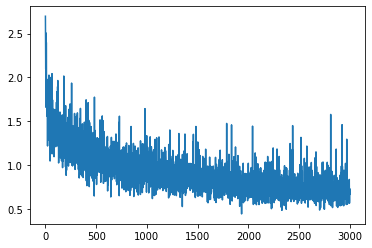

In [66]:
loss_items = []
for l in losses:
  loss_items.append(l.item())
plt.plot(loss_items)
print(min(loss_items))

In [74]:
# check model on other dataset
model.eval()

#sample = from_smiles('CC12CCC3C(CCC4=CC(=O)CCC34C)C2CCC1C(=O)CO')
#print(sample)

#loader = DataLoader([sample], batch_size=batch_size, shuffle=False)
preds = []
embs = []
test_losses = []
test_loader = DataLoader(data[int(data_size * 0.8):], batch_size=64, shuffle=False)
print(len(test_loader.dataset))
for batch in test_loader:
  batch.to(device)  
  pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
  preds.append(pred)
  embs.append(embedding)
  test_losses.append(torch.sqrt(loss_fn(pred, batch.y)))
#print(preds[0])  

1997


32


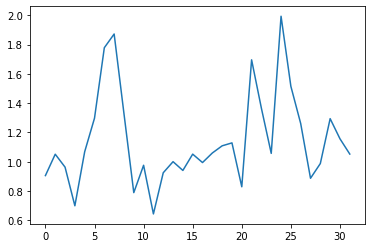

In [75]:
print(len(test_losses))
pred_loss_items = []
for l in test_losses:
  pred_loss_items.append(l.item())
plt.plot(pred_loss_items)

1128
0.5735474824905396


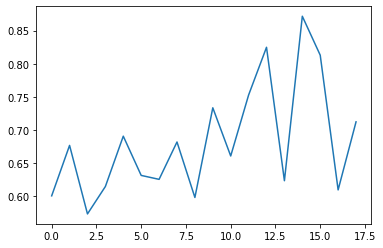

In [82]:
bench_data = MoleculeNet(root=".", name="ESOL")
bench_preds = []
bench_embs = []
bench_losses = []
bench_loader = DataLoader(bench_data, batch_size=64, shuffle=False)
print(len(bench_loader.dataset))
for batch in bench_loader:
  batch.to(device)  
  pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
  bench_preds.append(pred)
  bench_embs.append(embedding)
  bench_losses.append(torch.sqrt(loss_fn(pred, batch.y)))

bench_pred_loss_items = []
for l in bench_losses:
  bench_pred_loss_items.append(l.item())
print(min(bench_pred_loss_items))  
plt.plot(bench_pred_loss_items)

## Generate molecules with Deepchem

In [70]:
!pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
import deepchem as dc
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from tensorflow import one_hot
from tensorflow.keras.layers import Input, Lambda, Layer, Softmax, Reshape, Multiply
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

smiles = ['CCC', 'C1=CC=CC=C1', 'CNC' ]
# create featurizer
feat = dc.feat.MolGanFeaturizer()
# featurize molecules
features = feat.featurize(smiles)
# Remove empty objects
features = list(filter(lambda x: x is not None, features))
# create model
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

gan.fit_gan(iterbatches(5000), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(10000)
# convert graphs to RDKitmolecules
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))
# remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

Ending global_step 4999: generator average loss -46.2796, discriminator average loss -14.651
TIMING: model fitting took 244.587 s
Generating 10000 samples
10000 molecules generated
9985 valid molecules


In [80]:
from collections import OrderedDict
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols]
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles))
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique]
print ("{} unique valid molecules".format(len(nmols_viz)))

6 unique valid molecules


In [81]:
print(nmols_viz)

[<rdkit.Chem.rdchem.Mol object at 0x7f3bd2a7af90>, <rdkit.Chem.rdchem.Mol object at 0x7f3bd2a7af20>, <rdkit.Chem.rdchem.Mol object at 0x7f3bd2fcb0b0>, <rdkit.Chem.rdchem.Mol object at 0x7f3bd2fcb200>, <rdkit.Chem.rdchem.Mol object at 0x7f3bd2fcb270>, <rdkit.Chem.rdchem.Mol object at 0x7f3bd2fcb2e0>]
